# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


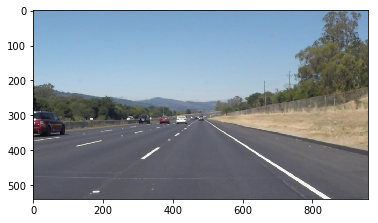

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [14]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# calculate the extrapolated line by trying to calculate an slope/intercept combination, and draw it.
def draw_lines_extrapolate(line_image, lines, vertice_y, color=[255, 0, 0], thickness=2):
    lines_left_lane = []
    lines_right_lane = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            # slopt > 0 means lines on the right lane, slope < 0 means lines on the right lane.
            if (slope > 0):
                lines_right_lane.append((slope, intercept) )
            elif (slope < 0):
                lines_left_lane.append((slope, intercept) )
#    print('right :', lines_right_lane)
#    print('left :', lines_left_lane)
    # find an average slope/intercept combination for left and right lane.
    lines_right_lane_array = np.array(lines_right_lane)
    average_right_slope = np.average(lines_right_lane_array[:, 0])
    average_right_intercept = np.average(lines_right_lane_array[:, 1])
    
    lines_left_lane_array = np.array(lines_left_lane)
    average_left_slope = np.average(lines_left_lane_array[:, 0])
    average_left_intercept = np.average(lines_left_lane_array[:, 1])
#    print('average_right_slope: ', average_right_slope)
#    print('average_right_intercept: ', average_right_intercept)
#    print('average_left_slope: ', average_left_slope)
    imgshape = line_image.shape
#    print(imgshape)
    rightlane_y1 = imgshape[0]
    rightlane_y2 = vertice_y
    rightlane_x1 = (int)((rightlane_y1 - average_right_intercept)  / average_right_slope)
    rightlane_x2 = (int)((rightlane_y2 - average_right_intercept)  / average_right_slope)
    
    leftlane_y1 = imgshape[0]
    leftlane_y2 = vertice_y
    leftlane_x1 = (int)((leftlane_y1 - average_left_intercept)  / average_left_slope)
    leftlane_x2 = (int)((leftlane_y2 - average_left_intercept)  / average_left_slope)
#    print("extrapolated right lane:", rightlane_x1, rightlane_y1, rightlane_x2, rightlane_y2)
    cv2.line(line_image, (rightlane_x1, rightlane_y1), (rightlane_x2, rightlane_y2), color, thickness)
    cv2.line(line_image, (leftlane_x1, leftlane_y1), (leftlane_x2, leftlane_y2), color, thickness)


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['mask_y_310_x_450_to_500.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This time we are defining a four sided polygon to mask
lines_edges dimensions: (540, 960, 3)


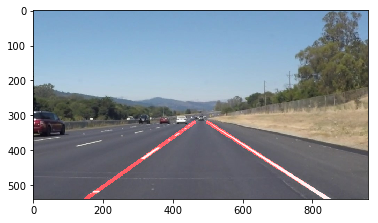

In [15]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def process_one_image(image):
    #printing out some stats and plotting
#    print('This image is:', type(image), 'with dimensions:', image.shape)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ## code copied from "15. Quiz: Hough Transform", need to adjust some parameters.

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 3 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

    # Define our parameters for Canny and run it
    low_threshold = 100
    high_threshold = 200
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # create a masked edges image
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    vertice_y = 320
    vertice_x_left = 450
    vertice_x_right = 500
    # This time we are defining a four sided polygon to mask
    print('This time we are defining a four sided polygon to mask')
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(vertice_x_left, vertice_y), (vertice_x_right, vertice_y), (imshape[1], imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 25     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 15    # maximum gap in pixels between connectable line segments
#    max_line_gap = 50    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
#    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    # Iterate over the output "lines" and draw lines on a blank image
    draw_lines_extrapolate(line_image, lines, vertice_y, (255, 0, 0), 10)
#    draw_lines(line_image, lines, (255, 0, 0), 10 )
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    # Draw the lines on the edge image
    #draw_lines(line_image, vertices[0], (255, 0, 0), 10 )
    lines_edges = cv2.addWeighted(line_image, 0.8, image, 1, 0)
    # try show to mask region on the image, easier to adjust vertices of mask region.
#    print('vertices : ' + str(vertices[0, 0])) 
#    print('type of line_image : ' +  str(type(line_image) ) + 'type of image : ' + str(type(image)), 'type of masked_edges : ' + str(type(masked_edges) )) 
#    print('size of image : ' + str((image.shape)), 'size of masked_edges : ' + str((masked_edges.shape) ), 'size of line_image:' + str(lines_edges.shape) ) 
    # add a mask to show the mask area more clear.
    rgbmask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    rgbmask = np.multiply(rgbmask , 0.5)
    rgbmask = rgbmask.astype('uint8')
#    print('rgbmask shape : ', rgbmask.shape)
#    print('lines_edges shape : ', lines_edges.shape)
    lines_edges = lines_edges.astype('uint8')
#    lines_edges = cv2.bitwise_or(rgbmask, lines_edges)

    print('lines_edges dimensions:', lines_edges.shape)
#    plt.imshow(lines_edges)

    params = list()
    params.append(cv2.IMWRITE_PNG_COMPRESSION)
    params.append(50)
    return lines_edges

filename = 'test_images/solidWhiteRight.jpg'
image = mpimg.imread(filename)
processed_image = process_one_image(image)
plt.imshow(processed_image)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return process_one_image(image)


Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

This time we are defining a four sided polygon to mask
right : [(0.59941520467836262, 16.508771929824547), (0.62874251497005984, 4.8263473053892767), (0.59999999999999998, 15.600000000000023), (0.62745098039215685, 6.9215686274509949), (0.60824742268041232, 15.051546391752595), (0.6071428571428571, 16.321428571428612), (0.59459459459459463, 26.027027027027032), (0.59459459459459463, 26.918918918918905), (0.59090909090909094, 27.909090909090878)]
left : [(-0.7142857142857143, 648.57142857142856), (-0.79487179487179482, 678.41025641025635), (-0.72173913043478266, 647.96521739130435), (-0.77272727272727271, 670.86363636363637), (-0.69565217391304346, 637.91304347826087), (-0.8125, 681.8125), (-0.76923076923076927, 671.30769230769238), (-0.70149253731343286, 639.17910447761187), (-0.71739130434782605, 648.26086956521738), (-0.83720930232558144, 689.53488372093022), (-0.72727272727272729, 648.4545454545455)]
average_right_slope:  0.605677473329
average_right_intercept:  17.342744409
extrapo

  0%|                                                  | 0/213 [00:00<?, ?it/s]

This time we are defining a four sided polygon to mask
right : [(0.59941520467836262, 16.508771929824547), (0.62874251497005984, 4.8263473053892767), (0.59999999999999998, 15.600000000000023), (0.62745098039215685, 6.9215686274509949), (0.60824742268041232, 15.051546391752595), (0.6071428571428571, 16.321428571428612), (0.59459459459459463, 26.027027027027032), (0.59459459459459463, 26.918918918918905), (0.59090909090909094, 27.909090909090878)]
left : [(-0.7142857142857143, 648.57142857142856), (-0.79487179487179482, 678.41025641025635), (-0.72173913043478266, 647.96521739130435), (-0.77272727272727271, 670.86363636363637), (-0.69565217391304346, 637.91304347826087), (-0.8125, 681.8125), (-0.76923076923076927, 671.30769230769238), (-0.70149253731343286, 639.17910447761187), (-0.71739130434782605, 648.26086956521738), (-0.83720930232558144, 689.53488372093022), (-0.72727272727272729, 648.4545454545455)]
average_right_slope:  0.605677473329
average_right_intercept:  17.342744409
extrapo

  1%|▍                                         | 2/213 [00:00<00:18, 11.17it/s]

This time we are defining a four sided polygon to mask
right : [(0.63076923076923075, 3.6461538461538794), (0.60209424083769636, 15.382198952879548), (0.64220183486238536, -3.7247706422018609), (0.5847457627118644, 25.466101694915267), (0.62886597938144329, 5.6082474226804493), (0.58904109589041098, 24.150684931506817), (0.63636363636363635, 0.63636363636362603), (0.61538461538461542, 12.846153846153811), (0.56666666666666665, 34.066666666666663), (0.60824742268041232, 16.247422680412399), (0.60526315789473684, 25.947368421052659), (0.51851851851851849, 62.0), (0.5714285714285714, 34.571428571428612), (0.61403508771929827, 14.842105263157862)]
left : [(-0.77272727272727271, 670.68181818181824), (-0.68518518518518523, 635.7037037037037), (-0.71999999999999997, 647.0), (-0.69999999999999996, 639.20000000000005), (-0.72222222222222221, 652.72222222222217), (-0.73999999999999999, 649.70000000000005), (-0.80952380952380953, 676.61904761904759), (-0.74285714285714288, 659.28571428571422)]
av

  2%|▊                                         | 4/213 [00:00<00:18, 11.02it/s]

This time we are defining a four sided polygon to mask
right : [(0.62553191489361704, 6.3574468085106446), (0.59883720930232553, 17.011627906976742), (0.61038961038961037, 18.974025974026006), (0.60759493670886078, 21.835443037974642), (0.625, 5.75), (0.61818181818181817, 9.3454545454545723), (0.58333333333333337, 38.333333333333314), (0.59459459459459463, 33.189189189189165), (0.60135135135135132, 14.567567567567608)]
left : [(-0.70833333333333337, 647.54166666666674), (-0.69565217391304346, 637.43478260869563), (-0.76190476190476186, 669.61904761904759), (-0.70588235294117652, 641.17647058823536), (-0.71999999999999997, 647.20000000000005), (-0.77551020408163263, 673.63265306122446), (-0.72727272727272729, 655.90909090909099), (-0.7142857142857143, 648.0), (-0.69999999999999996, 642.60000000000002)]
average_right_slope:  0.607201640973
average_right_intercept:  18.3737875959
extrapolated right lane: 859 540 496 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a fou

  3%|█▏                                        | 6/213 [00:00<00:18, 11.46it/s]

This time we are defining a four sided polygon to mask
right : [(0.62544169611307421, 5.901060070671349), (0.59882005899705015, 16.427728613569343), (0.61538461538461542, 15.53846153846149), (0.61038961038961037, 18.298701298701303), (0.58064516129032262, 29.903225806451587), (0.61194029850746268, 15.373134328358219), (0.57894736842105265, 39.578947368421041), (0.6071428571428571, 23.142857142857167)]
left : [(-0.70588235294117652, 641.29411764705878), (-0.75438596491228072, 663.24561403508778), (-0.70967741935483875, 648.54838709677415), (-0.70491803278688525, 644.2622950819673), (-0.73809523809523814, 655.28571428571422), (-0.66666666666666663, 629.66666666666663), (-0.71875, 650.96875), (-0.625, 606.125)]
average_right_slope:  0.603588958281
average_right_intercept:  20.5205145209
extrapolated right lane: 860 540 496 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.60093896713615025, 14.380281690140862), (0.625, 6.125), (0.

  4%|█▌                                        | 8/213 [00:00<00:17, 11.90it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 16.400000000000034), (0.62601626016260159, 7.138211382113866), (0.59898477157360408, 16.284263959390842), (0.61290322580645162, 12.419354838709694), (0.61538461538461542, 12.538461538461547), (0.609375, 17.984375), (0.56521739130434778, 38.782608695652186), (0.62637362637362637, 5.4285714285714448)]
left : [(-0.68888888888888888, 634.86666666666667), (-0.7441860465116279, 660.65116279069764), (-0.69230769230769229, 639.15384615384619), (-0.72463768115942029, 649.71014492753625), (-0.71999999999999997, 650.48000000000002), (-0.59999999999999998, 602.39999999999998), (-0.75862068965517238, 665.10344827586209), (-0.78260869565217395, 676.86956521739125), (-0.65000000000000002, 621.54999999999995), (-0.7021276595744681, 640.65957446808511), (-0.071428571428571425, 536.57142857142856), (-0.75757575757575757, 666.24242424242425)]
average_right_slope:  0.606781861326
average_right_intercept:  15.8719808554
e

  4%|█▊                                        | 9/213 [00:00<00:18, 11.22it/s]

This time we are defining a four sided polygon to mask
right : [(0.6013289036544851, 18.24916943521589), (0.63063063063063063, 5.3153153153153312), (0.6428571428571429, -1.9285714285714448), (0.6071428571428571, 25.571428571428612), (0.59999999999999998, 17.800000000000011), (0.60919540229885061, 21.14942528735628), (0.61445783132530118, 6.638554216867476), (0.59999999999999998, 29.400000000000034), (0.61643835616438358, 5.6027397260273801), (0.59999999999999998, 30.199999999999989), (0.61904761904761907, 10.476190476190482), (0.59259259259259256, 23.0), (0.66666666666666663, -15.666666666666629), (0.64000000000000001, -11.0)]
left : [(-0.69999999999999996, 645.20000000000005), (-0.78048780487804881, 674.95121951219517), (-0.70588235294117652, 642.11764705882354), (-0.70175438596491224, 641.80701754385962), (-0.7567567567567568, 665.83783783783792), (-0.83333333333333337, 691.0), (-0.65625, 623.84375), (-0.58333333333333337, 592.91666666666674), (-0.76923076923076927, 672.3076923076923

  5%|█▉                                       | 10/213 [00:00<00:18, 10.71it/s]

This time we are defining a four sided polygon to mask
right : [(0.60384615384615381, 19.692307692307736), (0.64583333333333337, -0.97916666666668561), (0.64661654135338342, -2.8646616541353183), (0.60759493670886078, 15.594936708860757), (0.625, 10.0), (0.59615384615384615, 23.153846153846132), (0.66000000000000003, -11.720000000000027), (0.61538461538461542, 8.7692307692307168), (0.64615384615384619, -3.4769230769231285), (0.61111111111111116, 12.777777777777715)]
left : [(-0.69565217391304346, 640.95652173913049), (-0.7857142857142857, 677.14285714285711), (-0.68571428571428572, 639.5428571428572), (-0.69999999999999996, 641.60000000000002), (-0.61538461538461542, 612.15384615384619), (-0.74193548387096775, 661.29032258064512), (-0.69999999999999996, 643.10000000000002), (-0.76923076923076927, 671.38461538461547), (-0.77419354838709675, 674.45161290322585), (-0.7857142857142857, 676.07142857142856), (-0.72727272727272729, 656.0)]
average_right_slope:  0.625769438405
average_right_in

  6%|██▎                                      | 12/213 [00:01<00:18, 10.85it/s]

This time we are defining a four sided polygon to mask
right : [(0.65000000000000002, -3.0500000000000114), (0.62179487179487181, 8.2371794871795032), (0.63063063063063063, 12.684684684684669), (0.63513513513513509, 7.8783783783783861), (0.65517241379310343, -20.344827586206861), (0.61702127659574468, 21.276595744680833), (0.64000000000000001, -2.6000000000000227), (0.58139534883720934, 40.906976744186011), (0.62962962962962965, 10.629629629629619), (0.59999999999999998, 34.0), (0.63888888888888884, -0.083333333333314386), (0.59090909090909094, 31.363636363636317), (0.63265306122448983, 11.63265306122446), (0.6428571428571429, -9.571428571428612)]
left : [(-0.69565217391304346, 640.304347826087), (-0.7232142857142857, 657.02678571428578), (-0.72222222222222221, 652.22222222222217), (-0.70833333333333337, 649.66666666666674), (-0.69333333333333336, 642.40000000000009), (-0.72631578947368425, 658.35789473684213), (-0.72857142857142854, 653.9571428571428), (-0.68965517241379315, 636.89655

  7%|██▋                                      | 14/213 [00:01<00:19, 10.38it/s]

This time we are defining a four sided polygon to mask
right : [(0.65315315315315314, -7.3828828828828819), (0.62462462462462465, 3.6966966966966766), (0.62903225806451613, 4.5967741935484128), (0.65243902439024393, -5.7865853658536821), (0.64000000000000001, 0.27999999999997272), (0.6071428571428571, 16.60714285714289), (0.63095238095238093, 4.6428571428571672), (0.6216216216216216, 10.567567567567608)]
left : [(-0.69523809523809521, 636.02857142857147), (-0.75257731958762886, 660.1649484536083), (-0.70886075949367089, 645.65822784810121), (-0.67088607594936711, 626.58227848101274), (-0.68421052631578949, 637.0), (-0.75268817204301075, 660.44086021505382), (-0.69230769230769229, 637.0), (-0.67741935483870963, 630.9354838709678), (-0.71875, 646.3125)]
average_right_slope:  0.632370739994
average_right_intercept:  3.40269627613
extrapolated right lane: 848 540 500 320
lines_edges dimensions: (540, 960, 3)


  7%|██▉                                      | 15/213 [00:01<00:19, 10.18it/s]

This time we are defining a four sided polygon to mask
right : [(0.625, 1.75), (0.60396039603960394, 19.198019801980195), (0.65365853658536588, -9.1121951219512312), (0.61224489795918369, 11.918367346938794), (0.63461538461538458, 1.846153846153868), (0.60606060606060608, 15.333333333333314), (0.63793103448275867, 3.7586206896551175), (0.6216216216216216, 17.945945945945937), (0.59999999999999998, 24.800000000000011), (0.65625, -19.6875), (0.69999999999999996, -37.5), (0.59259259259259256, 27.5555555555556), (0.6071428571428571, 13.535714285714334), (0.59999999999999998, 34.0), (0.5714285714285714, 42.428571428571445)]
left : [(-0.734375, 653.296875), (-0.67692307692307696, 630.79999999999995), (-0.66666666666666663, 623.33333333333326), (-0.759493670886076, 663.29113924050637), (-0.73333333333333328, 654.93333333333339), (-0.68000000000000005, 631.84000000000003), (-0.70454545454545459, 637.75), (-0.7021276595744681, 640.872340425532), (-0.66666666666666663, 624.0), (-0.66666666666666

  8%|███                                      | 16/213 [00:01<00:20,  9.82it/s]

This time we are defining a four sided polygon to mask
right : [(0.62305295950155759, 2.7975077881620223), (0.67099567099567103, -21.809523809523853), (0.66666666666666663, -18.0), (0.6875, -35.875), (0.625, 0.75), (0.6428571428571429, -4.3571428571428896)]
left : [(-0.72916666666666663, 651.77083333333326), (-0.66666666666666663, 622.33333333333326), (-0.66666666666666663, 629.0), (-0.73333333333333328, 651.26666666666665), (-0.70833333333333337, 643.45833333333337), (-0.6875, 631.5), (-0.72727272727272729, 645.81818181818176), (-0.72222222222222221, 644.77777777777783), (-0.68421052631578949, 635.15789473684208), (-0.71999999999999997, 644.20000000000005), (-0.66666666666666663, 625.66666666666663), (-0.76923076923076927, 659.0), (-0.734375, 652.671875)]
average_right_slope:  0.652678740004
average_right_intercept:  -12.7490264798
extrapolated right lane: 846 540 509 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.623456790

  8%|███▍                                     | 18/213 [00:01<00:17, 10.85it/s]

This time we are defining a four sided polygon to mask
right : [(0.62424242424242427, 3.6484848484848271), (0.65497076023391809, -8.6959064327485294), (0.62537764350453173, 3.6767371601208652), (0.64948453608247425, -5.989690721649481), (0.63636363636363635, 6.9090909090909349)]
left : [(-0.66666666666666663, 626.66666666666663), (-0.62962962962962965, 612.03703703703707), (-0.59090909090909094, 598.18181818181824), (-0.77419354838709675, 669.87096774193549), (-0.61538461538461542, 607.30769230769238), (-0.68965517241379315, 634.55172413793105), (-0.72222222222222221, 647.88888888888891), (-0.6964285714285714, 637.875), (-0.6875, 633.0625), (-0.76470588235294112, 668.05882352941171)]
average_right_slope:  0.638087800085
average_right_intercept:  -0.0902568473403
extrapolated right lane: 846 540 501 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.625, 4.625), (0.65315315315315314, -6.6261261261261097), (0.65217391304347827, -5

  9%|███▊                                     | 20/213 [00:02<00:23,  8.27it/s]

This time we are defining a four sided polygon to mask
right : [(0.62647058823529411, 4.6205882352941217), (0.64925373134328357, -2.1791044776119293), (0.65248226950354615, -5.5886524822695378), (0.65853658536585369, -8.8780487804878021), (0.63636363636363635, 2.636363636363626)]
left : [(-0.67391304347826086, 631.91304347826087), (-0.75, 665.5), (-0.7857142857142857, 676.42857142857144), (-0.72222222222222221, 651.5), (-0.65517241379310343, 626.86206896551721), (-0.66666666666666663, 635.33333333333337), (-0.66666666666666663, 628.66666666666663), (-0.7142857142857143, 652.14285714285711), (-0.71999999999999997, 649.75999999999999), (-0.61538461538461542, 623.69230769230774), (-0.75555555555555554, 669.5333333333333), (-0.72727272727272729, 655.72727272727275)]
average_right_slope:  0.644621362162
average_right_intercept:  -1.87777077374
extrapolated right lane: 840 540 499 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.622

 10%|████▏                                    | 22/213 [00:02<00:21,  8.74it/s]

This time we are defining a four sided polygon to mask
right : [(0.65294117647058825, -6.4705882352941444), (0.62314540059347179, 5.833827893175112), (0.6512820512820513, -4.517948717948741), (0.6470588235294118, -4.058823529411768), (0.63636363636363635, -0.63636363636362603)]
left : [(-0.71875, 655.09375), (-0.66666666666666663, 630.0), (-0.73913043478260865, 660.47826086956525), (-0.69999999999999996, 642.0), (-0.70370370370370372, 642.59259259259261), (-0.69999999999999996, 646.79999999999995), (-0.66666666666666663, 631.0), (-0.70588235294117652, 646.47058823529414), (-0.80000000000000004, 685.0), (-0.73913043478260865, 660.56521739130426), (-0.7142857142857143, 650.0), (-0.7142857142857143, 652.57142857142856), (-0.7142857142857143, 646.42857142857144)]
average_right_slope:  0.642158217648
average_right_intercept:  -1.96997924517
extrapolated right lane: 843 540 501 320
lines_edges dimensions: (540, 960, 3)


 11%|████▍                                    | 23/213 [00:02<00:21,  8.82it/s]

This time we are defining a four sided polygon to mask
right : [(0.62462462462462465, 4.5705705705705668), (0.65365853658536588, -6.8439024390244185), (0.6333333333333333, 4.6333333333333258), (0.63513513513513509, 2.5405405405405759), (0.63636363636363635, 7.2727272727272521), (0.61538461538461542, 25.384615384615358), (0.61538461538461542, 12.307692307692264), (0.64233576642335766, -7.7372262773722582)]
left : [(-0.67441860465116277, 632.1395348837209), (-0.74683544303797467, 662.21518987341778), (-0.74137931034482762, 660.58620689655174), (-0.72580645161290325, 651.9677419354839), (-0.76000000000000001, 664.44000000000005), (-0.75, 665.5), (-0.66666666666666663, 630.66666666666663), (-0.77777777777777779, 673.33333333333337), (-0.72916666666666663, 654.29166666666663), (-0.75, 660.5)]
average_right_slope:  0.632027532904
average_right_intercept:  5.26604383664
extrapolated right lane: 846 540 497 320
lines_edges dimensions: (540, 960, 3)


 11%|████▌                                    | 24/213 [00:09<07:27,  2.37s/it]

This time we are defining a four sided polygon to mask
right : [(0.62613981762917936, 2.9027355623099993), (0.64971751412429379, -5.5084745762711691), (0.63793103448275867, 3.0689655172413381), (0.65116279069767447, -4.4186046511628092), (0.63793103448275867, 4.1034482758620356), (0.62962962962962965, 11.222222222222229), (0.625, 3.25), (0.625, 5.25)]
left : [(-0.72440944881889768, 655.35433070866145), (-0.70270270270270274, 641.13513513513522), (-0.67375886524822692, 633.32624113475174), (-0.73015873015873012, 658.01587301587301), (-0.65909090909090906, 628.22727272727275), (-0.7068965517241379, 646.58620689655163), (-0.67469879518072284, 633.83132530120486), (-0.70833333333333337, 645.0), (-0.625, 615.875), (-0.72580645161290325, 656.30645161290317), (-0.71794871794871795, 653.0)]
average_right_slope:  0.635313977631
average_right_intercept:  2.48378654378
extrapolated right lane: 846 540 499 320
lines_edges dimensions: (540, 960, 3)


 12%|████▊                                    | 25/213 [00:10<05:55,  1.89s/it]

This time we are defining a four sided polygon to mask
right : [(0.62349397590361444, 4.9126506024096557), (0.65158371040723984, -6.4434389140271833), (0.65263157894736845, -5.64210526315793), (0.63636363636363635, 5.0), (0.62441314553990612, 3.7323943661971839), (0.6216216216216216, 16.972972972972968), (0.66666666666666663, -17.333333333333314), (0.64444444444444449, -5.8444444444444912)]
left : [(-0.67889908256880738, 635.40366972477068), (-0.74647887323943662, 662.08450704225356), (-0.75, 661.0), (-0.68000000000000005, 634.36000000000001), (-0.66666666666666663, 633.0), (-0.67272727272727273, 632.83636363636367), (-0.70588235294117652, 642.58823529411768), (-0.65517241379310343, 621.13793103448279), (-0.78260869565217395, 668.56521739130437), (-0.75, 659.75), (-0.68888888888888888, 638.86666666666667), (-0.69230769230769229, 642.07692307692309)]
average_right_slope:  0.640152347487
average_right_intercept:  -0.580663001673
extrapolated right lane: 844 540 500 320
lines_edges dimens

 12%|█████                                    | 26/213 [00:11<04:58,  1.60s/it]

This time we are defining a four sided polygon to mask
right : [(0.65263157894736845, -6.631578947368439), (0.62349397590361444, 4.9126506024096557), (0.62256809338521402, 5.0817120622568268), (0.6495726495726496, -3.74358974358978), (0.625, 6.625), (0.63793103448275867, 1.0)]
left : [(-0.70833333333333337, 643.70833333333337), (-0.66666666666666663, 633.66666666666663), (-0.72580645161290325, 658.0322580645161), (-0.63636363636363635, 616.4545454545455), (-0.73333333333333328, 656.66666666666663), (-0.7142857142857143, 651.14285714285711), (-0.66666666666666663, 633.0), (-0.67346938775510201, 631.46938775510205), (-0.6875, 635.6875), (-0.69767441860465118, 640.34883720930236), (-0.72580645161290325, 657.0322580645161), (-0.70833333333333337, 647.79166666666674)]
average_right_slope:  0.635199555382
average_right_intercept:  1.20736566228
extrapolated right lane: 848 540 501 320
lines_edges dimensions: (540, 960, 3)


 13%|█████▏                                   | 27/213 [00:15<07:24,  2.39s/it]

This time we are defining a four sided polygon to mask
right : [(0.62457337883959041, 4.9795221843003787), (0.65116279069767447, -6.2325581395348877), (0.64968152866242035, -3.834394904458577), (0.63636363636363635, 4.2727272727272521), (0.6428571428571429, -10.642857142857167), (0.63953488372093026, -7.4186046511628092), (0.59999999999999998, 20.800000000000011), (0.63793103448275867, 4.0172413793102919), (0.59999999999999998, 25.800000000000011), (0.64864864864864868, -13.054054054054063), (0.61111111111111116, 11.388888888888857), (0.63934426229508201, -5.3114754098360777), (0.63380281690140849, 5.0985915492957474), (0.6470588235294118, -14.941176470588289)]
left : [(-0.66666666666666663, 628.33333333333326), (-0.78947368421052633, 680.8947368421052), (-0.75, 661.75), (-0.72131147540983609, 652.31147540983602), (-0.625, 627.125), (-0.69999999999999996, 644.59999999999991), (-0.75, 662.75), (-0.66666666666666663, 634.66666666666663), (-0.68000000000000005, 634.16000000000008), (-0.80

 13%|█████▍                                   | 28/213 [00:17<06:39,  2.16s/it]

This time we are defining a four sided polygon to mask
right : [(0.65027322404371579, -6.0874316939890605), (0.62458471760797341, 4.2192691029900402), (0.6216216216216216, 5.2702702702702595), (0.63636363636363635, 5.0), (0.63380281690140849, 8.4084507042253449), (0.6216216216216216, 16.621621621621614), (0.63793103448275867, 2.8965517241379075), (0.66666666666666663, -15.666666666666629), (0.63636363636363635, 3.0909090909091219), (0.57894736842105265, 54.578947368421041), (0.61904761904761907, 7.0476190476190368)]
left : [(-0.7142857142857143, 646.42857142857144), (-0.6333333333333333, 615.93333333333339), (-0.70370370370370372, 646.92592592592587), (-0.7592592592592593, 669.25925925925935), (-0.7068965517241379, 645.87931034482756), (-0.73076923076923073, 651.23076923076928), (-0.82608695652173914, 693.04347826086951), (-0.74285714285714288, 659.62857142857138)]
average_right_slope:  0.629747633013
average_right_intercept:  7.76177641541
extrapolated right lane: 845 540 495 320
line

 14%|█████▌                                   | 29/213 [00:18<05:38,  1.84s/it]

This time we are defining a four sided polygon to mask
right : [(0.65034965034965031, -5.6923076923076792), (0.62613981762917936, 2.398176291793277), (0.6517857142857143, -7.4553571428571672), (0.61403508771929827, 10.596491228070136), (0.61538461538461542, 10.0)]
left : [(-0.73333333333333328, 657.93333333333328), (-0.69491525423728817, 637.88135593220341), (-0.69491525423728817, 640.35593220338978), (-0.69999999999999996, 645.20000000000005), (-0.61111111111111116, 608.38888888888891), (-0.72222222222222221, 648.61111111111109), (-0.76923076923076927, 663.30769230769238), (-0.73170731707317072, 652.19512195121956), (-0.68000000000000005, 635.31999999999994), (-0.75862068965517238, 660.68965517241372), (-0.72499999999999998, 652.14999999999998)]
average_right_slope:  0.631538977074
average_right_intercept:  1.96940053694
extrapolated right lane: 851 540 503 320
lines_edges dimensions: (540, 960, 3)


 14%|█████▊                                   | 30/213 [00:18<04:02,  1.33s/it]

This time we are defining a four sided polygon to mask
right : [(0.62424242424242427, 3.3999999999999773), (0.65156794425087106, -6.3623693379790893), (0.61538461538461542, 10.769230769230774), (0.625, 3.375), (0.65151515151515149, -7.318181818181813), (0.62857142857142856, -1.3142857142856883)]
left : [(-0.70454545454545459, 640.86363636363637), (-0.73684210526315785, 658.10526315789468), (-0.72222222222222221, 647.88888888888891), (-0.68421052631578949, 634.42105263157896), (-0.74193548387096775, 661.0322580645161), (-0.69767441860465118, 641.88372093023258), (-0.69696969696969702, 639.90909090909099), (-0.69999999999999996, 640.09999999999991), (-0.72727272727272729, 649.36363636363637), (-0.7142857142857143, 644.0)]
average_right_slope:  0.632713593994
average_right_intercept:  0.424898983131
extrapolated right lane: 852 540 505 320
lines_edges dimensions: (540, 960, 3)


 15%|█████▉                                   | 31/213 [00:19<03:47,  1.25s/it]

This time we are defining a four sided polygon to mask
right : [(0.6508474576271186, -6.759322033898286), (0.62019230769230771, 5.875), (0.625, 5.375), (0.6428571428571429, -7.2857142857143344), (0.64367816091954022, -7.1494252873563369), (0.65104166666666663, -7.3802083333333144), (0.65714285714285714, -17.600000000000023), (0.63636363636363635, -5.0), (0.66666666666666663, -18.333333333333258)]
left : [(-0.7021276595744681, 640.36170212765956), (-0.75609756097560976, 665.46341463414637), (-0.72340425531914898, 648.42553191489355), (-0.72307692307692306, 650.55384615384617), (-0.71153846153846156, 647.30769230769238), (-0.69999999999999996, 643.0), (-0.068965517241379309, 529.44827586206895), (-0.70833333333333337, 645.125), (-0.78048780487804881, 672.53658536585363), (-0.625, 626.0)]
average_right_slope:  0.643754432882
average_right_intercept:  -6.47311147485
extrapolated right lane: 848 540 507 320
lines_edges dimensions: (540, 960, 3)


 15%|██████▏                                  | 32/213 [00:19<02:44,  1.10it/s]

This time we are defining a four sided polygon to mask
right : [(0.64983164983164987, -5.9090909090909349), (0.62458471760797341, 3.4717607973421991), (0.65217391304347827, -7.652173913043498), (0.62962962962962965, 11.629629629629619), (0.63829787234042556, -8.6595744680851112), (0.6216216216216216, 17.189189189189221), (0.63636363636363635, -3.2727272727272521), (0.63636363636363635, -6.181818181818187), (0.67741935483870963, -24.483870967741893), (0.640625, -4.421875)]
left : [(-0.70588235294117652, 642.47058823529414), (-0.73076923076923073, 656.15384615384619), (-0.65853658536585369, 626.17073170731715), (-0.73076923076923073, 656.96153846153845), (-0.6785714285714286, 633.14285714285711), (-0.74468085106382975, 662.38297872340422), (-0.69999999999999996, 639.09999999999991), (-0.75, 663.75), (-0.63157894736842102, 616.15789473684208), (-0.69999999999999996, 643.5), (-0.80851063829787229, 687.25531914893622)]
average_right_slope:  0.640691103164
average_right_intercept:  -2.829055

 15%|██████▎                                  | 33/213 [00:20<02:01,  1.49it/s]

This time we are defining a four sided polygon to mask
right : [(0.62439024390243902, 5.3365853658536366), (0.65248226950354615, -6.1702127659575012), (0.64583333333333337, -13.833333333333371), (0.6376811594202898, -5.1159420289854438), (0.65163934426229508, -4.8155737704918238), (0.65853658536585369, -22.707317073170771), (0.63829787234042556, 0.21276595744677707), (0.60869565217391308, 12.956521739130437), (0.65853658536585369, -23.536585365853739), (0.59999999999999998, 16.600000000000023), (0.66666666666666663, -27.666666666666629)]
left : [(-0.66666666666666663, 630.0), (-0.72727272727272729, 655.36363636363637), (-0.72727272727272729, 656.81818181818176), (-0.77419354838709675, 671.0), (-0.77272727272727271, 671.27272727272725), (-0.76923076923076927, 670.07692307692309), (-0.75, 661.25), (-0.69565217391304346, 639.60869565217388), (-0.66666666666666663, 628.33333333333326), (-0.76923076923076927, 671.07692307692309), (-0.61538461538461542, 603.69230769230762)]
average_right_slo

 16%|██████▌                                  | 34/213 [00:20<01:38,  1.82it/s]

This time we are defining a four sided polygon to mask
right : [(0.65140845070422537, -4.971830985915517), (0.62457337883959041, 5.4812286689419807), (0.63793103448275867, -6.4310344827586619), (0.59999999999999998, 19.400000000000034), (0.52777777777777779, 57.722222222222229), (0.660377358490566, -9.547169811320714), (0.8571428571428571, -117.28571428571428), (0.63461538461538458, -2.6153846153845848), (0.63513513513513509, 7.9324324324324493), (0.8125, -95.8125)]
left : [(-0.660377358490566, 630.18867924528297), (-0.71875, 652.78125), (-0.7466666666666667, 663.90666666666664), (-0.74137931034482762, 661.12068965517244), (-0.69047619047619047, 638.26190476190482), (-0.72413793103448276, 650.93103448275861), (-0.7142857142857143, 650.57142857142856), (-0.6470588235294118, 618.94117647058829), (-0.6428571428571429, 618.28571428571433), (-0.69230769230769229, 643.23076923076928), (-0.75641025641025639, 666.10256410256409)]
average_right_slope:  0.664146137719
average_right_intercept:  -

 16%|██████▋                                  | 35/213 [00:20<01:19,  2.23it/s]

This time we are defining a four sided polygon to mask
right : [(0.65145228215767637, -3.6597510373443924), (0.62456140350877198, 5.6140350877192873), (0.65789473684210531, -9.0263157894736992), (0.58823529411764708, 25.176470588235304), (0.53658536585365857, 51.707317073170714), (0.64864864864864868, -14.432432432432506), (0.64516129032258063, -12.612903225806463), (0.64000000000000001, 2.839999999999975), (0.52500000000000002, 58.399999999999977), (0.71111111111111114, -39.133333333333326)]
left : [(-0.74698795180722888, 664.31325301204822), (-0.69999999999999996, 641.39999999999998), (-0.74683544303797467, 662.84810126582283), (-0.72727272727272729, 652.63636363636363), (-0.72307692307692306, 652.72307692307686), (-0.69811320754716977, 640.03773584905662), (-0.7142857142857143, 650.0), (-0.66666666666666663, 633.0), (-0.75238095238095237, 664.74285714285713), (-0.70370370370370372, 646.11111111111109)]
average_right_slope:  0.622865013256
average_right_intercept:  6.48730869307
extr

 17%|██████▉                                  | 36/213 [00:20<01:03,  2.77it/s]

This time we are defining a four sided polygon to mask
right : [(0.67021276595744683, -16.117021276595779), (0.625, 5.25), (0.6333333333333333, 9.6000000000000227), (0.61702127659574468, 23.574468085106389), (0.6875, -28.25), (0.61764705882352944, 7.9705882352940876), (0.63636363636363635, -4.8181818181817562), (0.6071428571428571, 27.250000000000057), (0.66153846153846152, -11.646153846153823), (0.62439024390243902, 6.6048780487805061), (0.67213114754098358, -16.737704918032762), (0.59090909090909094, 45.772727272727252)]
left : [(-0.72799999999999998, 658.84799999999996), (-0.70149253731343286, 641.41791044776119), (-0.80597014925373134, 687.52238805970148), (-0.66666666666666663, 628.66666666666663), (-0.70161290322580649, 640.4354838709678), (-0.78048780487804881, 677.46341463414637), (-0.77272727272727271, 669.86363636363637), (-0.72727272727272729, 651.27272727272725), (-0.69090909090909092, 640.12727272727273), (-0.7142857142857143, 652.28571428571422)]
average_right_slope:  0.6

 18%|███████▎                                 | 38/213 [00:20<00:49,  3.55it/s]

This time we are defining a four sided polygon to mask
right : [(0.62758620689655176, 2.4137931034482563), (0.67073170731707321, -18.426829268292693), (0.63636363636363635, 6.818181818181813), (0.63513513513513509, -2.6216216216216139), (0.6071428571428571, 30.785714285714334), (0.66871165644171782, -16.03680981595096), (0.61290322580645162, 26.838709677419331)]
left : [(-0.69230769230769229, 638.53846153846155), (-0.72727272727272729, 656.5454545454545), (-0.759493670886076, 667.56962025316466), (-0.7021276595744681, 639.468085106383), (-0.66666666666666663, 626.66666666666663), (-0.71698113207547165, 641.67924528301887), (-0.73913043478260865, 660.52173913043475), (-0.69230769230769229, 638.46153846153845), (-0.73684210526315785, 659.78947368421052), (-0.66666666666666663, 626.0), (-0.7142857142857143, 644.28571428571422), (-0.7142857142857143, 646.42857142857144), (-0.70175438596491224, 639.87719298245611)]
average_right_slope:  0.636939203586
average_right_intercept:  4.25301973984

 19%|███████▋                                 | 40/213 [00:21<00:38,  4.52it/s]

This time we are defining a four sided polygon to mask
right : [(0.62548262548262545, 3.837837837837867), (0.67169811320754713, -19.611320754716985), (0.63157894736842102, -1.2631578947368212), (0.67021276595744683, -17.819148936170222), (0.6470588235294118, 0.0), (0.64000000000000001, 4.0), (0.59999999999999998, 37.0), (0.6875, -32.375), (0.625, 1.75), (0.6292134831460674, 0.56179775280901367)]
left : [(-0.6964285714285714, 637.57142857142856), (-0.6785714285714286, 631.78571428571422), (-0.81081081081081086, 684.16216216216219), (-0.75, 658.5), (-0.79166666666666663, 678.79166666666663), (-0.73333333333333328, 650.33333333333326), (-0.71999999999999997, 645.88), (-0.69230769230769229, 633.61538461538453), (-0.73913043478260865, 658.3478260869565), (-0.68421052631578949, 635.42105263157896)]
average_right_slope:  0.642774475869
average_right_intercept:  -2.3918991995
extrapolated right lane: 843 540 501 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided p

 20%|████████                                 | 42/213 [00:21<00:30,  5.54it/s]

This time we are defining a four sided polygon to mask
right : [(0.67148014440433212, -19.498194945848354), (0.64615384615384619, -10.507692307692309), (0.6404494382022472, -7.8539325842696712), (0.68421052631578949, -30.473684210526358), (0.63793103448275867, -6.4310344827586619), (0.660377358490566, -18.283018867924511), (0.69230769230769229, -45.769230769230774), (0.66666666666666663, -17.333333333333258), (0.6875, -32.6875), (0.67005076142131981, -17.736040609137035), (0.66153846153846152, -18.230769230769226)]
left : [(-0.68000000000000005, 627.88), (-0.70270270270270274, 638.89189189189187), (-0.75862068965517238, 665.17241379310349), (-0.79411764705882348, 676.61764705882354), (-0.78947368421052633, 676.68421052631584), (-0.75, 659.75), (-0.69999999999999996, 639.39999999999998), (-0.71052631578947367, 642.47368421052624), (-0.77272727272727271, 670.22727272727275)]
average_right_slope:  0.665333266362
average_right_intercept:  -20.4367664856
extrapolated right lane: 842 540 511

 20%|████████▎                                | 43/213 [00:21<00:33,  5.01it/s]

This time we are defining a four sided polygon to mask
right : [(0.67207792207792205, -20.168831168831161), (0.64480874316939896, -8.9071038251366303), (0.64444444444444449, -10.711111111111165), (0.67105263157894735, -18.25), (0.65957446808510634, -21.191489361702111), (0.69999999999999996, -48.799999999999955), (0.63829787234042556, -6.4680851063830005), (0.64864864864864868, -10.378378378378386), (0.7142857142857143, -55.428571428571445), (0.66666666666666663, -27.333333333333314), (0.69999999999999996, -49.999999999999943)]
left : [(-0.63636363636363635, 610.09090909090901), (-0.75609756097560976, 664.21951219512198), (-0.66666666666666663, 626.0), (-0.75757575757575757, 656.87878787878788), (-0.69354838709677424, 635.70967741935488), (-0.73170731707317072, 655.14634146341461), (-0.74193548387096775, 652.12903225806451), (-0.70149253731343286, 640.17910447761187), (-0.63636363636363635, 625.4545454545455), (-0.70370370370370372, 642.44444444444446), (-0.7142857142857143, 643.428571

 21%|████████▍                                | 44/213 [00:21<00:30,  5.51it/s]

This time we are defining a four sided polygon to mask
right : [(0.671875, -19.359375), (0.64417177914110424, -8.5644171779140947), (0.64220183486238536, -8.4128440366972654), (0.65000000000000002, -15.650000000000034), (0.64406779661016944, -11.677966101694892), (0.59999999999999998, 37.400000000000034), (0.67368421052631577, -20.10526315789474), (0.65714285714285714, -15.457142857142856), (0.62962962962962965, 12.444444444444457), (0.6875, -40.0), (0.7142857142857143, -56.0), (0.69999999999999996, -43.599999999999909), (0.72727272727272729, -65.090909090909122)]
left : [(-0.67272727272727273, 629.4545454545455), (-0.73999999999999999, 658.96000000000004), (-0.6875, 633.1875), (-0.69999999999999996, 638.5), (-0.74285714285714288, 656.51428571428573), (-0.7142857142857143, 646.28571428571422), (-0.69999999999999996, 640.79999999999995), (-0.73333333333333328, 655.60000000000002), (-0.66666666666666663, 623.33333333333326), (-0.66666666666666663, 625.66666666666663), (-0.769230769230769

 21%|████████▋                                | 45/213 [00:21<00:35,  4.74it/s]

This time we are defining a four sided polygon to mask
right : [(0.67218543046357615, -20.569536423841043), (0.62992125984251968, -0.37795275590548272), (0.62686567164179108, 3.0298507462686075), (0.6216216216216216, 7.4864864864865126), (0.61538461538461542, 14.076923076923038), (0.59999999999999998, 20.199999999999989), (0.66666666666666663, -17.333333333333258), (0.69999999999999996, -36.899999999999977), (0.61194029850746268, 13.044776119402968), (0.58333333333333337, 27.083333333333314), (0.69090909090909092, -32.181818181818187)]
left : [(-0.70149253731343286, 638.40298507462694), (-0.78947368421052633, 674.0), (-0.75757575757575757, 662.87878787878788), (-0.66666666666666663, 626.0), (-0.70833333333333337, 641.875), (-0.69565217391304346, 638.52173913043475), (-0.73913043478260865, 653.3478260869565), (-0.66666666666666663, 627.0), (-0.84615384615384615, 693.53846153846155), (-0.66666666666666663, 622.66666666666663), (-0.73913043478260865, 654.3478260869565)]
average_right_slop

 22%|█████████                                | 47/213 [00:22<00:28,  5.80it/s]

This time we are defining a four sided polygon to mask
right : [(0.62804878048780488, 3.2743902439024168), (0.67132867132867136, -18.748251748251789), (0.69565217391304346, -39.086956521739125), (0.62686567164179108, 2.2686567164178655), (0.61290322580645162, 12.258064516129025), (0.66666666666666663, -15.333333333333314), (0.625, 3.625), (0.61194029850746268, 14.31343283582089), (0.7142857142857143, -52.714285714285779), (0.59999999999999998, 22.199999999999989), (0.63636363636363635, -4.818181818181813)]
left : [(-0.76000000000000001, 662.88), (-0.69841269841269837, 636.28571428571422), (-0.67500000000000004, 630.875), (-0.6811594202898551, 632.72463768115949), (-0.74603174603174605, 659.44444444444446), (-0.66666666666666663, 630.33333333333326), (-0.71111111111111114, 643.20000000000005), (-0.77777777777777779, 669.11111111111109), (-0.70833333333333337, 644.16666666666674), (-0.80000000000000004, 676.60000000000002), (-0.8125, 680.3125)]
average_right_slope:  0.644459530818
averag

 23%|█████████▍                               | 49/213 [00:22<00:24,  6.81it/s]

This time we are defining a four sided polygon to mask
right : [(0.67509025270758127, -22.0), (0.62727272727272732, 2.0545454545454049), (0.65217391304347827, -7.652173913043498), (0.64220183486238536, -8.1100917431193125), (0.65957446808510634, -23.617021276595665), (0.68181818181818177, -23.772727272727252), (0.61702127659574468, 7.5319148936169995), (0.69999999999999996, -34.799999999999955), (0.68518518518518523, -27.925925925925981), (0.72222222222222221, -49.388888888888857), (0.69565217391304346, -52.130434782608631), (0.7142857142857143, -45.142857142857167), (0.5625, 37.9375), (0.57894736842105265, 28.421052631578959), (0.75, -63.75), (0.58823529411764708, 22.41176470588232)]
left : [(-0.71999999999999997, 651.03999999999996), (-0.7142857142857143, 641.14285714285711), (-0.6705882352941176, 629.87058823529412), (-0.75, 659.0), (-0.76000000000000001, 663.48000000000002), (-0.72727272727272729, 648.36363636363637), (-0.64000000000000001, 622.15999999999997), (-0.6111111111111111

 23%|█████████▌                               | 50/213 [00:22<00:22,  7.36it/s]

This time we are defining a four sided polygon to mask
right : [(0.67259786476868333, -19.476868327402144), (0.62937062937062938, 2.1468531468531182), (0.6428571428571429, -7.2857142857143344), (0.66153846153846152, -20.707692307692298), (0.6875, -37.0625), (0.66666666666666663, -25.0), (0.68181818181818177, -32.863636363636317), (0.5625, 38.6875), (0.6588235294117647, -9.4823529411764866), (0.64634146341463417, -8.5609756097560989), (0.59999999999999998, 26.600000000000023), (0.61538461538461542, 16.076923076923038), (0.61224489795918369, 13.959183673469397), (0.57894736842105265, 40.631578947368382), (0.70588235294117652, -35.823529411764753)]
left : [(-0.65714285714285714, 626.71428571428567), (-0.72727272727272729, 650.72727272727275), (-0.75862068965517238, 657.34482758620686), (-0.64000000000000001, 613.12), (-0.69047619047619047, 631.95238095238096), (-0.6875, 632.125), (-0.69387755102040816, 637.0204081632653), (-0.66666666666666663, 624.0), (-0.68421052631578949, 634.052631578

 24%|█████████▊                               | 51/213 [00:22<00:20,  7.72it/s]

This time we are defining a four sided polygon to mask
right : [(0.62416107382550334, 5.5906040268456536), (0.67247386759581884, -19.44599303135891), (0.61111111111111116, 14.166666666666629), (0.64356435643564358, -6.8019801980198054), (0.65909090909090906, -18.795454545454504), (0.68181818181818177, -32.590909090909065), (0.67741935483870963, -28.419354838709637), (0.72727272727272729, -63.545454545454618), (0.73333333333333328, -71.733333333333292), (0.69999999999999996, -42.799999999999955), (0.72727272727272729, -66.090909090909122), (0.75, -84.25), (0.6875, -31.1875), (0.73333333333333328, -67.266666666666652), (0.59999999999999998, 19.199999999999989), (0.60465116279069764, 18.34883720930236), (0.59090909090909094, 28.090909090909065), (0.59999999999999998, 22.400000000000034)]
left : [(-0.73076923076923073, 651.69230769230762), (-0.65517241379310343, 619.0), (-0.68518518518518523, 630.01851851851848), (-0.67241379310344829, 628.63793103448279), (-0.69811320754716977, 638.641509

 24%|██████████                               | 52/213 [00:22<00:20,  7.83it/s]

This time we are defining a four sided polygon to mask
right : [(0.67293233082706772, -20.206766917293237), (0.62666666666666671, 2.6266666666666652), (0.65909090909090906, -10.840909090909065), (0.65957446808510634, -21.127659574468055), (0.62962962962962965, 8.3703703703703809), (0.68421052631578949, -25.421052631578959), (0.65625, -20.78125), (0.68421052631578949, -42.736842105263122), (0.68965517241379315, -45.793103448275929), (0.64102564102564108, -0.84615384615386802), (0.59999999999999998, 23.0), (0.66666666666666663, -22.333333333333314), (0.59090909090909094, 27.454545454545439), (0.61111111111111116, 18.333333333333314), (0.6785714285714286, -25.892857142857224)]
left : [(-0.72413793103448276, 649.82758620689651), (-0.69999999999999996, 633.89999999999998), (-0.66666666666666663, 625.33333333333326), (-0.6785714285714286, 629.75), (-0.69230769230769229, 633.07692307692309), (-0.66666666666666663, 623.66666666666663), (-0.66666666666666663, 626.66666666666663), (-0.6896551724

 25%|██████████▍                              | 54/213 [00:22<00:18,  8.72it/s]

This time we are defining a four sided polygon to mask
right : [(0.65497076023391809, -6.2923976608186649), (0.62390670553935856, 6.4314868804664798), (0.63414634146341464, 4.0243902439024168), (0.63793103448275867, 8.0862068965516869), (0.625, 17.0), (0.625, 19.25), (0.63793103448275867, 3.0344827586206407), (0.6428571428571429, 2.7857142857142776), (0.61702127659574468, 9.9148936170212778)]
left : [(-0.67391304347826086, 627.21739130434776), (-0.70454545454545459, 644.22727272727275), (-0.6785714285714286, 633.5), (-0.68421052631578949, 631.0526315789474), (-0.67272727272727273, 630.12727272727273), (-0.71052631578947367, 645.65789473684208), (-0.70149253731343286, 641.47761194029852), (-0.70833333333333337, 642.29166666666674), (-0.63636363636363635, 622.18181818181824), (-0.69999999999999996, 638.09999999999991), (-0.70422535211267601, 641.83098591549287)]
average_right_slope:  0.633196032851
average_right_intercept:  7.13719744683
extrapolated right lane: 841 540 494 320
lines_edg

 26%|██████████▊                              | 56/213 [00:22<00:16,  9.58it/s]

This time we are defining a four sided polygon to mask
right : [(0.62585034013605445, 5.6938775510204209), (0.65492957746478875, -6.1549295774647703), (0.65131578947368418, -1.2894736842105203), (0.59615384615384615, 29.153846153846132), (0.59090909090909094, 35.727272727272691), (0.63888888888888884, 5.7222222222222285), (0.57894736842105265, 39.578947368421041), (0.5714285714285714, 50.0), (0.6428571428571429, -2.5), (0.6607142857142857, -17.089285714285722), (0.63636363636363635, 6.9090909090909349), (0.56521739130434778, 53.869565217391312), (0.65346534653465349, -6.0792079207921006), (0.59999999999999998, 27.600000000000023), (0.625, 15.625), (0.61111111111111116, 21.777777777777771), (0.69999999999999996, -38.100000000000023), (0.64102564102564108, 7.7179487179486728), (0.62672811059907829, 5.7142857142857224)]
left : [(-0.67647058823529416, 627.88235294117646), (-0.69354838709677424, 639.72580645161293), (-0.75, 658.25), (-0.65454545454545454, 620.5454545454545), (-0.65957446808

 27%|███████████▏                             | 58/213 [00:23<00:15,  9.99it/s]

This time we are defining a four sided polygon to mask
right : [(0.67384615384615387, -16.249230769230792), (0.64601769911504425, -6.8849557522124201), (0.64532019704433496, -5.0197044334975089), (0.65909090909090906, -11.159090909090878), (0.69565217391304346, -26.130434782608688), (0.68888888888888888, -23.444444444444457), (0.66129032258064513, -17.241935483870918), (0.65000000000000002, -10.550000000000011), (0.62987012987012991, 4.136363636363626)]
left : [(-0.64444444444444449, 619.39999999999998), (-0.72641509433962259, 650.10377358490564), (-0.66956521739130437, 627.19130434782608), (-0.65151515151515149, 618.83333333333326), (-0.65517241379310343, 621.62068965517244), (-0.69090909090909092, 630.0545454545454), (-0.74285714285714288, 655.60000000000002), (-0.6875, 634.1875), (-0.6607142857142857, 623.625), (-0.72222222222222221, 647.83333333333337), (-0.58461538461538465, 591.83076923076919), (-0.68292682926829273, 631.41463414634154)]
average_right_slope:  0.66110849715
averag

 28%|███████████▌                             | 60/213 [00:23<00:15,  9.57it/s]

This time we are defining a four sided polygon to mask
right : [(0.63157894736842102, 6.1052631578947398), (0.64516129032258063, -5.0645161290322562), (0.67592592592592593, -17.287037037037067), (0.64734299516908211, -7.3574879227053316), (0.660377358490566, -12.641509433962256), (0.66666666666666663, -15.0), (0.66000000000000003, -13.5), (0.67346938775510201, -14.775510204081627), (0.65957446808510634, -18.021276595744666), (0.70270270270270274, -36.16216216216219), (0.69999999999999996, -36.5)]
left : [(-0.65476190476190477, 624.08333333333337), (-0.72527472527472525, 648.76923076923072), (-0.72499999999999998, 651.32500000000005), (-0.70588235294117652, 639.29411764705878), (-0.72619047619047616, 648.65476190476193), (-0.62, 615.27999999999997), (-0.6428571428571429, 615.92857142857144), (-0.6333333333333333, 613.63333333333333), (-0.66972477064220182, 626.40366972477068), (-0.6875, 633.5), (-0.66666666666666663, 630.0)]
average_right_slope:  0.665709067499
average_right_intercept: 

 29%|███████████▉                             | 62/213 [00:23<00:16,  8.90it/s]

This time we are defining a four sided polygon to mask
right : [(0.63157894736842102, 5.2105263157894797), (0.69298245614035092, -29.771929824561425), (0.61038961038961037, 18.506493506493541), (0.69230769230769229, -26.384615384615358), (0.71153846153846156, -42.269230769230774), (0.60869565217391308, 20.739130434782567), (0.625, 11.25), (0.62209302325581395, 9.9534883720930338), (0.625, 17.25), (0.72727272727272729, -62.454545454545496), (0.63636363636363635, 7.9090909090909349), (0.58823529411764708, 39.941176470588232), (0.72727272727272729, -63.090909090909122), (0.66666666666666663, -22.333333333333258), (0.67647058823529416, -21.911764705882376), (0.70175438596491224, -37.140350877192986), (0.53333333333333333, 56.133333333333326), (0.5, 72.5), (0.69047619047619047, -24.666666666666686), (0.61538461538461542, 23.153846153846132), (0.54545454545454541, 67.0)]
left : [(-0.69565217391304346, 639.82608695652175), (-0.64406779661016944, 617.27118644067787), (-0.6785714285714286, 630.

 30%|████████████▎                            | 64/213 [00:23<00:16,  9.30it/s]

This time we are defining a four sided polygon to mask
right : [(0.67492260061919507, -18.136222910216702), (0.64532019704433496, -5.6305418719211957), (0.67241379310344829, -29.189655172413836), (0.66666666666666663, -23.0), (0.68918918918918914, -25.729729729729684), (0.69565217391304346, -27.826086956521749), (0.6785714285714286, -30.0), (0.69230769230769229, -28.230769230769226), (0.7142857142857143, -41.0), (0.68000000000000005, -31.520000000000039), (0.69565217391304346, -47.0), (0.6607142857142857, -13.51785714285711), (0.72222222222222221, -42.5), (0.66666666666666663, -10.666666666666629), (0.76923076923076927, -68.615384615384642), (0.69999999999999996, -34.199999999999989)]
left : [(-0.70967741935483875, 642.70967741935488), (-0.65625, 617.84375), (-0.66666666666666663, 623.0), (-0.68965517241379315, 632.0344827586207), (-0.67647058823529416, 627.44117647058829), (-0.69999999999999996, 640.59999999999991), (-0.72881355932203384, 651.61016949152543)]
average_right_slope:  0.6

 31%|████████████▋                            | 66/213 [00:23<00:14,  9.99it/s]

This time we are defining a four sided polygon to mask
right : [(0.67592592592592593, -17.96296296296299), (0.64583333333333337, -5.6041666666666856), (0.64556962025316456, -7.1518987341772231), (0.6460674157303371, -6.4550561797752835), (0.67567567567567566, -20.621621621621614), (0.69696969696969702, -28.060606060606062), (0.65909090909090906, -5.75), (0.65909090909090906, -12.772727272727252), (0.65000000000000002, -9.9000000000000341), (0.6875, -25.125)]
left : [(-0.69767441860465118, 639.06976744186045), (-0.65909090909090906, 619.68181818181813), (-0.72727272727272729, 650.0), (-0.70833333333333337, 641.0), (-0.59999999999999998, 599.0), (-0.58333333333333337, 588.83333333333337), (-0.75, 656.25), (-0.6428571428571429, 620.07142857142856), (-0.61538461538461542, 613.30769230769226), (-0.66666666666666663, 623.0), (-0.69047619047619047, 637.5), (-0.6428571428571429, 619.42857142857144)]
average_right_slope:  0.664172348607
average_right_intercept:  -13.9404039499
extrapolated righ

 32%|█████████████                            | 68/213 [00:24<00:14, 10.34it/s]

This time we are defining a four sided polygon to mask
right : [(0.67515923566878977, -16.980891719745216), (0.64664310954063609, -6.0212014134276046), (0.64734299516908211, -7.2367149758454161), (0.67567567567567566, -20.621621621621614), (0.67625899280575541, -16.884892086330922), (0.66666666666666663, -23.333333333333258), (0.65217391304347827, -12.434782608695627), (0.66216216216216217, -13.959459459459481), (0.6428571428571429, -1.4285714285714448)]
left : [(-0.72580645161290325, 647.14516129032256), (-0.66666666666666663, 621.66666666666663), (-0.6428571428571429, 615.78571428571433), (-0.6216216216216216, 607.54054054054052), (-0.64179104477611937, 614.50746268656712), (-0.68571428571428572, 630.17142857142858), (-0.7407407407407407, 656.07407407407413), (-0.6964285714285714, 635.39285714285711), (-0.73076923076923073, 648.23076923076928), (-0.68181818181818177, 633.18181818181824)]
average_right_slope:  0.660548877065
average_right_intercept:  -13.2112742941
extrapolated right 

 33%|█████████████▍                           | 70/213 [00:24<00:15,  9.42it/s]

This time we are defining a four sided polygon to mask
right : [(0.6495726495726496, -6.4786324786325054), (0.67532467532467533, -16.44155844155847), (0.64596273291925466, -6.5465838509316541), (0.660377358490566, -15.283018867924511), (0.66666666666666663, -20.0), (0.66666666666666663, -18.0), (0.65068493150684936, -9.5273972602740287), (0.55555555555555558, 42.222222222222229), (0.62962962962962965, 4.185185185185162), (0.68518518518518523, -23.833333333333371)]
left : [(-0.69354838709677424, 637.79032258064512), (-0.7142857142857143, 641.28571428571422), (-0.67289719626168221, 632.23364485981301), (-0.65137614678899081, 617.80733944954125), (-0.68421052631578949, 636.21052631578948), (-0.66666666666666663, 624.66666666666663), (-0.63636363636363635, 616.0), (-0.63157894736842102, 607.21052631578948), (-0.67647058823529416, 632.5), (-0.63414634146341464, 614.85365853658539), (-0.65116279069767447, 616.79069767441865)]
average_right_slope:  0.648562605152
average_right_intercept:  -6.

 33%|█████████████▋                           | 71/213 [00:24<00:16,  8.43it/s]

This time we are defining a four sided polygon to mask
right : [(0.64921465968586389, -6.7486910994764457), (0.68131868131868134, -19.681318681318714), (0.6428571428571429, 2.2142857142856656), (0.61702127659574468, 17.510638297872333), (0.65671641791044777, -5.0746268656716325), (0.60606060606060608, 24.727272727272691), (0.625, 16.625), (0.60869565217391308, 29.869565217391255), (0.59999999999999998, 31.600000000000023), (0.67647058823529416, -26.352941176470608), (0.65740740740740744, -3.9351851851852189), (0.64383561643835618, -2.2054794520548171), (0.58333333333333337, 51.333333333333314), (0.59999999999999998, 38.199999999999989), (0.74285714285714288, -51.428571428571445), (0.625, 14.625), (0.66666666666666663, -20.333333333333314), (0.5, 116.0), (0.5625, 63.125), (0.72727272727272729, -59.818181818181813), (0.5, 116.5), (0.64000000000000001, 12.560000000000002)]
left : [(-0.70769230769230773, 643.04615384615386), (-0.67619047619047623, 622.87619047619046), (-0.67375886524822692

 34%|█████████████▊                           | 72/213 [00:24<00:16,  8.32it/s]

This time we are defining a four sided polygon to mask
right : [(0.67708333333333337, -16.854166666666686), (0.64864864864864868, -6.3513513513513544), (0.64880952380952384, -5.5178571428571672), (0.68181818181818177, -20.590909090909065), (0.67213114754098358, -26.262295081967181), (0.66666666666666663, -21.333333333333314), (0.64516129032258063, 9.1290322580645125)]
left : [(-0.69512195121951215, 636.10975609756099), (-0.71052631578947367, 639.18421052631584), (-0.65000000000000002, 614.95000000000005), (-0.67142857142857137, 619.57142857142856), (-0.71153846153846156, 638.46153846153845), (-0.65000000000000002, 617.20000000000005), (-0.69047619047619047, 636.02380952380952), (-0.70129870129870131, 639.48051948051943), (-0.72727272727272729, 640.09090909090912), (-0.63888888888888884, 614.25)]
average_right_slope:  0.662902684591
average_right_intercept:  -12.5401257727
extrapolated right lane: 833 540 501 320
lines_edges dimensions: (540, 960, 3)


 34%|██████████████                           | 73/213 [00:24<00:16,  8.35it/s]

This time we are defining a four sided polygon to mask
right : [(0.67549668874172186, -14.231788079470221), (0.65591397849462363, -10.795698924731141), (0.62992125984251968, 7.7716535433070817), (0.63414634146341464, 4.0975609756097242), (0.68235294117647061, -21.0), (0.62962962962962965, 14.444444444444457), (0.62886597938144329, 9.7525773195876582), (0.66666666666666663, -10.333333333333314), (0.66265060240963858, -13.530120481927725), (0.66666666666666663, -9.3333333333333144), (0.67073170731707321, -11.329268292682968), (0.72549019607843135, -43.470588235294088), (0.59999999999999998, 24.800000000000011), (0.66666666666666663, -11.0)]
left : [(-0.64102564102564108, 614.92307692307691), (-0.69565217391304346, 633.73913043478262), (-0.62857142857142856, 624.11428571428576), (-0.64864864864864868, 614.54054054054052), (-0.6607142857142857, 621.94642857142856), (-0.69565217391304346, 636.13043478260875), (-0.70833333333333337, 636.45833333333337), (-0.6470588235294118, 613.176470588235

 35%|██████████████▏                          | 74/213 [00:24<00:15,  8.75it/s]

This time we are defining a four sided polygon to mask
right : [(0.69354838709677424, -27.435483870967801), (0.64930555555555558, -5.6770833333333712), (0.65094339622641506, -7.1415094339622556), (0.70068027210884354, -30.340136054421748), (0.69587628865979378, -28.340206185567013), (0.63888888888888884, 14.944444444444457), (0.58620689655172409, 26.310344827586221), (0.625, 26.5)]
left : [(-0.70370370370370372, 639.0), (-0.66666666666666663, 620.0), (-0.66666666666666663, 621.33333333333326), (-0.69230769230769229, 634.30769230769226), (-0.8125, 684.75), (-0.7021276595744681, 639.85106382978722), (-0.66666666666666663, 620.66666666666663)]
average_right_slope:  0.655056210636
average_right_intercept:  -3.89745370078
extrapolated right lane: 830 540 494 320
lines_edges dimensions: (540, 960, 3)


 35%|██████████████▍                          | 75/213 [00:24<00:16,  8.28it/s]

This time we are defining a four sided polygon to mask
right : [(0.65027322404371579, -4.7759562841529828), (0.69921875, -29.609375), (0.69480519480519476, -27.18181818181813), (0.68085106382978722, -22.404255319148945), (0.69230769230769229, -32.615384615384585), (0.69047619047619047, -28.214285714285722), (0.66666666666666663, -11.333333333333314), (0.65789473684210531, -10.894736842105317), (0.68000000000000005, -29.680000000000064), (0.72727272727272729, -57.727272727272748), (0.63793103448275867, 3.3793103448275588), (0.76923076923076927, -88.153846153846189), (0.61538461538461542, 17.153846153846132), (0.69999999999999996, -46.5)]
left : [(-0.72881355932203384, 649.42372881355936), (-0.671875, 627.71875), (-0.68000000000000005, 624.79999999999995), (-0.66666666666666663, 627.0), (-0.61764705882352944, 608.14705882352939), (-0.66666666666666663, 621.0), (-0.63636363636363635, 610.81818181818176), (-0.68181818181818177, 628.81818181818176), (-0.73333333333333328, 644.20000000000005

 36%|██████████████▋                          | 76/213 [00:25<00:16,  8.35it/s]

This time we are defining a four sided polygon to mask
right : [(0.69841269841269837, -28.507936507936506), (0.65445026178010468, -7.4659685863874188), (0.69747899159663862, -28.747899159663859), (0.67241379310344829, -18.948275862068954), (0.70370370370370372, -40.037037037037067), (0.65350877192982459, -7.6798245614035068)]
left : [(-0.70270270270270274, 637.78378378378375), (-0.62686567164179108, 606.97014925373139), (-0.65789473684210531, 616.86842105263156), (-0.66666666666666663, 620.66666666666663), (-0.66666666666666663, 621.0), (-0.62962962962962965, 610.2962962962963), (-0.65151515151515149, 615.4848484848485), (-0.64864864864864868, 615.18918918918916)]
average_right_slope:  0.679994703421
average_right_intercept:  -21.8978236191
extrapolated right lane: 826 540 502 320
lines_edges dimensions: (540, 960, 3)


 36%|██████████████▊                          | 77/213 [00:25<00:15,  8.57it/s]

This time we are defining a four sided polygon to mask
right : [(0.65187713310580209, -6.3174061433447264), (0.69968051118210861, -29.840255591054301), (0.68000000000000005, -18.600000000000023), (0.76000000000000001, -65.439999999999998), (0.65269461077844315, -6.0), (0.75, -59.25), (0.7142857142857143, -36.85714285714289), (0.67938931297709926, -15.15267175572518)]
left : [(-0.65306122448979587, 616.22448979591832), (-0.69230769230769229, 633.46153846153845), (-0.72093023255813948, 643.20930232558135), (-0.59999999999999998, 593.39999999999998), (-0.5957446808510638, 596.51063829787233), (-0.66666666666666663, 624.66666666666663), (-0.63636363636363635, 614.90909090909088), (-0.66666666666666663, 620.66666666666663), (-0.68292682926829273, 632.43902439024396), (-0.59999999999999998, 611.20000000000005), (-0.62222222222222223, 610.64444444444439), (-0.61538461538461542, 603.53846153846155), (-0.68421052631578949, 628.0), (-0.12, 529.44000000000005)]
average_right_slope:  0.69849091029

 37%|███████████████                          | 78/213 [00:25<00:16,  8.16it/s]

This time we are defining a four sided polygon to mask
right : [(0.69871794871794868, -29.358974358974365), (0.67272727272727273, -19.454545454545439), (0.66867469879518071, -17.216867469879503), (0.69444444444444442, -39.777777777777715), (0.68888888888888888, -33.600000000000023), (0.70588235294117652, -33.647058823529449), (0.72727272727272729, -45.727272727272748), (0.80000000000000004, -88.0), (0.69565217391304346, -39.347826086956502), (0.61904761904761907, 12.571428571428555), (0.73684210526315785, -50.315789473684163)]
left : [(-0.62068965517241381, 605.0344827586207), (-0.69230769230769229, 634.15384615384619), (-0.65217391304347827, 615.47826086956525), (-0.66666666666666663, 624.33333333333326), (-0.75, 655.0), (-0.63636363636363635, 612.90909090909088), (-0.6333333333333333, 609.43333333333339), (-0.72222222222222221, 644.72222222222217), (-0.6875, 629.875)]
average_right_slope:  0.700740930183
average_right_intercept:  -34.8976985092
extrapolated right lane: 820 540 506 32

 37%|███████████████▏                         | 79/213 [00:25<00:16,  8.13it/s]

This time we are defining a four sided polygon to mask
right : [(0.70192307692307687, -30.961538461538453), (0.66883116883116878, -18.136363636363626), (0.68571428571428572, -26.142857142857167), (0.67368421052631577, -19.010526315789491), (0.68518518518518523, -27.870370370370381), (0.68518518518518523, -28.925925925925981), (0.66666666666666663, -17.333333333333258), (0.69999999999999996, -36.299999999999955), (0.671875, -21.0), (0.70588235294117652, -33.764705882352985)]
left : [(-0.62857142857142856, 607.5428571428572), (-0.69354838709677424, 634.95161290322585), (-0.640625, 612.765625), (-0.67647058823529416, 628.61764705882354), (-0.66129032258064513, 619.5645161290322), (-0.63461538461538458, 610.09615384615381), (-0.65079365079365081, 618.06349206349205), (-0.70370370370370372, 637.2962962962963), (-0.66666666666666663, 620.66666666666663)]
average_right_slope:  0.684494713197
average_right_intercept:  -25.9445621069
extrapolated right lane: 826 540 505 320
lines_edges dimensio

 38%|███████████████▍                         | 80/213 [00:25<00:16,  8.31it/s]

This time we are defining a four sided polygon to mask
right : [(0.70096463022508038, -30.482315112540164), (0.66874999999999996, -17.25), (0.67346938775510201, -18.938775510204039), (0.6875, -32.6875), (0.61363636363636365, 12.568181818181813), (0.73684210526315785, -73.421052631578959), (0.69387755102040816, -37.081632653061206), (0.69387755102040816, -38.306122448979636), (0.67613636363636365, -21.5625)]
left : [(-0.63953488372093026, 610.89534883720933), (-0.69230769230769229, 633.07692307692309), (-0.69999999999999996, 637.70000000000005), (-0.72727272727272729, 644.0), (-0.67692307692307696, 626.64615384615388), (-0.66666666666666663, 621.33333333333326), (-0.68421052631578949, 631.8947368421052), (-0.72727272727272729, 645.0), (-0.75, 653.25), (-0.66666666666666663, 625.66666666666663), (-0.64444444444444449, 613.06666666666672)]
average_right_slope:  0.682783772506
average_right_intercept:  -28.5735240598
extrapolated right lane: 832 540 510 320
lines_edges dimensions: (540, 96

 38%|███████████████▌                         | 81/213 [00:25<00:16,  8.10it/s]

This time we are defining a four sided polygon to mask
right : [(0.70242214532871972, -30.66435986159172), (0.65333333333333332, -6.5999999999999659), (0.65116279069767447, -4.4186046511628092), (0.61538461538461542, 12.692307692307679), (0.59999999999999998, 19.400000000000034), (0.66666666666666663, -12.666666666666629), (0.6428571428571429, -0.71428571428572241), (0.63636363636363635, -0.72727272727274794)]
left : [(-0.66972477064220182, 627.25688073394497), (-0.625, 608.375), (-0.6875, 633.25), (-0.66666666666666663, 622.0), (-0.6470588235294118, 615.82352941176464), (-0.625, 607.125), (-0.69230769230769229, 633.38461538461536), (-0.65116279069767447, 619.34883720930236), (-0.61904761904761907, 607.66666666666663), (-0.59999999999999998, 595.20000000000005)]
average_right_slope:  0.646023791329
average_right_intercept:  -2.96236024108
extrapolated right lane: 840 540 499 320
lines_edges dimensions: (540, 960, 3)


 38%|███████████████▊                         | 82/213 [00:25<00:16,  8.17it/s]

This time we are defining a four sided polygon to mask
right : [(0.70175438596491224, -30.122807017543835), (0.65765765765765771, -10.108108108108127), (0.64948453608247425, -2.3711340206185696), (0.66666666666666663, -14.666666666666629), (0.68518518518518523, -28.444444444444457), (0.69696969696969702, -28.121212121212125), (0.68421052631578949, -25.736842105263179), (0.65217391304347827, -8.4347826086956843), (0.69999999999999996, -40.199999999999989), (0.59523809523809523, 23.214285714285722), (0.61111111111111116, 14.4444444444444), (0.63636363636363635, 7.9090909090909349)]
left : [(-0.62, 606.36000000000001), (-0.64429530201342278, 613.60402684563758), (-0.65068493150684936, 614.03424657534242), (-0.67375886524822692, 630.32624113475174), (-0.67924528301886788, 627.30188679245282), (-0.70588235294117652, 636.41176470588243), (-0.6607142857142857, 626.0), (-0.65116279069767447, 624.90697674418607), (-0.62962962962962965, 608.96296296296293), (-0.66666666666666663, 623.0), (-0.687

 39%|███████████████▉                         | 83/213 [00:25<00:18,  7.20it/s]

This time we are defining a four sided polygon to mask
right : [(0.70096463022508038, -30.482315112540164), (0.67241379310344829, -20.448275862068954), (0.67326732673267331, -18.584158415841614), (0.68852459016393441, -30.163934426229503), (0.66666666666666663, -16.333333333333314), (0.68181818181818177, -24.863636363636317), (0.6470588235294118, -5.2352941176470722), (0.70370370370370372, -32.96296296296299), (0.72222222222222221, -54.5), (0.6875, -19.3125), (0.68333333333333335, -17.883333333333326), (0.69999999999999996, -39.499999999999943), (0.63793103448275867, 6.2068965517240713), (0.66666666666666663, -2.0), (0.72222222222222221, -41.833333333333314)]
left : [(-0.64800000000000002, 614.16800000000001), (-0.67796610169491522, 631.20338983050851), (-0.68571428571428572, 628.71428571428578), (-0.71621621621621623, 644.58108108108104), (-0.6428571428571429, 615.28571428571422), (-0.69230769230769229, 630.15384615384619), (-0.6875, 632.1875), (-0.63636363636363635, 613.0909090909091

 39%|████████████████▏                        | 84/213 [00:26<00:17,  7.57it/s]

This time we are defining a four sided polygon to mask
right : [(0.70833333333333337, -34.166666666666686), (0.6741071428571429, -19.883928571428612), (0.67741935483870963, -23.935483870967687), (0.68354430379746833, -17.911392405063282), (0.68131868131868134, -15.395604395604437), (0.65853658536585369, 3.4390243902439011), (0.68852459016393441, -22.311475409836078), (0.68518518518518523, -28.185185185185219), (0.69999999999999996, -33.5), (0.70731707317073167, -34.365853658536594), (0.66666666666666663, -8.6666666666666288), (0.66666666666666663, -2.3333333333332575), (0.70270270270270274, -41.32432432432438), (0.65789473684210531, 3.105263157894683)]
left : [(-0.65217391304347827, 617.82608695652175), (-0.65909090909090906, 619.61363636363637), (-0.62637362637362637, 611.91208791208794), (-0.7142857142857143, 640.28571428571422), (-0.63636363636363635, 614.90909090909088), (-0.66666666666666663, 630.33333333333337), (-0.64000000000000001, 625.0), (-0.68181818181818177, 632.8181818181

 40%|████████████████▎                        | 85/213 [00:26<00:15,  8.06it/s]

This time we are defining a four sided polygon to mask
right : [(0.66666666666666663, -11.333333333333314), (0.71844660194174759, -41.912621359223294), (0.67441860465116277, -19.767441860465112), (0.67375886524822692, -20.219858156028351), (0.72258064516129028, -42.01290322580644), (0.7142857142857143, -41.714285714285722), (0.6875, -19.5625), (0.6428571428571429, -4.3571428571428896), (0.68627450980392157, -28.941176470588232), (0.7142857142857143, -42.142857142857167), (0.77777777777777779, -89.888888888888914), (0.72033898305084743, -41.644067796610159), (0.66666666666666663, -3.3333333333333144)]
left : [(-0.61538461538461542, 602.84615384615381), (-0.61538461538461542, 610.23076923076928), (-0.66666666666666663, 626.33333333333326), (-0.66666666666666663, 623.0), (-0.66666666666666663, 630.0), (-0.62295081967213117, 606.55737704918033), (-0.61904761904761907, 612.04761904761904), (-0.69999999999999996, 640.09999999999991), (-0.61904761904761907, 607.47619047619048), (-0.6190476190

 40%|████████████████▌                        | 86/213 [00:26<00:15,  8.41it/s]

This time we are defining a four sided polygon to mask
right : [(0.703125, -30.828125), (0.67431192660550454, -20.059633027522921), (0.66956521739130437, -17.739130434782624), (0.70198675496688745, -28.907284768211923), (0.69047619047619047, -25.619047619047592), (0.6470588235294118, -0.2352941176470722), (0.61702127659574468, 10.872340425531888), (0.68571428571428572, -28.571428571428555), (0.68571428571428572, -25.800000000000011), (0.67543859649122806, -21.614035087719287)]
left : [(-0.66666666666666663, 627.0), (-0.65000000000000002, 616.40000000000009), (-0.63414634146341464, 612.7560975609756), (-0.59375, 593.125), (-0.66666666666666663, 622.33333333333326), (-0.625, 609.75), (-0.625, 608.5), (-0.62, 605.81999999999994)]
average_right_slope:  0.675041235748
average_right_intercept:  -18.8501638201
extrapolated right lane: 827 540 501 320
lines_edges dimensions: (540, 960, 3)


 41%|████████████████▋                        | 87/213 [00:26<00:24,  5.16it/s]

This time we are defining a four sided polygon to mask
right : [(0.72282608695652173, -42.135869565217376), (0.6741573033707865, -19.65168539325839), (0.68181818181818177, -13.727272727272691), (0.66666666666666663, -14.666666666666629), (0.68965517241379315, -20.896551724137964), (0.7142857142857143, -43.285714285714278), (0.65384615384615385, 4.8076923076923208), (0.71604938271604934, -42.629629629629619), (0.6428571428571429, 18.571428571428555), (0.7142857142857143, -37.85714285714289), (0.75, -64.5), (0.68493150684931503, -18.534246575342422)]
left : [(-0.64516129032258063, 621.0), (-0.6470588235294118, 616.11764705882354), (-0.66666666666666663, 627.33333333333326), (-0.63043478260869568, 608.8478260869565), (-0.65625, 624.125), (-0.65384615384615385, 622.07692307692309), (-0.66666666666666663, 623.66666666666663), (-0.65000000000000002, 616.45000000000005), (-0.6428571428571429, 617.64285714285711)]
average_right_slope:  0.692614918839
average_right_intercept:  -24.5421382121
ex

 41%|████████████████▉                        | 88/213 [00:26<00:26,  4.76it/s]

This time we are defining a four sided polygon to mask
right : [(0.67204301075268813, -18.123655913978496), (0.72413793103448276, -43.689655172413779), (0.72033898305084743, -41.652542372881328), (0.6962962962962963, -32.770370370370358), (0.67924528301886788, -10.830188679245225), (0.68888888888888888, -28.311111111111131), (0.75, -65.75), (0.75, -69.75), (0.7142857142857143, -36.85714285714289), (0.71153846153846156, -40.865384615384642), (0.73333333333333328, -59.46666666666664), (0.69999999999999996, -37.999999999999943), (0.71764705882352942, -40.741176470588243), (0.67241379310344829, -19.431034482758605)]
left : [(-0.67567567567567566, 631.62162162162167), (-0.62666666666666671, 609.51999999999998), (-0.65789473684210531, 620.18421052631584), (-0.62068965517241381, 610.06896551724139), (-0.66666666666666663, 624.66666666666663), (-0.6470588235294118, 618.70588235294122), (-0.64000000000000001, 611.84000000000003), (-0.6428571428571429, 617.64285714285711)]
average_right_slope:  

 42%|█████████████████▏                       | 89/213 [00:27<00:23,  5.36it/s]

This time we are defining a four sided polygon to mask
right : [(0.67489711934156382, -19.61728395061732), (0.72058823529411764, -42.382352941176464), (0.72222222222222221, -42.277777777777771), (0.6690647482014388, -16.654676258992765), (0.6785714285714286, -23.535714285714278), (0.71641791044776115, -44.179104477611929), (0.63157894736842102, 27.684210526315837), (0.62264150943396224, 8.056603773584925), (0.6428571428571429, 17.499999999999943), (0.75409836065573765, -61.590163934426187), (0.73913043478260865, -56.869565217391255)]
left : [(-0.65957446808510634, 621.17021276595744), (-0.65909090909090906, 626.63636363636363), (-0.64556962025316456, 618.25316455696202), (-0.59999999999999998, 596.79999999999995), (-0.66666666666666663, 621.33333333333337), (-0.676056338028169, 629.63380281690138), (-0.65384615384615385, 618.80769230769238), (-0.65909090909090906, 620.02272727272725), (-0.69999999999999996, 642.20000000000005), (-0.18181818181818182, 542.18181818181813)]
average_right_

 42%|█████████████████▎                       | 90/213 [00:27<00:21,  5.78it/s]

This time we are defining a four sided polygon to mask
right : [(0.6741573033707865, -19.123595505617971), (0.70443349753694584, -31.182266009852242), (0.68333333333333335, -26.216666666666697), (0.7441860465116279, -55.488372093023258), (0.6875, -29.75), (0.69047619047619047, -33.714285714285666), (0.72727272727272729, -61.181818181818244), (0.66666666666666663, -15.0), (0.75757575757575757, -66.484848484848499), (0.76190476190476186, -64.380952380952351), (0.7407407407407407, -54.814814814814781), (0.72413793103448276, -59.655172413793139), (0.76315789473684215, -67.289473684210577)]
left : [(-0.61538461538461542, 604.53846153846155), (-0.63636363636363635, 616.4545454545455), (-0.66666666666666663, 623.33333333333326), (-0.69999999999999996, 640.20000000000005), (-0.69230769230769229, 631.0), (-0.6333333333333333, 612.33333333333326), (-0.63636363636363635, 611.90909090909088), (-0.70270270270270274, 633.27027027027032), (-0.62962962962962965, 607.74074074074076), (-0.63333333333333

 43%|█████████████████▌                       | 91/213 [00:27<00:35,  3.47it/s]

This time we are defining a four sided polygon to mask
right : [(0.70388349514563109, -32.145631067961176), (0.68316831683168322, -26.910891089108929), (0.6556291390728477, -7.0596026490066492), (0.7068965517241379, -36.224137931034477), (0.6470588235294118, -2.5294117647059124), (0.69230769230769229, -27.615384615384585), (0.6785714285714286, -17.142857142857167), (0.6428571428571429, 1.428571428571388), (0.67741935483870963, -24.161290322580612), (0.65517241379310343, -5.7931034482758719), (0.61538461538461542, 18.307692307692264), (0.61538461538461542, 19.0), (0.63636363636363635, 3.636363636363626)]
left : [(-0.59999999999999998, 599.60000000000002), (-0.61428571428571432, 606.32857142857142), (-0.63636363636363635, 616.5454545454545), (-0.69354838709677424, 637.33870967741939), (-0.66666666666666663, 624.0), (-0.64516129032258063, 617.41935483870975), (-0.69696969696969702, 637.18181818181824), (-0.66666666666666663, 623.33333333333326), (-0.7142857142857143, 645.0), (-0.645161290

 43%|█████████████████▋                       | 92/213 [00:28<00:48,  2.50it/s]

This time we are defining a four sided polygon to mask
right : [(0.67657992565055758, -23.237918215613377), (0.70059880239520955, -30.18562874251495), (0.70967741935483875, -37.0), (0.68888888888888888, -26.266666666666652), (0.6964285714285714, -31.26785714285711), (0.66666666666666663, -16.666666666666629), (0.66666666666666663, -18.666666666666629), (0.6875, -29.6875), (0.69565217391304346, -29.086956521739125), (0.60465116279069764, 15.395348837209326), (0.7142857142857143, -41.428571428571445)]
left : [(-0.73333333333333328, 650.73333333333335), (-0.65384615384615385, 618.19230769230762), (-0.67948717948717952, 633.11538461538464), (-0.61904761904761907, 607.71428571428578), (-0.66666666666666663, 627.33333333333326), (-0.63265306122448983, 612.14285714285711), (-0.67073170731707321, 629.30487804878044), (-0.59259259259259256, 598.66666666666663), (-0.5625, 586.0625)]
average_right_slope:  0.682508726549
average_right_intercept:  -24.3726439286
extrapolated right lane: 826 540 504

 44%|█████████████████▉                       | 93/213 [00:28<00:38,  3.15it/s]

This time we are defining a four sided polygon to mask
right : [(0.67878787878787883, -25.369696969696975), (0.72357723577235777, -47.430894308943095), (0.6517857142857143, -4.2857142857142776), (0.72330097087378642, -45.946601941747588), (0.70731707317073167, -36.341463414634063), (0.6741573033707865, -23.112359550561791), (0.65384615384615385, -7.1923076923076792), (0.61538461538461542, 7.3846153846153584), (0.72727272727272729, -57.090909090909122)]
left : [(-0.62385321100917435, 610.1559633027523), (-0.69473684210526321, 636.03157894736842), (-0.69841269841269837, 638.01587301587301), (-0.625, 608.5), (-0.61111111111111116, 605.11111111111109), (-0.6428571428571429, 615.14285714285711), (-0.67692307692307696, 627.29230769230776), (-0.74193548387096775, 658.32258064516122), (-0.68085106382978722, 631.85106382978722), (-0.64516129032258063, 618.9677419354839), (-0.66666666666666663, 624.33333333333326)]
average_right_slope:  0.683936630307
average_right_intercept:  -26.5983702078
ext

 44%|██████████████████                       | 94/213 [00:28<00:40,  2.90it/s]

This time we are defining a four sided polygon to mask
right : [(0.66666666666666663, -17.0), (0.68965517241379315, -34.103448275862092), (0.69523809523809521, -35.64761904761906), (0.70833333333333337, -37.458333333333371), (0.6607142857142857, -13.482142857142833), (0.70297029702970293, -32.108910891089067), (0.71153846153846156, -49.596153846153868), (0.70930232558139539, -39.34883720930236), (0.68627450980392157, -21.235294117647072), (0.71186440677966101, -47.355932203389841), (0.65909090909090906, -10.045454545454504), (0.7407407407407407, -65.03703703703701), (0.73333333333333328, -64.93333333333328), (0.75, -75.25), (0.6875, -25.4375)]
left : [(-0.64335664335664333, 613.92307692307691), (-0.68888888888888888, 635.33333333333337), (-0.67625899280575541, 630.73381294964031), (-0.60810810810810811, 600.68918918918916), (-0.69230769230769229, 638.61538461538453), (-0.67521367521367526, 631.25641025641028), (-0.6470588235294118, 620.11764705882354), (-0.66666666666666663, 624.666666

 45%|██████████████████▎                      | 95/213 [00:29<00:32,  3.68it/s]

This time we are defining a four sided polygon to mask
right : [(0.72222222222222221, -46.722222222222229), (0.67883211678832112, -27.321167883211672), (0.7265625, -50.96875), (0.69318181818181823, -37.727272727272748), (0.70731707317073167, -48.073170731707251), (0.73076923076923073, -63.461538461538453), (0.65957446808510634, -13.361702127659555), (0.75, -78.5), (0.74358974358974361, -64.0), (0.75, -67.25), (0.74137931034482762, -60.103448275862092), (0.66666666666666663, -16.666666666666629)]
left : [(-0.67213114754098358, 630.08196721311469), (-0.59999999999999998, 601.79999999999995), (-0.64885496183206104, 614.91603053435119), (-0.64210526315789473, 612.48421052631579), (-0.60256410256410253, 597.96153846153845), (-0.66666666666666663, 624.66666666666663), (-0.6785714285714286, 631.07142857142867), (-0.71875, 644.625), (-0.67479674796747968, 629.77235772357722)]
average_right_slope:  0.714174595818
average_right_intercept:  -47.846328258
extrapolated right lane: 823 540 515 320
l

 45%|██████████████████▍                      | 96/213 [00:29<00:25,  4.52it/s]

This time we are defining a four sided polygon to mask
right : [(0.67669172932330823, -25.330827067669134), (0.72401433691756267, -48.831541218637994), (0.66666666666666663, -17.333333333333314), (0.66153846153846152, -12.507692307692309), (0.66666666666666663, -20.666666666666629), (0.72625698324022347, -50.720670391061446), (0.74137931034482762, -57.482758620689651)]
left : [(-0.67441860465116277, 629.72093023255809), (-0.625, 608.125), (-0.6470588235294118, 614.05882352941171), (-0.59999999999999998, 607.20000000000005), (-0.77777777777777779, 669.55555555555554), (-0.61538461538461542, 609.0), (-0.5357142857142857, 574.85714285714289), (-0.61904761904761907, 604.71428571428578), (-0.67307692307692313, 626.92307692307691), (-0.65384615384615385, 619.38461538461536), (-0.67441860465116277, 630.72093023255809), (-0.65384615384615385, 622.34615384615381), (-0.64000000000000001, 613.39999999999998)]
average_right_slope:  0.694744879243
average_right_intercept:  -33.2676413723
extrapolat

 46%|██████████████████▋                      | 97/213 [00:29<00:37,  3.08it/s]

This time we are defining a four sided polygon to mask
right : [(0.72277227722772275, -47.00990099009897), (0.67636363636363639, -24.734545454545469), (0.71951219512195119, -46.243902439024396), (0.67716535433070868, -24.401574803149629), (0.7407407407407407, -60.259259259259238), (0.71052631578947367, -38.394736842105203), (0.65384615384615385, -13.153846153846132), (0.7407407407407407, -56.333333333333314)]
left : [(-0.70833333333333337, 644.875), (-0.59999999999999998, 600.0), (-0.65000000000000002, 620.29999999999995), (-0.69230769230769229, 634.92307692307691), (-0.75, 662.0), (-0.64102564102564108, 617.23076923076928), (-0.68000000000000005, 631.0), (-0.69999999999999996, 640.59999999999991), (-0.69565217391304346, 641.13043478260875)]
average_right_slope:  0.70520842677
average_right_intercept:  -38.8163874094
extrapolated right lane: 820 540 508 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.70370370370370372, -34.0)

 46%|███████████████████                      | 99/213 [00:29<00:29,  3.81it/s]

This time we are defining a four sided polygon to mask
right : [(0.7009345794392523, -31.859813084112147), (0.67426710097719866, -22.664495114006513), (0.68965517241379315, -25.689655172413836), (0.69047619047619047, -27.452380952380963), (0.67647058823529416, -19.970588235294144), (0.68421052631578949, -28.78947368421052), (0.66101694915254239, -13.644067796610159)]
left : [(-0.67500000000000004, 630.5), (-0.71111111111111114, 648.68888888888887), (-0.70270270270270274, 639.78378378378375), (-0.66666666666666663, 632.66666666666663), (-0.69444444444444442, 636.38888888888891), (-0.68000000000000005, 634.92000000000007), (-0.71999999999999997, 647.24000000000001), (-0.69444444444444442, 642.05555555555554)]
average_right_slope:  0.682433015287
average_right_intercept:  -24.2957820056
extrapolated right lane: 826 540 504 320
lines_edges dimensions: (540, 960, 3)


 47%|██████████████████▊                     | 100/213 [00:30<00:24,  4.56it/s]

This time we are defining a four sided polygon to mask
right : [(0.68085106382978722, -27.936170212765944), (0.69999999999999996, -32.5), (0.67741935483870963, -21.225806451612868), (0.65573770491803274, -10.52459016393442), (0.6428571428571429, -3.1428571428571672), (0.70322580645161292, -35.025806451612937), (0.68965517241379315, -36.068965517241395), (0.625, 4.5), (0.63888888888888884, -0.77777777777777146), (0.65517241379310343, -9.5517241379310462), (0.6875, -35.0625), (0.625, 6.375), (0.63157894736842102, 1.3684210526316178), (0.62962962962962965, 4.0), (0.625, 5.625)]
left : [(-0.660377358490566, 624.11320754716985), (-0.58333333333333337, 608.33333333333337), (-0.77272727272727271, 669.5), (-0.66666666666666663, 625.33333333333326), (-0.62962962962962965, 613.14814814814815), (-0.7567567567567568, 662.94594594594594), (-0.63636363636363635, 615.4545454545455), (-0.61702127659574468, 609.89361702127655), (-0.59999999999999998, 601.39999999999998), (-0.6428571428571429, 621.85714

 47%|██████████████████▉                     | 101/213 [00:30<00:21,  5.17it/s]

This time we are defining a four sided polygon to mask
right : [(0.67253521126760563, -23.13380281690138), (0.7021276595744681, -34.936170212765944), (0.67241379310344829, -24.13793103448279), (0.67741935483870963, -22.225806451612868), (0.70256410256410251, -34.292307692307645), (0.69387755102040816, -30.224489795918373), (0.65853658536585369, -16.292682926829286), (0.68421052631578949, -25.68421052631578)]
left : [(-0.64814814814814814, 619.25925925925924), (-0.73076923076923073, 655.42307692307691), (-0.65384615384615385, 628.15384615384619), (-0.70588235294117652, 641.76470588235293), (-0.68181818181818177, 630.09090909090901), (-0.67272727272727273, 628.43636363636369), (-0.66666666666666663, 629.0), (-0.71698113207547165, 648.37735849056594), (-0.7407407407407407, 657.48148148148152), (-0.68181818181818177, 630.77272727272725)]
average_right_slope:  0.682960598006
average_right_intercept:  -26.3659251821
extrapolated right lane: 829 540 507 320
lines_edges dimensions: (540, 960, 

 48%|███████████████████▏                    | 102/213 [00:30<00:22,  5.04it/s]

This time we are defining a four sided polygon to mask
right : [(0.70202020202020199, -34.848484848484816), (0.65765765765765771, -13.828828828828875), (0.67213114754098358, -23.950819672131104), (0.65441176470588236, -10.639705882352928), (0.67142857142857137, -19.128571428571377), (0.65217391304347827, -7.521739130434753), (0.69047619047619047, -29.5), (0.63793103448275867, 3.0689655172413381), (0.67647058823529416, -19.852941176470608), (0.68965517241379315, -27.517241379310349), (0.71186440677966101, -46.813559322033882)]
left : [(-0.69354838709677424, 640.5), (-0.63636363636363635, 615.5454545454545), (-0.72093023255813948, 650.11627906976742), (-0.66666666666666663, 628.66666666666663), (-0.6428571428571429, 613.85714285714289), (-0.66666666666666663, 625.33333333333326), (-0.67241379310344829, 629.29310344827582), (-0.62790697674418605, 613.60465116279067)]
average_right_slope:  0.674201877162
average_right_intercept:  -20.957538741
extrapolated right lane: 832 540 505 320
lines

 48%|███████████████████▎                    | 103/213 [00:30<00:20,  5.27it/s]

This time we are defining a four sided polygon to mask
right : [(0.67229729729729726, -24.385135135135101), (0.70161290322580649, -35.919354838709694), (0.67226890756302526, -23.680672268907585), (0.671875, -20.046875), (0.6875, -37.4375), (0.7142857142857143, -43.714285714285722)]
left : [(-0.64634146341463417, 618.82926829268297), (-0.70512820512820518, 644.28205128205127), (-0.7192982456140351, 650.0), (-0.63934426229508201, 612.90163934426232), (-0.66666666666666663, 625.66666666666663), (-0.66666666666666663, 628.66666666666663), (-0.63414634146341464, 616.92682926829275), (-0.69230769230769229, 641.76923076923072), (-0.68000000000000005, 632.96000000000004)]
average_right_slope:  0.686639970395
average_right_intercept:  -30.8639704928
extrapolated right lane: 831 540 510 320
lines_edges dimensions: (540, 960, 3)


 49%|███████████████████▌                    | 104/213 [00:40<05:22,  2.96s/it]

This time we are defining a four sided polygon to mask
right : [(0.67142857142857137, -23.571428571428555), (0.69798657718120805, -33.651006711409366), (0.68292682926829273, -20.926829268292693), (0.625, 19.75), (0.68888888888888888, -38.533333333333303), (0.70491803278688525, -39.065573770491824), (0.68627450980392157, -24.627450980392155), (0.68000000000000005, -17.560000000000059), (0.65217391304347827, -12.565217391304373), (0.67346938775510201, -24.367346938775484)]
left : [(-0.68131868131868134, 639.07692307692309), (-0.67619047619047623, 628.20952380952383), (-0.66153846153846152, 625.66153846153838), (-0.65151515151515149, 617.74242424242425), (-0.660377358490566, 623.11320754716985), (-0.65517241379310343, 630.41379310344826), (-0.66666666666666663, 629.0), (-0.66666666666666663, 627.0), (-0.73333333333333328, 651.26666666666665), (-0.65384615384615385, 622.61538461538464)]
average_right_slope:  0.676306671016
average_right_intercept:  -21.5118186965
extrapolated right lane: 8

 49%|███████████████████▋                    | 105/213 [00:41<04:38,  2.58s/it]

This time we are defining a four sided polygon to mask
right : [(0.70353982300884954, -36.495575221238937), (0.65765765765765771, -13.558558558558616), (0.65934065934065933, -15.560439560439534), (0.64893617021276595, -5.8085106382978893), (0.59999999999999998, 17.400000000000034), (0.62962962962962965, 3.740740740740705), (0.6428571428571429, -6.8571428571428896), (0.5714285714285714, 31.85714285714289), (0.68888888888888888, -27.888888888888914), (0.67469879518072284, -20.81927710843371), (0.63793103448275867, 2.1896551724137794), (0.68000000000000005, -23.480000000000018), (0.63636363636363635, -3.545454545454561)]
left : [(-0.67741935483870963, 628.45161290322585), (-0.6506024096385542, 622.1204819277109), (-0.69491525423728817, 643.61016949152543), (-0.63636363636363635, 619.90909090909088), (-0.69999999999999996, 643.60000000000002), (-0.67647058823529416, 638.85294117647061), (-0.68627450980392157, 634.56862745098033), (-0.67164179104477617, 631.59701492537317), (-0.660000000000

 50%|███████████████████▉                    | 106/213 [00:49<07:08,  4.00s/it]

This time we are defining a four sided polygon to mask
right : [(0.70119521912350602, -35.438247011952228), (0.67080745341614911, -23.465838509316825), (0.64864864864864868, -9.7837837837838038), (0.69148936170212771, -35.531914893617056), (0.67901234567901236, -17.432098765432102), (0.67213114754098358, -23.606557377049171), (0.67500000000000004, -13.475000000000023), (0.70270270270270274, -44.189189189189221), (0.6875, -26.3125), (0.68656716417910446, -24.776119402985046), (0.68518518518518523, -33.388888888888914), (0.67647058823529416, -16.352941176470608), (0.69230769230769229, -38.0), (0.70833333333333337, -47.0), (0.72222222222222221, -45.722222222222229)]
left : [(-0.64566929133858264, 622.58267716535431), (-0.69565217391304346, 643.73913043478262), (-0.66216216216216217, 626.95945945945948), (-0.625, 607.5), (-0.68421052631578949, 631.94736842105272), (-0.64516129032258063, 621.16129032258061), (-0.76470588235294112, 668.05882352941171), (-0.69999999999999996, 644.100000000000

 50%|████████████████████                    | 107/213 [00:51<06:15,  3.55s/it]

This time we are defining a four sided polygon to mask
right : [(0.69863013698630139, -33.479452054794535), (0.67279411764705888, -24.801470588235304), (0.67088607594936711, -22.936708860759495), (0.70085470085470081, -35.666666666666629), (0.69230769230769229, -28.769230769230774), (0.6875, -37.75), (0.72222222222222221, -44.944444444444457)]
left : [(-0.72499999999999998, 650.64999999999998), (-0.66666666666666663, 626.0), (-0.65116279069767447, 623.2790697674418), (-0.65000000000000002, 624.45000000000005), (-0.64864864864864868, 623.35135135135135), (-0.67901234567901236, 634.27160493827159), (-0.75, 656.5), (-0.70833333333333337, 647.75), (-0.64444444444444449, 623.35555555555561), (-0.75, 653.5), (-0.66666666666666663, 630.0), (-0.65000000000000002, 619.79999999999995)]
average_right_slope:  0.692170706567
average_right_intercept:  -32.6211390549
extrapolated right lane: 827 540 509 320
lines_edges dimensions: (540, 960, 3)


 51%|████████████████████▎                   | 108/213 [00:55<06:12,  3.55s/it]

This time we are defining a four sided polygon to mask
right : [(0.69798657718120805, -32.953020134228211), (0.6690647482014388, -23.014388489208613), (0.69852941176470584, -34.794117647058783), (0.63095238095238093, -0.14285714285711038), (0.69148936170212771, -37.414893617021335), (0.69117647058823528, -36.54411764705884), (0.66666666666666663, -22.0), (0.69999999999999996, -44.599999999999966), (0.70370370370370372, -35.814814814814838)]
left : [(-0.65384615384615385, 620.69230769230774), (-0.69565217391304346, 639.304347826087), (-0.66666666666666663, 629.0), (-0.65853658536585369, 625.58536585365857), (-0.72222222222222221, 650.22222222222217), (-0.69811320754716977, 641.13207547169804), (-0.64000000000000001, 619.60000000000002), (-0.73333333333333328, 650.93333333333328), (-0.69999999999999996, 640.29999999999995), (-0.68181818181818177, 636.5454545454545)]
average_right_slope:  0.683285480084
average_right_intercept:  -29.6975788325
extrapolated right lane: 833 540 511 320
line

 51%|████████████████████▍                   | 109/213 [00:58<06:06,  3.53s/it]

This time we are defining a four sided polygon to mask
right : [(0.67164179104477617, -24.880597014925399), (0.69718309859154926, -33.387323943661954), (0.67307692307692313, -27.057692307692321), (0.5714285714285714, 33.714285714285722), (0.66666666666666663, -20.333333333333314), (0.58333333333333337, 26.166666666666629), (0.71153846153846156, -45.192307692307736), (0.5714285714285714, 31.285714285714278), (0.59999999999999998, 20.0), (0.69999999999999996, -35.899999999999977), (0.46875, 89.5625)]
left : [(-0.70370370370370372, 643.22222222222217), (-0.70909090909090911, 646.18181818181824), (-0.6428571428571429, 615.92857142857144), (-0.67241379310344829, 628.63793103448279), (-0.68965517241379315, 640.41379310344837), (-0.6428571428571429, 618.07142857142867), (-0.62962962962962965, 616.14814814814815), (-0.62745098039215685, 611.23529411764707), (-0.62068965517241381, 608.72413793103442)]
average_right_slope:  0.628640674283
average_right_intercept:  1.2707193068
extrapolated right

 52%|████████████████████▋                   | 110/213 [01:05<08:03,  4.69s/it]

This time we are defining a four sided polygon to mask
right : [(0.6992481203007519, -36.481203007518786), (0.64864864864864868, -12.16216216216219), (0.65137614678899081, -11.110091743119256), (0.6428571428571429, -7.6428571428571672), (0.64000000000000001, -4.5199999999999818), (0.69999999999999996, -35.899999999999977), (0.64000000000000001, -3.0799999999999841), (0.69811320754716977, -36.547169811320714), (0.61538461538461542, 13.615384615384585), (0.66666666666666663, -16.666666666666629), (0.66233766233766234, -19.753246753246742), (0.74358974358974361, -61.076923076923094)]
left : [(-0.70967741935483875, 644.9677419354839), (-0.63636363636363635, 611.63636363636363), (-0.65000000000000002, 617.45000000000005), (-0.67213114754098358, 627.8360655737705), (-0.64150943396226412, 616.96226415094338), (-0.65625, 620.4375), (-0.7142857142857143, 648.85714285714289), (-0.7142857142857143, 647.71428571428578)]
average_right_slope:  0.66735182951
average_right_intercept:  -19.277077979
ex

 52%|████████████████████▊                   | 111/213 [01:10<07:58,  4.69s/it]

This time we are defining a four sided polygon to mask
right : [(0.64948453608247425, -11.721649484536101), (0.67441860465116277, -21.023255813953483), (0.65454545454545454, -11.636363636363626), (0.67307692307692313, -30.076923076923094), (0.68141592920353977, -24.646017699115021), (0.65384615384615385, -9.8076923076923208), (0.65789473684210531, -5.3421052631579187), (0.68627450980392157, -40.098039215686299), (0.73684210526315785, -78.421052631578959), (0.63793103448275867, -2.2241379310345337), (0.67391304347826086, -17.304347826086996), (0.67647058823529416, -20.411764705882376), (0.64800000000000002, -11.992000000000019), (0.63636363636363635, -1.818181818181813)]
left : [(-0.64864864864864868, 617.40540540540542), (-0.66666666666666663, 629.33333333333326), (-0.70588235294117652, 644.58823529411768), (-0.73529411764705888, 653.79411764705878), (-0.67500000000000004, 628.07500000000005), (-0.63636363636363635, 620.4545454545455), (-0.6964285714285714, 639.08928571428578), (-0.699

 53%|█████████████████████                   | 112/213 [01:10<05:35,  3.32s/it]

This time we are defining a four sided polygon to mask
right : [(0.67549668874172186, -22.28476821192055), (0.64928909952606639, -11.914691943127991), (0.68000000000000005, -23.840000000000032), (0.66666666666666663, -24.666666666666629), (0.64516129032258063, 5.3870967741935374), (0.68292682926829273, -38.756097560975604), (0.6484375, -12.5), (0.66666666666666663, -16.333333333333314), (0.63157894736842102, 15.473684210526358), (0.68000000000000005, -23.560000000000002), (0.65384615384615385, -6.8076923076923208), (0.64000000000000001, -5.7599999999999909)]
left : [(-0.68292682926829273, 635.90243902439022), (-0.65217391304347827, 618.695652173913), (-0.70731707317073167, 637.80487804878044), (-0.65217391304347827, 622.3478260869565), (-0.67142857142857137, 628.18571428571431), (-0.6428571428571429, 622.35714285714289), (-0.63636363636363635, 620.4545454545455), (-0.6875, 636.5625), (-0.69999999999999996, 638.89999999999998), (-0.65789473684210531, 623.31578947368416)]
average_right_s

 53%|█████████████████████▏                  | 113/213 [01:11<04:15,  2.56s/it]

This time we are defining a four sided polygon to mask
right : [(0.64761904761904765, -9.8857142857143003), (0.69613259668508287, -35.187845303867391), (0.62937062937062938, -0.083916083916108164), (0.63265306122448983, -1.4489795918367463), (0.71641791044776115, -52.328358208955137), (0.65476190476190477, -10.202380952380963), (0.62068965517241381, 8.3103448275862206), (0.66666666666666663, -21.333333333333314), (0.71698113207547165, -52.150943396226353), (0.76923076923076927, -99.0)]
left : [(-0.67123287671232879, 629.42465753424653), (-0.63636363636363635, 614.36363636363637), (-0.67741935483870963, 633.16129032258061), (-0.69999999999999996, 638.79999999999995), (-0.65853658536585369, 627.8780487804878), (-0.65306122448979587, 619.26530612244892), (-0.65000000000000002, 617.54999999999995), (-0.65000000000000002, 624.54999999999995), (-0.65517241379310343, 624.65517241379303), (-0.68000000000000005, 632.12), (-0.72916666666666663, 651.125), (-0.69999999999999996, 639.5)]
average_ri

 54%|█████████████████████▍                  | 114/213 [01:11<03:07,  1.90s/it]

This time we are defining a four sided polygon to mask
right : [(0.64444444444444449, -8.7111111111111086), (0.6741573033707865, -22.13483146067415), (0.6692913385826772, -27.133858267716562), (0.67836257309941517, -23.005847953216346), (0.6741071428571429, -20.51339285714289), (0.68181818181818177, -38.5), (0.660377358490566, -20.03773584905656), (0.67346938775510201, -31.775510204081627), (0.65217391304347827, -1.6086956521738784)]
left : [(-0.70491803278688525, 642.78688524590166), (-0.62745098039215685, 611.70588235294122), (-0.66666666666666663, 627.0), (-0.6428571428571429, 618.42857142857144), (-0.64000000000000001, 616.31999999999994), (-0.66666666666666663, 629.33333333333326), (-0.67741935483870963, 627.61290322580646), (-0.69230769230769229, 637.07692307692309), (-0.53846153846153844, 573.38461538461536), (-0.64516129032258063, 620.0), (-0.61290322580645162, 606.16129032258061)]
average_right_slope:  0.667577960385
average_right_intercept:  -21.4912203728
extrapolated right 

 54%|█████████████████████▌                  | 115/213 [01:13<02:59,  1.83s/it]

This time we are defining a four sided polygon to mask
right : [(0.64634146341463417, -9.7195121951219789), (0.68085106382978722, -24.063829787234056), (0.67452830188679247, -20.825471698113233), (0.66666666666666663, -27.666666666666629), (0.65909090909090906, -15.954545454545439), (0.67647058823529416, -34.147058823529392), (0.66666666666666663, -12.0), (0.660377358490566, -10.962264150943383), (0.66101694915254239, -21.067796610169523), (0.6470588235294118, -0.52941176470591245), (0.67647058823529416, -21.735294117647072), (0.72222222222222221, -72.388888888888914), (0.70967741935483875, -38.903225806451644), (0.63636363636363635, 8.181818181818187), (0.67647058823529416, -33.117647058823536), (0.66666666666666663, -27.333333333333258), (0.67567567567567566, -20.783783783783747)]
left : [(-0.72222222222222221, 649.33333333333337), (-0.6428571428571429, 617.57142857142856), (-0.67088607594936711, 625.69620253164555), (-0.6470588235294118, 621.52941176470586), (-0.65384615384615385, 6

 54%|█████████████████████▊                  | 116/213 [01:14<02:18,  1.43s/it]

This time we are defining a four sided polygon to mask
right : [(0.67405063291139244, -19.439873417721515), (0.64516129032258063, -8.5483870967742064), (0.64179104477611937, -5.2985074626865298), (0.65909090909090906, -20.113636363636317), (0.66176470588235292, -23.5), (0.69999999999999996, -52.399999999999977), (0.67420814479638014, -20.511312217194586), (0.68421052631578949, -24.31578947368422), (0.64534883720930236, -8.0348837209302246), (0.65714285714285714, -20.571428571428555), (0.68000000000000005, -34.520000000000039)]
left : [(-0.70149253731343286, 644.62686567164178), (-0.6767676767676768, 627.73737373737367), (-0.66666666666666663, 630.0), (-0.70408163265306123, 644.08163265306121), (-0.67142857142857137, 629.52857142857147), (-0.65573770491803274, 627.01639344262298), (-0.66666666666666663, 626.66666666666663), (-0.6428571428571429, 617.35714285714289), (-0.65517241379310343, 625.9655172413793)]
average_right_slope:  0.665706268041
average_right_intercept:  -21.5685289386
e

 55%|█████████████████████▉                  | 117/213 [01:15<02:25,  1.52s/it]

This time we are defining a four sided polygon to mask
right : [(0.62831858407079644, 2.9292035398230496), (0.660377358490566, -10.84905660377359), (0.69318181818181823, -34.477272727272748), (0.69230769230769229, -32.0), (0.64220183486238536, -6.2201834862385681), (0.63793103448275867, 0.70689655172412813), (0.70370370370370372, -37.777777777777771), (0.62576687116564422, 5.4723926380367516), (0.69999999999999996, -43.799999999999955), (0.69333333333333336, -34.026666666666699), (0.59999999999999998, 17.199999999999989), (0.68421052631578949, -28.631578947368439), (0.73333333333333328, -57.199999999999989), (0.72413793103448276, -60.586206896551744), (0.70731707317073167, -43.268292682926813), (0.60919540229885061, 13.597701149425291), (0.57894736842105265, 36.21052631578948)]
left : [(-0.6875, 639.4375), (-0.67164179104477617, 627.08955223880594), (-0.72440944881889768, 649.70078740157487), (-0.6875, 636.375), (-0.73999999999999999, 654.05999999999995), (-0.70270270270270274, 647.459

 55%|██████████████████████▏                 | 118/213 [01:15<01:44,  1.10s/it]

This time we are defining a four sided polygon to mask
right : [(0.62732919254658381, 2.2795031055900949), (0.67412140575079871, -19.846645367412123), (0.6607142857142857, -20.839285714285722), (0.64077669902912626, -6.7669902912621751), (0.63157894736842102, -0.10526315789468299), (0.61702127659574468, 10.2340425531915), (0.67381974248927035, -20.922746781115848), (0.69565217391304346, -30.086956521739125), (0.61904761904761907, 9.619047619047592), (0.6216216216216216, 9.4324324324324493)]
left : [(-0.64383561643835618, 619.65753424657532), (-0.671875, 626.6875), (-0.69747899159663862, 643.31932773109247), (-0.70270270270270274, 643.7297297297298), (-0.67123287671232879, 633.7534246575342), (-0.66666666666666663, 628.0), (-0.671875, 629.3125)]
average_right_slope:  0.646168296408
average_right_intercept:  -6.70028621234
extrapolated right lane: 846 540 505 320
lines_edges dimensions: (540, 960, 3)


 56%|██████████████████████▎                 | 119/213 [01:17<02:10,  1.38s/it]

This time we are defining a four sided polygon to mask
right : [(0.66666666666666663, -18.333333333333314), (0.67219917012448138, -19.597510373444038), (0.62601626016260159, 4.6341463414634632), (0.66176470588235292, -12.191176470588232), (0.64102564102564108, -6.1025641025641448), (0.65909090909090906, -15.0), (0.68965517241379315, -40.655172413793139), (0.68888888888888888, -28.133333333333326), (0.60606060606060608, 18.96969696969694), (0.6785714285714286, -31.25), (0.73333333333333328, -72.533333333333303), (0.59090909090909094, 25.0), (0.59999999999999998, 22.199999999999989), (0.69999999999999996, -36.699999999999989), (0.73333333333333328, -55.066666666666663), (0.70588235294117652, -51.058823529411768), (0.65000000000000002, -10.449999999999989)]
left : [(-0.64646464646464652, 622.04040404040404), (-0.69230769230769229, 639.15384615384619), (-0.69318181818181823, 641.97727272727275), (-0.67032967032967028, 633.04395604395609), (-0.69999999999999996, 640.09999999999991), (-0.789

 56%|██████████████████████▌                 | 120/213 [01:18<01:58,  1.27s/it]

This time we are defining a four sided polygon to mask
right : [(0.6258278145695364, 2.3112582781457149), (0.65540540540540537, -8.9864864864864558), (0.65048543689320393, -6.7961165048544103), (0.62616822429906538, 2.6261682242990787), (0.6428571428571429, -0.42857142857144481), (0.65000000000000002, -4.1000000000000227), (0.625, 11.75)]
left : [(-0.65517241379310343, 624.89655172413791), (-0.73913043478260865, 660.78260869565213), (-0.68333333333333335, 638.43333333333339), (-0.6964285714285714, 640.35714285714289), (-0.6428571428571429, 619.5), (-0.69387755102040816, 641.10204081632651), (-0.72727272727272729, 654.5454545454545), (-0.68181818181818177, 633.36363636363626), (-0.69999999999999996, 645.39999999999998)]
average_right_slope:  0.639392003432
average_right_intercept:  -0.517678273924
extrapolated right lane: 845 540 501 320
lines_edges dimensions: (540, 960, 3)


 57%|██████████████████████▋                 | 121/213 [01:19<01:25,  1.08it/s]

This time we are defining a four sided polygon to mask
right : [(0.62461538461538457, 2.7046153846154084), (0.64912280701754388, -6.4035087719298076), (0.65254237288135597, -7.5254237288135641), (0.63793103448275867, 2.1206896551723844), (0.62068965517241381, 14.931034482758605)]
left : [(-0.67924528301886788, 633.69811320754718), (-0.625, 610.75), (-0.69999999999999996, 645.79999999999995), (-0.66666666666666663, 634.33333333333326), (-0.72413793103448276, 649.27586206896558), (-0.69387755102040816, 638.9387755102041), (-0.69387755102040816, 642.63265306122446), (-0.73076923076923073, 651.84615384615381), (-0.72413793103448276, 655.34482758620697)]
average_right_slope:  0.636980250834
average_right_intercept:  1.16548140436
extrapolated right lane: 845 540 500 320
lines_edges dimensions: (540, 960, 3)


 57%|██████████████████████▉                 | 122/213 [01:19<01:20,  1.13it/s]

This time we are defining a four sided polygon to mask
right : [(0.62229102167182659, 3.4520123839009216), (0.65245901639344261, -8.1081967213114581), (0.63793103448275867, -5.6843418860808015e-14), (0.63492063492063489, -3.6031746031745797), (0.57894736842105265, 29.31578947368422), (0.58333333333333337, 26.5), (0.66000000000000003, -13.78000000000003), (0.57692307692307687, 30.884615384615415), (0.5714285714285714, 34.714285714285722), (0.70833333333333337, -39.916666666666686), (0.62962962962962965, 10.925925925925924), (0.52777777777777779, 56.5)]
left : [(-0.68571428571428572, 641.82857142857142), (-0.66666666666666663, 628.66666666666663), (-0.6875, 637.0625), (-0.67647058823529416, 634.55882352941171), (-0.703125, 643.4375), (-0.69230769230769229, 642.61538461538453), (-0.65384615384615385, 627.23076923076928), (-0.72727272727272729, 655.72727272727275)]
average_right_slope:  0.615331233193
average_right_intercept:  10.5737159076
extrapolated right lane: 860 540 502 320
lines_ed

 58%|███████████████████████                 | 123/213 [01:20<01:08,  1.32it/s]

This time we are defining a four sided polygon to mask
right : [(0.62385321100917435, 3.1100917431192556), (0.65017667844522964, -6.9399293286218722), (0.64855072463768115, -5.4855072463768124), (0.64000000000000001, -10.840000000000032), (0.62264150943396224, 7.3207547169811278), (0.6470588235294118, -14.941176470588232)]
left : [(-0.65909090909090906, 627.90909090909088), (-0.69811320754716977, 646.01886792452831), (-0.75, 664.75), (-0.66666666666666663, 629.33333333333326), (-0.72463768115942029, 653.33333333333326), (-0.68181818181818177, 637.36363636363626), (-0.69230769230769229, 641.38461538461536), (-0.65116279069767447, 630.27906976744191)]
average_right_slope:  0.638713491176
average_right_intercept:  -4.62929443091
extrapolated right lane: 852 540 508 320
lines_edges dimensions: (540, 960, 3)


 58%|███████████████████████▎                | 124/213 [01:20<00:59,  1.51it/s]

This time we are defining a four sided polygon to mask
right : [(0.62313432835820892, 3.7276119402985159), (0.64983164983164987, -6.4646464646464779), (0.65116279069767447, -7.0232558139535399), (0.64130434782608692, -6.4565217391304373), (0.63793103448275867, -3.6551724137931387), (0.65789473684210531, -17.578947368421098)]
left : [(-0.67307692307692313, 633.26923076923072), (-0.70833333333333337, 651.29166666666674), (-0.66666666666666663, 630.33333333333326), (-0.75555555555555554, 670.5333333333333), (-0.73239436619718312, 658.36619718309862), (-0.58333333333333337, 594.83333333333337), (-0.69999999999999996, 646.89999999999998)]
average_right_slope:  0.643543148006
average_right_intercept:  -6.24182197661
extrapolated right lane: 848 540 506 320
lines_edges dimensions: (540, 960, 3)


 59%|███████████████████████▍                | 125/213 [01:20<00:43,  2.02it/s]

This time we are defining a four sided polygon to mask
right : [(0.62244897959183676, 4.346938775510182), (0.64880952380952384, -5.0535714285714448), (0.62365591397849462, 4.3440860215053476), (0.65000000000000002, -6.5500000000000114), (0.63414634146341464, -6.3658536585365937), (0.6470588235294118, -16.58823529411768), (0.63636363636363635, -7.0)]
left : [(-0.66666666666666663, 631.66666666666663), (-0.7407407407407407, 663.03703703703707), (-0.71186440677966101, 649.88135593220341), (-0.71186440677966101, 648.88135593220341), (-0.69354838709677424, 643.88709677419365), (-0.69999999999999996, 649.29999999999995), (-0.69230769230769229, 644.30769230769238), (-0.65625, 629.40625)]
average_right_slope:  0.637497602677
average_right_intercept:  -4.69523365489
extrapolated right lane: 854 540 509 320
lines_edges dimensions: (540, 960, 3)


 59%|███████████████████████▋                | 126/213 [01:20<00:33,  2.62it/s]

This time we are defining a four sided polygon to mask
right : [(0.65016501650165015, -6.1881188118811679), (0.6071428571428571, 15.500000000000057), (0.62251655629139069, 4.8807947019867584), (0.65068493150684936, -6.8972602739726199), (0.64383561643835618, -6.6575342465753806), (0.64197530864197527, -7.4567901234567557), (0.62686567164179108, 2.5671641791044522), (0.63461538461538458, -6.2307692307692264), (0.6470588235294118, -11.529411764705912)]
left : [(-0.67088607594936711, 634.0632911392405), (-0.75, 664.25), (-0.72727272727272729, 660.36363636363637), (-0.72602739726027399, 658.67123287671234), (-0.75555555555555554, 667.84444444444443), (-0.78260869565217395, 681.08695652173913), (-0.76923076923076927, 675.46153846153845), (-0.80952380952380953, 695.33333333333326), (-0.68000000000000005, 637.36000000000001), (-0.70967741935483875, 648.58064516129036), (-0.62068965517241381, 618.06896551724139)]
average_right_slope:  0.636095574034
average_right_intercept:  -2.44576950781
ext

 60%|███████████████████████▊                | 127/213 [01:21<00:25,  3.33it/s]

This time we are defining a four sided polygon to mask
right : [(0.60317460317460314, 19.873015873015902), (0.65000000000000002, -5.6999999999999886), (0.60869565217391308, 15.043478260869563), (0.63855421686746983, -5.6265060240963294), (0.59999999999999998, 16.199999999999989), (0.65016501650165015, -6.8382838283828278), (0.65789473684210531, -20.552631578947398), (0.61538461538461542, 8.6923076923076792), (0.65000000000000002, -13.800000000000011), (0.62352941176470589, 4.7058823529411598), (0.66000000000000003, -21.200000000000045)]
left : [(-0.69387755102040816, 641.18367346938771), (-0.74712643678160917, 664.57471264367814), (-0.69999999999999996, 646.5), (-0.71153846153846156, 645.07692307692309), (-0.69999999999999996, 645.5), (-0.72058823529411764, 652.91176470588243), (-0.72058823529411764, 657.23529411764707), (-0.72727272727272729, 658.09090909090912), (-0.78260869565217395, 675.95652173913049), (-0.78260869565217395, 672.47826086956525), (-0.69696969696969702, 642.54545454

 60%|████████████████████████                | 128/213 [01:21<00:21,  4.04it/s]

This time we are defining a four sided polygon to mask
right : [(0.625, 2.0), (0.65098039215686276, -7.1725490196078567), (0.63513513513513509, 1.8108108108108354), (0.63461538461538458, -6.6923076923076792), (0.61904761904761907, 7.7142857142857224), (0.62686567164179108, 4.9253731343283675), (0.59999999999999998, 21.400000000000034), (0.625, 9.625), (0.61904761904761907, 10.523809523809518)]
left : [(-0.72222222222222221, 655.83333333333326), (-0.70967741935483875, 653.61290322580646), (-0.69090909090909092, 639.81818181818176), (-0.69918699186991873, 640.66666666666663), (-0.72727272727272729, 655.27272727272725), (-0.69230769230769229, 650.30769230769226), (-0.69999999999999996, 641.79999999999995), (-0.72093023255813948, 650.7209302325582), (-0.70909090909090911, 652.85454545454547), (-0.61538461538461542, 636.30769230769238), (-0.7142857142857143, 653.14285714285711)]
average_right_slope:  0.626187980183
average_right_intercept:  4.90382471904
extrapolated right lane: 854 540 503

 61%|████████████████████████▏               | 129/213 [01:21<00:17,  4.79it/s]

This time we are defining a four sided polygon to mask
right : [(0.64971751412429379, -7.7627118644068105), (0.62222222222222223, 2.2666666666666515), (0.65306122448979587, -10.734693877550967), (0.625, 1.125)]
left : [(-0.67441860465116277, 633.76744186046517), (-0.7142857142857143, 650.71428571428578), (-0.71999999999999997, 654.07999999999993), (-0.74545454545454548, 661.41818181818189), (-0.73333333333333328, 654.33333333333326), (-0.74285714285714288, 659.94285714285718), (-0.77500000000000002, 669.0), (-0.8125, 670.625), (-0.78260869565217395, 666.73913043478262), (-0.65000000000000002, 626.89999999999998), (-0.75, 663.25), (-0.67647058823529416, 633.64705882352939)]
average_right_slope:  0.637500240209
average_right_intercept:  -3.77643476882
extrapolated right lane: 852 540 507 320
lines_edges dimensions: (540, 960, 3)


 61%|████████████████████████▍               | 130/213 [01:21<00:15,  5.44it/s]

This time we are defining a four sided polygon to mask
right : [(0.65231788079470199, -11.251655629139066), (0.62341772151898733, 0.99050632911394132), (0.65163934426229508, -10.028688524590166), (0.6428571428571429, -6.6428571428571672), (0.62244897959183676, 0.82653061224488056)]
left : [(-0.7191011235955056, 653.05617977528095), (-0.67692307692307696, 632.7538461538461), (-0.6811594202898551, 635.04347826086951), (-0.72413793103448276, 654.58620689655174), (-0.70731707317073167, 646.78048780487802), (-0.69565217391304346, 637.56521739130437), (-0.66666666666666663, 625.66666666666663), (-0.65714285714285714, 624.08571428571429), (-0.70454545454545459, 644.7954545454545), (-0.70588235294117652, 641.82352941176464), (-0.65384615384615385, 629.15384615384619), (-0.66666666666666663, 631.66666666666663)]
average_right_slope:  0.638536213805
average_right_intercept:  -5.22123287105
extrapolated right lane: 853 540 509 320
lines_edges dimensions: (540, 960, 3)


 62%|████████████████████████▌               | 131/213 [01:23<00:58,  1.41it/s]

This time we are defining a four sided polygon to mask
right : [(0.65020576131687247, -9.473251028806601), (0.62222222222222223, 1.3999999999999773), (0.62295081967213117, 0.39344262295082899), (0.6428571428571429, -5.571428571428612), (0.63829787234042556, -4.2978723404255561), (0.6508474576271186, -10.664406779660965)]
left : [(-0.72413793103448276, 653.82758620689651), (-0.69230769230769229, 635.61538461538464), (-0.75, 659.75), (-0.68181818181818177, 632.59090909090901), (-0.71875, 649.1875), (-0.71052631578947367, 639.18421052631584), (-0.75, 658.75), (-0.69565217391304346, 638.695652173913), (-0.73170731707317072, 653.73170731707319)]
average_right_slope:  0.637896879339
average_right_intercept:  -4.7022526829
extrapolated right lane: 853 540 509 320
lines_edges dimensions: (540, 960, 3)


 62%|████████████████████████▊               | 132/213 [01:24<01:17,  1.04it/s]

This time we are defining a four sided polygon to mask
right : [(0.65100671140939592, -10.449664429530173), (0.6243386243386243, 0.36507936507939576), (0.61764705882352944, 3.7352941176470154), (0.63461538461538458, -8.6923076923076792), (0.65625, -23.3125), (0.62068965517241381, 5.2758620689655231), (0.61403508771929827, 5.9824561403508483), (0.68421052631578949, -44.842105263157919)]
left : [(-0.70833333333333337, 643.41666666666674), (-0.72727272727272729, 655.90909090909099), (-0.75, 663.5), (-0.67924528301886788, 631.09433962264143), (-0.68181818181818177, 635.5), (-0.62962962962962965, 613.66666666666674), (-0.66666666666666663, 628.66666666666663), (-0.73076923076923073, 657.61538461538453), (-0.6875, 636.9375), (-0.74285714285714288, 658.97142857142853)]
average_right_slope:  0.637849131049
average_right_intercept:  -8.99223571162
extrapolated right lane: 860 540 515 320
lines_edges dimensions: (540, 960, 3)


 62%|████████████████████████▉               | 133/213 [01:25<00:56,  1.41it/s]

This time we are defining a four sided polygon to mask
right : [(0.62184873949579833, 1.7226890756302282), (0.64940239043824699, -8.1474103585657076), (0.6479750778816199, -7.5950155763239877), (0.64077669902912626, -9.2135922330097628), (0.63461538461538458, -6.8461538461538112), (0.59999999999999998, 15.600000000000023), (0.65714285714285714, -21.257142857142867), (0.52631578947368418, 56.052631578947398), (0.64516129032258063, -15.838709677419331), (0.60919540229885061, 11.045977011494244), (0.64000000000000001, -3.6800000000000068)]
left : [(-0.7407407407407407, 661.44444444444446), (-0.71186440677966101, 647.45762711864404), (-0.65217391304347827, 622.95652173913049), (-0.73333333333333328, 653.66666666666663), (-0.66666666666666663, 631.33333333333326), (-0.7142857142857143, 646.42857142857144), (-0.66666666666666663, 628.66666666666663), (-0.67307692307692313, 633.25), (-0.73076923076923073, 651.76923076923072), (-0.71794871794871795, 649.10256410256409)]
average_right_slope:  0

 63%|█████████████████████████▏              | 134/213 [01:25<00:56,  1.40it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 18.400000000000034), (0.64935064935064934, -6.5324675324675354), (0.62441314553990612, 2.4507042253521263), (0.6216216216216216, 3.1621621621621898), (0.6428571428571429, -3.2142857142857224), (0.69230769230769229, -32.384615384615358), (0.64516129032258063, -10.387096774193537), (0.6508474576271186, -8.3627118644067764), (0.63265306122448983, -3.7346938775510239), (0.68421052631578949, -28.947368421052659), (0.65625, -22.28125), (0.58823529411764708, 21.588235294117624), (0.61538461538461542, 9.8461538461538112), (0.61904761904761907, 5.0952380952380736)]
left : [(-0.70588235294117652, 644.29411764705878), (-0.72727272727272729, 657.18181818181824), (-0.65384615384615385, 625.53846153846155), (-0.73015873015873012, 656.60317460317458), (-0.68253968253968256, 638.33333333333326), (-0.63461538461538458, 615.73076923076928), (-0.74545454545454548, 665.67272727272734), (-0.7142857142857143, 650.571428571

 63%|█████████████████████████▎              | 135/213 [01:25<00:41,  1.87it/s]

This time we are defining a four sided polygon to mask
right : [(0.62450592885375489, 2.7628458498023747), (0.64848484848484844, -6.078787878787864), (0.64971751412429379, -6.0677966101695233), (0.63636363636363635, -7.636363636363626), (0.62686567164179108, -0.73134328358213452), (0.65625, -22.4375), (0.6071428571428571, 12.10714285714289), (0.62068965517241381, 7.6206896551723844)]
left : [(-0.65853658536585369, 628.36585365853659), (-0.72972972972972971, 660.0), (-0.70422535211267601, 648.87323943661977), (-0.70588235294117652, 645.70588235294122), (-0.72463768115942029, 654.78260869565224), (-0.7142857142857143, 652.28571428571422), (-0.7441860465116279, 661.95348837209303), (-0.76315789473684215, 670.36842105263156)]
average_right_slope:  0.633752513973
average_right_intercept:  -2.55763913085
extrapolated right lane: 856 540 508 320
lines_edges dimensions: (540, 960, 3)


 64%|█████████████████████████▌              | 136/213 [01:26<00:31,  2.45it/s]

This time we are defining a four sided polygon to mask
right : [(0.62427745664739887, 2.8843930635837864), (0.63157894736842102, 3.5789473684210975), (0.66923076923076918, -18.36153846153843), (0.63207547169811318, 8.1132075471698499), (0.60431654676258995, 18.892086330935228), (0.63414634146341464, 5.7073170731707137), (0.6875, -33.8125), (0.61111111111111116, 12.666666666666629), (0.60606060606060608, 30.121212121212125), (0.6428571428571429, -3.3571428571428896), (0.68518518518518523, -29.777777777777828), (0.69230769230769229, -37.692307692307679), (0.61904761904761907, 11.714285714285722), (0.72222222222222221, -55.944444444444457), (0.6216216216216216, 8.3783783783783861), (0.64406779661016944, -7.3559322033897843), (0.58333333333333337, 38.25), (0.5757575757575758, 39.060606060606005)]
left : [(-0.70833333333333337, 646.45833333333337), (-0.75, 667.75), (-0.72727272727272729, 655.72727272727275), (-0.70967741935483875, 651.77419354838707), (-0.70370370370370372, 645.814814814814

 64%|█████████████████████████▋              | 137/213 [01:26<00:36,  2.07it/s]

This time we are defining a four sided polygon to mask
right : [(0.6244897959183674, 2.563265306122446), (0.64928909952606639, -6.1895734597156888), (0.65258215962441313, -7.8638497652581805), (0.64000000000000001, -6.0400000000000205), (0.63749999999999996, -6.3374999999999773), (0.63888888888888884, -4.3333333333333144), (0.65714285714285714, -17.714285714285722), (0.64516129032258063, -12.838709677419331), (0.65714285714285714, -19.771428571428544)]
left : [(-0.70270270270270274, 644.7297297297298), (-0.68421052631578949, 640.68421052631584), (-0.77777777777777779, 679.33333333333326), (-0.73333333333333328, 662.4666666666667), (-0.76666666666666672, 672.70000000000005), (-0.68571428571428572, 639.57142857142856), (-0.66666666666666663, 634.66666666666663), (-0.80000000000000004, 685.20000000000005), (-0.66666666666666663, 635.33333333333326), (-0.76190476190476186, 671.42857142857133), (-0.82926829268292679, 693.2439024390244), (-0.7857142857142857, 680.78571428571422), (-0.7222222

 65%|█████████████████████████▉              | 138/213 [01:28<00:58,  1.28it/s]

This time we are defining a four sided polygon to mask
right : [(0.62385321100917435, 3.1100917431192556), (0.64940239043824699, -6.5458167330677384), (0.6271186440677966, 12.474576271186436), (0.61904761904761907, 18.047619047619037), (0.62962962962962965, 8.5185185185184764), (0.59999999999999998, 32.0), (0.61904761904761907, 9.1428571428571104)]
left : [(-0.69333333333333336, 642.57333333333338), (-0.75384615384615383, 669.55384615384617), (-0.75, 667.0), (-0.6428571428571429, 622.14285714285711), (-0.74193548387096775, 666.48387096774195), (-0.69230769230769229, 640.92307692307691), (-0.74626865671641796, 666.23880597014931), (-0.81481481481481477, 695.81481481481478), (-0.68421052631578949, 639.0), (-0.83333333333333337, 702.66666666666674), (-0.72222222222222221, 655.77777777777783), (-0.69230769230769229, 643.30769230769226)]
average_right_slope:  0.624014159034
average_right_intercept:  10.9639779986
extrapolated right lane: 847 540 495 320
lines_edges dimensions: (540, 960, 3)

 65%|██████████████████████████              | 139/213 [01:28<00:51,  1.45it/s]

This time we are defining a four sided polygon to mask
right : [(0.65116279069767447, -7.67441860465118), (0.62461538461538457, 2.4553846153846166), (0.63414634146341464, 1.8048780487804947), (0.625, 1.125), (0.625, 5.875), (0.63513513513513509, 1.837837837837867), (0.625, 9.25), (0.67326732673267331, -25.198019801980251), (0.5625, 40.9375)]
left : [(-0.69791666666666663, 645.33333333333326), (-0.7528089887640449, 667.66292134831463), (-0.7142857142857143, 650.85714285714289), (-0.7678571428571429, 673.125), (-0.74193548387096775, 663.51612903225805), (-0.68181818181818177, 638.4545454545455), (-0.7142857142857143, 654.28571428571422), (-0.75, 670.25), (-0.80000000000000004, 684.0), (-0.68965517241379315, 641.62068965517244), (-0.72727272727272729, 658.90909090909099), (-0.76923076923076927, 671.84615384615381), (-0.75, 669.75)]
average_right_slope:  0.628425219849
average_right_intercept:  3.37924023282
extrapolated right lane: 853 540 503 320
lines_edges dimensions: (540, 960, 3)


 66%|██████████████████████████▎             | 140/213 [01:29<00:46,  1.58it/s]

This time we are defining a four sided polygon to mask
right : [(0.62264150943396224, 2.283018867924568), (0.65017667844522964, -8.7985865724381256), (0.64873417721518989, -8.2341772151899022), (0.64102564102564108, -14.564102564102654), (0.64864864864864868, -20.054054054054063), (0.62406015037593987, 1.9022556390977456), (0.63461538461538458, -7.4615384615384528)]
left : [(-0.69841269841269837, 645.22222222222217), (-0.75213675213675213, 666.90598290598291), (-0.68965517241379315, 641.79310344827582), (-0.66666666666666663, 635.0), (-0.7384615384615385, 660.73846153846148), (-0.7142857142857143, 649.0), (-0.71111111111111114, 649.84444444444443), (-0.70175438596491224, 648.78947368421052), (-0.70588235294117652, 646.29411764705878), (-0.72307692307692306, 656.44615384615383), (-0.76923076923076927, 671.53846153846155), (-0.7407407407407407, 665.96296296296293), (-0.76744186046511631, 672.60465116279067), (-0.65384615384615385, 630.84615384615381)]
average_right_slope:  0.63855745568


 66%|██████████████████████████▍             | 141/213 [01:29<00:37,  1.93it/s]

This time we are defining a four sided polygon to mask
right : [(0.6479750778816199, -7.8909657320871816), (0.62142857142857144, 1.835714285714289), (0.62311557788944727, 0.005025125628094429), (0.57894736842105265, 28.10526315789474), (0.64000000000000001, -9.6800000000000068), (0.63043478260869568, 0.23913043478262352), (0.65384615384615385, -18.0), (0.625, -2.625)]
left : [(-0.75438596491228072, 666.24561403508778), (-0.70161290322580649, 644.64516129032256), (-0.75, 666.75), (-0.7021276595744681, 643.68085106382978), (-0.62068965517241381, 611.31034482758628), (-0.78125, 681.03125), (-0.7407407407407407, 661.77777777777783), (-0.6875, 641.6875), (-0.7142857142857143, 649.0), (-0.75, 667.75), (-0.70588235294117652, 646.29411764705878)]
average_right_slope:  0.627593441509
average_right_intercept:  -1.00135409101
extrapolated right lane: 862 540 511 320
lines_edges dimensions: (540, 960, 3)


 67%|██████████████████████████▋             | 142/213 [01:30<00:43,  1.62it/s]

This time we are defining a four sided polygon to mask
right : [(0.65000000000000002, -11.550000000000011), (0.60162601626016265, 15.788617886178827), (0.6463022508038585, -7.9549839228295696), (0.61290322580645162, 6.2258064516129252), (0.58750000000000002, 23.9375), (0.58064516129032262, 27.225806451612868), (0.58461538461538465, 26.476923076923072), (0.5757575757575758, 34.787878787878753), (0.59999999999999998, 13.199999999999989), (0.5714285714285714, 39.428571428571445), (0.64000000000000001, -5.6800000000000068)]
left : [(-0.7021276595744681, 644.72340425531911), (-0.7831325301204819, 672.69879518072287), (-0.75294117647058822, 667.0), (-0.70129870129870131, 643.09090909090912), (-0.72222222222222221, 657.33333333333326), (-0.66666666666666663, 630.66666666666663), (-0.71052631578947367, 651.0), (-0.72727272727272729, 655.09090909090912), (-0.69230769230769229, 641.23076923076928), (-0.69999999999999996, 647.39999999999998), (-0.69230769230769229, 643.61538461538464)]
average_ri

 67%|██████████████████████████▊             | 143/213 [01:30<00:33,  2.12it/s]

This time we are defining a four sided polygon to mask
right : [(0.60370370370370374, 12.174074074074042), (0.64685314685314688, -9.7132867132867204), (0.6495726495726496, -10.606837606837644), (0.60606060606060608, 9.636363636363626), (0.61016949152542377, 11.220338983050851), (0.61904761904761907, 12.428571428571388), (0.60655737704918034, 11.295081967213093), (0.66129032258064513, -21.129032258064512), (0.59523809523809523, 17.309523809523796), (0.6216216216216216, 9.5135135135135442), (0.60176991150442483, 14.460176991150433)]
left : [(-0.75, 663.5), (-0.69230769230769229, 642.53846153846155), (-0.76595744680851063, 669.21276595744678), (-0.69565217391304346, 645.86956521739125), (-0.75, 667.75), (-0.65000000000000002, 622.25), (-0.76190476190476186, 666.66666666666663), (-0.76470588235294112, 668.52941176470586), (-0.7407407407407407, 663.25925925925924), (-0.72727272727272729, 654.90909090909099), (-0.70967741935483875, 651.22580645161293), (-0.7567567567567568, 671.1351351351352

 68%|███████████████████████████             | 144/213 [01:30<00:26,  2.56it/s]

This time we are defining a four sided polygon to mask
right : [(0.6428571428571429, -7.4285714285714448), (0.60236220472440949, 13.342519685039349), (0.66666666666666663, -21.666666666666629), (0.67647058823529416, -30.470588235294144), (0.5714285714285714, 30.714285714285722), (0.64150943396226412, -7.2830188679245111), (0.5357142857142857, 51.285714285714278), (0.55000000000000004, 40.849999999999966), (0.60199004975124382, 14.666666666666629), (0.66666666666666663, -22.666666666666629), (0.48648648648648651, 79.972972972972968), (0.55000000000000004, 44.699999999999989), (0.52631578947368418, 55.78947368421052), (0.6428571428571429, -13.071428571428612), (0.75757575757575757, -73.696969696969688), (0.41666666666666669, 117.66666666666666)]
left : [(-0.77777777777777779, 679.0), (-0.74193548387096775, 660.90322580645159), (-0.69230769230769229, 644.46153846153845), (-0.70370370370370372, 646.2962962962963), (-0.67391304347826086, 634.04347826086951), (-0.75, 662.75), (-0.73913043478

 68%|███████████████████████████▏            | 145/213 [01:30<00:22,  3.02it/s]

This time we are defining a four sided polygon to mask
right : [(0.60096153846153844, 15.764423076923094), (0.63265306122448983, -0.14285714285716722), (0.6470588235294118, -9.2352941176470722), (0.59999999999999998, 14.600000000000023), (0.65384615384615385, -19.5), (0.63793103448275867, -2.3448275862069181), (0.6428571428571429, -14.000000000000057), (0.6097560975609756, 20.243902439024396), (0.59090909090909094, 36.909090909090878), (0.59090909090909094, 21.0), (0.58333333333333337, 22.75)]
left : [(-0.75409836065573765, 672.1639344262295), (-0.73770491803278693, 660.81967213114763), (-0.7592592592592593, 672.74074074074076), (-0.80645161290322576, 683.80645161290317), (-0.76190476190476186, 675.28571428571422), (-0.70370370370370372, 652.88888888888891), (-0.74285714285714288, 661.31428571428569), (-0.66666666666666663, 638.66666666666663), (-0.73076923076923073, 659.76923076923072)]
average_right_slope:  0.617292306101
average_right_intercept:  7.82222159803
extrapolated right lan

 69%|███████████████████████████▍            | 146/213 [01:30<00:17,  3.76it/s]

This time we are defining a four sided polygon to mask
right : [(0.60406091370558379, 13.675126903553291), (0.6476510067114094, -9.3221476510067305), (0.59999999999999998, 13.800000000000011), (0.58620689655172409, 25.482758620689708), (0.65714285714285714, -22.542857142857144), (0.60194174757281549, 13.543689320388353), (0.66666666666666663, -29.666666666666629), (0.68181818181818177, -38.5), (0.58730158730158732, 28.396825396825363)]
left : [(-0.76315789473684215, 673.65789473684208), (-0.69565217391304346, 643.47826086956525), (-0.72340425531914898, 654.21276595744689), (-0.6333333333333333, 620.43333333333328), (-0.7567567567567568, 664.21621621621625), (-0.69999999999999996, 646.20000000000005), (-0.70731707317073167, 647.29268292682923), (-0.72499999999999998, 660.14999999999998), (-0.66666666666666663, 640.33333333333326)]
average_right_slope:  0.625865539719
average_right_intercept:  -0.570363468786
extrapolated right lane: 863 540 512 320
lines_edges dimensions: (540, 960, 3)


 69%|███████████████████████████▌            | 147/213 [01:31<00:18,  3.66it/s]

This time we are defining a four sided polygon to mask
right : [(0.62083333333333335, 0.71249999999997726), (0.64948453608247425, -11.762886597938177), (0.64976958525345618, -11.262672811059872), (0.61111111111111116, 6.9444444444444002), (0.65517241379310343, -27.068965517241338), (0.64000000000000001, -5.1200000000000045), (0.63043478260869568, -8.3913043478261216), (0.61904761904761907, 2.6666666666666288)]
left : [(-0.69999999999999996, 643.70000000000005), (-0.72340425531914898, 651.25531914893622), (-0.76923076923076927, 675.76923076923072), (-0.70967741935483875, 651.61290322580646), (-0.74468085106382975, 665.80851063829789), (-0.72727272727272729, 654.5454545454545), (-0.68181818181818177, 635.63636363636363), (-0.75, 661.5), (-0.73076923076923073, 659.80769230769226)]
average_right_slope:  0.634481672654
average_right_intercept:  -6.66027727037
extrapolated right lane: 861 540 514 320
lines_edges dimensions: (540, 960, 3)


 69%|███████████████████████████▊            | 148/213 [01:31<00:14,  4.35it/s]

This time we are defining a four sided polygon to mask
right : [(0.64666666666666661, -9.726666666666631), (0.62121212121212122, -0.78787878787881027), (0.63793103448275867, -9.706896551724185), (0.66666666666666663, -27.333333333333258), (0.64444444444444449, -21.02222222222224), (0.625, 3.0), (0.66000000000000003, -21.080000000000041), (0.59090909090909094, 18.590909090909065), (0.63636363636363635, -9.9090909090908781)]
left : [(-0.70175438596491224, 645.61403508771923), (-0.69999999999999996, 651.5), (-0.7192982456140351, 650.59649122807014), (-0.69999999999999996, 643.59999999999991), (-0.76923076923076927, 674.61538461538464), (-0.75438596491228072, 669.80701754385962), (-0.63636363636363635, 621.5454545454545), (-0.75471698113207553, 670.41509433962267), (-0.75, 664.75), (-0.73913043478260865, 663.95652173913049)]
average_right_slope:  0.636577073416
average_right_intercept:  -8.66390882
extrapolated right lane: 861 540 516 320
lines_edges dimensions: (540, 960, 3)


 70%|███████████████████████████▉            | 149/213 [01:31<00:13,  4.88it/s]

This time we are defining a four sided polygon to mask
right : [(0.62096774193548387, -1.5483870967742064), (0.64893617021276595, -12.595744680851055), (0.62019230769230771, -0.12980769230767919), (0.63461538461538458, -13.576923076923094), (0.63636363636363635, -4.2727272727272521), (0.64726027397260277, -10.934931506849352), (0.5, 70.0)]
left : [(-0.76811594202898548, 673.463768115942), (-0.68965517241379315, 640.68965517241384), (-0.75, 663.25), (-0.68000000000000005, 637.84000000000003), (-0.84999999999999998, 709.59999999999991), (-0.69565217391304346, 644.0), (-0.7857142857142857, 679.57142857142856), (-0.69230769230769229, 642.38461538461536), (-0.7142857142857143, 650.71428571428578), (-0.65000000000000002, 627.04999999999995), (-0.73913043478260865, 660.0), (-0.66666666666666663, 634.0), (-0.7142857142857143, 649.85714285714289), (-0.72602739726027399, 660.02739726027403)]
average_right_slope:  0.615476502113
average_right_intercept:  3.84878266765
extrapolated right lane: 871

 70%|████████████████████████████▏           | 150/213 [01:31<00:11,  5.58it/s]

This time we are defining a four sided polygon to mask
right : [(0.62, -0.89999999999997726), (0.64864864864864868, -13.351351351351354), (0.64658634538152615, -10.795180722891587), (0.61870503597122306, 0.71942446043163955), (0.63793103448275867, -16.810344827586277), (0.63157894736842102, -0.21052631578947967), (0.66666666666666663, -38.666666666666629), (0.66666666666666663, -21.0), (0.63829787234042556, -15.531914893617056), (0.65714285714285714, -31.771428571428601), (0.48571428571428571, 76.628571428571433)]
left : [(-0.75555555555555554, 669.57777777777778), (-0.7142857142857143, 649.14285714285711), (-0.67567567567567566, 636.62162162162167), (-0.69230769230769229, 644.69230769230762), (-0.72413793103448276, 654.65517241379303), (-0.65789473684210531, 631.5), (-0.68181818181818177, 637.63636363636363), (-0.75438596491228072, 666.0), (-0.70769230769230773, 646.16923076923081), (-0.78260869565217395, 679.21739130434776), (-0.76923076923076927, 673.61538461538464)]
average_right_s

 71%|████████████████████████████▎           | 151/213 [01:31<00:09,  6.21it/s]

This time we are defining a four sided polygon to mask
right : [(0.64571428571428569, -10.765714285714296), (0.6012861736334405, 11.881028938906752), (0.60199004975124382, 11.860696517412919), (0.62962962962962965, 0.22222222222222854), (0.61363636363636365, 14.568181818181813), (0.61333333333333329, 9.160000000000025), (0.65957446808510634, -23.234042553191443), (0.66666666666666663, -28.0), (0.63095238095238093, -1.1547619047618696), (0.5892857142857143, 17.75)]
left : [(-0.75423728813559321, 670.56779661016947), (-0.72950819672131151, 652.85245901639348), (-0.75384615384615383, 669.78461538461534), (-0.75384615384615383, 666.76923076923072), (-0.75206611570247939, 668.89256198347107), (-0.7142857142857143, 654.71428571428578), (-0.75, 669.0), (-0.73809523809523814, 656.0), (-0.72727272727272729, 657.0), (-0.7567567567567568, 668.35135135135135)]
average_right_slope:  0.625206906569
average_right_intercept:  0.228761075306
extrapolated right lane: 863 540 511 320
lines_edges dimensio

 71%|████████████████████████████▌           | 152/213 [01:31<00:08,  6.89it/s]

This time we are defining a four sided polygon to mask
right : [(0.62765957446808507, 0.72340425531916708), (0.59872611464968151, 12.917197452229289), (0.61538461538461542, 7.6923076923076792), (0.61818181818181817, 5.2363636363636488), (0.60135135135135132, 10.22972972972974), (0.6271186440677966, 1.8135593220338819), (0.64000000000000001, -6.0400000000000205), (0.61363636363636365, 9.5227272727272521)]
left : [(-0.78000000000000003, 678.01999999999998), (-0.75438596491228072, 670.01754385964909), (-0.72950819672131151, 652.80327868852464), (-0.67567567567567566, 634.51351351351354), (-0.72499999999999998, 659.09999999999991), (-0.72727272727272729, 651.4545454545455), (-0.78000000000000003, 678.79999999999995)]
average_right_slope:  0.617757310217
average_right_intercept:  5.26191117009
extrapolated right lane: 865 540 509 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.625, 1.625), (0.59790209790209792, 11.846153846153811)

 72%|████████████████████████████▉           | 154/213 [01:31<00:07,  7.53it/s]

This time we are defining a four sided polygon to mask
right : [(0.59778597785977861, 11.93726937269372), (0.59999999999999998, 16.199999999999989), (0.6428571428571429, -12.285714285714334), (0.64000000000000001, -11.28000000000003), (0.59734513274336287, 13.110619469026517), (0.6071428571428571, 13.035714285714334), (0.59999999999999998, 17.199999999999989), (0.625, -12.0), (0.60526315789473684, 8.8157894736842195)]
left : [(-0.76744186046511631, 675.37209302325584), (-0.72916666666666663, 654.9375), (-0.77049180327868849, 675.96721311475403), (-0.77777777777777779, 682.44444444444446), (-0.75, 665.5), (-0.73999999999999999, 661.94000000000005), (-0.76595744680851063, 676.59574468085111), (-0.76744186046511631, 676.37209302325584), (-0.72222222222222221, 655.44444444444446)]
average_right_slope:  0.612821585389
average_right_intercept:  4.97040870171
extrapolated right lane: 873 540 514 320
lines_edges dimensions: (540, 960, 3)


 73%|█████████████████████████████           | 155/213 [01:32<00:07,  8.13it/s]

This time we are defining a four sided polygon to mask
right : [(0.62256809338521402, 1.968871595330711), (0.59734513274336287, 12.061946902654824), (0.6223776223776224, 3.1328671328671476), (0.54545454545454541, 44.181818181818187), (0.609375, 1.234375), (0.61538461538461542, 9.153846153846132), (0.5357142857142857, 51.35714285714289), (0.63636363636363635, -3.636363636363626), (0.46666666666666667, 87.199999999999989), (0.59090909090909094, 16.227272727272691)]
left : [(-0.76000000000000001, 671.20000000000005), (-0.77777777777777779, 682.44444444444446), (-0.80000000000000004, 692.20000000000005), (-0.71830985915492962, 655.45070422535218), (-0.76470588235294112, 674.05882352941171), (-0.75, 666.75), (-0.7407407407407407, 666.66666666666663)]
average_right_slope:  0.5842158689
average_right_intercept:  22.2881776915
extrapolated right lane: 886 540 509 320
lines_edges dimensions: (540, 960, 3)


 73%|█████████████████████████████▎          | 156/213 [01:32<00:06,  8.18it/s]

This time we are defining a four sided polygon to mask
right : [(0.62173913043478257, 1.4391304347826122), (0.57723577235772361, 25.943089430894304), (0.57657657657657657, 27.72972972972974), (0.6071428571428571, 12.85714285714289), (0.63265306122448983, -4.7142857142857224), (0.5714285714285714, 33.428571428571445), (0.59999999999999998, 13.800000000000011), (0.54166666666666663, 54.375000000000057), (0.55555555555555558, 39.333333333333314)]
left : [(-0.75471698113207553, 668.67924528301887), (-0.77777777777777779, 684.0), (-0.64516129032258063, 632.19354838709683), (-0.80769230769230771, 688.57692307692309), (-0.80769230769230771, 694.23076923076928), (-0.7592592592592593, 674.05555555555566), (-0.75, 667.25), (-0.7142857142857143, 653.14285714285711)]
average_right_slope:  0.587110910154
average_right_intercept:  22.6879679445
extrapolated right lane: 881 540 506 320
lines_edges dimensions: (540, 960, 3)


 74%|█████████████████████████████▍          | 157/213 [01:32<00:06,  8.19it/s]

This time we are defining a four sided polygon to mask
right : [(0.57817109144542778, 25.740412979350992), (0.60384615384615381, 14.584615384615404), (0.60655737704918034, 13.229508196721326), (0.60416666666666663, 6.6666666666666856), (0.58163265306122447, 23.255102040816325), (0.58064516129032262, 34.903225806451587), (0.58333333333333337, 33.999999999999943), (0.59999999999999998, 11.199999999999989), (0.56862745098039214, 31.392156862745139), (0.56000000000000005, 52.799999999999955)]
left : [(-0.7407407407407407, 663.25925925925924), (-0.72131147540983609, 657.13114754098365), (-0.80000000000000004, 692.40000000000009), (-0.78125, 679.4375), (-0.76190476190476186, 671.47619047619048), (-0.78947368421052633, 685.52631578947376), (-0.76190476190476186, 677.38095238095229), (-0.80000000000000004, 688.40000000000009), (-0.74193548387096775, 670.12903225806451), (-0.20000000000000001, 524.0)]
average_right_slope:  0.586697988767
average_right_intercept:  24.7771687937
extrapolated righ

 74%|█████████████████████████████▋          | 158/213 [01:32<00:06,  8.26it/s]

This time we are defining a four sided polygon to mask
right : [(0.60256410256410253, 15.256410256410277), (0.57692307692307687, 26.269230769230774), (0.59999999999999998, 18.400000000000034), (0.59259259259259256, 23.703703703703752), (0.5714285714285714, 30.142857142857167), (0.60784313725490191, 13.745098039215691)]
left : [(-0.78378378378378377, 685.62162162162167), (-0.7592592592592593, 671.7037037037037), (-0.71794871794871795, 656.23076923076928), (-0.80000000000000004, 692.79999999999995), (-0.74603174603174605, 668.15873015873012), (-0.73170731707317072, 663.8780487804878), (-0.75, 670.5), (-0.72972972972972971, 659.91891891891896), (-0.73333333333333328, 662.5333333333333), (-0.125, 529.0)]
average_right_slope:  0.591891913461
average_right_intercept:  21.2528833186
extrapolated right lane: 876 540 504 320
lines_edges dimensions: (540, 960, 3)


 75%|█████████████████████████████▊          | 159/213 [01:32<00:06,  8.10it/s]

This time we are defining a four sided polygon to mask
right : [(0.60251046025104604, 16.828451882845172), (0.57706093189964158, 26.146953405017939), (0.60062893081761004, 17.877358490566053), (0.57547169811320753, 28.396226415094361), (0.58823529411764708, 20.117647058823536), (0.56666666666666665, 37.866666666666674), (0.57692307692307687, 27.307692307692321), (0.59090909090909094, 15.227272727272691), (0.59375, 15.3125)]
left : [(-0.72222222222222221, 658.27777777777783), (-0.75, 668.5), (-0.75, 675.0), (-0.74647887323943662, 670.09859154929586), (-0.71999999999999997, 654.07999999999993), (-0.75609756097560976, 670.95121951219517), (-0.73913043478260865, 664.0)]
average_right_slope:  0.585795127744
average_right_intercept:  22.786752106
extrapolated right lane: 882 540 507 320
lines_edges dimensions: (540, 960, 3)


 75%|██████████████████████████████          | 160/213 [01:32<00:06,  8.20it/s]

This time we are defining a four sided polygon to mask
right : [(0.59944751381215466, 20.077348066298384), (0.57549857549857553, 28.683760683760681), (0.57620817843866168, 27.479553903345732), (0.58823529411764708, 22.352941176470551), (0.58974358974358976, 25.666666666666686), (0.58750000000000002, 26.5), (0.58695652173913049, 25.413043478260818)]
left : [(-0.83823529411764708, 708.26470588235293), (-0.78846153846153844, 689.21153846153845), (-0.70967741935483875, 653.54838709677415), (-0.68965517241379315, 649.58620689655174), (-0.65000000000000002, 634.04999999999995), (-0.80000000000000004, 693.40000000000009), (-0.78431372549019607, 687.35294117647061), (-0.72727272727272729, 659.90909090909099), (-0.72727272727272729, 660.90909090909088)]
average_right_slope:  0.586227096193
average_right_intercept:  25.1676162821
extrapolated right lane: 878 540 502 320
lines_edges dimensions: (540, 960, 3)


 76%|██████████████████████████████▏         | 161/213 [01:32<00:06,  8.56it/s]

This time we are defining a four sided polygon to mask
right : [(0.60117302052785926, 18.002932551319645), (0.57400722021660655, 29.429602888086606), (0.59139784946236562, 19.462365591397827), (0.5892857142857143, 28.857142857142833), (0.59090909090909094, 26.227272727272691), (0.66666666666666663, -21.333333333333314), (0.59090909090909094, 25.636363636363626), (0.58730158730158732, 20.746031746031747), (0.56521739130434778, 48.173913043478308), (0.61194029850746268, 13.19402985074629), (0.63636363636363635, -1.9090909090908781), (0.62068965517241381, 3.4137931034482563)]
left : [(-0.80952380952380953, 696.14285714285711), (-0.74626865671641796, 667.22388059701495), (-0.74193548387096775, 667.9677419354839), (-0.75471698113207553, 671.41509433962267), (-0.75362318840579712, 670.24637681159425), (-0.81578947368421051, 698.71052631578948), (-0.72727272727272729, 658.27272727272725), (-0.79411764705882348, 690.32352941176464), (-0.72727272727272729, 659.0), (-0.94444444444444442, 755.666

 76%|██████████████████████████████▍         | 162/213 [01:33<00:09,  5.59it/s]

This time we are defining a four sided polygon to mask
right : [(0.60244648318042815, 18.088685015290537), (0.57647058823529407, 27.823529411764753), (0.56034482758620685, 39.275862068965523), (0.57692307692307687, 27.923076923076962), (0.54285714285714282, 48.457142857142856), (0.59036144578313254, 17.457831325301186), (0.60465116279069764, 7.8837209302325846), (0.58490566037735847, 26.792452830188665), (0.59322033898305082, 22.847457627118672), (0.5, 82.5), (0.56862745098039214, 35.333333333333371), (0.5, 83.5), (0.56122448979591832, 37.642857142857167), (0.5, 84.0)]
left : [(-0.81481481481481477, 696.59259259259261), (-0.7558139534883721, 669.90697674418607), (-0.75862068965517238, 671.58620689655174), (-0.80000000000000004, 693.0), (-0.83018867924528306, 704.39622641509436), (-0.82857142857142863, 701.08571428571429), (-0.8666666666666667, 715.06666666666661), (-0.67647058823529416, 637.94117647058829), (-0.80000000000000004, 693.39999999999998)]
average_right_slope:  0.56157376196

 77%|██████████████████████████████▌         | 163/213 [01:33<00:08,  5.64it/s]

This time we are defining a four sided polygon to mask
right : [(0.5780346820809249, 27.439306358381486), (0.60122699386503065, 18.539877300613512), (0.58620689655172409, 26.13793103448279), (0.60122699386503065, 19.539877300613512)]
left : [(-0.78181818181818186, 687.9636363636364), (-0.75438596491228072, 669.85964912280701), (-0.75247524752475248, 669.77227722772273), (-0.77272727272727271, 681.09090909090901), (-0.77777777777777779, 679.55555555555554), (-0.77419354838709675, 684.51612903225805), (-0.78787878787878785, 684.78787878787875), (-0.76923076923076927, 680.46153846153845), (-0.77358490566037741, 679.88679245283015)]
average_right_slope:  0.591673891591
average_right_intercept:  22.9142479985
extrapolated right lane: 873 540 502 320
lines_edges dimensions: (540, 960, 3)


 77%|██████████████████████████████▊         | 164/213 [01:33<00:07,  6.32it/s]

This time we are defining a four sided polygon to mask
right : [(0.58823529411764708, 21.70588235294116), (0.60194174757281549, 18.524271844660234), (0.56097560975609762, 39.170731707317032), (0.57894736842105265, 25.631578947368382), (0.59090909090909094, 16.954545454545439), (0.532258064516129, 53.338709677419388), (0.60869565217391308, 4.6956521739130039), (0.52083333333333337, 60.520833333333314), (0.55000000000000004, 45.75), (0.53125, 57.0625), (0.57692307692307687, 32.0), (0.62068965517241381, -9.13793103448279), (0.5, 74.0), (0.58064516129032262, 30.354838709677381), (0.56666666666666665, 36.466666666666697)]
left : [(-0.80612244897959184, 694.83673469387759), (-0.75, 670.25), (-0.75221238938053092, 669.63716814159295), (-0.80597014925373134, 696.77611940298505), (-0.84375, 701.84375), (-0.84848484848484851, 712.84848484848487), (-0.7857142857142857, 682.0), (-0.734375, 662.546875), (-0.78378378378378377, 682.54054054054052)]
average_right_slope:  0.567264714724
average_right_i

 77%|██████████████████████████████▉         | 165/213 [01:33<00:06,  6.90it/s]

This time we are defining a four sided polygon to mask
right : [(0.60252365930599372, 18.022082018927449), (0.5794117647058824, 26.799999999999955), (0.57499999999999996, 31.625), (0.60144927536231885, 19.550724637681128), (0.57723577235772361, 28.975609756097526)]
left : [(-0.75294117647058822, 670.51764705882351), (-0.810126582278481, 695.16455696202524), (-0.80281690140845074, 694.09859154929586), (-0.75641025641025639, 670.97435897435889), (-0.80769230769230771, 696.5), (-0.80555555555555558, 696.58333333333337), (-0.81818181818181823, 698.36363636363637), (-0.78431372549019607, 684.43137254901967), (-0.75384615384615383, 669.03076923076924)]
average_right_slope:  0.587124094346
average_right_intercept:  24.9946832825
extrapolated right lane: 877 540 502 320
lines_edges dimensions: (540, 960, 3)


 78%|███████████████████████████████▏        | 166/213 [01:33<00:08,  5.69it/s]

This time we are defining a four sided polygon to mask
right : [(0.57926829268292679, 26.926829268292693), (0.60066006600660071, 18.666666666666629), (0.58750000000000002, 30.274999999999977), (0.59999999999999998, 17.600000000000023), (0.57446808510638303, 41.659574468085054), (0.58904109589041098, 27.739726027397239), (0.56521739130434778, 41.739130434782624), (0.56000000000000005, 36.799999999999955), (0.5, 87.0), (0.58904109589041098, 17.465753424657521), (0.56000000000000005, 51.239999999999952), (0.54545454545454541, 52.81818181818187), (0.5, 87.5), (0.5714285714285714, 37.285714285714278), (0.5, 85.0), (0.5, 83.0)]
left : [(-0.79545454545454541, 691.52272727272725), (-0.75, 673.0), (-0.75510204081632648, 671.14285714285711), (-0.75, 668.0), (-0.76086956521739135, 671.1521739130435), (-0.81818181818181823, 697.90909090909088), (-0.77966101694915257, 683.20338983050851), (-0.77380952380952384, 678.27380952380952), (-0.78723404255319152, 687.85106382978722), (-0.77419354838709675, 

 78%|███████████████████████████████▎        | 167/213 [01:33<00:07,  6.46it/s]

This time we are defining a four sided polygon to mask
right : [(0.60383386581469645, 16.287539936102235), (0.57993730407523514, 26.335423197492162), (0.52000000000000002, 60.360000000000014), (0.59183673469387754, 27.244897959183675), (0.48717948717948717, 77.230769230769226), (0.58904109589041098, 17.534246575342422), (0.49056603773584906, 74.226415094339615), (0.59090909090909094, 26.727272727272691), (0.5901639344262295, 17.114754098360663)]
left : [(-0.77272727272727271, 676.4545454545455), (-0.80487804878048785, 694.43902439024396), (-0.80000000000000004, 687.40000000000009), (-0.77272727272727271, 677.22727272727275), (-0.8125, 696.1875), (-0.82456140350877194, 699.35087719298247), (-0.89473684210526316, 729.8947368421052)]
average_right_slope:  0.560385283414
average_right_intercept:  38.1179243132
extrapolated right lane: 895 540 503 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.57926829268292679, 26.34756097560978

 79%|███████████████████████████████▋        | 169/213 [01:34<00:06,  7.09it/s]

This time we are defining a four sided polygon to mask
right : [(0.57846153846153847, 27.061538461538476), (0.60200668896321075, 17.86622073578593), (0.57711442786069655, 28.885572139303463), (0.60115606936416188, 20.01156069364157), (0.5625, 35.1875), (0.59999999999999998, 17.400000000000034), (0.61842105263157898, 8.2763157894736423), (0.58620689655172409, 19.896551724137964)]
left : [(-0.7567567567567568, 673.05405405405406), (-0.81818181818181823, 701.5454545454545), (-0.72727272727272729, 661.18181818181824), (-0.74603174603174605, 669.65079365079373), (-0.77777777777777779, 680.88888888888891), (-0.82352941176470584, 700.17647058823536), (-0.78048780487804881, 685.31707317073165), (-0.87096774193548387, 719.83870967741927), (-0.81818181818181823, 697.0), (-0.75, 670.5)]
average_right_slope:  0.590733334229
average_right_intercept:  21.823157443
extrapolated right lane: 877 540 504 320
lines_edges dimensions: (540, 960, 3)


 80%|███████████████████████████████▉        | 170/213 [01:34<00:05,  7.33it/s]

This time we are defining a four sided polygon to mask
right : [(0.57751937984496127, 27.841085271317809), (0.54545454545454541, 46.545454545454561), (0.62037037037037035, 5.5833333333333712), (0.58490566037735847, 32.226415094339643), (0.61875000000000002, 7.3937500000000114), (0.58730158730158732, 18.936507936507894), (0.5757575757575758, 27.060606060606062), (0.5, 95.5), (0.63636363636363635, -6.545454545454561), (0.61445783132530118, 8.1084337349397515), (0.61538461538461542, -6.2307692307692832), (0.60439560439560436, 11.582417582417577)]
left : [(-0.77272727272727271, 678.13636363636363), (-0.84999999999999998, 712.75), (-0.75, 672.25), (-0.78125, 681.71875), (-0.7407407407407407, 669.2962962962963), (-0.77777777777777779, 680.77777777777783), (-0.76000000000000001, 676.44000000000005), (-0.15384615384615385, 564.69230769230774), (-0.71153846153846156, 653.28846153846155)]
average_right_slope:  0.590055067215
average_right_intercept:  22.3334816486
extrapolated right lane: 877 54

 80%|████████████████████████████████        | 171/213 [01:34<00:06,  6.43it/s]

This time we are defining a four sided polygon to mask
right : [(0.57911392405063289, 25.905063291139243), (0.60357142857142854, 15.910714285714334), (0.59999999999999998, 16.600000000000023), (0.57777777777777772, 25.644444444444503), (0.6071428571428571, 14.428571428571445), (0.59090909090909094, 22.727272727272691), (0.58823529411764708, 29.235294117647072), (0.58064516129032262, 24.419354838709637)]
left : [(-0.75510204081632648, 671.34693877551013), (-0.76923076923076927, 676.38461538461536), (-0.83673469387755106, 707.40816326530614), (-0.83333333333333337, 706.0), (-0.81632653061224492, 700.77551020408168), (-0.76666666666666672, 677.9666666666667), (-0.80000000000000004, 688.60000000000002), (-0.75510204081632648, 674.14285714285711), (-0.80645161290322576, 693.9354838709678), (-0.78947368421052633, 684.42105263157896)]
average_right_slope:  0.590924441732
average_right_intercept:  21.8588393917
extrapolated right lane: 876 540 504 320
lines_edges dimensions: (540, 960, 3)


 81%|████████████████████████████████▎       | 172/213 [01:34<00:05,  6.94it/s]

This time we are defining a four sided polygon to mask
right : [(0.57728706624605675, 25.369085173501617), (0.60227272727272729, 15.829545454545439), (0.57676348547717837, 27.062240663900468), (0.60194174757281549, 17.116504854368941), (0.63461538461538458, -3.6923076923076792), (0.59459459459459463, 19.810810810810779), (0.60087719298245612, 17.640350877192986), (0.5, 69.0)]
left : [(-0.82692307692307687, 702.03846153846143), (-0.79245283018867929, 689.49056603773579), (-0.8571428571428571, 714.14285714285711), (-0.79591836734693877, 686.9387755102041), (-0.80000000000000004, 686.60000000000002), (-0.875, 718.25), (-0.82051282051282048, 691.84615384615381), (-0.89743589743589747, 726.69230769230762)]
average_right_slope:  0.586044024845
average_right_intercept:  23.5170287678
extrapolated right lane: 881 540 505 320
lines_edges dimensions: (540, 960, 3)


 81%|████████████████████████████████▍       | 173/213 [01:34<00:05,  7.55it/s]

This time we are defining a four sided polygon to mask
right : [(0.57728706624605675, 25.369085173501617), (0.60176991150442483, 15.265486725663663), (0.58585858585858586, 28.454545454545439), (0.58536585365853655, 29.902439024390276), (0.5714285714285714, 37.571428571428612), (0.57671957671957674, 26.857142857142833), (0.58823529411764708, 25.352941176470551), (0.48571428571428571, 76.714285714285722), (0.5714285714285714, 38.571428571428612), (0.54545454545454541, 43.636363636363683)]
left : [(-0.83544303797468356, 705.72151898734182), (-0.7678571428571429, 674.21428571428578), (-0.7558139534883721, 672.95348837209303), (-0.80701754385964908, 692.84210526315792), (-0.85416666666666663, 712.70833333333326), (-0.75, 669.75), (-0.77966101694915257, 684.10169491525426), (-0.7857142857142857, 685.0), (-0.90000000000000002, 728.79999999999995), (-0.83673469387755106, 696.0204081632653)]
average_right_slope:  0.568926226213
average_right_intercept:  34.7695146905
extrapolated right lane: 88

 82%|████████████████████████████████▋       | 174/213 [01:35<00:08,  4.49it/s]

This time we are defining a four sided polygon to mask
right : [(0.57755775577557755, 25.171617161716199), (0.60869565217391308, 11.043478260869563), (0.5847457627118644, 28.63559322033899), (0.57608695652173914, 27.47826086956519), (0.58415841584158412, 30.366336633663423), (0.59999999999999998, 15.199999999999989), (0.59322033898305082, 21.813559322033939), (0.5957446808510638, 8.7872340425532229), (0.5714285714285714, 39.571428571428612), (0.5641025641025641, 32.28205128205127)]
left : [(-0.77981651376146788, 679.42201834862385), (-0.828125, 703.84375), (-0.87234042553191493, 719.80851063829789), (-0.80327868852459017, 694.52459016393436), (-0.89473684210526316, 724.68421052631584), (-0.91666666666666663, 734.83333333333326), (-0.83495145631067957, 706.19417475728153), (-0.80000000000000004, 686.39999999999998), (-0.90000000000000002, 728.40000000000009), (-0.87272727272727268, 722.32727272727266), (-0.79069767441860461, 686.93023255813955), (-0.81818181818181823, 695.72727272727275

 82%|████████████████████████████████▊       | 175/213 [01:35<00:08,  4.53it/s]

This time we are defining a four sided polygon to mask
right : [(0.57827476038338654, 24.335463258785978), (0.6071428571428571, 11.678571428571445), (0.58156028368794321, 32.04255319148939), (0.59999999999999998, 15.400000000000034), (0.57499999999999996, 35.125000000000057), (0.5625, 36.8125), (0.55555555555555558, 51.0), (0.58904109589041098, 18.109589041095887), (0.54166666666666663, 60.75), (0.57692307692307687, 32.884615384615415), (0.5, 69.5), (0.57894736842105265, 34.89473684210526)]
left : [(-0.78260869565217395, 680.6521739130435), (-0.83495145631067957, 706.495145631068), (-0.69863013698630139, 646.26027397260282), (-0.83606557377049184, 704.24590163934431), (-0.85185185185185186, 709.44444444444446), (-0.85483870967741937, 714.9354838709678), (-0.875, 713.0), (-0.80000000000000004, 684.39999999999998), (-0.77272727272727271, 680.0)]
average_right_slope:  0.570550972056
average_right_intercept:  35.2110857622
extrapolated right lane: 884 540 499 320
lines_edges dimensions: (5

 83%|█████████████████████████████████       | 176/213 [01:35<00:07,  5.21it/s]

This time we are defining a four sided polygon to mask
right : [(0.56896551724137934, 31.620689655172384), (0.59615384615384615, 13.192307692307679), (0.60071942446043169, 15.97482014388487), (0.57777777777777772, 27.311111111111131), (0.609375, 2.21875), (0.58823529411764708, 17.529411764705856), (0.59999999999999998, 18.199999999999989), (0.61111111111111116, 2.3333333333333144), (0.59322033898305082, 20.288135593220375), (0.59999999999999998, 6.8000000000000114), (0.59595959595959591, 17.757575757575808), (0.5901639344262295, 24.885245901639337), (0.625, -6.125)]
left : [(-0.77906976744186052, 679.01162790697674), (-0.83750000000000002, 706.5), (-0.82978723404255317, 701.55319148936167), (-0.86153846153846159, 716.5846153846154), (-0.75, 667.25), (-0.82456140350877194, 703.47368421052624), (-0.83333333333333337, 704.66666666666674), (-0.83333333333333337, 701.33333333333337), (-0.70454545454545459, 649.02272727272725), (-0.80000000000000004, 686.40000000000009), (-0.7750000000000000

 83%|█████████████████████████████████▏      | 177/213 [01:35<00:06,  5.96it/s]

This time we are defining a four sided polygon to mask
right : [(0.57894736842105265, 24.473684210526301), (0.60544217687074831, 12.945578231292529), (0.59999999999999998, 15.199999999999989), (0.57692307692307687, 37.230769230769283), (0.56716417910447758, 30.805970149253767), (0.58823529411764708, 27.117647058823536), (0.5357142857142857, 51.821428571428555), (0.55263157894736847, 41.578947368421041), (0.63043478260869568, -7.652173913043498), (0.59090909090909094, 21.409090909090878), (0.55555555555555558, 50.4444444444444), (0.5, 69.0)]
left : [(-0.75, 672.25), (-0.86363636363636365, 711.72727272727275), (-0.80555555555555558, 694.75), (-0.75, 672.75), (-0.75308641975308643, 667.92592592592587), (-0.8928571428571429, 717.85714285714289), (-0.88888888888888884, 715.77777777777783), (-0.75, 671.5), (-0.7857142857142857, 681.64285714285711), (-0.7857142857142857, 684.42857142857144), (-0.77272727272727271, 676.63636363636363)]
average_right_slope:  0.573496449098
average_right_interce

 84%|█████████████████████████████████▍      | 178/213 [01:35<00:05,  6.63it/s]

This time we are defining a four sided polygon to mask
right : [(0.58149779735682816, 22.242290748898711), (0.60309278350515461, 15.118556701030968), (0.56043956043956045, 40.450549450549431), (0.59999999999999998, 16.0), (0.60227272727272729, 17.034090909090878), (0.59259259259259256, 21.407407407407447), (0.58333333333333337, 20.5), (0.53846153846153844, 57.769230769230774), (0.59259259259259256, 19.037037037037067), (0.5357142857142857, 62.821428571428612)]
left : [(-0.77777777777777779, 683.77777777777783), (-0.73118279569892475, 660.73118279569894), (-0.73913043478260865, 662.695652173913), (-0.83050847457627119, 702.20338983050851), (-0.77272727272727271, 681.09090909090901), (-0.78048780487804881, 678.34146341463418), (-0.75, 666.5), (-0.76190476190476186, 673.42857142857133)]
average_right_slope:  0.578999721127
average_right_intercept:  29.2380591595
extrapolated right lane: 882 540 502 320
lines_edges dimensions: (540, 960, 3)


 84%|█████████████████████████████████▌      | 179/213 [01:35<00:05,  6.39it/s]

This time we are defining a four sided polygon to mask
right : [(0.57894736842105265, 24.473684210526301), (0.60476190476190472, 13.700000000000045), (0.58823529411764708, 17.823529411764696), (0.51923076923076927, 59.78846153846149), (0.60377358490566035, 15.735849056603797), (0.59999999999999998, 15.0), (0.57446808510638303, 26.787234042553166), (0.59183673469387754, 21.551020408163254), (0.59375, 23.8125), (0.5, 71.0), (0.5357142857142857, 48.714285714285722), (0.5757575757575758, 37.727272727272691), (0.59090909090909094, 21.590909090909065)]
left : [(-0.76000000000000001, 670.63999999999999), (-0.83673469387755106, 706.57142857142867), (-0.8571428571428571, 714.71428571428578), (-0.80000000000000004, 687.0), (-0.81395348837209303, 693.7209302325582), (-0.75, 668.75), (-0.74545454545454548, 668.12727272727273), (-0.78125, 680.15625), (-0.73076923076923073, 665.65384615384619)]
average_right_slope:  0.573644976432
average_right_intercept:  30.5926727847
extrapolated right lane: 888 

 85%|█████████████████████████████████▊      | 180/213 [01:35<00:04,  7.08it/s]

This time we are defining a four sided polygon to mask
right : [(0.57632398753894076, 24.495327102803742), (0.59999999999999998, 15.400000000000034), (0.578125, 23.890625), (0.6015325670498084, 14.666666666666686)]
left : [(-0.80000000000000004, 684.60000000000002), (-0.80434782608695654, 691.97826086956525), (-0.88, 721.44000000000005), (-0.80000000000000004, 685.79999999999995), (-0.79166666666666663, 684.41666666666663), (-0.75862068965517238, 676.10344827586209), (-0.80434782608695654, 688.56521739130437)]
average_right_slope:  0.588995388647
average_right_intercept:  19.6131546924
extrapolated right lane: 883 540 509 320
lines_edges dimensions: (540, 960, 3)


 85%|█████████████████████████████████▉      | 181/213 [01:36<00:04,  6.72it/s]

This time we are defining a four sided polygon to mask
right : [(0.55905511811023623, 34.763779527559052), (0.60093896713615025, 11.976525821596226), (0.59933774834437081, 14.162251655629177), (0.5714285714285714, 24.85714285714289), (0.56074766355140182, 32.897196261682268), (0.54285714285714282, 42.800000000000011), (0.5757575757575758, 27.454545454545439), (0.58490566037735847, 14.018867924528308), (0.60465116279069764, -0.86046511627904465), (0.5714285714285714, 31.571428571428612), (0.5490196078431373, 42.70588235294116), (0.59999999999999998, 2.2000000000000455), (0.5, 70.0), (0.5714285714285714, 32.428571428571445), (0.54545454545454541, 47.181818181818187), (0.61538461538461542, -8.5384615384615472)]
left : [(-0.75, 665.0), (-0.84375, 706.46875), (-0.75, 667.25), (-0.7857142857142857, 679.07142857142856), (-0.75, 668.0), (-0.77142857142857146, 673.28571428571422), (-0.8125, 693.9375), (-0.76923076923076927, 674.53846153846155)]
average_right_slope:  0.572024720118
average_right

 85%|██████████████████████████████████▏     | 182/213 [01:36<00:04,  7.14it/s]

This time we are defining a four sided polygon to mask
right : [(0.55782312925170063, 33.727891156462647), (0.59800664451827246, 11.352159468438515), (0.55882352941176472, 31.323529411764696), (0.53125, 53.71875), (0.54166666666666663, 44.5), (0.5847457627118644, 20.686440677966118), (0.59999999999999998, 5.1999999999999886), (0.61224489795918369, -1.3877551020408418)]
left : [(-0.7441860465116279, 660.8604651162791), (-0.84210526315789469, 703.1052631578948), (-0.76923076923076927, 674.53846153846155), (-0.79629629629629628, 680.33333333333326), (-0.75806451612903225, 668.70967741935488), (-0.72499999999999998, 651.32500000000005), (-0.72727272727272729, 663.36363636363637), (-0.75806451612903225, 667.95161290322585), (-0.72727272727272729, 662.36363636363637)]
average_right_slope:  0.573070078815
average_right_intercept:  24.8901269516
extrapolated right lane: 898 540 514 320
lines_edges dimensions: (540, 960, 3)


 86%|██████████████████████████████████▎     | 183/213 [01:36<00:03,  7.54it/s]

This time we are defining a four sided polygon to mask
right : [(0.55681818181818177, 33.522727272727309), (0.57999999999999996, 25.28000000000003), (0.58285714285714285, 21.874285714285691), (0.53333333333333333, 48.266666666666652), (0.5, 69.0), (0.5714285714285714, 28.428571428571445), (0.5, 70.5), (0.54166666666666663, 42.125), (0.53333333333333333, 55.0), (0.5714285714285714, 30.571428571428612)]
left : [(-0.83870967741935487, 704.12903225806451), (-0.90625, 726.78125), (-0.78000000000000003, 674.68000000000006), (-0.77777777777777779, 675.22222222222217), (-0.85106382978723405, 707.78723404255311), (-0.81818181818181823, 695.72727272727275), (-0.67307692307692313, 630.96153846153857), (-0.84745762711864403, 706.4406779661017), (-0.89655172413793105, 725.48275862068965), (-0.73999999999999999, 662.62), (-0.92307692307692313, 734.76923076923072)]
average_right_slope:  0.547086580087
average_right_intercept:  42.4568679654
extrapolated right lane: 909 540 507 320
lines_edges dimensi

 86%|██████████████████████████████████▌     | 184/213 [01:36<00:03,  7.95it/s]

This time we are defining a four sided polygon to mask
right : [(0.55508474576271183, 36.203389830508513), (0.59659090909090906, 14.892045454545496), (0.59139784946236562, 16.387096774193537), (0.59259259259259256, 11.851851851851848), (0.62962962962962965, -12.0), (0.63636363636363635, -18.363636363636374), (0.61111111111111116, 3.5555555555555429), (0.625, -8.0), (0.60606060606060608, 5.5151515151515014), (0.61445783132530118, 2.1807228915662904), (0.55421686746987953, 37.843373493975889), (0.54545454545454541, 42.181818181818187), (0.56521739130434778, 33.52173913043481), (0.66666666666666663, -34.666666666666629), (0.53703703703703709, 46.074074074074019)]
left : [(-0.90000000000000002, 727.29999999999995), (-0.83333333333333337, 704.0), (-0.74626865671641796, 666.44776119402991), (-0.81355932203389836, 696.37288135593224), (-0.75, 666.5), (-0.7931034482758621, 687.75862068965512), (-0.79591836734693877, 685.73469387755108), (-0.77358490566037741, 679.16981132075466), (-0.820512820

 87%|██████████████████████████████████▋     | 185/213 [01:36<00:03,  8.20it/s]

This time we are defining a four sided polygon to mask
right : [(0.55614973262032086, 39.021390374331531), (0.59751037344398339, 16.236514522821608), (0.55801104972375692, 36.65193370165747), (0.53125, 52.40625), (0.59154929577464788, 19.619718309859138), (0.58730158730158732, 23.206349206349216), (0.5, 71.0), (0.5, 69.0), (0.4642857142857143, 89.071428571428555), (0.6071428571428571, 8.1071428571428896), (0.55555555555555558, 38.555555555555543), (0.46666666666666667, 88.466666666666669)]
left : [(-0.80392156862745101, 695.8039215686274), (-0.81999999999999995, 702.44000000000005), (-0.75609756097560976, 671.78048780487802), (-0.8666666666666667, 715.5333333333333), (-0.73770491803278693, 663.29508196721315), (-0.88, 718.48000000000002), (-0.73170731707317072, 665.92682926829275), (-0.77049180327868849, 678.27868852459017), (-0.80000000000000004, 695.20000000000005), (-0.81578947368421051, 699.73684210526312), (-0.79591836734693877, 690.9387755102041), (-0.84615384615384615, 709.07692

 87%|██████████████████████████████████▉     | 186/213 [01:36<00:03,  7.35it/s]

This time we are defining a four sided polygon to mask
right : [(0.57400722021660655, 27.021660649819466), (0.58730158730158732, 24.730158730158735), (0.59797297297297303, 17.165540540540519), (0.58490566037735847, 21.547169811320771), (0.57894736842105265, 21.578947368421041), (0.60416666666666663, 14.0625), (0.41379310344827586, 115.0344827586207), (0.45454545454545453, 95.727272727272748), (0.57731958762886593, 24.030927835051614), (0.44186046511627908, 101.32558139534882)]
left : [(-0.75454545454545452, 671.68181818181824), (-0.83673469387755106, 706.69387755102048), (-0.80769230769230771, 698.5), (-0.8214285714285714, 702.21428571428578), (-0.81132075471698117, 698.67924528301887), (-0.75, 672.0), (-0.79166666666666663, 685.875), (-0.75221238938053092, 672.2035398230089), (-0.78787878787878785, 689.30303030303025)]
average_right_slope:  0.54148200867
average_right_intercept:  46.2224241817
extrapolated right lane: 911 540 505 320
lines_edges dimensions: (540, 960, 3)


 88%|███████████████████████████████████     | 187/213 [01:36<00:03,  7.92it/s]

This time we are defining a four sided polygon to mask
right : [(0.57543859649122808, 26.435087719298224), (0.54545454545454541, 45.090909090909122), (0.59815950920245398, 18.199386503067501), (0.56521739130434778, 34.043478260869563), (0.58333333333333337, 21.833333333333314), (0.5, 71.5), (0.59999999999999998, 16.0), (0.52941176470588236, 53.647058823529392), (0.59999999999999998, 17.800000000000011)]
left : [(-0.75652173913043474, 671.90434782608691), (-0.839622641509434, 705.24528301886789), (-0.83333333333333337, 705.33333333333337), (-0.70666666666666667, 651.72000000000003), (-0.74137931034482762, 669.70689655172418), (-0.8392857142857143, 709.875), (-0.77358490566037741, 677.01886792452831), (-0.83823529411764708, 705.98529411764707), (-0.75862068965517238, 676.93103448275861), (-0.84999999999999998, 706.29999999999995), (-0.76923076923076927, 675.92307692307691), (-0.7142857142857143, 659.71428571428578), (-0.77358490566037741, 677.43396226415098), (-0.80327868852459017, 693.0

 88%|███████████████████████████████████▎    | 188/213 [01:37<00:03,  6.79it/s]

This time we are defining a four sided polygon to mask
right : [(0.58139534883720934, 26.186046511627865), (0.5780346820809249, 31.826589595375708), (0.57587548638132291, 27.350194552529217), (0.58823529411764708, 26.235294117647072), (0.61682242990654201, 4.6822429906542311), (0.57681159420289851, 27.944927536231887), (0.54545454545454541, 46.181818181818187), (0.57499999999999996, 36.325000000000045), (0.58904109589041098, 27.493150684931493), (0.57843137254901966, 30.696078431372541), (0.5757575757575758, 36.545454545454504), (0.5714285714285714, 37.142857142857167)]
left : [(-0.80000000000000004, 688.60000000000002), (-0.875, 715.25), (-0.7528089887640449, 673.0), (-0.7558139534883721, 672.53488372093022), (-0.875, 713.875), (-0.83870967741935487, 710.45161290322585), (-0.94736842105263153, 728.36842105263156), (-0.87272727272727268, 722.23636363636365), (-0.6097560975609756, 607.58536585365846), (-0.81034482758620685, 699.70689655172418), (-0.77551020408163263, 680.85714285714289)

 89%|███████████████████████████████████▍    | 189/213 [01:37<00:03,  6.37it/s]

This time we are defining a four sided polygon to mask
right : [(0.59866220735785958, 17.762541806020067), (0.57370517928286857, 27.976095617529836), (0.52941176470588236, 55.352941176470608), (0.5, 71.0), (0.47457627118644069, 85.796610169491515), (0.54166666666666663, 47.166666666666686), (0.5, 74.5), (0.5, 75.5), (0.59259259259259256, 22.518518518518533), (0.59090909090909094, 25.227272727272691), (0.58490566037735847, 21.188679245283026)]
left : [(-0.81818181818181823, 699.18181818181824), (-0.75, 671.75), (-0.73913043478260865, 665.13043478260875), (-0.78723404255319152, 679.12765957446811), (-0.78082191780821919, 680.71232876712327), (-0.75, 673.0), (-0.7846153846153846, 681.15384615384619), (-0.75510204081632648, 673.67346938775506), (-0.76923076923076927, 677.0), (-0.86206896551724133, 710.27586206896547)]
average_right_slope:  0.544220857553
average_right_intercept:  47.6353932661
extrapolated right lane: 904 540 500 320
lines_edges dimensions: (540, 960, 3)


 89%|███████████████████████████████████▋    | 190/213 [01:37<00:04,  4.72it/s]

This time we are defining a four sided polygon to mask
right : [(0.59818731117824775, 18.773413897280932), (0.57438016528925617, 26.801652892562004), (0.58904109589041098, 19.315068493150648), (0.59999999999999998, 11.400000000000034), (0.56521739130434778, 34.043478260869563), (0.59999999999999998, 13.400000000000034), (0.58490566037735847, 26.773584905660414), (0.6071428571428571, 12.10714285714289), (0.58620689655172409, 19.586206896551744), (0.58571428571428574, 28.428571428571388), (0.58666666666666667, 25.626666666666665), (0.57499999999999996, 35.625000000000057), (0.59999999999999998, 19.400000000000034), (0.57499999999999996, 34.750000000000057)]
left : [(-0.76190476190476186, 678.76190476190482), (-0.75308641975308643, 669.39506172839515), (-0.70833333333333337, 650.79166666666674), (-0.74576271186440679, 667.81355932203383), (-0.77272727272727271, 682.09090909090901), (-0.61904761904761907, 609.71428571428578), (-0.8571428571428571, 713.0), (-0.83333333333333337, 701.3333333

 90%|███████████████████████████████████▊    | 191/213 [01:37<00:04,  5.49it/s]

This time we are defining a four sided polygon to mask
right : [(0.59876543209876543, 17.475308641975289), (0.57377049180327866, 28.147540983606575), (0.57746478873239437, 23.901408450704196), (0.59905660377358494, 16.221698113207538), (0.58620689655172409, 18.413793103448313), (0.57894736842105265, 29.78947368421052), (0.57754010695187163, 23.989304812834234), (0.58730158730158732, 18.746031746031747), (0.60869565217391308, 13.173913043478251), (0.65789473684210531, -15.631578947368439)]
left : [(-0.7192982456140351, 655.19298245614038), (-0.83333333333333337, 705.33333333333337), (-0.73913043478260865, 662.56521739130426), (-0.81481481481481477, 691.96296296296293), (-0.79166666666666663, 682.375), (-0.82352941176470584, 700.88235294117646), (-0.76470588235294112, 675.58823529411757), (-0.88888888888888884, 725.11111111111109), (-0.81818181818181823, 695.81818181818176)]
average_right_slope:  0.594564366465
average_right_intercept:  17.4226893632
extrapolated right lane: 878 540 508 

 90%|████████████████████████████████████    | 192/213 [01:37<00:04,  4.86it/s]

This time we are defining a four sided polygon to mask
right : [(0.5977011494252874, 18.252873563218373), (0.57360406091370564, 26.771573604060904), (0.57228915662650603, 28.668674698795201), (0.59740259740259738, 17.064935064935071), (0.59999999999999998, 17.600000000000023), (0.45833333333333331, 92.083333333333343), (0.58730158730158732, 14.349206349206327), (0.609375, 9.28125), (0.58620689655172409, 25.689655172413836)]
left : [(-0.8214285714285714, 701.78571428571422), (-0.77551020408163263, 678.30612244897952), (-0.80555555555555558, 688.08333333333326), (-0.8529411764705882, 711.82352941176464), (-0.75, 675.5), (-0.77777777777777779, 681.44444444444446), (-0.77500000000000002, 675.77500000000009), (-0.80000000000000004, 685.0), (-0.14999999999999999, 532.10000000000002), (-0.058823529411764705, 506.05882352941177), (-0.20000000000000001, 543.79999999999995), (-0.125, 526.125), (-0.69999999999999996, 646.89999999999998)]
average_right_slope:  0.575801531284
average_right_intercep

 91%|████████████████████████████████████▏   | 193/213 [01:38<00:03,  5.63it/s]

This time we are defining a four sided polygon to mask
right : [(0.59615384615384615, 17.365384615384642), (0.55555555555555558, 41.444444444444457), (0.5544554455445545, 38.386138613861363), (0.54385964912280704, 47.140350877192986), (0.54000000000000004, 54.159999999999968), (0.54320987654320985, 49.259259259259295), (0.61458333333333337, 5.875), (0.5, 74.0), (0.5, 87.0), (0.53947368421052633, 51.368421052631561), (0.5544554455445545, 42.44554455445541), (0.5, 84.5), (0.55555555555555558, 46.222222222222229), (0.5, 86.0), (0.57894736842105265, 24.78947368421052), (0.5, 87.0), (0.47058823529411764, 109.1764705882353), (0.5, 77.0), (0.61538461538461542, 4.0769230769230376), (0.5, 75.5), (0.5, 75.0), (0.58333333333333337, 21.416666666666629), (0.5, 72.5)]
left : [(-0.83333333333333337, 705.5), (-0.76923076923076927, 676.23076923076928), (-0.75, 667.75), (-0.7857142857142857, 679.57142857142856), (-0.78947368421052633, 686.78947368421052), (-0.79545454545454541, 684.0), (-0.7837837837837

 91%|████████████████████████████████████▍   | 194/213 [01:38<00:02,  6.38it/s]

This time we are defining a four sided polygon to mask
right : [(0.59493670886075944, 18.430379746835456), (0.55882352941176472, 39.79411764705884), (0.57042253521126762, 28.274647887323908), (0.57360406091370564, 27.060913705583744), (0.61111111111111116, 8.9999999999999432), (0.57291666666666663, 25.666666666666686), (0.61111111111111116, 7.1666666666666288), (0.58333333333333337, 22.083333333333314), (0.63157894736842102, -6.3157894736841627), (0.6470588235294118, -15.411764705882376), (0.62068965517241381, -3.8275862068965694), (0.62222222222222223, 1.4444444444444571)]
left : [(-0.83333333333333337, 704.16666666666674), (-0.80000000000000004, 693.79999999999995), (-0.7142857142857143, 656.85714285714289), (-0.7931034482758621, 683.17241379310349), (-0.70370370370370372, 648.62962962962956), (-0.75, 667.5), (-0.80952380952380953, 694.38095238095241)]
average_right_slope:  0.599817392076
average_right_intercept:  12.780502476
extrapolated right lane: 878 540 512 320
lines_edges dime

 92%|████████████████████████████████████▌   | 195/213 [01:38<00:02,  6.79it/s]

This time we are defining a four sided polygon to mask
right : [(0.59734513274336287, 16.292035398230041), (0.55494505494505497, 38.115384615384585), (0.56989247311827962, 26.666666666666629), (0.56321839080459768, 43.057471264367848), (0.58490566037735847, 15.547169811320771), (0.61111111111111116, 2.7222222222221717), (0.5714285714285714, 32.571428571428612), (0.58490566037735847, 17.226415094339643), (0.60416666666666663, 13.333333333333371), (0.59375, 9.46875), (0.55454545454545456, 37.46363636363634), (0.56521739130434778, 29.869565217391369), (0.66666666666666663, -37.333333333333314), (0.5950413223140496, 17.049586776859485)]
left : [(-0.78787878787878785, 680.60606060606062), (-0.83606557377049184, 705.80327868852464), (-0.77941176470588236, 679.01470588235293), (-0.83999999999999997, 706.39999999999998), (-0.81818181818181823, 693.0), (-0.7142857142857143, 652.85714285714289), (-0.82926829268292679, 702.97560975609758), (-0.81818181818181823, 697.5454545454545)]
average_right_

 92%|████████████████████████████████████▊   | 196/213 [01:38<00:02,  7.29it/s]

This time we are defining a four sided polygon to mask
right : [(0.55555555555555558, 37.4444444444444), (0.57718120805369133, 30.657718120805328), (0.57920792079207917, 27.495049504950543), (0.55707762557077622, 36.022831050228319), (0.56756756756756754, 33.243243243243228), (0.54838709677419351, 51.741935483870975), (0.54054054054054057, 44.891891891891873), (0.54166666666666663, 55.625)]
left : [(-0.75, 665.0), (-0.75294117647058822, 669.48235294117649), (-0.83544303797468356, 704.55696202531647), (-0.7558139534883721, 670.95348837209303), (-0.82978723404255317, 703.61702127659578), (-0.83333333333333337, 702.33333333333337), (-0.75, 669.25), (-0.80000000000000004, 688.0), (-0.7142857142857143, 652.85714285714289)]
average_right_slope:  0.55839802269
average_right_intercept:  39.6402642174
extrapolated right lane: 896 540 502 320
lines_edges dimensions: (540, 960, 3)


 92%|████████████████████████████████████▉   | 197/213 [01:38<00:02,  7.75it/s]

This time we are defining a four sided polygon to mask
right : [(0.59728506787330315, 14.669683257918564), (0.55686274509803924, 36.031372549019579), (0.59139784946236562, 19.505376344086017), (0.56976744186046513, 25.639534883720899), (0.61016949152542377, 3.305084745762656), (0.5, 69.5), (0.69999999999999996, -73.899999999999977), (0.53125, 50.1875), (0.52631578947368418, 75.368421052631618), (0.5714285714285714, 25.571428571428612), (0.59375, 6.65625), (0.6071428571428571, 8.9285714285714448), (0.5, 70.0)]
left : [(-0.76923076923076927, 672.15384615384619), (-0.81132075471698117, 698.30188679245282), (-0.80000000000000004, 690.20000000000005), (-0.7589285714285714, 670.82142857142856), (-0.75438596491228072, 670.8947368421052), (-0.72727272727272729, 658.18181818181824), (-0.83333333333333337, 703.0), (-0.79365079365079361, 692.44444444444446), (-0.84999999999999998, 706.39999999999998), (-0.80000000000000004, 693.60000000000002)]
average_right_slope:  0.573489985682
average_right_i

 93%|█████████████████████████████████████▏  | 198/213 [01:38<00:01,  8.20it/s]

This time we are defining a four sided polygon to mask
right : [(0.55348837209302326, 37.19069767441863), (0.58273381294964033, 24.323741007194201), (0.53846153846153844, 51.769230769230774), (0.56310679611650483, 35.611650485436883), (0.58163265306122447, 26.163265306122469), (0.52777777777777779, 58.444444444444457), (0.56521739130434778, 35.739130434782624), (0.54285714285714282, 47.057142857142878), (0.53846153846153844, 52.923076923076962), (0.5757575757575758, 27.787878787878753), (0.5, 76.0), (0.6071428571428571, 8.3928571428571672)]
left : [(-0.83050847457627119, 702.96610169491532), (-0.77586206896551724, 675.87931034482756), (-0.77647058823529413, 674.65882352941173), (-0.81999999999999995, 698.72000000000003), (-0.83333333333333337, 702.83333333333337), (-0.66176470588235292, 628.05882352941171), (-0.7857142857142857, 680.64285714285711), (-0.77966101694915257, 676.22033898305085), (-0.7857142857142857, 681.42857142857144), (-0.88461538461538458, 723.84615384615381), (-0.783

 94%|█████████████████████████████████████▌  | 200/213 [01:38<00:01,  8.54it/s]

This time we are defining a four sided polygon to mask
right : [(0.55223880597014929, 38.223880597014897), (0.5759312320916905, 28.30085959885389), (0.57746478873239437, 26.549295774647874), (0.55217391304347829, 37.178260869565179), (0.56896551724137934, 35.172413793103431)]
left : [(-0.76923076923076927, 674.92307692307691), (-0.83333333333333337, 702.66666666666674), (-0.86956521739130432, 712.04347826086951), (-0.86363636363636365, 709.86363636363637), (-0.6785714285714286, 636.21428571428578), (-0.70588235294117652, 644.94117647058829), (-0.7857142857142857, 683.21428571428578), (-0.88235294117647056, 716.17647058823525), (-0.73333333333333328, 657.33333333333326)]
average_right_slope:  0.565354851416
average_right_intercept:  33.0849421266
extrapolated right lane: 896 540 507 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.57636887608069165, 27.913544668587917), (0.5505050505050505, 39.964646464646478), (0.5662650602409

 95%|█████████████████████████████████████▉  | 202/213 [01:38<00:01,  8.86it/s]

This time we are defining a four sided polygon to mask
right : [(0.57660167130919215, 28.860724233983319), (0.55149501661129563, 39.199335548172769), (0.5625, 28.375), (0.55405405405405406, 37.891891891891873), (0.57894736842105265, 15.578947368421041), (0.56451612903225812, 36.274193548387075), (0.57894736842105265, 23.736842105263122), (0.55555555555555558, 35.777777777777771), (0.54098360655737709, 47.327868852459005)]
left : [(-0.82608695652173914, 701.47826086956525), (-0.7142857142857143, 652.28571428571422), (-0.77083333333333337, 677.58333333333337), (-0.7407407407407407, 662.22222222222217), (-0.75, 669.75), (-0.84999999999999998, 709.89999999999998), (-0.8666666666666667, 715.66666666666674)]
average_right_slope:  0.562622307774
average_right_intercept:  32.5580645918
extrapolated right lane: 901 540 510 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.57549857549857553, 29.834757834757795), (0.55161290322580647, 40.

 96%|██████████████████████████████████████▎ | 204/213 [01:39<00:00,  9.02it/s]

This time we are defining a four sided polygon to mask
right : [(0.55162241887905605, 41.123893805309706), (0.57486631016042777, 31.54278074866312), (0.56140350877192979, 31.982456140350905), (0.57657657657657657, 29.360360360360346), (0.61538461538461542, 11.769230769230774)]
left : [(-0.84375, 709.3125), (-0.75, 667.0), (-0.81034482758620685, 694.56896551724139), (-0.82352941176470584, 701.41176470588232), (-0.76000000000000001, 676.44000000000005), (-0.81034482758620685, 696.18965517241372), (-0.79166666666666663, 683.66666666666663), (-0.79411764705882348, 689.55882352941171), (-0.80000000000000004, 689.60000000000002), (-0.81818181818181823, 695.27272727272725), (-0.18181818181818182, 541.36363636363637)]
average_right_slope:  0.575970685955
average_right_intercept:  29.1557443648
extrapolated right lane: 886 540 504 320
lines_edges dimensions: (540, 960, 3)


 96%|██████████████████████████████████████▍ | 205/213 [01:39<00:00,  9.11it/s]

This time we are defining a four sided polygon to mask
right : [(0.57640750670241292, 31.33780160857907), (0.55434782608695654, 40.086956521739125), (0.57861635220125784, 30.396226415094361), (0.55421686746987953, 40.313253012048165)]
left : [(-0.80487804878048785, 695.02439024390242), (-0.7407407407407407, 662.59259259259261), (-0.74358974358974361, 665.64102564102564), (-0.75, 672.75), (-0.76923076923076927, 681.0), (-0.75555555555555554, 671.04444444444448), (-0.75, 671.75), (-0.70833333333333337, 654.625), (-0.76923076923076927, 677.23076923076928), (-0.84615384615384615, 701.15384615384619), (-0.80487804878048785, 694.21951219512198)]
average_right_slope:  0.565897138115
average_right_intercept:  35.5335593894
extrapolated right lane: 891 540 502 320
lines_edges dimensions: (540, 960, 3)


 97%|██████████████████████████████████████▋ | 206/213 [01:39<00:00,  9.17it/s]

This time we are defining a four sided polygon to mask
right : [(0.5768194070080862, 31.552560646900304), (0.55307262569832405, 40.234636871508371), (0.553475935828877, 40.978609625668469), (0.58208955223880599, 27.925373134328368)]
left : [(-0.84782608695652173, 710.195652173913), (-0.8125, 698.75), (-0.77272727272727271, 675.09090909090901), (-0.78846153846153844, 681.48076923076928), (-0.7857142857142857, 687.07142857142856), (-0.69999999999999996, 646.70000000000005), (-0.83333333333333337, 706.16666666666674), (-0.78260869565217395, 687.73913043478262), (-0.79166666666666663, 691.5), (-0.76923076923076927, 682.0), (-0.76595744680851063, 677.57446808510645)]
average_right_slope:  0.566364380194
average_right_intercept:  35.1727950696
extrapolated right lane: 891 540 502 320
lines_edges dimensions: (540, 960, 3)


 97%|██████████████████████████████████████▊ | 207/213 [01:39<00:00,  9.23it/s]

This time we are defining a four sided polygon to mask
right : [(0.57723577235772361, 31.76422764227641), (0.55200000000000005, 42.303999999999974), (0.57859531772575246, 30.230769230769283), (0.55371900826446285, 40.421487603305764)]
left : [(-0.84482758620689657, 710.22413793103442), (-0.72499999999999998, 661.29999999999995), (-0.81578947368421051, 700.21052631578948), (-0.66666666666666663, 638.0), (-0.7846153846153846, 680.69230769230762), (-0.81818181818181823, 699.81818181818176), (-0.60869565217391308, 608.39130434782612), (-0.6875, 643.75), (-0.70370370370370372, 648.11111111111109), (-0.76190476190476186, 672.09523809523807), (-0.83333333333333337, 702.5), (-0.86486486486486491, 715.40540540540542), (-0.65000000000000002, 628.04999999999995)]
average_right_slope:  0.565387524587
average_right_intercept:  36.1801211191
extrapolated right lane: 891 540 501 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.55227882037533

 98%|███████████████████████████████████████▏| 209/213 [01:40<00:00,  6.84it/s]

This time we are defining a four sided polygon to mask
right : [(0.55497382198952883, 41.188481675392666), (0.57671957671957674, 32.793650793650784), (0.55294117647058827, 45.788235294117612)]
left : [(-0.75471698113207553, 672.20754716981128), (-0.81395348837209303, 698.90697674418607), (-0.73684210526315785, 665.84210526315792), (-0.77777777777777779, 680.77777777777783), (-0.76923076923076927, 681.23076923076928), (-0.8214285714285714, 701.89285714285711), (-0.70967741935483875, 653.29032258064512), (-0.74285714285714288, 666.51428571428573), (-0.65714285714285714, 629.88571428571436), (-0.7142857142857143, 652.85714285714289), (-0.72413793103448276, 662.75862068965512), (-0.80645161290322576, 697.0), (-0.7142857142857143, 661.57142857142856), (-0.7142857142857143, 657.0)]
average_right_slope:  0.561544858393
average_right_intercept:  39.9234559211
extrapolated right lane: 890 540 498 320
lines_edges dimensions: (540, 960, 3)


 99%|███████████████████████████████████████▍| 210/213 [01:40<00:00,  7.54it/s]

This time we are defining a four sided polygon to mask
right : [(0.55319148936170215, 41.787234042553166), (0.57894736842105265, 30.736842105263122), (0.5641025641025641, 43.846153846153868), (0.57731958762886593, 31.175257731958766), (0.56716417910447758, 40.626865671641838)]
left : [(-0.7857142857142857, 677.85714285714289), (-0.84158415841584155, 706.1584158415842), (-0.79166666666666663, 679.91666666666663), (-0.859375, 709.15625), (-0.82857142857142863, 701.22857142857151), (-0.7857142857142857, 686.92857142857144), (-0.73333333333333328, 659.73333333333335), (-0.70270270270270274, 649.8648648648649), (-0.76923076923076927, 676.61538461538464), (-0.76923076923076927, 674.76923076923072), (-0.80000000000000004, 692.60000000000002), (-0.70588235294117652, 653.41176470588243)]
average_right_slope:  0.568145037724
average_right_intercept:  37.6344706795
extrapolated right lane: 884 540 496 320
lines_edges dimensions: (540, 960, 3)


 99%|███████████████████████████████████████▌| 211/213 [01:40<00:00,  7.90it/s]

This time we are defining a four sided polygon to mask
right : [(0.55520504731861198, 40.536277602523683), (0.57961783439490444, 30.235668789808926), (0.56603773584905659, 42.716981132075489), (0.58181818181818179, 27.854545454545473), (0.56338028169014087, 43.295774647887299), (0.53191489361702127, 52.276595744680833), (0.5357142857142857, 66.821428571428612), (0.5, 95.0), (0.54545454545454541, 46.0), (0.52941176470588236, 54.0)]
left : [(-0.7528089887640449, 669.74157303370782), (-0.84810126582278478, 705.22784810126586), (-0.71830985915492962, 653.54929577464793), (-0.75362318840579712, 673.15942028985501), (-0.84210526315789469, 704.57894736842104), (-0.75862068965517238, 671.51724137931035), (-0.73469387755102045, 662.55102040816325), (-0.70588235294117652, 656.64705882352939)]
average_right_slope:  0.548855457056
average_right_intercept:  49.8737271943
extrapolated right lane: 892 540 492 320
lines_edges dimensions: (540, 960, 3)


100%|███████████████████████████████████████▊| 212/213 [01:40<00:00,  7.98it/s]

This time we are defining a four sided polygon to mask
right : [(0.55495978552278824, 40.201072386058968), (0.57786885245901642, 31.786885245901601), (0.58196721311475408, 27.778688524590166), (0.5714285714285714, 34.571428571428612), (0.5544554455445545, 39.920792079207899), (0.55172413793103448, 48.586206896551744), (0.61111111111111116, 13.722222222222172), (0.5, 80.0), (0.56521739130434778, 33.217391304347871), (0.54385964912280704, 50.421052631578902), (0.5, 81.0)]
left : [(-0.74390243902439024, 664.19512195121956), (-0.75, 668.75), (-0.77083333333333337, 672.89583333333337), (-0.80769230769230771, 694.34615384615381), (-0.84210526315789469, 702.31578947368416), (-0.84090909090909094, 702.97727272727275), (-0.74137931034482762, 667.32758620689651), (-0.74576271186440679, 667.79661016949149), (-0.75757575757575757, 673.75757575757575), (-0.84615384615384615, 702.69230769230762)]
average_right_slope:  0.55569019614
average_right_intercept:  43.7459763511
extrapolated right lane: 893

100%|████████████████████████████████████████| 213/213 [01:40<00:00,  8.14it/s]


Done writing video in test_videos_output/solidWhiteRight.mp4 !
Your video is ready !
Wall time: 1min 41s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

This time we are defining a four sided polygon to mask
right : [(0.65137614678899081, -8.1651376146788834), (0.69999999999999996, -33.599999999999966), (0.64444444444444449, -7.4222222222222172), (0.65517241379310343, -11.655172413793082), (0.63414634146341464, 1.1951219512195053), (0.6333333333333333, 3.2000000000000455), (0.66666666666666663, -16.333333333333314), (0.6875, -31.875)]
left : [(-0.60333333333333339, 600.43333333333339), (-0.64516129032258063, 620.35483870967744), (-0.62962962962962965, 614.7037037037037), (-0.66666666666666663, 627.66666666666663), (-0.59999999999999998, 601.0), (-0.64534883720930236, 619.60465116279067), (-0.65957446808510634, 626.0), (-0.69999999999999996, 640.79999999999995), (-0.76923076923076927, 672.46153846153845), (-0.66666666666666663, 632.0), (-0.69230769230769229, 641.07692307692309), (-0.7142857142857143, 647.85714285714289), (-0.75862068965517238, 666.68965517241372), (-0.65000000000000002, 619.25), (-0.61904761904761907, 611.66666666666674

  0%|                                                  | 0/654 [00:00<?, ?it/s]

This time we are defining a four sided polygon to mask
right : [(0.65137614678899081, -8.1651376146788834), (0.69999999999999996, -33.599999999999966), (0.64444444444444449, -7.4222222222222172), (0.65517241379310343, -11.655172413793082), (0.63414634146341464, 1.1951219512195053), (0.6333333333333333, 3.2000000000000455), (0.66666666666666663, -16.333333333333314), (0.6875, -31.875)]
left : [(-0.60333333333333339, 600.43333333333339), (-0.64516129032258063, 620.35483870967744), (-0.62962962962962965, 614.7037037037037), (-0.66666666666666663, 627.66666666666663), (-0.59999999999999998, 601.0), (-0.64534883720930236, 619.60465116279067), (-0.65957446808510634, 626.0), (-0.69999999999999996, 640.79999999999995), (-0.76923076923076927, 672.46153846153845), (-0.66666666666666663, 632.0), (-0.69230769230769229, 641.07692307692309), (-0.7142857142857143, 647.85714285714289), (-0.75862068965517238, 666.68965517241372), (-0.65000000000000002, 619.25), (-0.61904761904761907, 611.66666666666674

  0%|▏                                         | 2/654 [00:00<01:33,  6.99it/s]

This time we are defining a four sided polygon to mask
right : [(0.64800000000000002, -5.6720000000000255), (0.703125, -36.4375), (0.67826086956521736, -17.495652173913015), (0.64615384615384619, -7.8153846153846303), (0.66666666666666663, -7.3333333333332575), (0.67391304347826086, -15.108695652173935), (0.69696969696969702, -34.212121212121247), (0.625, 10.875)]
left : [(-0.60399999999999998, 601.88800000000003), (-0.72727272727272729, 657.90909090909099), (-0.63076923076923075, 617.63076923076926), (-0.6271186440677966, 617.64406779661022), (-0.58750000000000002, 599.78750000000002), (-0.61038961038961037, 609.25974025974028), (-0.59999999999999998, 598.39999999999998), (-0.58823529411764708, 603.82352941176475), (-0.59999999999999998, 610.79999999999995), (-0.56521739130434778, 593.08695652173913), (-0.58620689655172409, 601.93103448275861), (-0.64516129032258063, 608.0322580645161), (-0.69999999999999996, 646.39999999999998), (-0.59999999999999998, 607.0), (-0.69999999999999996, 6

  0%|▏                                         | 3/654 [00:00<02:15,  4.82it/s]

This time we are defining a four sided polygon to mask
right : [(0.65517241379310343, -12.344827586206861), (0.69512195121951215, -31.0), (0.69565217391304346, -34.695652173913061), (0.68918918918918914, -27.135135135135101), (0.72058823529411764, -46.029411764705856), (0.66666666666666663, -20.0), (0.66666666666666663, -21.0)]
left : [(-0.64591439688715957, 623.26070038910507), (-0.60689655172413792, 604.22068965517246), (-0.60434782608695647, 604.31304347826085), (-0.66000000000000003, 628.75999999999999), (-0.72727272727272729, 657.63636363636363), (-0.78378378378378377, 678.18918918918916), (-0.70370370370370372, 647.03703703703707), (-0.64655172413793105, 622.69827586206895), (-0.75, 664.5), (-0.54545454545454541, 598.09090909090912), (-0.5892857142857143, 602.71428571428578), (-0.75, 663.25), (-0.76190476190476186, 674.38095238095229), (-0.69999999999999996, 644.20000000000005), (-0.75, 664.25)]
average_right_slope:  0.684151042392
average_right_intercept:  -27.4578609514
extrapo

  1%|▎                                         | 4/654 [00:01<04:12,  2.58it/s]

This time we are defining a four sided polygon to mask
right : [(0.7142857142857143, -47.0), (0.6428571428571429, -3.2857142857143344), (0.59999999999999998, 19.0), (0.69230769230769229, -31.153846153846132), (0.73333333333333328, -63.199999999999932), (0.70270270270270274, -39.675675675675677), (0.69565217391304346, -32.608695652173878), (0.63636363636363635, -3.818181818181813), (0.66666666666666663, -14.666666666666629), (0.75, -77.5), (0.66666666666666663, -21.0)]
left : [(-0.62416107382550334, 610.6174496644295), (-0.65048543689320393, 625.81553398058259), (-0.62, 608.67999999999995), (-0.69999999999999996, 646.70000000000005), (-0.625, 611.875), (-0.90909090909090906, 735.4545454545455), (-0.63636363636363635, 612.5454545454545)]
average_right_slope:  0.681894157191
average_right_intercept:  -28.628070932
extrapolated right lane: 833 540 511 320
lines_edges dimensions: (540, 960, 3)


  1%|▎                                         | 5/654 [00:01<03:30,  3.09it/s]

This time we are defining a four sided polygon to mask
right : [(0.75, -65.25), (0.61538461538461542, 9.0), (0.61538461538461542, 10.307692307692264), (0.65217391304347827, -8.4347826086956843), (0.69230769230769229, -30.846153846153811), (0.65217391304347827, -11.043478260869563), (0.72727272727272729, -54.272727272727309)]
left : [(-0.64925373134328357, 627.29850746268653), (-0.625, 611.75), (-0.6428571428571429, 623.64285714285711), (-0.65853658536585369, 629.36585365853659), (-0.72222222222222221, 652.94444444444446), (-0.63636363636363635, 622.36363636363637), (-0.65517241379310343, 623.72413793103442), (-0.034482758620689655, 524.72413793103453)]
average_right_slope:  0.672099639491
average_right_intercept:  -21.5056356687
extrapolated right lane: 835 540 508 320
lines_edges dimensions: (540, 960, 3)


  1%|▍                                         | 6/654 [00:01<02:50,  3.80it/s]

This time we are defining a four sided polygon to mask
right : [(0.70370370370370372, -37.296296296296305), (0.63636363636363635, -1.9090909090908781), (0.7142857142857143, -44.285714285714278), (0.67441860465116277, -21.767441860465112), (0.65517241379310343, -14.758620689655174), (0.69230769230769229, -34.076923076923094), (0.68181818181818177, -26.68181818181813), (0.7407407407407407, -61.259259259259238), (0.69230769230769229, -34.769230769230774)]
left : [(-0.65238095238095239, 627.74285714285713), (-0.63636363636363635, 616.90909090909088), (-0.625, 613.0), (-0.63636363636363635, 624.63636363636363), (-0.65384615384615385, 629.53846153846155), (-0.6333333333333333, 623.23333333333335), (-0.71999999999999997, 651.92000000000007), (-0.66666666666666663, 634.33333333333326), (-0.65517241379310343, 628.20689655172418), (-0.68000000000000005, 637.51999999999998)]
average_right_slope:  0.687902042219
average_right_intercept:  -30.7560439254
extrapolated right lane: 829 540 509 320
line

  1%|▍                                         | 7/654 [00:01<02:33,  4.21it/s]

This time we are defining a four sided polygon to mask
right : [(0.65714285714285714, -10.285714285714278), (0.64864864864864868, -11.081081081081095), (0.69047619047619047, -33.095238095238074), (0.69047619047619047, -32.404761904761926), (0.6785714285714286, -28.25), (0.63888888888888884, 0.027777777777828305), (0.6470588235294118, -9.7647058823529846), (0.66666666666666663, -18.333333333333314)]
left : [(-0.62589928057553956, 613.10791366906471), (-0.65238095238095239, 628.29999999999995), (-0.65354330708661412, 629.49606299212599), (-0.64102564102564108, 617.92307692307691), (-0.7857142857142857, 683.57142857142856), (-0.88888888888888884, 729.77777777777783), (-0.6470588235294118, 624.47058823529414), (-0.82352941176470584, 696.58823529411757), (-0.8571428571428571, 710.85714285714289)]
average_right_slope:  0.6647412118
average_right_intercept:  -17.8983821006
extrapolated right lane: 839 540 508 320
lines_edges dimensions: (540, 960, 3)


  1%|▌                                         | 8/654 [00:02<03:22,  3.19it/s]

This time we are defining a four sided polygon to mask
right : [(0.6071428571428571, 11.35714285714289), (0.60869565217391308, 13.869565217391255), (0.65853658536585369, -12.048780487804891), (0.59999999999999998, 19.199999999999989), (0.59090909090909094, 21.227272727272691), (0.70370370370370372, -47.925925925925924), (0.65217391304347827, -11.478260869565247), (0.69230769230769229, -33.769230769230717)]
left : [(-0.62681159420289856, 613.21739130434787), (-0.65573770491803274, 628.65573770491801), (-0.67088607594936711, 633.27848101265818), (-0.69999999999999996, 641.29999999999995), (-0.66666666666666663, 631.66666666666663), (-0.60416666666666663, 611.97916666666663), (-0.67032967032967028, 632.5164835164835), (-0.63043478260869568, 621.39130434782612), (-0.79411764705882348, 682.32352941176464), (-0.63636363636363635, 624.36363636363637), (-1.0, 779.0), (-0.62987012987012991, 613.61688311688317)]
average_right_slope:  0.639183686831
average_right_intercept:  -4.94602715634
extrap

  1%|▌                                         | 9/654 [00:02<02:42,  3.98it/s]

This time we are defining a four sided polygon to mask
right : [(0.6470588235294118, 0.58823529411756681), (0.69565217391304346, -35.608695652173878), (0.63157894736842102, -1.0), (0.60606060606060608, 15.090909090909065), (0.57894736842105265, 31.157894736842081), (0.63636363636363635, -1.181818181818187), (0.73333333333333328, -67.733333333333235), (0.65000000000000002, -10.199999999999989), (0.65217391304347827, -14.086956521739125), (0.68000000000000005, -26.920000000000016), (0.61538461538461542, 9.7692307692307736), (0.54545454545454541, 53.727272727272748), (0.5714285714285714, 61.285714285714334), (0.6428571428571429, -6.0), (0.7142857142857143, -52.714285714285779)]
left : [(-0.62452107279693492, 612.94252873563221), (-0.66990291262135926, 632.78640776699035), (-0.65765765765765771, 629.80180180180184), (-0.82051282051282048, 693.46153846153845), (-0.62068965517241381, 609.58620689655174), (-0.75862068965517238, 671.62068965517233), (-0.87234042553191493, 716.91489361702133), 

  2%|▋                                        | 11/654 [00:02<02:10,  4.91it/s]

This time we are defining a four sided polygon to mask
right : [(0.66666666666666663, -18.666666666666629), (0.625, 2.75), (0.625, 1.75), (0.59999999999999998, 16.600000000000023), (0.5714285714285714, 35.428571428571445), (0.7142857142857143, -48.85714285714289), (0.60869565217391308, 12.130434782608688), (0.6875, -31.4375)]
left : [(-0.67697594501718217, 636.48453608247428), (-0.65000000000000002, 619.60000000000002), (-0.64963503649635035, 621.55474452554745), (-0.64000000000000001, 617.60000000000002), (-0.66101694915254239, 624.23728813559319), (-0.60869565217391308, 604.56521739130437), (-0.6785714285714286, 627.82142857142856), (-0.61224489795918369, 605.28571428571422), (-0.65217391304347827, 620.39130434782601), (-0.68421052631578949, 628.26315789473688), (-0.69999999999999996, 645.20000000000005), (-0.85185185185185186, 706.74074074074076), (-0.68253968253968256, 638.31746031746025), (-0.6607142857142857, 632.48214285714289), (-0.65714285714285714, 621.11428571428576), (-0.66

  2%|▊                                        | 13/654 [00:02<01:50,  5.82it/s]

This time we are defining a four sided polygon to mask
right : [(0.62121212121212122, 5.2272727272727479), (0.67213114754098358, -22.377049180327845), (0.66666666666666663, -22.666666666666629), (0.7021276595744681, -39.04255319148939), (0.6705882352941176, -22.48235294117643), (0.57692307692307687, 29.192307692307736), (0.59375, 21.15625), (0.68181818181818177, -30.454545454545382)]
left : [(-0.647887323943662, 621.28169014084506), (-0.67826086956521736, 638.70434782608697), (-0.66101694915254239, 625.64406779661022), (-0.67361111111111116, 630.67361111111109), (-0.7567567567567568, 670.24324324324334), (-0.660377358490566, 631.39622641509436), (-0.6741573033707865, 638.30337078651689), (-0.66129032258064513, 625.24193548387098), (-0.69565217391304346, 639.21739130434776), (-0.67039106145251393, 629.02793296089385), (-0.78048780487804881, 679.78048780487802)]
average_right_slope:  0.648152136129
average_right_intercept:  -10.1809171268
extrapolated right lane: 848 540 509 320
lines_ed

  2%|▉                                        | 14/654 [00:03<01:37,  6.57it/s]

This time we are defining a four sided polygon to mask
right : [(0.65441176470588236, -10.051470588235304), (0.62328767123287676, 3.595890410958873), (0.6223776223776224, 3.3776223776223446), (0.5892857142857143, 22.375), (0.61111111111111116, 13.222222222222172), (0.61111111111111116, 14.4444444444444), (0.61764705882352944, 8.0882352941176237), (0.67105263157894735, -23.75), (0.59999999999999998, 16.600000000000023)]
left : [(-0.64980544747081714, 622.4747081712062), (-0.67500000000000004, 638.57500000000005), (-0.68493150684931503, 640.93150684931504), (-0.66666666666666663, 632.66666666666663), (-0.6428571428571429, 618.71428571428578), (-0.95652173913043481, 758.08695652173913), (-0.64974619289340096, 623.46192893401019), (-0.76000000000000001, 668.27999999999997), (-1.0, 771.0), (-1.1904761904761905, 858.09523809523807), (-0.66666666666666663, 635.33333333333326), (-0.625, 609.25), (-0.58620689655172409, 593.86206896551721), (-0.63414634146341464, 615.82926829268297), (-1.0294117

  2%|▉                                        | 15/654 [00:03<01:30,  7.08it/s]

This time we are defining a four sided polygon to mask
right : [(0.65094339622641506, -8.7924528301886653), (0.6216216216216216, 3.4054054054054177), (0.62903225806451613, 0.32258064516128115), (0.6228070175438597, 3.3859649122806559), (0.63888888888888884, -2.6388888888888573), (0.66666666666666663, -19.0), (0.63157894736842102, 1.9473684210526585), (0.63157894736842102, -1.9473684210526017)]
left : [(-0.6517857142857143, 624.03571428571433), (-0.69999999999999996, 647.70000000000005), (-0.69999999999999996, 647.20000000000005), (-0.71186440677966101, 649.4406779661017), (-0.69135802469135799, 643.08641975308637), (-0.70114942528735635, 642.02298850574721), (-0.68965517241379315, 643.06896551724139), (-0.75, 666.75), (-0.92307692307692313, 742.92307692307691), (-1.03125, 786.125), (-0.73333333333333328, 652.39999999999998), (-0.71590909090909094, 651.9204545454545), (-0.75, 659.25), (-0.80769230769230771, 687.80769230769238), (-0.64935064935064934, 624.49350649350652), (-0.73333333333

  2%|█                                        | 16/654 [00:03<01:24,  7.59it/s]

This time we are defining a four sided polygon to mask
right : [(0.64615384615384619, -4.7692307692307736), (0.59459459459459463, 26.054054054054006), (0.59090909090909094, 23.136363636363626), (0.58333333333333337, 26.166666666666629), (0.65853658536585369, -15.926829268292693), (0.60869565217391308, 16.347826086956502), (0.58139534883720934, 35.860465116279045), (0.64179104477611937, -2.3880597014925229), (0.66666666666666663, -18.666666666666629), (0.68181818181818177, -29.590909090909065), (0.65217391304347827, -13.782608695652186), (0.66666666666666663, -19.0)]
left : [(-0.67512690355329952, 631.80710659898477), (-0.7009803921568627, 647.51470588235293), (-0.66666666666666663, 628.33333333333337), (-0.69230769230769229, 643.23076923076928), (-0.68965517241379315, 630.48275862068965), (-0.70038910505836571, 646.07003891050579), (-0.76923076923076927, 674.84615384615381), (-0.69565217391304346, 631.95652173913049), (-0.73333333333333328, 659.66666666666663), (-0.7024793388429752, 64

  3%|█▏                                       | 18/654 [00:03<01:37,  6.51it/s]

This time we are defining a four sided polygon to mask
right : [(0.61290322580645162, 13.322580645161281), (0.58823529411764708, 24.41176470588232), (0.5714285714285714, 33.85714285714289), (0.61538461538461542, 10.0), (0.65384615384615385, -14.961538461538453), (0.6428571428571429, -3.8571428571428896)]
left : [(-0.70110701107011075, 646.97047970479707), (-0.67419354838709677, 630.38709677419354), (-0.70634920634920639, 648.14285714285711), (-0.66666666666666663, 626.0), (-0.69565217391304346, 633.26086956521738), (-0.63157894736842102, 608.63157894736833), (-0.67543859649122806, 631.92105263157896)]
average_right_slope:  0.61410916724
average_right_intercept:  10.4621344816
extrapolated right lane: 862 540 504 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.59459459459459463, 19.675675675675677), (0.66666666666666663, -19.0), (0.625, 3.0), (0.63157894736842102, -2.1052631578947398), (0.65384615384615385, -11.307692307692321

  3%|█▎                                       | 20/654 [00:03<01:25,  7.40it/s]

This time we are defining a four sided polygon to mask
right : [(0.54545454545454541, 48.0), (0.58333333333333337, 24.0), (0.59999999999999998, 14.199999999999989), (0.66666666666666663, -27.0), (0.65000000000000002, -9.1999999999999886), (0.65116279069767447, -15.813953488372135), (0.64000000000000001, -5.4800000000000182)]
left : [(-0.67586206896551726, 629.56551724137933), (-0.70547945205479456, 646.06164383561645), (-0.70289855072463769, 646.94927536231887), (-0.67647058823529416, 637.38235294117646), (-0.66666666666666663, 623.33333333333326), (-0.8571428571428571, 710.14285714285711), (-0.67647058823529416, 638.61764705882354), (-0.69999999999999996, 639.60000000000002), (-0.68627450980392157, 642.70588235294122), (-0.875, 712.75), (-0.67647058823529416, 637.70588235294122), (-0.69999999999999996, 639.20000000000005), (-0.90476190476190477, 727.14285714285711), (-0.67647058823529416, 639.61764705882354)]
average_right_slope:  0.619516762307
average_right_intercept:  4.10086378738

  3%|█▎                                       | 21/654 [00:03<01:19,  7.92it/s]

This time we are defining a four sided polygon to mask
right : [(0.62264150943396224, 2.0943396226415416), (0.63829787234042556, -1.8297872340425556), (0.60784313725490191, 10.098039215686299), (0.62745098039215685, 3.8627450980392268), (0.58333333333333337, 26.416666666666629), (0.6428571428571429, -9.1428571428571672), (0.66666666666666663, -25.333333333333258), (0.66666666666666663, -22.0), (0.59999999999999998, 15.800000000000011), (0.58333333333333337, 23.25)]
left : [(-0.67474048442906576, 628.74048442906576), (-0.70229007633587781, 645.74809160305347), (-0.67080745341614911, 627.21739130434787), (-0.70175438596491224, 646.07017543859649), (-0.80851063829787229, 688.02127659574467), (-0.86111111111111116, 706.63888888888891), (-0.70175438596491224, 639.49122807017545), (-0.69230769230769229, 641.23076923076928)]
average_right_slope:  0.623909064228
average_right_intercept:  2.32158128928
extrapolated right lane: 861 540 509 320
lines_edges dimensions: (540, 960, 3)


  3%|█▍                                       | 22/654 [00:04<01:16,  8.23it/s]

This time we are defining a four sided polygon to mask
right : [(0.63793103448275867, -2.2586206896552312), (0.58333333333333337, 23.333333333333314), (0.59677419354838712, 18.645161290322562), (0.66666666666666663, -20.0), (0.59999999999999998, 15.800000000000011), (0.53846153846153844, 52.615384615384642), (0.65217391304347827, -14.391304347826065), (0.60526315789473684, 12.78947368421052)]
left : [(-0.70355731225296447, 646.64426877470351), (-0.67375886524822692, 628.32624113475174), (-0.6728395061728395, 627.81481481481478), (-0.68493150684931503, 639.02739726027403), (-0.84782608695652173, 705.06521739130426), (-0.91666666666666663, 730.75), (-0.71794871794871795, 648.38461538461536), (-0.75510204081632648, 661.71428571428578), (-0.68518518518518523, 640.61111111111109), (-0.69999999999999996, 638.79999999999995), (-0.81818181818181823, 692.09090909090912)]
average_right_slope:  0.610075479679
average_right_intercept:  10.8166784857
extrapolated right lane: 867 540 506 320
lines_e

  4%|█▌                                       | 24/654 [00:04<01:10,  8.99it/s]

This time we are defining a four sided polygon to mask
right : [(0.6428571428571429, -3.571428571428612), (0.59999999999999998, 19.400000000000034), (0.59615384615384615, 19.057692307692321), (0.58536585365853655, 28.195121951219562), (0.6470588235294118, -7.7647058823529846), (0.65957446808510634, -17.106382978723389), (0.57894736842105265, 33.21052631578948), (0.59999999999999998, 20.800000000000011), (0.6470588235294118, -9.8235294117646959), (0.61111111111111116, 13.111111111111086), (0.6428571428571429, -8.7142857142857224)]
left : [(-0.67509025270758127, 631.48736462093859), (-0.70078740157480313, 647.32283464566933), (-0.70353982300884954, 649.45575221238937), (-0.69047619047619047, 637.02380952380952), (-1.0303030303030303, 783.63636363636363), (-0.66666666666666663, 629.33333333333337), (-0.91428571428571426, 736.0), (-0.625, 614.0), (-0.80000000000000004, 682.0), (-0.6619718309859155, 628.16901408450701)]
average_right_slope:  0.619180416382
average_right_intercept:  7.890374

  4%|█▌                                       | 25/654 [00:04<01:08,  9.20it/s]

This time we are defining a four sided polygon to mask
right : [(0.6283783783783784, 4.7635135135134874), (0.59756097560975607, 18.524390243902474), (0.5892857142857143, 21.553571428571445), (0.6097560975609756, 8.4634146341463747), (0.61538461538461542, 10.769230769230774), (0.62068965517241381, 9.1379310344827331), (0.59090909090909094, 23.318181818181813), (0.64000000000000001, -3.7200000000000273), (0.57894736842105265, 31.421052631578959)]
left : [(-0.67567567567567566, 632.24324324324323), (-0.72093023255813948, 653.62790697674416), (-0.72670807453416153, 656.21739130434787), (-0.69047619047619047, 636.02380952380952), (-1.0, 768.0), (-0.63888888888888884, 615.91666666666663), (-0.90909090909090906, 732.72727272727275), (-0.71830985915492962, 652.21126760563379), (-0.67647058823529416, 631.35294117647061), (-0.92307692307692313, 735.53846153846155), (-0.87878787878787878, 715.4545454545455), (-0.6216216216216216, 609.91891891891896)]
average_right_slope:  0.607879099525
average_r

  4%|█▋                                       | 27/654 [00:04<01:05,  9.61it/s]

This time we are defining a four sided polygon to mask
right : [(0.651685393258427, -18.191011235955102), (0.61904761904761907, -2.4761904761904816), (0.64473684210526316, -11.868421052631561), (0.59090909090909094, 18.909090909090878), (0.66666666666666663, -21.666666666666629), (0.63157894736842102, -13.684210526315724), (0.69230769230769229, -66.769230769230717), (0.56000000000000005, 36.519999999999982), (0.6428571428571429, -23.35714285714289), (0.59090909090909094, 19.727272727272691)]
left : [(-0.67479674796747968, 631.79674796747963), (-0.72764227642276424, 655.97154471544718), (-0.80952380952380953, 683.47619047619048), (-0.72677595628415304, 656.62295081967216), (-1.0, 772.0), (-0.72727272727272729, 655.63636363636363), (-0.66666666666666663, 626.33333333333326), (-0.6953125, 638.515625), (-0.81395348837209303, 690.20930232558135), (-0.66666666666666663, 644.33333333333337), (-0.66666666666666663, 632.0)]
average_right_slope:  0.629069848543
average_right_intercept:  -8.28565

  4%|█▊                                       | 29/654 [00:04<01:03,  9.85it/s]

This time we are defining a four sided polygon to mask
right : [(0.6071428571428571, 12.964285714285722), (0.61290322580645162, 4.7096774193548185), (0.63157894736842102, -4.2631578947368212)]
left : [(-0.67841409691629961, 633.65638766519828), (-0.70512820512820518, 650.56410256410254), (-0.83673469387755106, 695.0204081632653), (-0.67894736842105263, 634.73157894736846), (-0.81111111111111112, 688.18888888888887), (-0.70338983050847459, 651.24576271186447), (-0.80952380952380953, 683.09523809523807), (-0.68888888888888888, 644.73333333333335), (-0.6785714285714286, 632.57142857142856), (-0.80952380952380953, 688.57142857142856)]
average_right_slope:  0.617208343439
average_right_intercept:  4.47026841297
extrapolated right lane: 867 540 511 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.58823529411764708, 19.117647058823536), (0.61764705882352944, 6.0294117647058556), (0.57894736842105265, 24.368421052631561), (0.583333333

  5%|█▉                                       | 31/654 [00:04<01:06,  9.42it/s]

This time we are defining a four sided polygon to mask
right : [(0.5625, 34.0625), (0.61538461538461542, 2.153846153846132), (0.66666666666666663, -24.333333333333314), (0.61904761904761907, 0.7619047619047592)]
left : [(-0.72571428571428576, 657.72571428571428), (-0.69565217391304346, 638.47826086956525), (-0.72727272727272729, 649.72727272727275), (-0.83333333333333337, 696.66666666666674), (-0.71621621621621623, 645.66216216216219), (-0.75, 658.0), (-0.80769230769230771, 686.61538461538464), (-0.71999999999999997, 654.67999999999995), (-0.75, 664.0), (-0.80000000000000004, 666.60000000000002), (-0.73684210526315785, 653.15789473684208), (-0.72486772486772488, 657.15343915343919), (-1.0, 766.0), (-0.73333333333333328, 648.39999999999998), (-0.70588235294117652, 648.70588235294122), (-0.73913043478260865, 659.21739130434776)]
average_right_slope:  0.615899725275
average_right_intercept:  3.1612293956
extrapolated right lane: 871 540 514 320
lines_edges dimensions: (540, 960, 3)


  5%|██                                       | 32/654 [00:05<01:07,  9.24it/s]

This time we are defining a four sided polygon to mask
right : [(0.67441860465116277, -29.767441860465112), (0.59183673469387754, 17.469387755102048), (0.58333333333333337, 23.0), (0.58695652173913049, 19.739130434782567), (0.65384615384615385, -17.192307692307679), (0.59999999999999998, 19.200000000000045)]
left : [(-0.67901234567901236, 635.77777777777783), (-0.75384615384615383, 665.35384615384612), (-0.74468085106382975, 662.08510638297867), (-0.7231638418079096, 647.59322033898309), (-0.69444444444444442, 639.08333333333326), (-0.80000000000000004, 681.39999999999998), (-0.72727272727272729, 652.36363636363637), (-0.6428571428571429, 617.5), (-0.66666666666666663, 634.33333333333337), (-0.73684210526315785, 653.42105263157896), (-0.91666666666666663, 730.41666666666663), (-0.80952380952380953, 685.0), (-0.84615384615384615, 700.23076923076928), (-0.7857142857142857, 672.5), (-0.90000000000000002, 716.0), (-0.058823529411764705, 539.52941176470586), (-0.75257731958762886, 659.35051

  5%|██▏                                      | 34/654 [00:05<01:04,  9.69it/s]

This time we are defining a four sided polygon to mask
right : [(0.6428571428571429, -10.714285714285722), (0.625, 2.25), (0.62686567164179108, -6.5820895522388128), (0.57746478873239437, 26.690140845070403), (0.61538461538461542, 5.6153846153845848), (0.61538461538461542, 7.3846153846153584)]
left : [(-0.70270270270270274, 641.59459459459458), (-0.75418994413407825, 665.92178770949727), (-0.76595744680851063, 667.04255319148933), (-0.68888888888888888, 635.60000000000002), (-0.82608695652173914, 693.39130434782601), (-0.83333333333333337, 691.66666666666674), (-0.8125, 685.5625), (-0.8571428571428571, 702.0), (-0.76315789473684215, 665.68421052631584), (-0.69791666666666663, 639.89583333333337), (-0.74285714285714288, 654.65714285714284), (-0.78723404255319152, 673.08510638297867), (-0.8571428571428571, 707.57142857142856)]
average_right_slope:  0.617159472333
average_right_intercept:  4.10729426309
extrapolated right lane: 868 540 511 320
lines_edges dimensions: (540, 960, 3)
This ti

  6%|██▎                                      | 36/654 [00:05<01:02,  9.91it/s]

This time we are defining a four sided polygon to mask
right : [(0.5714285714285714, 31.85714285714289), (0.625, 1.5), (0.62857142857142856, -1.8857142857143003), (0.59999999999999998, 14.400000000000034), (0.58333333333333337, 22.5), (0.58823529411764708, 20.647058823529392), (0.57499999999999996, 29.875000000000057)]
left : [(-0.75348837209302322, 665.35348837209301), (-0.75, 656.5), (-0.70909090909090911, 642.41818181818189), (-0.70629370629370625, 642.82517482517483), (-0.75423728813559321, 664.71186440677968), (-0.6875, 632.4375), (-0.88888888888888884, 718.44444444444434), (-0.94117647058823528, 742.23529411764707), (-0.75, 660.0), (-0.70319634703196343, 641.07305936073055), (-1.0344827586206897, 779.13793103448279), (-0.72727272727272729, 647.72727272727275), (-0.65217391304347827, 613.47826086956525)]
average_right_slope:  0.59593837535
average_right_intercept:  16.9847839136
extrapolated right lane: 877 540 508 320
lines_edges dimensions: (540, 960, 3)
This time we are definin

  6%|██▍                                      | 38/654 [00:05<01:00, 10.15it/s]

This time we are defining a four sided polygon to mask
right : [(0.57971014492753625, 25.289855072463752), (0.6216216216216216, 2.5405405405405759), (0.56716417910447758, 36.298507462686587), (0.61956521739130432, 3.3152173913043725), (0.59999999999999998, 13.800000000000011), (0.54545454545454541, 41.363636363636374), (0.53333333333333333, 66.199999999999989), (0.57446808510638303, 28.361702127659555), (0.55555555555555558, 52.777777777777771), (0.55555555555555558, 46.888888888888857), (0.58823529411764708, 16.823529411764696)]
left : [(-0.75536480686695284, 663.63519313304721), (-0.72093023255813948, 643.53488372093022), (-0.73913043478260865, 650.78260869565213), (-0.69999999999999996, 637.20000000000005), (-0.77500000000000002, 669.90000000000009), (-0.72413793103448276, 644.9655172413793), (-0.73999999999999999, 649.51999999999998), (-0.72602739726027399, 646.49315068493149), (-0.71999999999999997, 642.39999999999998), (-0.7142857142857143, 640.42857142857144), (-0.85714285714285

  6%|██▌                                      | 40/654 [00:05<01:00, 10.14it/s]

This time we are defining a four sided polygon to mask
right : [(0.5679012345679012, 36.543209876543244), (0.625, -0.75), (0.62962962962962965, -7.3333333333333712), (0.57692307692307687, 28.807692307692321), (0.625, -4.25), (0.56818181818181823, 35.477272727272691)]
left : [(-0.72674418604651159, 646.05232558139528), (-0.75545851528384278, 663.65065502183404), (-0.77272727272727271, 668.40909090909088), (-0.72289156626506024, 643.09638554216872), (-0.73809523809523814, 647.30952380952385), (-0.75510204081632648, 662.59183673469386), (-0.90909090909090906, 723.4545454545455), (-1.0, 761.0), (-0.85365853658536583, 703.29268292682923), (-0.77777777777777779, 657.77777777777783), (-0.84615384615384615, 697.23076923076928), (-0.8125, 683.875), (-0.75268817204301075, 656.39784946236557)]
average_right_slope:  0.59877262655
average_right_intercept:  14.749140263
extrapolated right lane: 877 540 509 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to ma

  6%|██▋                                      | 42/654 [00:06<01:09,  8.84it/s]

This time we are defining a four sided polygon to mask
right : [(0.60606060606060608, 13.0), (0.5714285714285714, 28.85714285714289), (0.60869565217391308, 9.0434782608695627), (0.61764705882352944, 0.6470588235293917), (0.63636363636363635, -5.454545454545439)]
left : [(-0.70588235294117652, 639.47058823529414), (-0.7528089887640449, 663.31460674157302), (-0.70283018867924529, 639.50471698113211), (-0.75, 661.0), (-0.84313725490196079, 698.56862745098033), (-0.77049180327868849, 663.78688524590166), (-0.74358974358974361, 659.28205128205127), (-0.75, 661.75), (-0.83999999999999997, 696.24000000000001), (-0.69999999999999996, 638.10000000000002)]
average_right_slope:  0.60803910497
average_right_intercept:  9.2186268974
extrapolated right lane: 872 540 511 320
lines_edges dimensions: (540, 960, 3)


  7%|██▋                                      | 43/654 [00:06<01:09,  8.73it/s]

This time we are defining a four sided polygon to mask
right : [(0.54761904761904767, 46.333333333333314), (0.65384615384615385, -14.653846153846132), (0.69444444444444442, -40.666666666666629), (0.55555555555555558, 40.444444444444457), (0.56097560975609762, 41.853658536585328)]
left : [(-0.7021276595744681, 640.80851063829789), (-0.75242718446601942, 664.16019417475729), (-0.69444444444444442, 636.19444444444446), (-0.66666666666666663, 625.33333333333326), (-0.82692307692307687, 692.94230769230762), (-0.69230769230769229, 639.15384615384619), (-0.76086956521739135, 665.78260869565224), (-0.6875, 636.375), (-0.78378378378378377, 669.51351351351354), (-0.66666666666666663, 629.0), (-0.6470588235294118, 621.29411764705878), (-0.90909090909090906, 721.5454545454545), (-0.875, 706.125), (-0.7142857142857143, 642.0), (-0.77049180327868849, 664.32786885245901), (-0.70348837209302328, 640.25581395348831)]
average_right_slope:  0.602488162244
average_right_intercept:  14.6621846988
extrapola

  7%|██▊                                      | 44/654 [00:06<01:08,  8.91it/s]

This time we are defining a four sided polygon to mask
right : [(0.61702127659574468, 3.3829787234042783), (0.63888888888888884, -4.4444444444444002), (0.59999999999999998, 16.600000000000023), (0.62790697674418605, 1.6046511627906739), (0.61363636363636365, 4.0), (0.61764705882352944, 3.9117647058823195), (0.60869565217391308, 11.130434782608688)]
left : [(-0.72625698324022347, 646.75418994413405), (-0.75376884422110557, 663.9849246231156), (-0.71739130434782605, 643.56521739130437), (-0.765625, 667.171875), (-0.73333333333333328, 645.86666666666667), (-0.73076923076923073, 647.80769230769226), (-0.72499999999999998, 643.39999999999998), (-0.77500000000000002, 665.77500000000009), (-0.68421052631578949, 650.8947368421052), (-0.090909090909090912, 549.09090909090912), (-0.73124999999999996, 657.92499999999995), (-0.7441860465116279, 659.93023255813955)]
average_right_slope:  0.617685173838
average_right_intercept:  5.16934070432
extrapolated right lane: 865 540 509 320
lines_edges dime

  7%|██▊                                      | 45/654 [00:06<01:06,  9.18it/s]

This time we are defining a four sided polygon to mask
right : [(0.64583333333333337, -9.4166666666666856), (0.59259259259259256, 18.222222222222229), (0.58823529411764708, 22.117647058823536), (0.58333333333333337, 26.583333333333314), (0.6428571428571429, -9.8571428571428896), (0.625, 2.5), (0.60869565217391308, 10.086956521739125)]
left : [(-0.75502008032128509, 664.08835341365466), (-0.70149253731343286, 639.71641791044772), (-0.75490196078431371, 657.93137254901967), (-0.76056338028169013, 664.92957746478874), (-0.75308641975308643, 664.41975308641975), (-0.73913043478260865, 652.695652173913), (-0.69230769230769229, 636.23076923076928), (-0.037037037037037035, 539.92592592592587), (-0.82051282051282048, 690.87179487179492)]
average_right_slope:  0.612363906915
average_right_intercept:  8.60519280176
extrapolated right lane: 867 540 508 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 14.600000000000023

  7%|██▉                                      | 47/654 [00:06<01:03,  9.57it/s]

This time we are defining a four sided polygon to mask
right : [(0.66666666666666663, -23.666666666666629), (0.6216216216216216, 6.5405405405405759), (0.58024691358024694, 27.160493827160451), (0.61538461538461542, 9.7692307692307736), (0.6071428571428571, 12.321428571428612), (0.58181818181818179, 26.600000000000023), (0.5714285714285714, 33.285714285714278)]
left : [(-0.70625000000000004, 641.40625), (-0.75330396475770922, 663.29515418502206), (-0.73913043478260865, 655.17391304347825), (-0.69999999999999996, 639.79999999999995), (-0.70796460176991149, 640.52212389380531), (-0.69565217391304346, 633.86956521739125), (-0.7407407407407407, 657.7037037037037), (-0.77464788732394363, 666.16901408450701), (-0.76744186046511631, 665.39534883720933), (-0.69230769230769229, 637.38461538461536), (-0.66666666666666663, 629.33333333333326)]
average_right_slope:  0.606329918235
average_right_intercept:  13.1443916182
extrapolated right lane: 868 540 506 320
lines_edges dimensions: (540, 960, 3)


  7%|███                                      | 48/654 [00:06<01:04,  9.46it/s]

This time we are defining a four sided polygon to mask
right : [(0.62809917355371903, 0.9173553719008396), (0.57480314960629919, 30.984251968503941), (0.5757575757575758, 29.909090909090878), (0.59999999999999998, 17.600000000000023), (0.63265306122448983, -3.265306122449033), (0.55555555555555558, 38.555555555555543), (0.60606060606060608, 13.272727272727252), (0.59999999999999998, 13.600000000000023)]
left : [(-0.75510204081632648, 663.59183673469386), (-0.70319634703196343, 639.2602739726027), (-0.76623376623376627, 666.74025974025972), (-0.77083333333333337, 665.72916666666674), (-0.72727272727272729, 646.0), (-0.70731707317073167, 639.46341463414637), (-0.69230769230769229, 632.61538461538453), (-0.7441860465116279, 658.8604651162791), (-0.68421052631578949, 637.21052631578948)]
average_right_slope:  0.59661614022
average_right_intercept:  17.6967093694
extrapolated right lane: 875 540 506 320
lines_edges dimensions: (540, 960, 3)


  7%|███                                      | 49/654 [00:06<01:07,  8.92it/s]

This time we are defining a four sided polygon to mask
right : [(0.625, 3.25), (0.57936507936507942, 29.214285714285666), (0.54545454545454541, 53.81818181818187), (0.55263157894736847, 47.394736842105203), (0.57894736842105265, 29.157894736842081), (0.58823529411764708, 21.882352941176464), (0.6216216216216216, 1.2432432432432279), (0.56862745098039214, 37.117647058823536), (0.62962962962962965, -1.9629629629629335), (0.58823529411764708, 24.882352941176464)]
left : [(-0.75555555555555554, 663.66666666666663), (-0.71969696969696972, 643.34848484848487), (-0.72661870503597126, 646.7194244604317), (-0.76190476190476186, 665.09523809523807), (-0.73809523809523814, 645.88095238095241), (-0.72727272727272729, 646.27272727272725), (-0.73809523809523814, 649.83333333333337), (-0.75362318840579712, 662.3478260869565), (-0.7857142857142857, 652.14285714285711), (-0.72251308900523559, 644.84293193717281)]
average_right_slope:  0.587774786265
average_right_intercept:  24.5997732333
extrapolated 

  8%|███▏                                     | 50/654 [00:06<01:09,  8.66it/s]

This time we are defining a four sided polygon to mask
right : [(0.59595959595959591, 15.343434343434353), (0.60526315789473684, 19.28947368421052), (0.60526315789473684, 12.578947368421041), (0.6470588235294118, -12.29411764705884), (0.56097560975609762, 42.68292682926824), (0.6071428571428571, 16.642857142857167), (0.58333333333333337, 26.833333333333314), (0.61904761904761907, 3.0476190476190368), (0.60784313725490191, 6.4901960784314383), (0.59999999999999998, 18.800000000000011), (0.61111111111111116, 10.4444444444444), (0.63934426229508201, -8.1311475409836476)]
left : [(-0.70114942528735635, 637.56321839080465), (-0.75367647058823528, 662.61764705882354), (-0.75373134328358204, 661.85820895522386), (-0.70454545454545459, 639.75), (-0.68421052631578949, 629.94736842105272), (-0.72727272727272729, 646.4545454545455), (-0.77777777777777779, 671.77777777777783), (-0.75444839857651247, 662.23843416370107)]
average_right_slope:  0.606861888768
average_right_intercept:  12.643997257
ex

  8%|███▏                                     | 51/654 [00:07<01:10,  8.59it/s]

This time we are defining a four sided polygon to mask
right : [(0.61290322580645162, 14.354838709677438), (0.58252427184466016, 27.126213592233057), (0.625, 0.5), (0.58823529411764708, 33.117647058823536), (0.625, 3.25), (0.63636363636363635, -2.7272727272727479), (0.56521739130434778, 39.869565217391312), (0.5714285714285714, 37.85714285714289), (0.5625, 34.875), (0.61224489795918369, 13.918367346938737), (0.58333333333333337, 24.166666666666629), (0.59090909090909094, 21.227272727272691), (0.56666666666666665, 41.600000000000023)]
left : [(-0.75257731958762886, 662.87628865979377), (-0.70155038759689925, 638.32170542635663), (-0.74820143884892087, 660.95683453237416), (-0.66666666666666663, 622.0), (-0.68888888888888888, 633.11111111111109), (-0.66666666666666663, 623.0), (-0.70232558139534884, 639.43255813953488), (-0.80000000000000004, 680.20000000000005), (-0.66666666666666663, 623.66666666666663), (-0.72727272727272729, 646.4545454545455), (-0.74468085106382975, 658.914893617021

  8%|███▎                                     | 52/654 [00:07<01:14,  8.10it/s]

This time we are defining a four sided polygon to mask
right : [(0.57999999999999996, 29.340000000000032), (0.64000000000000001, -8.8400000000000318), (0.64000000000000001, -8.6800000000000068), (0.65217391304347827, -10.565217391304373), (0.625, 3.125), (0.61538461538461542, 7.307692307692264), (0.6071428571428571, 12.428571428571445), (0.56603773584905659, 42.15094339622641), (0.61904761904761907, 7.7142857142857224)]
left : [(-0.70143884892086328, 637.60431654676256), (-0.75373134328358204, 662.17910447761187), (-0.70040485829959509, 638.45748987854245), (-0.68518518518518523, 630.38888888888891), (-0.74137931034482762, 659.74137931034488), (-0.71111111111111114, 653.20000000000005), (-0.72413793103448276, 645.62068965517244), (-0.71014492753623193, 651.17391304347825), (-0.77777777777777779, 673.66666666666674)]
average_right_slope:  0.616087415608
average_right_intercept:  8.22014171727
extrapolated right lane: 863 540 506 320
lines_edges dimensions: (540, 960, 3)


  8%|███▎                                     | 53/654 [00:07<01:17,  7.78it/s]

This time we are defining a four sided polygon to mask
right : [(0.55555555555555558, 42.444444444444457), (0.62068965517241381, 7.6551724137930819), (0.62068965517241381, 2.931034482758605), (0.62962962962962965, -1.259259259259295)]
left : [(-0.7007299270072993, 637.50364963503648), (-0.75268817204301075, 662.67741935483878), (-0.75308641975308643, 661.64197530864203), (-0.7142857142857143, 641.0), (-0.6875, 648.6875), (-0.6785714285714286, 627.39285714285711), (-0.080000000000000002, 531.27999999999997), (-0.8125, 673.8125), (-0.6875, 632.1875), (-0.71111111111111114, 638.68888888888887), (-0.77272727272727271, 664.27272727272725), (-0.7007299270072993, 638.54014598540152)]
average_right_slope:  0.606641123883
average_right_intercept:  12.9428480204
extrapolated right lane: 868 540 506 320
lines_edges dimensions: (540, 960, 3)


  8%|███▍                                     | 54/654 [00:07<01:20,  7.41it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 14.600000000000023), (0.6470588235294118, -8.7058823529412166), (0.625, 1.25), (0.625, 0.0), (0.6428571428571429, -5.8571428571428896), (0.65517241379310343, -15.413793103448256), (0.65714285714285714, -15.228571428571399), (0.60606060606060608, 17.606060606060623)]
left : [(-0.70526315789473681, 638.26315789473688), (-0.74766355140186913, 659.37383177570098), (-0.67777777777777781, 633.56666666666672), (-0.73394495412844041, 655.12844036697243), (-0.65384615384615385, 627.19230769230774), (-0.71739130434782605, 652.47826086956525), (-0.7384615384615385, 655.87692307692305), (-0.69841269841269837, 635.28571428571422), (-0.61538461538461542, 616.23076923076928), (-0.7857142857142857, 663.07142857142856), (-0.625, 620.0), (-0.7142857142857143, 649.14285714285711), (-0.69230769230769229, 644.46153846153845), (-0.65217391304347827, 628.13043478260875), (-0.66666666666666663, 636.33333333333326), (-0.80000

  8%|███▍                                     | 55/654 [00:07<01:28,  6.78it/s]

This time we are defining a four sided polygon to mask
right : [(0.58823529411764708, 24.70588235294116), (0.6470588235294118, -7.4117647058823763), (0.59999999999999998, 14.600000000000023), (0.59459459459459463, 25.648648648648646), (0.63636363636363635, -6.9090909090908781), (0.60784313725490191, 12.274509803921603), (0.57499999999999996, 36.850000000000023), (0.61538461538461542, 7.0769230769230376)]
left : [(-0.75348837209302322, 662.80930232558137), (-0.70289855072463769, 638.8115942028985), (-0.74874371859296485, 660.2964824120603), (-0.68181818181818177, 628.81818181818176), (-0.75, 656.75), (-0.68421052631578949, 630.73684210526312), (-0.70063694267515919, 638.70063694267515), (-0.62068965517241381, 601.79310344827582)]
average_right_slope:  0.608060012656
average_right_intercept:  13.3543885334
extrapolated right lane: 866 540 504 320
lines_edges dimensions: (540, 960, 3)


  9%|███▌                                     | 56/654 [00:07<01:28,  6.78it/s]

This time we are defining a four sided polygon to mask
right : [(0.6428571428571429, -5.1428571428571672), (0.57446808510638303, 32.276595744680833), (0.64000000000000001, -6.0400000000000205), (0.59090909090909094, 22.772727272727252), (0.62857142857142856, 3.2857142857142776), (0.60465116279069764, 12.720930232558146), (0.58333333333333337, 24.166666666666629), (0.63636363636363635, -1.0909090909090651), (0.59999999999999998, 17.400000000000034), (0.13043478260869565, 387.56521739130437)]
left : [(-0.70070422535211263, 636.79929577464793), (-0.75348837209302322, 662.05581395348838), (-0.7338709677419355, 655.95967741935488), (-0.73684210526315785, 650.68421052631584), (-0.66666666666666663, 645.33333333333337), (-0.70588235294117652, 651.47058823529414), (-0.73584905660377353, 655.15094339622647), (-0.68292682926829273, 628.68292682926835), (-0.734375, 654.96875)]
average_right_slope:  0.563158866254
average_right_intercept:  48.791408536
extrapolated right lane: 872 540 481 320
line

  9%|███▌                                     | 57/654 [00:08<02:49,  3.52it/s]

This time we are defining a four sided polygon to mask
right : [(0.62264150943396224, 7.5849056603773874), (0.59259259259259256, 21.629629629629676), (0.60526315789473684, 14.631578947368439), (0.63636363636363635, -5.545454545454561), (0.58333333333333337, 28.75), (0.65217391304347827, -13.478260869565247), (0.625, 4.75), (0.66666666666666663, -27.0), (0.61538461538461542, 5.5384615384614904), (0.5757575757575758, 31.575757575757564), (0.61363636363636365, 14.477272727272748), (0.59999999999999998, 25.800000000000011)]
left : [(-0.70036101083032487, 637.05054151624552), (-0.74842767295597479, 658.99371069182394), (-0.7533333333333333, 662.0), (-0.72727272727272729, 646.72727272727275), (-0.7142857142857143, 638.0), (-0.73076923076923073, 648.53846153846155), (-0.78125, 670.21875), (-0.79166666666666663, 665.66666666666663), (-0.76470588235294112, 665.41176470588232), (-0.7142857142857143, 640.0), (-0.72093023255813948, 639.65116279069764), (-0.80434782608695654, 684.36956521739125)]
a

  9%|███▋                                     | 58/654 [00:08<02:21,  4.21it/s]

This time we are defining a four sided polygon to mask
right : [(0.57746478873239437, 33.464788732394368), (0.63636363636363635, 0.090909090909121915), (0.59999999999999998, 24.600000000000023), (0.69230769230769229, -36.153846153846132), (0.59701492537313428, 18.70149253731347), (0.66666666666666663, -21.333333333333314), (0.64516129032258063, -7.0967741935483559), (0.61904761904761907, 6.7619047619047592), (0.66666666666666663, -20.666666666666629)]
left : [(-0.70070422535211263, 637.09859154929575), (-0.72796934865900387, 653.74712643678163), (-0.80327868852459017, 683.08196721311469), (-0.73913043478260865, 651.86956521739125), (-0.72093023255813948, 639.65116279069764), (-0.82499999999999996, 693.72499999999991), (-0.73684210526315785, 656.8947368421052), (-0.70370370370370372, 643.51851851851848), (-0.68421052631578949, 633.1052631578948), (-0.68181818181818177, 631.0454545454545)]
average_right_slope:  0.633410365053
average_right_intercept:  -0.181280580541
extrapolated right l

  9%|███▋                                     | 59/654 [00:08<02:01,  4.90it/s]

This time we are defining a four sided polygon to mask
right : [(0.64383561643835618, -5.9178082191780845), (0.57647058823529407, 33.44705882352946), (0.64864864864864868, -10.675675675675677), (0.58823529411764708, 25.529411764705856), (0.5625, 41.9375), (0.65384615384615385, -15.653846153846132), (0.59999999999999998, 20.0), (0.61538461538461542, 9.4615384615384528), (0.66666666666666663, -22.666666666666629), (0.66666666666666663, -22.0), (0.65714285714285714, -13.857142857142833)]
left : [(-0.70036101083032487, 635.35740072202168), (-0.72862453531598514, 652.39405204460968), (-0.73404255319148937, 653.97872340425533), (-0.73913043478260865, 641.0), (-0.69999999999999996, 636.79999999999995), (-0.71153846153846156, 637.34615384615381), (-0.71794871794871795, 651.43589743589746), (-0.73684210526315785, 641.78947368421052)]
average_right_slope:  0.625399737013
average_right_intercept:  3.60039722521
extrapolated right lane: 857 540 505 320
lines_edges dimensions: (540, 960, 3)


  9%|███▊                                     | 60/654 [00:08<01:46,  5.57it/s]

This time we are defining a four sided polygon to mask
right : [(0.59433962264150941, 21.76415094339626), (0.64814814814814814, -8.7777777777777715), (0.64102564102564108, -5.2564102564102768), (0.58241758241758246, 28.956043956043914), (0.55000000000000004, 43.5), (0.65000000000000002, -11.400000000000034), (0.58823529411764708, 26.764705882352928), (0.66666666666666663, -22.0), (0.625, 1.75), (0.68000000000000005, -32.840000000000032)]
left : [(-0.69512195121951215, 633.53658536585363), (-0.72830188679245278, 652.6150943396226), (-0.72791519434628971, 651.55477031802116), (-0.7142857142857143, 640.71428571428578), (-0.70731707317073167, 634.19512195121956), (-0.72857142857142854, 647.38571428571436), (-0.73076923076923073, 644.11538461538464), (-0.72357723577235777, 644.43902439024396), (-0.70731707317073167, 637.09756097560978), (-0.875, 715.0), (-0.73076923076923073, 638.92307692307691), (-0.73333333333333328, 645.60000000000002)]
average_right_slope:  0.622583295502
average_right_

  9%|███▊                                     | 61/654 [00:09<02:28,  3.99it/s]

This time we are defining a four sided polygon to mask
right : [(0.625, 4.125), (0.62601626016260159, 6.9349593495934982), (0.58823529411764708, 26.823529411764696), (0.59848484848484851, 17.643939393939377), (0.63157894736842102, 0.9473684210526585), (0.58823529411764708, 24.058823529411768), (0.59615384615384615, 17.846153846153868), (0.61111111111111116, 16.611111111111086), (0.61538461538461542, 7.2307692307692264), (0.5968992248062015, 18.139534883720955)]
left : [(-0.67839195979899503, 629.2562814070352), (-0.74647887323943662, 654.67605633802816), (-0.72727272727272729, 651.72727272727275), (-0.67567567567567566, 629.21621621621625), (-0.72455089820359286, 650.30538922155688), (-0.65909090909090906, 621.0), (-0.88888888888888884, 721.11111111111109), (-0.75409836065573765, 662.09836065573768)]
average_right_slope:  0.607709944171
average_right_intercept:  14.0361189178
extrapolated right lane: 865 540 503 320
lines_edges dimensions: (540, 960, 3)


  9%|███▉                                     | 62/654 [00:09<02:35,  3.81it/s]

This time we are defining a four sided polygon to mask
right : [(0.59863945578231292, 17.374149659863974), (0.61904761904761907, 11.809523809523796), (0.61538461538461542, 6.9230769230769056), (0.6875, -28.4375), (0.72499999999999998, -50.949999999999989), (0.59999999999999998, 15.600000000000023), (0.60606060606060608, 13.484848484848499), (0.63043478260869568, 4.173913043478251)]
left : [(-0.72761194029850751, 652.50746268656712), (-0.67759562841530052, 630.15300546448088), (-0.68131868131868134, 629.93406593406598), (-0.73451327433628322, 654.32743362831866), (-0.68292682926829273, 628.68292682926835), (-0.66666666666666663, 623.0), (-0.73999999999999999, 654.13999999999999), (-0.73333333333333328, 645.5333333333333), (-0.66666666666666663, 625.66666666666663), (-0.7142857142857143, 648.71428571428578), (-0.65000000000000002, 615.10000000000002)]
average_right_slope:  0.63525838486
average_right_intercept:  -1.2527485099
extrapolated right lane: 852 540 505 320
lines_edges dimension

 10%|███▉                                     | 63/654 [00:09<02:07,  4.62it/s]

This time we are defining a four sided polygon to mask
right : [(0.5934959349593496, 21.658536585365823), (0.6404494382022472, -4.6179775280899094), (0.58064516129032262, 27.935483870967744), (0.64000000000000001, -3.1200000000000045), (0.54545454545454541, 52.545454545454561), (0.65714285714285714, -19.257142857142867), (0.5714285714285714, 30.714285714285722), (0.56521739130434778, 40.260869565217433), (0.59999999999999998, 19.0), (0.5357142857142857, 66.5), (0.59090909090909094, 24.909090909090878), (0.5, 95.0), (0.66666666666666663, -23.666666666666629)]
left : [(-0.72586872586872586, 652.41312741312743), (-0.67597765363128492, 629.93296089385478), (-0.69444444444444442, 634.44444444444446), (-0.68131868131868134, 629.74725274725279), (-0.72340425531914898, 650.85106382978722), (-0.660377358490566, 623.71698113207549), (-0.72222222222222221, 649.77777777777783), (-0.63888888888888884, 610.41666666666663), (-0.64516129032258063, 612.25806451612902), (-0.7142857142857143, 647.1428571

 10%|████                                     | 64/654 [00:09<01:49,  5.41it/s]

This time we are defining a four sided polygon to mask
right : [(0.59493670886075944, 21.594936708860814), (0.60869565217391308, 12.347826086956502), (0.59999999999999998, 29.200000000000045), (0.58333333333333337, 32.0), (0.58823529411764708, 37.294117647058783), (0.58333333333333337, 27.333333333333314), (0.61111111111111116, 11.777777777777771), (0.56521739130434778, 57.000000000000057), (0.59090909090909094, 24.272727272727252), (0.60869565217391308, 10.521739130434753)]
left : [(-0.72759856630824371, 653.2329749103942), (-0.69999999999999996, 637.10000000000002), (-0.69565217391304346, 634.304347826087), (-0.70078740157480313, 638.33070866141725), (-0.71153846153846156, 639.65384615384619), (-0.72614107883817425, 653.52697095435678), (-0.73333333333333328, 642.4666666666667), (-0.73333333333333328, 643.20000000000005), (-0.72727272727272729, 647.27272727272725), (-0.63636363636363635, 609.5454545454545), (-0.73684210526315785, 655.78947368421052)]
average_right_slope:  0.593446756

 10%|████                                     | 65/654 [00:09<01:36,  6.08it/s]

This time we are defining a four sided polygon to mask
right : [(0.65384615384615385, -14.807692307692321), (0.59259259259259256, 27.296296296296305), (0.63636363636363635, -0.36363636363637397), (0.65000000000000002, -12.550000000000068), (0.58139534883720934, 27.093023255813932), (0.63636363636363635, -2.2727272727272521), (0.59259259259259256, 26.111111111111143), (0.60869565217391308, 9.0434782608695059), (0.625, 4.75), (0.57894736842105265, 27.473684210526301)]
left : [(-0.72759856630824371, 652.96057347670251), (-0.69948186528497414, 637.37823834196888), (-0.69421487603305787, 634.80165289256195), (-0.72692307692307689, 653.85384615384612), (-0.70129870129870131, 638.93506493506493), (-0.71186440677966101, 640.15254237288138), (-0.57692307692307687, 584.88461538461536), (-0.6875, 632.875), (-0.70588235294117652, 638.23529411764707), (-0.64864864864864868, 615.13513513513522)]
average_right_slope:  0.615579698119
average_right_intercept:  9.17735371906
extrapolated right lane: 862

 10%|████▏                                    | 66/654 [00:10<01:30,  6.47it/s]

This time we are defining a four sided polygon to mask
right : [(0.66666666666666663, -16.333333333333314), (0.57692307692307687, 32.46153846153851), (0.625, 3.0), (0.64516129032258063, -9.5806451612903061), (0.62068965517241381, 10.413793103448256), (0.57894736842105265, 28.78947368421052), (0.63636363636363635, -0.54545454545456096)]
left : [(-0.72857142857142854, 654.11428571428576), (-0.69565217391304346, 635.6521739130435), (-0.72649572649572647, 647.92307692307691), (-0.69999999999999996, 635.60000000000002), (-0.72619047619047616, 648.79761904761904), (-0.75, 653.75), (-0.875, 718.125), (-0.75, 656.5), (-0.71111111111111114, 640.24444444444441), (-0.73684210526315785, 649.0526315789474), (-0.72682926829268291, 654.45365853658541)]
average_right_slope:  0.621393099124
average_right_intercept:  6.88648174416
extrapolated right lane: 857 540 503 320
lines_edges dimensions: (540, 960, 3)


 10%|████▏                                    | 67/654 [00:10<01:27,  6.73it/s]

This time we are defining a four sided polygon to mask
right : [(0.61904761904761907, 5.9047619047618696), (0.57894736842105265, 30.78947368421052), (0.63636363636363635, 2.0), (0.60526315789473684, 16.39473684210526), (0.58333333333333337, 28.583333333333314), (0.61538461538461542, 11.846153846153811), (0.61224489795918369, 10.795918367346928), (0.61111111111111116, 15.999999999999943), (0.61363636363636365, 11.068181818181813)]
left : [(-0.69999999999999996, 640.89999999999998), (-0.69465648854961837, 635.84732824427488), (-0.73684210526315785, 652.42105263157896), (-0.70796460176991149, 648.53982300884957), (-0.70833333333333337, 647.83333333333337), (-0.69999999999999996, 635.60000000000002), (-0.90163934426229508, 725.7377049180327), (-0.75862068965517238, 660.79310344827582), (-0.68181818181818177, 645.0454545454545), (-0.7142857142857143, 643.42857142857144), (-0.73134328358208955, 651.20895522388059), (-0.69047619047619047, 645.07142857142856), (-0.69565217391304346, 636.608695

 10%|████▎                                    | 68/654 [00:10<01:22,  7.08it/s]

This time we are defining a four sided polygon to mask
right : [(0.61538461538461542, 8.2307692307692264), (0.64864864864864868, -6.1351351351351582), (0.60526315789473684, 15.21052631578948), (0.65217391304347827, -11.652173913043498), (0.625, 4.5), (0.58333333333333337, 38.75), (0.6071428571428571, 18.60714285714289)]
left : [(-0.67772511848341233, 630.66824644549763), (-0.72982456140350882, 654.31228070175439), (-0.72674418604651159, 653.95930232558135), (-0.66666666666666663, 625.33333333333326), (-0.63636363636363635, 611.27272727272725), (-0.70731707317073167, 636.80487804878044), (-0.69999999999999996, 636.59999999999991), (-0.61538461538461542, 603.76923076923072), (-0.75, 643.0), (-0.6875, 634.1875), (-0.71153846153846156, 642.42307692307691)]
average_right_slope:  0.61956378935
average_right_intercept:  9.64444705079
extrapolated right lane: 856 540 500 320
lines_edges dimensions: (540, 960, 3)


 11%|████▎                                    | 69/654 [00:10<01:16,  7.62it/s]

This time we are defining a four sided polygon to mask
right : [(0.65384615384615385, -9.9230769230769056), (0.61702127659574468, 14.0), (0.62, 6.0799999999999841), (0.62857142857142856, 1.3714285714285666), (0.63636363636363635, -1.7272727272727479), (0.58333333333333337, 40.916666666666629), (0.63636363636363635, 0.90909090909093493), (0.59999999999999998, 26.0), (0.62745098039215685, 2.1176470588235361)]
left : [(-0.72664359861591699, 653.08304498269899), (-0.67729083665338641, 630.78884462151393), (-0.68000000000000005, 629.96000000000004), (-0.72619047619047616, 653.90476190476193), (-0.61111111111111116, 600.22222222222217), (-0.69999999999999996, 638.10000000000002), (-0.74193548387096775, 655.58064516129036), (-0.72649572649572647, 648.19658119658118), (-0.7407407407407407, 650.96296296296293), (-0.78947368421052633, 663.26315789473688), (-0.083333333333333329, 567.25), (-0.6785714285714286, 631.96428571428578)]
average_right_slope:  0.622550049496
average_right_intercept:  8.8

 11%|████▍                                    | 70/654 [00:10<01:14,  7.89it/s]

This time we are defining a four sided polygon to mask
right : [(0.625, 10.125), (0.5901639344262295, 26.147540983606575), (0.63157894736842102, 1.7894736842105203), (0.66666666666666663, -19.666666666666629), (0.64912280701754388, -6.8070175438596721), (0.63636363636363635, 1.0), (0.58490566037735847, 28.26415094339626)]
left : [(-0.67704280155642027, 630.43190661478604), (-0.70552147239263807, 647.81595092024543), (-0.69230769230769229, 639.30769230769238), (-0.7142857142857143, 649.28571428571422), (-0.68421052631578949, 635.26315789473688), (-0.6875, 632.5625), (-0.67841409691629961, 631.94273127753308), (-0.66666666666666663, 642.0), (-0.66666666666666663, 627.33333333333326), (-0.59259259259259256, 590.22222222222217), (-0.6875, 645.25), (-0.66666666666666663, 626.33333333333326), (-0.71111111111111114, 648.88888888888891), (-0.65000000000000002, 617.70000000000005), (-0.6216216216216216, 604.59459459459458)]
average_right_slope:  0.626257378889
average_right_intercept:  5.836068

 11%|████▍                                    | 71/654 [00:10<01:10,  8.27it/s]

This time we are defining a four sided polygon to mask
right : [(0.67164179104477617, -20.805970149253767), (0.56097560975609762, 45.097560975609724), (0.59420289855072461, 24.492753623188435), (0.5714285714285714, 37.571428571428612), (0.68000000000000005, -27.920000000000016), (0.6875, -29.5), (0.66666666666666663, -18.0), (0.58536585365853655, 26.926829268292693), (0.65517241379310343, -13.241379310344826), (0.60869565217391308, 15.0), (0.58823529411764708, 27.764705882352928)]
left : [(-0.72631578947368425, 653.21052631578948), (-0.68918918918918914, 634.22972972972968), (-0.7010309278350515, 640.02061855670104), (-0.67647058823529416, 630.67647058823536), (-0.70731707317073167, 639.31707317073165), (-0.78787878787878785, 674.72727272727275), (-0.75, 652.5), (-0.75, 656.75), (-0.75384615384615383, 664.50769230769231), (-0.72580645161290325, 648.0645161290322), (-0.70731707317073167, 636.43902439024396), (-0.70344827586206893, 648.44137931034481), (-0.6428571428571429, 621.0), (-0.7

 11%|████▌                                    | 72/654 [00:10<01:11,  8.16it/s]

This time we are defining a four sided polygon to mask
right : [(0.67391304347826086, -23.195652173913061), (0.65094339622641506, -6.273584905660357), (0.59292035398230092, 26.743362831858406), (0.64102564102564108, 0.051282051281987151), (0.67241379310344829, -18.63793103448279), (0.66000000000000003, -11.580000000000041), (0.59523809523809523, 21.357142857142833)]
left : [(-0.67727272727272725, 632.4636363636364), (-0.72674418604651159, 655.23837209302326), (-0.75342465753424659, 660.54794520547944), (-0.70588235294117652, 648.82352941176475), (-0.74468085106382975, 656.65957446808511), (-0.63636363636363635, 616.27272727272725), (-0.81818181818181823, 694.27272727272725), (-0.68421052631578949, 635.8947368421052), (-0.66666666666666663, 630.66666666666663), (-0.72727272727272729, 649.18181818181824), (-0.75862068965517238, 663.51724137931035), (-0.80000000000000004, 670.20000000000005), (-0.68421052631578949, 636.73684210526312), (-0.69565217391304346, 637.04347826086951), (-0.76470

 11%|████▌                                    | 73/654 [00:10<01:13,  7.94it/s]

This time we are defining a four sided polygon to mask
right : [(0.59731543624161076, 24.255033557046943), (0.65909090909090906, -12.409090909090878), (0.64748201438848918, -3.9352517985611257), (0.640625, 0.40625), (0.6470588235294118, -7.8823529411764639), (0.59999999999999998, 22.800000000000011), (0.58974358974358976, 28.307692307692321), (0.67741935483870963, -23.387096774193537), (0.65000000000000002, -4.9499999999999886)]
left : [(-0.72580645161290325, 654.95161290322585), (-0.67532467532467533, 631.19480519480521), (-0.73913043478260865, 658.304347826087), (-0.75362318840579712, 660.63768115942025), (-0.68888888888888888, 646.79999999999995), (-0.66666666666666663, 628.33333333333326), (-0.6470588235294118, 619.94117647058829), (-0.72093023255813948, 651.83720930232562), (-0.66666666666666663, 637.66666666666663), (-0.69999999999999996, 650.29999999999995), (-0.6785714285714286, 643.75), (-0.625, 624.0), (-0.74603174603174605, 659.76190476190482), (-0.6607142857142857, 629.2321

 11%|████▋                                    | 74/654 [00:10<01:13,  7.93it/s]

This time we are defining a four sided polygon to mask
right : [(0.6470588235294118, -5.1764705882353041), (0.59859154929577463, 22.014084507042242), (0.66666666666666663, -19.666666666666629), (0.64948453608247425, -6.1855670103092848), (0.69696969696969702, -32.727272727272748), (0.58974358974358976, 30.820512820512818), (0.62686567164179108, 3.1492537313432649), (0.60869565217391308, 13.695652173913004), (0.68421052631578949, -26.631578947368439)]
left : [(-0.676056338028169, 631.29577464788736), (-0.72758620689655173, 653.95862068965516), (-0.69230769230769229, 633.76923076923072), (-0.67647058823529416, 629.32352941176475), (-0.6470588235294118, 616.94117647058829), (-0.68421052631578949, 634.47368421052624), (-0.63157894736842102, 608.73684210526312), (-0.6428571428571429, 617.42857142857144), (-0.75438596491228072, 664.98245614035091), (-0.6428571428571429, 621.14285714285711), (-0.75862068965517238, 659.0), (-0.68627450980392157, 634.29411764705878), (-0.72641509433962259, 648.

 11%|████▋                                    | 75/654 [00:11<01:10,  8.18it/s]

This time we are defining a four sided polygon to mask
right : [(0.59813084112149528, 23.607476635514047), (0.65384615384615385, -8.5), (0.63793103448275867, 2.1379310344827331), (0.60256410256410253, 17.269230769230774), (0.63636363636363635, 2.2727272727272521), (0.70370370370370372, -47.925925925925981), (0.61111111111111116, 14.666666666666629), (0.65000000000000002, -7.0), (0.66153846153846152, -15.538461538461547), (0.60526315789473684, 14.868421052631561), (0.68181818181818177, -29.045454545454504)]
left : [(-0.71739130434782605, 650.63043478260875), (-0.67567567567567566, 630.56756756756761), (-0.75177304964539005, 662.80851063829789), (-0.7432432432432432, 658.40540540540542), (-0.77358490566037741, 668.54716981132083), (-0.72619047619047616, 648.60714285714289), (-0.67532467532467533, 631.51948051948057), (-0.74137931034482762, 656.63793103448279), (-0.72499999999999998, 646.57500000000005), (-0.75438596491228072, 664.98245614035091), (-0.72072072072072069, 645.76576576576576

 12%|████▊                                    | 76/654 [00:11<01:08,  8.48it/s]

This time we are defining a four sided polygon to mask
right : [(0.5901639344262295, 29.868852459016409), (0.65384615384615385, -13.230769230769226), (0.64406779661016944, -2.0169491525423382), (0.59999999999999998, 24.0), (0.66666666666666663, -16.333333333333314), (0.68181818181818177, -25.045454545454504), (0.6470588235294118, -3.6470588235294485), (0.65625, -12.59375), (0.63157894736842102, 0.9473684210526585), (0.61904761904761907, 6.3333333333333144)]
left : [(-0.72258064516129028, 652.16774193548383), (-0.69999999999999996, 641.5), (-0.69523809523809521, 635.27619047619044), (-0.72727272727272729, 648.81818181818176), (-0.72727272727272729, 654.27272727272725), (-0.7142857142857143, 642.28571428571422), (-0.6875, 632.1875), (-0.75, 652.0), (-0.73333333333333328, 648.93333333333328), (-0.73076923076923073, 644.92307692307691), (-0.72727272727272729, 639.18181818181824), (-0.75, 651.0), (-0.72519083969465647, 647.06106870229007), (-0.68421052631578949, 635.31578947368416), (-0.696

 12%|████▊                                    | 77/654 [00:11<01:06,  8.71it/s]

This time we are defining a four sided polygon to mask
right : [(0.625, 4.625), (0.6428571428571429, -0.85714285714288962), (0.65789473684210531, -11.078947368421098), (0.70370370370370372, -38.148148148148152), (0.62068965517241381, 6.2758620689655231), (0.69565217391304346, -35.347826086956502), (0.67567567567567566, -22.405405405405418)]
left : [(-0.69999999999999996, 637.5), (-0.72093023255813948, 651.46511627906978), (-0.75163398692810457, 662.74509803921569), (-0.69090909090909092, 633.34545454545457), (-0.71153846153846156, 639.15384615384619), (-0.73076923076923073, 642.11538461538464), (-0.69999999999999996, 638.5), (-0.77500000000000002, 674.17499999999995), (-0.73333333333333328, 645.06666666666661), (-0.72602739726027399, 653.47945205479459), (-0.022727272727272728, 524.72727272727275)]
average_right_slope:  0.660210441166
average_right_intercept:  -13.8480868282
extrapolated right lane: 838 540 505 320
lines_edges dimensions: (540, 960, 3)


 12%|████▉                                    | 78/654 [00:11<01:06,  8.68it/s]

This time we are defining a four sided polygon to mask
right : [(0.58333333333333337, 29.416666666666629), (0.71875, -47.8125), (0.6875, -28.1875), (0.65116279069767447, -8.9069767441860677), (0.62857142857142856, 0.97142857142858929), (0.65853658536585369, -11.756097560975604), (0.67741935483870963, -22.645161290322562)]
left : [(-0.726962457337884, 652.4061433447099), (-0.69953051643192488, 635.99061032863847), (-0.69230769230769229, 633.69230769230774), (-0.72115384615384615, 650.5), (-0.70588235294117652, 634.70588235294122), (-0.7192982456140351, 645.64912280701753), (-0.73076923076923073, 640.34615384615381), (-0.71641791044776115, 644.04477611940297), (-0.77777777777777779, 668.44444444444446), (-0.73076923076923073, 639.84615384615381), (-0.72222222222222221, 650.11111111111109)]
average_right_slope:  0.657896213258
average_right_intercept:  -12.7028771939
extrapolated right lane: 840 540 505 320
lines_edges dimensions: (540, 960, 3)


 12%|████▉                                    | 79/654 [00:11<01:07,  8.56it/s]

This time we are defining a four sided polygon to mask
right : [(0.6071428571428571, 15.928571428571445), (0.72222222222222221, -50.555555555555543), (0.67567567567567566, -24.486486486486456), (0.61290322580645162, 11.451612903225794), (0.62857142857142856, 0.97142857142858929), (0.6097560975609756, 14.195121951219505), (0.65789473684210531, -10.473684210526358)]
left : [(-0.67469879518072284, 628.40963855421683), (-0.72685185185185186, 652.90277777777783), (-0.72289156626506024, 650.32530120481931), (-0.66666666666666663, 624.33333333333326), (-0.65217391304347827, 616.78260869565224), (-0.74468085106382975, 655.85106382978722), (-0.72093023255813948, 649.4186046511627), (-0.67647058823529416, 628.76470588235293), (-0.74242424242424243, 656.77272727272725), (-0.7142857142857143, 647.85714285714289), (-0.73913043478260865, 655.304347826087)]
average_right_slope:  0.644880891975
average_right_intercept:  -6.13842734259
extrapolated right lane: 846 540 505 320
lines_edges dimensions: (5

 12%|█████                                    | 80/654 [00:11<01:09,  8.31it/s]

This time we are defining a four sided polygon to mask
right : [(0.69696969696969702, -34.181818181818187), (0.61538461538461542, 10.538461538461547), (0.62857142857142856, 0.80000000000001137), (0.67346938775510201, -20.897959183673436), (0.7142857142857143, -45.85714285714289), (0.66666666666666663, -22.0), (0.6333333333333333, -0.86666666666667425), (0.66666666666666663, -20.666666666666629), (0.59999999999999998, 20.600000000000023), (0.65000000000000002, -10.400000000000034)]
left : [(-0.72623574144486691, 651.80608365019009), (-0.67948717948717952, 628.94871794871801), (-0.72666666666666668, 650.90666666666664), (-0.68852459016393441, 630.95081967213116), (-0.70833333333333337, 636.625), (-0.65384615384615385, 617.5), (-0.69333333333333336, 632.4666666666667), (-0.76923076923076927, 654.07692307692309), (-0.76923076923076927, 653.07692307692309), (-0.72413793103448276, 645.86206896551721), (-0.7142857142857143, 641.14285714285711), (-0.71999999999999997, 644.27999999999997)]
aver

 12%|█████                                    | 81/654 [00:11<01:05,  8.70it/s]

This time we are defining a four sided polygon to mask
right : [(0.66666666666666663, -18.666666666666629), (0.63414634146341464, -2.6097560975609895), (0.6428571428571429, -1.571428571428612), (0.61538461538461542, 20.53846153846149), (0.63157894736842102, -0.42105263157890249), (0.66666666666666663, -20.333333333333314), (0.66000000000000003, -11.28000000000003), (0.59999999999999998, 21.400000000000034), (0.63636363636363635, 0.54545454545456096), (0.62264150943396224, 6.3207547169811278), (0.56000000000000005, 40.839999999999975), (0.63636363636363635, -0.72727272727274794), (0.69230769230769229, -37.384615384615358)]
left : [(-0.67547169811320751, 627.83773584905657), (-0.72757475083056478, 651.77408637873759), (-0.66129032258064513, 620.88709677419354), (-0.69230769230769229, 638.30769230769238), (-0.64102564102564108, 611.38461538461547), (-0.67647058823529416, 629.44117647058829), (-0.037037037037037035, 535.0), (-0.7247191011235955, 650.33146067415726), (-0.81818181818181823, 

 13%|█████▏                                   | 82/654 [00:11<01:13,  7.75it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 21.600000000000023), (0.67741935483870963, -23.645161290322562), (0.625, 3.75), (0.68571428571428572, -29.057142857142878), (0.60606060606060608, 17.030303030303003), (0.68292682926829273, -26.341463414634177), (0.65714285714285714, -10.657142857142844), (0.58333333333333337, 27.0), (0.72727272727272729, -53.818181818181813)]
left : [(-0.67567567567567566, 627.08108108108104), (-0.70588235294117652, 646.0), (-0.65934065934065933, 623.32967032967031), (-0.7078651685393258, 644.29213483146066), (-0.65000000000000002, 627.14999999999998), (-0.64864864864864868, 624.27027027027032), (-0.6588235294117647, 624.4588235294118), (-0.6428571428571429, 619.64285714285711), (-0.68333333333333335, 638.66666666666663), (-0.64102564102564108, 616.20512820512818), (-0.68888888888888888, 638.82222222222219), (-0.72727272727272729, 652.27272727272725), (-0.63636363636363635, 615.90909090909088), (-0.70588235294117652, 

 13%|█████▏                                   | 83/654 [00:12<01:15,  7.61it/s]

This time we are defining a four sided polygon to mask
right : [(0.67105263157894735, -19.421052631578959), (0.62264150943396224, 6.3396226415094361), (0.59756097560975607, 22.548780487804891), (0.67567567567567566, -24.108108108108127), (0.6875, -29.125), (0.58333333333333337, 31.0), (0.66666666666666663, -20.0), (0.6376811594202898, -5.0289855072463183)]
left : [(-0.67449664429530198, 626.35906040268458), (-0.72189349112426038, 649.47337278106511), (-0.68518518518518523, 640.44444444444446), (-0.72499999999999998, 651.52499999999998), (-0.69999999999999996, 635.89999999999998), (-0.69230769230769229, 643.0), (-0.68518518518518523, 630.16666666666674), (-0.7407407407407407, 653.7037037037037), (-0.7142857142857143, 640.14285714285711), (-0.73333333333333328, 643.79999999999995)]
average_right_slope:  0.642763993965
average_right_intercept:  -4.7243428897
extrapolated right lane: 847 540 505 320
lines_edges dimensions: (540, 960, 3)


 13%|█████▎                                   | 84/654 [00:12<01:11,  7.94it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 21.400000000000034), (0.6875, -30.375), (0.60493827160493829, 17.185185185185162), (0.65909090909090906, -12.409090909090878), (0.70370370370370372, -40.518518518518533), (0.67164179104477617, -20.328358208955251), (0.71794871794871795, -44.794871794871824), (0.69999999999999996, -36.0), (0.69230769230769229, -35.0), (0.69999999999999996, -37.399999999999977)]
left : [(-0.70042194092827004, 642.36286919831218), (-0.72727272727272729, 651.63636363636363), (-0.65492957746478875, 621.82394366197184), (-0.67647058823529416, 632.02941176470586), (-0.69999999999999996, 636.70000000000005), (-0.65217391304347827, 622.13043478260875), (-0.63157894736842102, 615.21052631578948), (-0.70440251572327039, 644.66037735849056), (-0.62962962962962965, 613.66666666666674), (-0.71153846153846156, 640.59615384615381), (-0.61538461538461542, 609.69230769230774), (-0.69230769230769229, 637.07692307692309), (-0.64285714285

 13%|█████▎                                   | 85/654 [00:12<01:08,  8.27it/s]

This time we are defining a four sided polygon to mask
right : [(0.65040650406504064, -5.9674796747967207), (0.59999999999999998, 22.199999999999989), (0.624, 3.2959999999999923), (0.6071428571428571, 13.678571428571445), (0.64912280701754388, -7.2456140350877263), (0.63636363636363635, -3.545454545454561), (0.62204724409448819, 5.8503937007873787), (0.65432098765432101, -9.5432098765432443)]
left : [(-0.6728395061728395, 625.7962962962963), (-0.7052023121387283, 643.1098265895954), (-0.68292682926829273, 638.97560975609758), (-0.660377358490566, 635.7358490566038), (-0.65384615384615385, 629.57692307692309), (-0.7142857142857143, 646.0), (-0.68518518518518523, 630.2037037037037), (-0.66666666666666663, 634.0), (-0.68852459016393441, 638.49180327868851), (-0.69230769230769229, 634.23076923076928), (-0.69999999999999996, 636.29999999999995), (-0.69565217391304346, 628.47826086956525), (-0.6875, 641.4375)]
average_right_slope:  0.630425504542
average_right_intercept:  2.34040087468
extra

 13%|█████▍                                   | 86/654 [00:12<01:07,  8.46it/s]

This time we are defining a four sided polygon to mask
right : [(0.60162601626016265, 21.203252032520311), (0.64556962025316456, -1.6962025316455538), (0.55813953488372092, 51.441860465116292), (0.61538461538461542, 9.8461538461538112), (0.54838709677419351, 60.032258064516157), (0.65573770491803274, -10.327868852459005), (0.63829787234042556, -3.8510638297872788), (0.58333333333333337, 37.333333333333314), (0.55000000000000004, 57.749999999999943), (0.6029411764705882, 21.073529411764753), (0.58823529411764708, 29.41176470588232), (0.57894736842105265, 37.526315789473642)]
left : [(-0.67355371900826444, 626.9132231404958), (-0.7021276595744681, 643.31914893617022), (-0.69696969696969702, 635.15151515151524), (-0.67741935483870963, 626.0645161290322), (-0.74509803921568629, 660.50980392156862), (-0.70588235294117652, 631.47058823529414), (-0.70198675496688745, 644.29801324503308), (-0.68253968253968256, 634.58730158730157), (-0.6875, 629.4375), (-0.65000000000000002, 615.75), (-0.72727

 13%|█████▍                                   | 87/654 [00:12<01:05,  8.60it/s]

This time we are defining a four sided polygon to mask
right : [(0.65151515151515149, -6.0151515151515014), (0.59999999999999998, 23.800000000000011), (0.60396039603960394, 19.752475247524785), (0.66153846153846152, -15.646153846153823), (0.67567567567567566, -19.918918918918905), (0.64661654135338342, -0.92481203007514523), (0.61538461538461542, 18.153846153846132), (0.66666666666666663, -15.333333333333314), (0.58333333333333337, 38.666666666666629), (0.6428571428571429, -3.5)]
left : [(-0.67553191489361697, 627.49468085106378), (-0.70232558139534884, 644.75348837209299), (-0.69911504424778759, 637.2035398230089), (-0.70414201183431957, 644.04733727810651), (-0.70270270270270274, 636.89189189189187), (-0.69696969696969702, 637.27272727272725), (-0.68518518518518523, 630.64814814814815), (-0.70967741935483875, 639.70967741935488), (-0.78260869565217395, 677.6521739130435), (-0.6875, 640.5625), (-0.16666666666666666, 497.16666666666669), (-0.72222222222222221, 642.27777777777783)]
aver

 13%|█████▌                                   | 88/654 [00:12<01:06,  8.47it/s]

This time we are defining a four sided polygon to mask
right : [(0.61616161616161613, 11.181818181818187), (0.66666666666666663, -16.333333333333314), (0.625, 6.125), (0.60439560439560436, 21.890109890109898), (0.63157894736842102, 5.4736842105263577), (0.625, 13.375), (0.63636363636363635, 8.9090909090909349), (0.66666666666666663, -17.0), (0.63157894736842102, 7.3684210526316178), (0.59090909090909094, 30.181818181818187), (0.62745098039215685, 6.7254901960784537), (0.61702127659574468, 22.595744680851055), (0.59999999999999998, 29.400000000000034)]
left : [(-0.70175438596491224, 645.66666666666663), (-0.67384615384615387, 628.62153846153842), (-0.68421052631578949, 637.36842105263156), (-0.6696428571428571, 627.0625), (-0.68656716417910446, 639.83582089552237), (-0.75471698113207553, 666.90566037735857), (-0.62962962962962965, 615.44444444444446), (-0.76190476190476186, 665.90476190476193), (-0.58333333333333337, 600.0), (-0.59999999999999998, 604.20000000000005)]
average_right_slop

 14%|█████▌                                   | 89/654 [00:12<01:05,  8.59it/s]

This time we are defining a four sided polygon to mask
right : [(0.63636363636363635, 9.181818181818187), (0.65957446808510634, -12.680851063829778), (0.59615384615384615, 29.480769230769226), (0.67346938775510201, -16.795918367346928), (0.64912280701754388, -2.7192982456140271), (0.640625, -1.296875), (0.68421052631578949, -21.421052631578959), (0.6428571428571429, -2.9285714285714448), (0.61538461538461542, 18.384615384615358), (0.61538461538461542, 18.0), (0.7142857142857143, -51.0), (0.65517241379310343, -8.5517241379310462), (0.61538461538461542, 19.0)]
left : [(-0.70250896057347667, 647.18637992831543), (-0.67289719626168221, 629.53271028037386), (-0.67487684729064035, 631.17241379310349), (-0.70242214532871972, 646.17301038062283), (-0.66666666666666663, 627.33333333333337), (-0.69565217391304346, 632.6521739130435), (-0.58333333333333337, 590.0), (-0.15384615384615385, 518.23076923076928), (-0.058823529411764705, 511.94117647058823)]
average_right_slope:  0.645999137599
average

 14%|█████▋                                   | 90/654 [00:12<01:05,  8.64it/s]

This time we are defining a four sided polygon to mask
right : [(0.69491525423728817, -28.542372881355959), (0.64000000000000001, -1.6800000000000068), (0.72222222222222221, -44.944444444444457), (0.625, 8.625), (0.70588235294117652, -34.411764705882376), (0.66666666666666663, -12.666666666666629)]
left : [(-0.70106761565836295, 646.6654804270463), (-0.67441860465116277, 630.90697674418607), (-0.69565217391304346, 638.86956521739125), (-0.67543859649122806, 630.18421052631584), (-0.7068965517241379, 648.27586206896547), (-0.67441860465116277, 630.39534883720933), (-0.21428571428571427, 575.14285714285711), (-0.68421052631578949, 645.0526315789474)]
average_right_slope:  0.675781082678
average_right_intercept:  -18.9367081164
extrapolated right lane: 827 540 501 320
lines_edges dimensions: (540, 960, 3)


 14%|█████▋                                   | 91/654 [00:13<02:32,  3.69it/s]

This time we are defining a four sided polygon to mask
right : [(0.68965517241379315, -25.827586206896569), (0.57692307692307687, 37.307692307692321), (0.6333333333333333, 3.0666666666666629), (0.66666666666666663, -15.333333333333314), (0.62962962962962965, 5.8888888888888573), (0.72093023255813948, -41.627906976744157), (0.66666666666666663, -14.666666666666629)]
left : [(-0.69852941176470584, 646.97058823529414), (-0.67441860465116277, 631.58139534883719), (-0.69047619047619047, 637.19047619047615), (-0.6875, 632.75), (-0.68888888888888888, 642.82222222222219), (-0.70186335403726707, 648.59627329192551), (-0.75510204081632648, 669.32653061224482), (-0.68421052631578949, 631.0526315789474), (-0.80000000000000004, 684.0), (-0.68571428571428572, 640.5428571428572), (-0.67326732673267331, 630.2772277227723)]
average_right_slope:  0.654829254027
average_right_intercept:  -7.31317790291
extrapolated right lane: 835 540 499 320
lines_edges dimensions: (540, 960, 3)


 14%|█████▊                                   | 92/654 [00:13<02:17,  4.09it/s]

This time we are defining a four sided polygon to mask
right : [(0.66666666666666663, -12.0), (0.61111111111111116, 16.555555555555543), (0.64912280701754388, -3.6491228070175339), (0.59999999999999998, 33.600000000000023), (0.647887323943662, -4.8873239436620111), (0.63636363636363635, 7.636363636363626), (0.62790697674418605, 6.8837209302325277), (0.61538461538461542, 16.846153846153811), (0.60526315789473684, 21.263157894736821)]
left : [(-0.66666666666666663, 629.33333333333337), (-0.70796460176991149, 649.04424778761063), (-0.72727272727272729, 653.27272727272725), (-0.73913043478260865, 657.82608695652175), (-0.68269230769230771, 644.23076923076928), (-0.76470588235294112, 667.17647058823525), (-0.69230769230769229, 636.92307692307691), (-0.70731707317073167, 643.36585365853659), (-0.6875, 643.875), (-0.67500000000000004, 643.29999999999995), (-0.76470588235294112, 669.76470588235293), (-0.76923076923076927, 668.0), (-0.6745762711864407, 631.41694915254243), (-0.77358490566037741

 14%|█████▊                                   | 93/654 [00:13<01:54,  4.90it/s]

This time we are defining a four sided polygon to mask
right : [(0.65000000000000002, -7.5500000000000114), (0.67213114754098358, -16.47540983606558), (0.76923076923076927, -73.846153846153868), (0.61538461538461542, 19.53846153846149), (0.61538461538461542, 12.846153846153811), (0.676056338028169, -19.408450704225345), (0.70588235294117652, -36.235294117647072), (0.66666666666666663, -16.333333333333314)]
left : [(-0.7142857142857143, 650.0), (-0.67816091954022983, 631.22988505747128), (-0.70270270270270274, 648.32432432432438), (-0.76666666666666672, 669.73333333333335), (-0.69047619047619047, 636.38095238095241), (-0.75510204081632648, 664.32653061224482), (-0.76666666666666672, 668.26666666666665), (-0.69473684210526321, 635.86315789473679), (-0.69047619047619047, 641.35714285714289), (-0.6875, 643.1875), (-0.7857142857142857, 674.85714285714289), (-0.86486486486486491, 707.27027027027032), (-0.7407407407407407, 649.33333333333326), (-0.80000000000000004, 679.20000000000005), (-0.6

 14%|█████▉                                   | 94/654 [00:13<01:38,  5.67it/s]

This time we are defining a four sided polygon to mask
right : [(0.625, 7.625), (0.69565217391304346, -31.652173913043441), (0.5957446808510638, 25.021276595744723), (0.69230769230769229, -28.615384615384585), (0.65333333333333332, -8.2400000000000091), (0.67441860465116277, -21.023255813953483), (0.65957446808510634, -10.361702127659555), (0.26666666666666666, 303.80000000000001), (0.6333333333333333, 4.966666666666697), (0.27272727272727271, 295.72727272727275), (0.61538461538461542, 26.461538461538453)]
left : [(-0.72251308900523559, 653.56020942408372), (-0.67685589519650657, 630.75545851528386), (-0.67543859649122806, 631.53508771929819), (-0.79069767441860461, 683.7209302325582), (-0.72727272727272729, 651.90909090909099), (-0.75, 664.75), (-0.67796610169491522, 643.76271186440681), (-0.80392156862745101, 688.39215686274508), (-0.69047619047619047, 645.07142857142856), (-0.68518518518518523, 632.55555555555554), (-0.78947368421052633, 681.63157894736844), (-0.73170731707317072, 6

 15%|█████▉                                   | 95/654 [00:14<01:29,  6.26it/s]

This time we are defining a four sided polygon to mask
right : [(0.62745098039215685, 5.8627450980392268), (0.70731707317073167, -39.536585365853625), (0.64912280701754388, -9.0), (0.6875, -27.375), (0.67567567567567566, -22.108108108108127), (0.72222222222222221, -48.388888888888857), (0.62264150943396224, 6.5849056603773874), (0.62857142857142856, 6.4857142857142662), (0.58536585365853655, 32.146341463414672)]
left : [(-0.67492260061919507, 630.46439628482972), (-0.70408163265306123, 647.23469387755108), (-0.68656716417910446, 644.25373134328356), (-0.69999999999999996, 644.09999999999991), (-0.67741935483870963, 643.83870967741939), (-0.67333333333333334, 630.70000000000005), (-0.64000000000000001, 635.60000000000002), (-0.63157894736842102, 625.15789473684208), (-0.92307692307692313, 738.15384615384619), (-0.70399999999999996, 646.53600000000006), (-0.6470588235294118, 632.47058823529414), (-0.61111111111111116, 633.33333333333337), (-0.68000000000000005, 631.48000000000002)]
avera

 15%|██████                                   | 96/654 [00:14<01:20,  6.90it/s]

This time we are defining a four sided polygon to mask
right : [(0.67272727272727273, -19.472727272727298), (0.61538461538461542, 15.230769230769226), (0.6506024096385542, -3.638554216867476), (0.63157894736842102, 4.2105263157894797), (0.60227272727272729, 21.715909090909065), (0.70370370370370372, -38.629629629629619), (0.6428571428571429, 3.2857142857142776), (0.66666666666666663, -24.0), (0.63157894736842102, 2.1052631578947398), (0.61363636363636365, 11.159090909090878), (0.58823529411764708, 30.294117647058783), (0.67164179104477617, -16.940298507462728)]
left : [(-0.70297029702970293, 648.36633663366342), (-0.6759581881533101, 630.93031358885014), (-0.72666666666666668, 654.90666666666664), (-0.68888888888888888, 643.35555555555561), (-0.67647058823529416, 640.97058823529414), (-0.84999999999999998, 704.95000000000005), (-0.69117647058823528, 633.61764705882354), (-0.70270270270270274, 634.51351351351354), (-0.76190476190476186, 671.71428571428578), (-0.72727272727272729, 637.72

 15%|██████                                   | 97/654 [00:14<01:16,  7.33it/s]

This time we are defining a four sided polygon to mask
right : [(0.62385321100917435, 6.1467889908256552), (0.64761904761904765, -1.3714285714285666), (0.62318840579710144, 6.550724637681185), (0.62222222222222223, 9.3555555555555543), (0.625, 6.25), (0.59999999999999998, 24.0), (0.64444444444444449, -6.7777777777778283)]
left : [(-0.67449664429530198, 629.05704697986573), (-0.72674418604651159, 654.30232558139528), (-0.72185430463576161, 651.5496688741722), (-0.72527472527472525, 649.54945054945051), (-0.76470588235294112, 657.52941176470586), (-0.75862068965517238, 668.55172413793105), (-0.73684210526315785, 653.68421052631584), (-0.69999999999999996, 638.5), (-0.76923076923076927, 667.15384615384619), (-0.84615384615384615, 706.30769230769238), (-0.76923076923076927, 665.07692307692309), (-0.80000000000000004, 675.79999999999995), (-0.68181818181818177, 631.90909090909088)]
average_right_slope:  0.626618190156
average_right_intercept:  6.30769469069
extrapolated right lane: 851 540 

 15%|██████▏                                  | 98/654 [00:14<01:09,  7.94it/s]

This time we are defining a four sided polygon to mask
right : [(0.64748201438848918, -1.2302158273380996), (0.62411347517730498, 5.3687943262411295), (0.61702127659574468, 11.382978723404278), (0.6376811594202898, -3.8260869565216922), (0.65217391304347827, -5.9130434782608745), (0.60563380281690138, 16.098591549295804), (0.61016949152542377, 17.288135593220318), (0.61538461538461542, 11.461538461538453), (0.59999999999999998, 24.0), (0.65957446808510634, -9.8510638297872219), (0.6333333333333333, -0.86666666666667425)]
left : [(-0.67474048442906576, 629.76470588235293), (-0.72666666666666668, 654.63333333333333), (-0.72881355932203384, 652.13559322033893), (-0.68852459016393441, 644.72131147540983), (-0.68627450980392157, 641.54901960784309), (-0.66666666666666663, 639.0), (-0.65384615384615385, 634.19230769230774), (-0.69230769230769229, 631.92307692307691), (-0.70588235294117652, 641.88235294117646), (-0.78000000000000003, 678.01999999999998), (-0.75, 660.5), (-0.70270270270270274,

 15%|██████▏                                  | 99/654 [00:14<01:07,  8.27it/s]

This time we are defining a four sided polygon to mask
right : [(0.62337662337662336, 5.9610389610389802), (0.60144927536231885, 23.760869565217376), (0.64516129032258063, 1.2258064516129252), (0.65217391304347827, -7.1304347826086882), (0.60396039603960394, 22.217821782178248), (0.59999999999999998, 24.800000000000011), (0.58620689655172409, 33.931034482758662), (0.64406779661016944, -4.1186440677965948), (0.61111111111111116, 17.888888888888857)]
left : [(-0.67500000000000004, 629.875), (-0.70260223048327142, 646.20074349442382), (-0.67326732673267331, 628.21782178217825), (-0.67543859649122806, 630.92982456140351), (-0.65714285714285714, 620.97142857142853), (-0.79487179487179482, 684.84615384615381), (-0.8125, 688.0625), (-0.81818181818181823, 694.18181818181824), (-0.70319634703196343, 647.29223744292233), (-0.68518518518518523, 631.27777777777783)]
average_right_slope:  0.618611922491
average_right_intercept:  13.1707090313
extrapolated right lane: 851 540 495 320
lines_edges dim

 15%|██████                                  | 100/654 [00:14<01:04,  8.62it/s]

This time we are defining a four sided polygon to mask
right : [(0.61111111111111116, 10.777777777777771), (0.62686567164179108, 14.49253731343282), (0.59615384615384615, 27.692307692307679), (0.59090909090909094, 45.18181818181813), (0.66666666666666663, -15.666666666666629), (0.59523809523809523, 22.642857142857167), (0.5977011494252874, 19.977011494252849), (0.66666666666666663, -14.666666666666629), (0.58823529411764708, 45.588235294117624), (0.60526315789473684, 20.89473684210526), (0.63157894736842102, 6.1052631578947398), (0.5625, 66.625)]
left : [(-0.70143884892086328, 644.61870503597117), (-0.67543859649122806, 629.38596491228077), (-0.66233766233766234, 625.42857142857144), (-0.70258620689655171, 646.49568965517244), (-0.70588235294117652, 644.0), (-0.69999999999999996, 643.29999999999995), (-0.5714285714285714, 584.28571428571422), (-0.66666666666666663, 622.66666666666663), (-0.67333333333333334, 628.22666666666669), (-0.6875, 635.3125)]
average_right_slope:  0.611574141433

 15%|██████▏                                 | 101/654 [00:14<01:02,  8.84it/s]

This time we are defining a four sided polygon to mask
right : [(0.61538461538461542, 11.846153846153811), (0.66666666666666663, -19.666666666666629), (0.64000000000000001, 0.71999999999997044), (0.625, 16.75), (0.6071428571428571, 19.892857142857167), (0.69090909090909092, -31.03636363636366), (0.60526315789473684, 17.842105263157919), (0.64864864864864868, -6.459459459459481), (0.625, 10.375), (0.66666666666666663, -17.0), (0.69230769230769229, -37.692307692307622)]
left : [(-0.6875, 634.0625), (-0.70149253731343286, 645.32835820895525), (-0.65600000000000003, 623.59199999999998), (-0.68852459016393441, 630.57377049180332), (-0.70183486238532111, 646.38073394495416), (-0.6470588235294118, 619.58823529411768), (-0.68888888888888888, 633.13333333333333), (-0.71052631578947367, 636.9473684210526), (-0.69565217391304346, 641.82608695652175), (-0.73076923076923073, 655.69230769230762), (-0.67391304347826086, 628.54347826086951), (-0.5714285714285714, 581.71428571428567), (-0.6363636363636

 16%|██████▏                                 | 102/654 [00:14<01:02,  8.89it/s]

This time we are defining a four sided polygon to mask
right : [(0.6428571428571429, -2.2142857142857224), (0.61363636363636365, 10.068181818181813), (0.63636363636363635, 2.363636363636374), (0.6071428571428571, 16.0), (0.56666666666666665, 44.633333333333326), (0.58333333333333337, 26.916666666666629), (0.67647058823529416, -22.176470588235304), (0.66666666666666663, -18.0)]
left : [(-0.70036101083032487, 644.45487364620942), (-0.66995073891625612, 627.78325123152706), (-0.69999999999999996, 639.5), (-0.67272727272727273, 627.79999999999995), (-0.70204081632653059, 646.41224489795923), (-0.70731707317073167, 641.53658536585363), (-0.68965517241379315, 634.75862068965512), (-0.7142857142857143, 648.57142857142856), (-0.66666666666666663, 625.0), (-0.69999999999999996, 642.70000000000005), (-0.63636363636363635, 609.72727272727275), (-0.69047619047619047, 634.64285714285711)]
average_right_slope:  0.624142156863
average_right_intercept:  7.19888273491
extrapolated right lane: 853 540 5

 16%|██████▎                                 | 103/654 [00:14<01:03,  8.70it/s]

This time we are defining a four sided polygon to mask
right : [(0.5757575757575758, 35.575757575757564), (0.65384615384615385, -7.0384615384615472), (0.67391304347826086, -21.804347826086939), (0.66101694915254239, -12.779661016949149), (0.66666666666666663, -14.333333333333314), (0.6470588235294118, -5.4705882352941444), (0.61904761904761907, 9.9523809523809632), (0.6428571428571429, 0.71428571428566556), (0.69230769230769229, -28.461538461538453)]
left : [(-0.68965517241379315, 635.13793103448279), (-0.70037453183520604, 645.15730337078651), (-0.65540540540540537, 624.12162162162167), (-0.66101694915254239, 625.35593220338978), (-0.67045454545454541, 627.5), (-0.81818181818181823, 695.5454545454545), (-0.70040485829959509, 646.16194331983809), (-0.68888888888888888, 633.11111111111109), (-0.92592592592592593, 741.2962962962963), (-0.69999999999999996, 634.60000000000002), (-0.60465116279069764, 601.46511627906978), (-1.0, 772.0)]
average_right_slope:  0.648052407405
average_right_in

 16%|██████▎                                 | 104/654 [00:15<01:05,  8.39it/s]

This time we are defining a four sided polygon to mask
right : [(0.65714285714285714, -8.3142857142856883), (0.60526315789473684, 18.236842105263179), (0.65517241379310343, -11.034482758620697), (0.6071428571428571, 19.714285714285722), (0.65306122448979587, -8.4081632653060865), (0.69999999999999996, -31.799999999999955)]
left : [(-0.70053475935828879, 647.28342245989302), (-0.67441860465116277, 629.95348837209303), (-0.75, 665.75), (-0.76000000000000001, 667.12), (-0.78787878787878785, 677.4545454545455), (-0.67200000000000004, 630.48800000000006), (-0.68518518518518523, 631.7037037037037), (-0.69999999999999996, 633.20000000000005), (-0.6875, 643.5), (-0.086956521739130432, 519.13043478260875), (-0.6470588235294118, 629.11764705882354), (-0.78260869565217395, 677.56521739130437), (-0.6470588235294118, 631.17647058823536), (-0.047619047619047616, 501.38095238095241), (-0.5714285714285714, 582.85714285714289), (-0.8125, 686.625), (-0.076923076923076927, 519.30769230769226)]
average_ri

 16%|██████▍                                 | 105/654 [00:15<01:03,  8.67it/s]

This time we are defining a four sided polygon to mask
right : [(0.61904761904761907, 10.14285714285711), (0.6428571428571429, 1.7142857142856656), (0.64864864864864868, -5.8648648648648987), (0.65151515151515149, -7.9242424242424363), (0.61904761904761907, 12.571428571428555), (0.66666666666666663, -13.666666666666629), (0.60869565217391308, 17.913043478260875), (0.65000000000000002, -8.3500000000000227)]
left : [(-0.70050761421319796, 647.57868020304568), (-0.67432950191570884, 630.28735632183907), (-0.77142857142857146, 675.08571428571429), (-0.69999999999999996, 633.60000000000002), (-0.75, 664.75), (-0.70833333333333337, 648.08333333333337), (-0.74647887323943662, 659.90140845070425), (-0.77083333333333337, 674.0625), (-0.6875, 643.1875), (-0.70588235294117652, 646.11764705882354), (-0.69999999999999996, 644.0), (-0.67428571428571427, 631.13142857142861), (-0.65217391304347827, 630.6521739130435), (-0.086956521739130432, 558.08695652173913), (-0.58333333333333337, 616.166666666666

 16%|██████▍                                 | 106/654 [00:15<01:02,  8.80it/s]

This time we are defining a four sided polygon to mask
right : [(0.63265306122448983, 3.5510204081632537), (0.53846153846153844, 57.846153846153868), (0.61224489795918369, 15.020408163265301), (0.68181818181818177, -22.999999999999943), (0.6428571428571429, -3.2142857142857224), (0.62, 9.3600000000000136), (0.69999999999999996, -35.399999999999977), (0.65217391304347827, -10.130434782608688), (0.6470588235294118, -2.4117647058824332), (0.63636363636363635, 3.7272727272727479), (0.6470588235294118, -3.4117647058824332)]
left : [(-0.70078740157480313, 646.9212598425197), (-0.67515923566878977, 632.11464968152859), (-0.66666666666666663, 628.0), (-0.68965517241379315, 634.65517241379314), (-0.66666666666666663, 628.66666666666663), (-0.67272727272727273, 629.81818181818176), (-0.68421052631578949, 633.52631578947376), (-0.70059880239520955, 648.29341317365265), (-0.63636363636363635, 616.90909090909088), (-0.6785714285714286, 631.85714285714289), (-0.83333333333333337, 700.0), (-0.6967213

 16%|██████▌                                 | 107/654 [00:15<01:01,  8.93it/s]

This time we are defining a four sided polygon to mask
right : [(0.60526315789473684, 18.263157894736821), (0.61290322580645162, 14.258064516129025), (0.70270270270270274, -36.837837837837867), (0.66666666666666663, -13.666666666666629), (0.65384615384615385, -7.3846153846154152), (0.69811320754716977, -30.73584905660374), (0.70833333333333337, -41.041666666666686), (0.69230769230769229, -31.384615384615358), (0.66101694915254239, -12.457627118644098), (0.10526315789473684, 367.21052631578948)]
left : [(-0.68421052631578949, 636.78947368421052), (-0.65467625899280579, 626.02877697841723), (-0.70833333333333337, 649.45833333333337), (-0.71951219512195119, 652.15853658536582), (-0.67441860465116277, 630.72093023255809), (-0.66666666666666663, 628.66666666666663), (-0.73809523809523814, 659.40476190476193), (-0.73913043478260865, 658.56521739130437), (-0.76190476190476186, 666.61904761904759), (-0.81481481481481477, 692.59259259259261), (-0.625, 619.625), (-0.72727272727272729, 648.727272

 17%|██████▌                                 | 108/654 [00:15<01:01,  8.94it/s]

This time we are defining a four sided polygon to mask
right : [(0.61842105263157898, 10.118421052631561), (0.66666666666666663, -14.666666666666629), (0.65573770491803274, -9.7377049180327617), (0.67307692307692313, -20.346153846153868), (0.70833333333333337, -41.458333333333371), (0.61904761904761907, 11.90476190476187), (0.61538461538461542, 15.230769230769226), (0.63888888888888884, -2.7222222222221717), (0.6216216216216216, 7.1891891891892215)]
left : [(-0.67518248175182483, 631.5), (-0.70081967213114749, 647.32786885245901), (-0.66990291262135926, 629.77669902912623), (-0.70370370370370372, 649.48148148148152), (-0.86363636363636365, 711.86363636363637), (-0.93103448275862066, 743.75862068965512), (-0.66666666666666663, 626.66666666666663), (-0.76744186046511631, 674.55813953488371), (-0.88888888888888884, 724.11111111111109), (-0.69565217391304346, 640.47826086956525)]
average_right_slope:  0.646353158397
average_right_intercept:  -4.94310440101
extrapolated right lane: 843 540 

 17%|██████▋                                 | 109/654 [00:15<00:59,  9.19it/s]

This time we are defining a four sided polygon to mask
right : [(0.61764705882352944, 9.3823529411764639), (0.62222222222222223, 16.066666666666663), (0.61403508771929827, 13.561403508771889), (0.58620689655172409, 29.13793103448279), (0.59183673469387754, 28.387755102040842), (0.61363636363636365, 20.681818181818187), (0.63414634146341464, 3.7317073170731874), (0.625, 5.75), (0.61702127659574468, 19.127659574468112), (0.59999999999999998, 22.0)]
left : [(-0.67452830188679247, 631.78773584905662), (-0.72330097087378642, 654.88834951456306), (-0.67073170731707321, 629.89024390243901), (-0.68354430379746833, 645.31645569620252), (-0.68852459016393441, 645.27868852459017), (-0.7142857142857143, 647.14285714285711), (-0.72661870503597126, 656.79136690647488), (-0.65000000000000002, 640.70000000000005)]
average_right_slope:  0.612175198171
average_right_intercept:  16.7827294326
extrapolated right lane: 854 540 495 320
lines_edges dimensions: (540, 960, 3)


 17%|██████▋                                 | 110/654 [00:15<00:59,  9.20it/s]

This time we are defining a four sided polygon to mask
right : [(0.6198347107438017, 7.6528925619834354), (0.6495726495726496, -4.5128205128205536), (0.671875, -18.359375), (0.625, 4.375), (0.64655172413793105, -1.4827586206896513), (0.63934426229508201, -3.0163934426229844), (0.6166666666666667, 9.5833333333333144), (0.63265306122448983, -0.63265306122451648), (0.65384615384615385, -9.4230769230769056), (0.66666666666666663, -14.0)]
left : [(-0.67469879518072284, 632.43373493975901), (-0.70338983050847459, 648.43220338983053), (-0.70283018867924529, 649.04716981132071), (-0.68965517241379315, 636.86206896551721), (-0.6875, 634.0), (-0.7142857142857143, 650.71428571428578), (-0.67741935483870963, 630.80645161290317), (-0.68518518518518523, 634.5), (-0.66666666666666663, 625.66666666666663), (-0.70588235294117652, 636.17647058823536), (-0.69047619047619047, 636.5), (-0.63265306122448983, 612.28571428571422), (-0.80000000000000004, 685.79999999999995), (-0.66666666666666663, 629.0)]
aver

 17%|██████▊                                 | 111/654 [00:15<00:58,  9.25it/s]

This time we are defining a four sided polygon to mask
right : [(0.65034965034965031, -6.3426573426573327), (0.59375, 24.75), (0.62037037037037035, 6.5833333333333712), (0.61842105263157898, 8.5131578947368212), (0.61870503597122306, 8.8129496402877407), (0.66233766233766234, -13.649350649350652), (0.70588235294117652, -37.647058823529449), (0.6428571428571429, -3.7857142857143344), (0.66101694915254239, -13.169491525423723), (0.6428571428571429, 0.85714285714283278), (0.69230769230769229, -32.461538461538453)]
left : [(-0.66863905325443784, 629.60355029585799), (-0.7008928571428571, 648.04017857142856), (-0.70063694267515919, 640.89171974522287), (-0.76744186046511631, 674.02325581395348), (-0.70731707317073167, 642.2439024390244), (-0.69047619047619047, 643.52380952380952), (-0.80952380952380953, 689.95238095238096), (-0.72222222222222221, 645.77777777777783), (-0.7142857142857143, 650.0), (-0.83333333333333337, 699.0), (-0.69999999999999996, 638.60000000000002)]
average_right_slope:

 17%|██████▊                                 | 112/654 [00:15<01:01,  8.88it/s]

This time we are defining a four sided polygon to mask
right : [(0.65486725663716816, -9.1238938053097627), (0.62650602409638556, 4.3493975903614341), (0.58441558441558439, 35.818181818181813), (0.59999999999999998, 21.800000000000011), (0.59999999999999998, 22.600000000000023), (0.66666666666666663, -15.666666666666629), (0.625, 10.0), (0.59523809523809523, 26.690476190476204), (0.66666666666666663, -17.0), (0.65909090909090906, -11.159090909090878), (0.61904761904761907, 12.90476190476187)]
left : [(-0.67450980392156867, 630.92156862745105), (-0.70319634703196343, 648.40182648401822), (-0.66666666666666663, 628.66666666666663), (-0.70238095238095233, 648.97619047619048), (-0.71212121212121215, 649.71212121212125), (-0.66666666666666663, 627.33333333333326), (-0.69565217391304346, 644.56521739130426), (-0.65000000000000002, 617.70000000000005), (-0.65217391304347827, 619.56521739130437), (-0.65217391304347827, 620.82608695652175), (-0.76190476190476186, 671.42857142857133), (-0.690476

 17%|██████▉                                 | 113/654 [00:16<01:03,  8.51it/s]

This time we are defining a four sided polygon to mask
right : [(0.64383561643835618, 0.041095890410929314), (0.61842105263157898, 8.3421052631578618), (0.68181818181818177, -24.090909090909065), (0.60416666666666663, 15.854166666666686), (0.6097560975609756, 14.609756097560989), (0.58974358974358976, 24.97435897435895), (0.625, 4.25), (0.63636363636363635, 1.0), (0.65217391304347827, -7.8695652173913686), (0.66666666666666663, -19.666666666666629)]
left : [(-0.67431192660550454, 631.33027522935777), (-0.72448979591836737, 655.4387755102041), (-0.66990291262135926, 629.77669902912623), (-0.71641791044776115, 647.40298507462683), (-0.66666666666666663, 640.0), (-0.65306122448979587, 638.9387755102041), (-0.76000000000000001, 664.68000000000006), (-0.66666666666666663, 642.0), (-0.74358974358974361, 659.46153846153845), (-0.71962616822429903, 648.1121495327103), (-0.6428571428571429, 638.85714285714289), (-0.064516129032258063, 509.93548387096774)]
average_right_slope:  0.632794542093
av

 17%|██████▉                                 | 114/654 [00:16<01:00,  8.89it/s]

This time we are defining a four sided polygon to mask
right : [(0.6333333333333333, -5.6666666666666288), (0.66666666666666663, -19.666666666666629), (0.58620689655172409, 28.482758620689708), (0.6785714285714286, -30.321428571428555), (0.72222222222222221, -48.777777777777771), (0.68000000000000005, -23.440000000000055), (0.59090909090909094, 30.909090909090878), (0.59615384615384615, 19.980769230769226), (0.63636363636363635, 1.7272727272727479), (0.56000000000000005, 42.039999999999964), (0.59259259259259256, 23.5555555555556), (0.68000000000000005, -23.800000000000011)]
left : [(-0.67647058823529416, 631.67647058823536), (-0.72499999999999998, 654.95000000000005), (-0.72677595628415304, 656.49726775956287), (-0.7142857142857143, 646.42857142857144), (-0.67741935483870963, 644.35483870967744), (-0.73809523809523814, 655.95238095238096), (-0.78947368421052633, 669.0526315789474), (-0.67741935483870963, 631.58064516129025)]
average_right_slope:  0.63525164278
average_right_intercept:

 18%|███████                                 | 115/654 [00:16<01:00,  8.97it/s]

This time we are defining a four sided polygon to mask
right : [(0.61290322580645162, 11.322580645161281), (0.65517241379310343, -8.5517241379310462), (0.62962962962962965, 1.8518518518518476), (0.64444444444444449, -5.3333333333333712), (0.66666666666666663, -18.666666666666629), (0.64814814814814814, -6.7962962962963047), (0.63636363636363635, 0.81818181818181301), (0.66666666666666663, -19.666666666666629)]
left : [(-0.67222222222222228, 630.76666666666665), (-0.72314049586776863, 654.81404958677683), (-0.73684210526315785, 655.15789473684208), (-0.69871794871794868, 640.01282051282055), (-0.72514619883040932, 656.46783625730995), (-0.73333333333333328, 650.60000000000002), (-0.77272727272727271, 664.31818181818176), (-0.80000000000000004, 668.0), (-0.74137931034482762, 657.86206896551721), (-0.68181818181818177, 633.09090909090912), (-0.69942196531791911, 639.63583815028903), (-0.69999999999999996, 638.70000000000005)]
average_right_slope:  0.64499935394
average_right_intercept:  -

 18%|███████                                 | 116/654 [00:16<00:59,  9.03it/s]

This time we are defining a four sided polygon to mask
right : [(0.6216216216216216, 6.4054054054054177), (0.64000000000000001, 0.19999999999998863), (0.67647058823529416, -21.852941176470608), (0.63829787234042556, -4.0212765957447232), (0.64406779661016944, -4.6949152542372872), (0.64583333333333337, -7.3541666666666856), (0.67741935483870963, -21.419354838709637), (0.61538461538461542, 13.0), (0.050000000000000003, 418.60000000000002), (0.63636363636363635, -2.363636363636374)]
left : [(-0.72180451127819545, 653.76691729323306), (-0.67704280155642027, 632.43190661478604), (-0.74757281553398058, 664.24271844660188), (-0.74193548387096775, 659.87096774193549), (-0.68000000000000005, 632.44000000000005), (-0.74698795180722888, 664.89156626506019), (-0.75, 660.5), (-0.77272727272727271, 677.13636363636363), (-0.65625, 621.21875), (-0.76190476190476186, 667.28571428571422), (-0.7142857142857143, 652.85714285714289)]
average_right_slope:  0.584545881873
average_right_intercept:  37.649911

 18%|███████▏                                | 117/654 [00:16<00:59,  8.96it/s]

This time we are defining a four sided polygon to mask
right : [(0.71052631578947367, -43.157894736842081), (0.62121212121212122, 7.0757575757575637), (0.59090909090909094, 25.727272727272691), (0.59999999999999998, 21.199999999999989), (0.625, 3.375), (0.63636363636363635, 1.818181818181813), (0.60869565217391308, 15.130434782608688), (0.60465116279069764, 22.790697674418652), (0.62295081967213117, 6.6885245901639223), (0.56000000000000005, 43.95999999999998)]
left : [(-0.70175438596491224, 649.57894736842104), (-0.67625899280575541, 632.0), (-0.71232876712328763, 651.49315068493149), (-0.67391304347826086, 633.02173913043475), (-0.67500000000000004, 629.82500000000005), (-0.70588235294117652, 647.52941176470586), (-0.66666666666666663, 627.66666666666663), (-0.6785714285714286, 641.89285714285711), (-0.69999999999999996, 647.89999999999998), (-0.66666666666666663, 626.66666666666663), (-0.68181818181818177, 637.9545454545455), (-0.7142857142857143, 653.42857142857144), (-0.6666666666

 18%|███████▏                                | 118/654 [00:16<00:59,  9.05it/s]

This time we are defining a four sided polygon to mask
right : [(0.61764705882352944, 7.6470588235293917), (0.64583333333333337, -2.8958333333333712), (0.58490566037735847, 30.11320754716985), (0.6470588235294118, -5.2941176470588402), (0.65909090909090906, -12.068181818181813), (0.59999999999999998, 21.0), (0.5714285714285714, 37.285714285714278), (0.66666666666666663, -22.0), (0.64000000000000001, 0.39999999999997726), (0.63636363636363635, 1.363636363636374)]
left : [(-0.67924528301886788, 632.79245283018872), (-0.72401433691756267, 655.94265232974908), (-0.7232142857142857, 655.16071428571422), (-0.68292682926829273, 633.60975609756099), (-0.7142857142857143, 644.85714285714289), (-0.70588235294117652, 640.58823529411768), (-0.70731707317073167, 639.48780487804879), (-0.71186440677966101, 645.11864406779659), (-0.67647058823529416, 631.17647058823536), (-0.72727272727272729, 647.09090909090912), (-0.67630057803468213, 633.68208092485554)]
average_right_slope:  0.626899465961
averag

 18%|███████▎                                | 119/654 [00:16<00:59,  8.97it/s]

This time we are defining a four sided polygon to mask
right : [(0.63157894736842102, 2.263157894736878), (0.63793103448275867, 3.5689655172413381), (0.61538461538461542, 10.076923076923038), (0.59999999999999998, 21.0), (0.66666666666666663, -16.666666666666629), (0.64000000000000001, 1.0), (0.66666666666666663, -19.666666666666629), (0.5, 78.0)]
left : [(-0.72340425531914898, 656.38297872340422), (-0.69724770642201839, 640.33944954128447), (-0.69565217391304346, 639.17391304347825), (-0.70833333333333337, 652.04166666666663), (-0.70731707317073167, 638.73170731707319), (-0.73913043478260865, 644.95652173913038), (-0.70967741935483875, 641.25806451612902), (-0.72151898734177211, 655.16455696202536)]
average_right_slope:  0.619778491321
average_right_intercept:  9.94696414445
extrapolated right lane: 855 540 500 320
lines_edges dimensions: (540, 960, 3)


 18%|███████▎                                | 120/654 [00:16<01:01,  8.70it/s]

This time we are defining a four sided polygon to mask
right : [(0.60215053763440862, 19.784946236559108), (0.6470588235294118, -3.5294117647059124), (0.59420289855072461, 21.550724637681185), (0.66666666666666663, -15.333333333333314), (0.5714285714285714, 39.0), (0.62295081967213117, 6.9344262295081762), (0.65116279069767447, -10.372093023255843), (0.59259259259259256, 25.481481481481524), (0.59375, 26.6875), (0.66153846153846152, -12.892307692307668)]
left : [(-0.72377622377622375, 655.97552447552448), (-0.69607843137254899, 639.33333333333337), (-0.69512195121951215, 639.5), (-0.76000000000000001, 673.39999999999998), (-0.73076923076923073, 645.15384615384619), (-0.70588235294117652, 638.94117647058829), (-0.74137931034482762, 663.60344827586209), (-0.75, 647.75), (-0.70833333333333337, 645.16666666666674), (-0.7142857142857143, 655.14285714285711), (-0.73999999999999999, 661.44000000000005), (-0.69230769230769229, 639.15384615384619), (-0.80000000000000004, 684.20000000000005), (-

 19%|███████▍                                | 121/654 [00:16<01:05,  8.14it/s]

This time we are defining a four sided polygon to mask
right : [(0.65909090909090906, -10.613636363636374), (0.62393162393162394, 4.9743589743589496), (0.65909090909090906, -12.75), (0.66666666666666663, -16.333333333333314), (0.69230769230769229, -34.461538461538453), (0.6228070175438597, 4.868421052631561), (0.68571428571428572, -31.171428571428578), (0.59756097560975607, 20.621951219512198), (0.6428571428571429, -6.1428571428571672), (0.67647058823529416, -23.79411764705884)]
left : [(-0.7232142857142857, 657.01785714285711), (-0.69230769230769229, 638.23076923076928), (-0.74193548387096775, 659.16129032258073), (-0.75, 659.75), (-0.74725274725274726, 662.23076923076928), (-0.71621621621621623, 642.91891891891896), (-0.73529411764705888, 658.08823529411768), (-0.76595744680851063, 665.04255319148933), (-0.71111111111111114, 640.68888888888887), (-0.75757575757575757, 665.69696969696975), (-0.76470588235294112, 663.41176470588232), (-0.69565217391304346, 639.82608695652175), (-0.7413

 19%|███████▍                                | 122/654 [00:17<01:05,  8.08it/s]

This time we are defining a four sided polygon to mask
right : [(0.65573770491803274, -8.606557377049171), (0.624, 14.463999999999999), (0.61864406779661019, 7.2966101694914869), (0.61864406779661019, 8.330508474576277), (0.5955056179775281, 22.247191011235941), (0.60344827586206895, 28.827586206896569), (0.5714285714285714, 33.714285714285722), (0.62857142857142856, 9.5428571428571445)]
left : [(-0.72575250836120397, 658.20066889632108), (-0.67811158798283266, 633.96566523605156), (-0.67753623188405798, 634.56521739130437), (-0.70967741935483875, 653.61290322580646), (-0.68181818181818177, 649.0454545454545), (-0.66666666666666663, 628.0), (-0.66666666666666663, 640.66666666666663), (-0.64516129032258063, 630.25806451612902), (-0.69230769230769229, 651.53846153846155), (-0.7142857142857143, 653.42857142857144), (-0.15789473684210525, 489.73684210526318)]
average_right_slope:  0.614497466794
average_right_intercept:  14.4770601678
extrapolated right lane: 855 540 497 320
lines_edges di

 19%|███████▌                                | 123/654 [00:17<01:04,  8.18it/s]

This time we are defining a four sided polygon to mask
right : [(0.64130434782608692, -0.65217391304344119), (0.6179775280898876, 8.258426966292177), (0.62886597938144329, 11.010309278350519), (0.61111111111111116, 12.388888888888857), (0.64864864864864868, -18.189189189189165), (0.61702127659574468, 18.829787234042556), (0.61627906976744184, 10.313953488372078), (0.64179104477611937, -2.1044776119402968), (0.57547169811320753, 41.056603773584925), (0.70967741935483875, -42.354838709677438)]
left : [(-0.72695035460992907, 658.21985815602841), (-0.67730496453900713, 634.17730496453896), (-0.72368421052631582, 657.96052631578948), (-0.66666666666666663, 628.33333333333326), (-0.70731707317073167, 640.39024390243901), (-0.65853658536585369, 625.34146341463418)]
average_right_slope:  0.630814812366
average_right_intercept:  3.85572902057
extrapolated right lane: 849 540 501 320
lines_edges dimensions: (540, 960, 3)


 19%|███████▌                                | 124/654 [00:17<01:02,  8.50it/s]

This time we are defining a four sided polygon to mask
right : [(0.60526315789473684, 18.763157894736821), (0.61538461538461542, 21.076923076923038), (0.5957446808510638, 25.659574468085111), (0.59803921568627449, 20.980392156862763), (0.6470588235294118, -5.6470588235294485), (0.59090909090909094, 29.636363636363626), (0.62903225806451613, 9.2258064516129252), (0.56666666666666665, 35.966666666666697), (0.59999999999999998, 21.400000000000034)]
left : [(-0.72695035460992907, 658.21985815602841), (-0.69718309859154926, 641.40140845070425), (-0.69354838709677424, 638.5322580645161), (-0.71153846153846156, 645.57692307692309), (-0.70967741935483875, 639.77419354838707), (-0.75, 669.5), (-0.73076923076923073, 643.80769230769226), (-0.70588235294117652, 646.11764705882354), (-0.73684210526315785, 652.42105263157896), (-0.72659176029962547, 658.41198501872657), (-0.73333333333333328, 645.33333333333326)]
average_right_slope:  0.605344278776
average_right_intercept:  19.6735361697
extrapolat

 19%|███████▋                                | 125/654 [00:17<01:01,  8.64it/s]

This time we are defining a four sided polygon to mask
right : [(0.64516129032258063, -3.2258064516128684), (0.61016949152542377, 13.644067796610159), (0.64000000000000001, -4.0400000000000205), (0.56521739130434778, 51.913043478260931), (0.61904761904761907, 19.619047619047592), (0.6785714285714286, -29.821428571428555), (0.73684210526315785, -56.315789473684163), (0.625, 4.25), (0.625, 9.875), (0.65625, -12.59375), (0.59999999999999998, 20.400000000000034), (0.63157894736842102, 5.0526315789473983)]
left : [(-0.67455621301775148, 634.46153846153845), (-0.72575250836120397, 657.74916387959865), (-0.67727272727272725, 634.13181818181818), (-0.72602739726027399, 659.15068493150693), (-0.65789473684210531, 624.28947368421052), (-0.72635135135135132, 658.75337837837833)]
average_right_slope:  0.636069856117
average_right_intercept:  1.56308466468
extrapolated right lane: 846 540 500 320
lines_edges dimensions: (540, 960, 3)


 19%|███████▋                                | 126/654 [00:17<01:00,  8.76it/s]

This time we are defining a four sided polygon to mask
right : [(0.66666666666666663, -15.333333333333314), (0.62962962962962965, 7.4074074074073906), (0.6071428571428571, 14.964285714285722), (0.66666666666666663, -16.666666666666629), (0.6428571428571429, -5.571428571428612), (0.65306122448979587, -7.1836734693877133), (0.66666666666666663, -17.333333333333314), (0.68292682926829273, -27.268292682926869)]
left : [(-0.72575250836120397, 658.20066889632108), (-0.69655172413793098, 641.11034482758623), (-0.69298245614035092, 638.43859649122805), (-0.71111111111111114, 640.64444444444439), (-0.75, 661.75), (-0.71111111111111114, 645.44444444444446), (-0.69791666666666663, 642.4375), (-0.73684210526315785, 643.63157894736844), (-0.80000000000000004, 671.79999999999995), (-0.80000000000000004, 673.0), (-0.80000000000000004, 674.0), (-0.75, 655.75), (-0.70731707317073167, 640.85365853658539), (-0.77777777777777779, 665.77777777777783)]
average_right_slope:  0.651952210423
average_right_inte

 19%|███████▊                                | 127/654 [00:17<00:59,  8.82it/s]

This time we are defining a four sided polygon to mask
right : [(0.6470588235294118, -4.4705882352941444), (0.625, 4.625), (0.70833333333333337, -41.875), (0.61290322580645162, 17.548387096774206), (0.66666666666666663, -16.333333333333314), (0.625, 9.375), (0.67307692307692313, -20.673076923076962)]
left : [(-0.72519083969465647, 657.93893129770993), (-0.69354838709677424, 639.04838709677415), (-0.73333333333333328, 655.5333333333333), (-0.73333333333333328, 653.86666666666667), (-0.72463768115942029, 656.1159420289855), (-0.7142857142857143, 641.0), (-0.71052631578947367, 641.02631578947364), (-0.66666666666666663, 628.66666666666663), (-0.74137931034482762, 661.06896551724139), (-0.75, 644.5), (-0.75, 645.5), (-0.64516129032258063, 622.90322580645159), (-0.67961165048543692, 635.03883495145635), (-0.76190476190476186, 653.85714285714289), (-0.73076923076923073, 647.65384615384619), (-0.64000000000000001, 615.68000000000006), (-0.73999999999999999, 661.81999999999994)]
average_right_

 20%|███████▊                                | 128/654 [00:17<01:02,  8.39it/s]

This time we are defining a four sided polygon to mask
right : [(0.64864864864864868, -4.837837837837867), (0.59493670886075944, 22.531645569620252), (0.61290322580645162, 10.774193548387075), (0.5641025641025641, 42.71794871794873), (0.59090909090909094, 26.454545454545439), (0.68421052631578949, -25.21052631578948), (0.62857142857142856, 8.8571428571428896)]
left : [(-0.72463768115942029, 657.28985507246375), (-0.69565217391304346, 644.86956521739125), (-0.6967741935483871, 640.88387096774193), (-0.69230769230769229, 638.07692307692309), (-0.72251308900523559, 657.96858638743458), (-0.69999999999999996, 643.39999999999998), (-0.77777777777777779, 665.77777777777783), (-0.70731707317073167, 639.68292682926824), (-0.72727272727272729, 648.63636363636363), (-0.70078740157480313, 643.06299212598424), (-0.066666666666666666, 514.5333333333333)]
average_right_slope:  0.617754599031
average_right_intercept:  11.6124445706
extrapolated right lane: 855 540 499 320
lines_edges dimensions: (540

 20%|███████▉                                | 129/654 [00:17<01:04,  8.20it/s]

This time we are defining a four sided polygon to mask
right : [(0.58333333333333337, 45.916666666666629), (0.62068965517241381, 10.034482758620697), (0.63636363636363635, 2.0), (0.62790697674418605, 3.4883720930232585), (0.57777777777777772, 34.244444444444468), (0.59999999999999998, 26.199999999999989), (0.61764705882352944, 10.294117647058783), (0.65517241379310343, -12.86206896551721), (0.59999999999999998, 20.600000000000023), (0.66666666666666663, -18.666666666666629), (0.61111111111111116, 18.833333333333314), (0.6216216216216216, 8.459459459459481)]
left : [(-0.72401433691756267, 657.46236559139788), (-0.67741935483870963, 634.19354838709683), (-0.7265625, 659.3046875), (-0.64516129032258063, 618.77419354838707), (-0.7142857142857143, 654.14285714285711), (-0.7142857142857143, 641.14285714285711), (-0.63888888888888884, 616.69444444444434), (-0.6619718309859155, 632.0), (-0.72641509433962259, 658.78301886792451), (-0.69999999999999996, 640.39999999999998), (-0.69444444444444442

 20%|███████▉                                | 130/654 [00:18<01:05,  7.98it/s]

This time we are defining a four sided polygon to mask
right : [(0.58333333333333337, 32.0), (0.58333333333333337, 28.25), (0.6470588235294118, -2.8823529411764639), (0.59459459459459463, 23.891891891891873), (0.60784313725490191, 16.098039215686299), (0.6428571428571429, -2.5), (0.61538461538461542, 11.076923076923038), (0.66000000000000003, -11.879999999999995), (0.63636363636363635, 0.090909090909121915), (0.59999999999999998, 20.400000000000034), (0.75, -88.25), (0.63888888888888884, -5.1666666666666288)]
left : [(-0.67469879518072284, 634.48192771084337), (-0.72363636363636363, 657.39999999999998), (-0.72540983606557374, 658.76639344262298), (-0.67883211678832112, 634.62043795620434), (-0.72222222222222221, 650.38888888888891), (-0.76190476190476186, 663.19047619047615), (-0.66666666666666663, 628.66666666666663), (-0.6742424242424242, 633.74242424242425), (-0.076923076923076927, 588.76923076923072)]
average_right_slope:  0.629971458795
average_right_intercept:  1.76072863896
extr

 20%|████████                                | 131/654 [00:18<01:11,  7.30it/s]

This time we are defining a four sided polygon to mask
right : [(0.59090909090909094, 27.772727272727252), (0.64406779661016944, -0.40677966101691254), (0.56756756756756754, 37.918918918918905), (0.58333333333333337, 33.25), (0.57894736842105265, 33.421052631578959), (0.64406779661016944, 0.23728813559324635), (0.5714285714285714, 38.85714285714289), (0.64000000000000001, -4.6399999999999864), (0.60655737704918034, 15.262295081967181)]
left : [(-0.67790262172284643, 635.29588014981277), (-0.72527472527472525, 657.94505494505495), (-0.726962457337884, 659.49146757679182), (-0.68253968253968256, 636.01587301587301), (-0.70731707317073167, 642.43902439024396), (-0.72727272727272729, 643.90909090909088), (-0.73684210526315785, 646.9473684210526)]
average_right_slope:  0.602986544659
average_right_intercept:  20.1858494708
extrapolated right lane: 862 540 497 320
lines_edges dimensions: (540, 960, 3)


 20%|████████                                | 132/654 [00:18<01:12,  7.17it/s]

This time we are defining a four sided polygon to mask
right : [(0.64179104477611937, -1.1044776119402968), (0.67647058823529416, -22.970588235294144), (0.61111111111111116, 12.0), (0.57831325301204817, 36.831325301204856), (0.55555555555555558, 50.4444444444444), (0.66666666666666663, -17.666666666666629), (0.65079365079365081, -6.9047619047619264), (0.6785714285714286, -25.535714285714334), (0.69230769230769229, -32.769230769230774)]
left : [(-0.67611336032388669, 634.68421052631584), (-0.72519083969465647, 656.93129770992368), (-0.74489795918367352, 665.15306122448987), (-0.74626865671641796, 663.85074626865674), (-0.68181818181818177, 635.68181818181813), (-0.69090909090909092, 643.27272727272725), (-0.76190476190476186, 672.19047619047615), (-0.74137931034482762, 661.0344827586207), (-0.77777777777777779, 675.22222222222217), (-0.79661016949152541, 687.4406779661017), (-0.69999999999999996, 650.79999999999995), (-0.66666666666666663, 640.0)]
average_right_slope:  0.639064554559
av

 20%|████████▏                               | 133/654 [00:18<01:27,  5.95it/s]

This time we are defining a four sided polygon to mask
right : [(0.65217391304347827, -6.7826086956521863), (0.59999999999999998, 21.400000000000034), (0.60606060606060608, 15.484848484848499), (0.59999999999999998, 22.800000000000011), (0.58024691358024694, 31.03703703703701), (0.6333333333333333, -0.23333333333329165), (0.61538461538461542, 12.692307692307679)]
left : [(-0.67479674796747968, 633.82113821138216), (-0.72532188841201717, 658.0), (-0.67625899280575541, 633.69784172661866), (-0.69047619047619047, 649.73809523809518), (-0.65789473684210531, 623.94736842105272), (-0.66666666666666663, 642.66666666666663), (-0.65000000000000002, 643.95000000000005), (-0.73913043478260865, 660.73913043478251), (-0.72592592592592597, 657.32592592592596), (-0.625, 611.25), (-0.58333333333333337, 592.75)]
average_right_slope:  0.612457054486
average_right_intercept:  13.7711787407
extrapolated right lane: 859 540 500 320
lines_edges dimensions: (540, 960, 3)


 20%|████████▏                               | 134/654 [00:18<01:16,  6.78it/s]

This time we are defining a four sided polygon to mask
right : [(0.60305343511450382, 19.908396946564892), (0.625, 8.125), (0.66666666666666663, -18.0), (0.60317460317460314, 16.539682539682531), (0.5714285714285714, 40.0), (0.65714285714285714, -9.8857142857143003), (0.59999999999999998, 20.800000000000011), (0.57471264367816088, 33.793103448275872), (0.61290322580645162, 23.064516129032256), (0.64912280701754388, -5.8596491228070136), (0.65517241379310343, -8.1379310344827331), (0.67213114754098358, -21.032786885245855), (0.671875, -18.34375)]
left : [(-0.72401433691756267, 656.73835125448022), (-0.67765567765567769, 633.54945054945051), (-0.67647058823529416, 634.05882352941171), (-0.72477064220183485, 656.13761467889913), (-0.66666666666666663, 627.66666666666663), (-0.6428571428571429, 621.07142857142867), (-0.6428571428571429, 618.42857142857144), (-0.75, 668.5), (-0.7407407407407407, 665.18518518518522)]
average_right_slope:  0.627875643951
average_right_intercept:  6.2285282873

 21%|████████▎                               | 135/654 [00:18<01:13,  7.09it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 21.400000000000034), (0.64197530864197527, 0.97530864197534584), (0.64772727272727271, -5.1477272727272521), (0.57446808510638303, 33.914893617021278), (0.66666666666666663, -18.333333333333314), (0.66666666666666663, -16.333333333333314), (0.66666666666666663, -15.333333333333314), (0.66666666666666663, -14.333333333333314), (0.59183673469387754, 29.020408163265301), (0.69999999999999996, -36.699999999999989), (0.68888888888888888, -28.97777777777776), (0.59459459459459463, 24.702702702702652), (0.6470588235294118, -3.1764705882353041), (0.66666666666666663, -19.666666666666629)]
left : [(-0.72483221476510062, 657.32214765100673), (-0.69620253164556967, 640.63291139240505), (-0.69298245614035092, 638.42982456140351), (-0.73913043478260865, 660.73913043478251), (-0.69565217391304346, 636.78260869565213), (-0.73913043478260865, 646.52173913043475), (-0.68888888888888888, 649.60000000000002), (-0.736842

 21%|████████▎                               | 136/654 [00:18<01:13,  7.07it/s]

This time we are defining a four sided polygon to mask
right : [(0.59829059829059827, 23.470085470085507), (0.61904761904761907, 18.476190476190482), (0.660377358490566, -13.924528301886767), (0.62068965517241381, 11.275862068965523), (0.60824742268041232, 15.268041237113437), (0.64516129032258063, -5.5483870967742064), (0.65000000000000002, -4.4499999999999886), (0.66666666666666663, -20.333333333333258), (0.59999999999999998, 20.400000000000034), (0.62857142857142856, 6.4285714285714448), (0.69387755102040816, -39.224489795918373), (0.66666666666666663, -20.0), (0.66666666666666663, -15.0)]
left : [(-0.72363636363636363, 656.95272727272732), (-0.67464114832535882, 634.47368421052636), (-0.68181818181818177, 635.0), (-0.73529411764705888, 663.38235294117658), (-0.73076923076923073, 653.19230769230762), (-0.72631578947368425, 658.46315789473681), (-0.73076923076923073, 653.96153846153845)]
average_right_slope:  0.6403279172
average_right_intercept:  -1.78169137285
extrapolated right la

 21%|████████▍                               | 137/654 [00:19<01:10,  7.36it/s]

This time we are defining a four sided polygon to mask
right : [(0.59782608695652173, 21.717391304347814), (0.61904761904761907, 9.619047619047592), (0.58904109589041098, 31.191780821917803), (0.6271186440677966, 11.491525423728831), (0.61016949152542377, 16.694915254237287), (0.59259259259259256, 27.592592592592609), (0.61702127659574468, 9.0), (0.60869565217391308, 19.173913043478251), (0.63157894736842102, 0.52631578947369917), (0.62857142857142856, 6.0), (0.66666666666666663, -18.0), (0.58333333333333337, 33.916666666666629)]
left : [(-0.72363636363636363, 656.95272727272732), (-0.69736842105263153, 641.48684210526312), (-0.70149253731343286, 639.31343283582089), (-0.7142857142857143, 644.85714285714289), (-0.75, 669.5), (-0.71698113207547165, 646.7358490566038), (-0.70731707317073167, 640.90243902439022), (-0.75, 652.5), (-0.74358974358974361, 659.94871794871801), (-0.70967741935483875, 647.87096774193549), (-0.76470588235294112, 654.11764705882354), (-0.7265625, 658.3984375)]
ave

 21%|████████▍                               | 138/654 [00:19<01:05,  7.86it/s]

This time we are defining a four sided polygon to mask
right : [(0.6071428571428571, 20.035714285714334), (0.57894736842105265, 38.947368421052602), (0.61538461538461542, 10.53846153846149), (0.59420289855072461, 25.275362318840621), (0.6376811594202898, -1.6811594202898164), (0.65306122448979587, -9.2857142857142776), (0.69230769230769229, -34.384615384615358), (0.61538461538461542, 13.461538461538453), (0.625, 10.625)]
left : [(-0.72490706319702602, 656.88475836431223), (-0.69590643274853803, 640.81286549707602), (-0.69767441860465118, 638.76744186046517), (-0.73684210526315785, 662.8947368421052), (-0.71153846153846156, 644.03846153846155), (-0.73076923076923073, 661.34615384615381), (-0.73333333333333328, 649.0), (-0.71186440677966101, 645.54237288135596), (-0.69565217391304346, 637.47826086956525), (-0.71111111111111114, 642.35555555555561), (-0.69230769230769229, 639.84615384615381), (-0.75, 660.75)]
average_right_slope:  0.624345825678
average_right_intercept:  8.17021732611
ext

 21%|████████▌                               | 140/654 [00:19<01:00,  8.47it/s]

This time we are defining a four sided polygon to mask
right : [(0.65625, -8.125), (0.5641025641025641, 43.666666666666686), (0.59999999999999998, 19.800000000000011), (0.62666666666666671, 7.2933333333332939), (0.61643835616438358, 10.931506849315042), (0.59999999999999998, 24.800000000000011), (0.52777777777777779, 59.222222222222229), (0.625, 5.375), (0.65217391304347827, -10.347826086956502)]
left : [(-0.67685589519650657, 634.11353711790389), (-0.72586872586872586, 657.04247104247099), (-0.6797385620915033, 634.35947712418306), (-0.72222222222222221, 657.38888888888891), (-0.63636363636363635, 628.81818181818176), (-0.65384615384615385, 630.11538461538464), (-0.66666666666666663, 640.0), (-0.75, 663.75), (-0.7068965517241379, 651.32758620689651), (-0.63636363636363635, 627.36363636363637), (-0.625, 626.375), (-0.68571428571428572, 646.51428571428573)]
average_right_slope:  0.607601030862
average_right_intercept:  16.9573225538
extrapolated right lane: 860 540 498 320
lines_edges d

 22%|████████▋                               | 142/654 [00:19<00:57,  8.91it/s]

This time we are defining a four sided polygon to mask
right : [(0.60784313725490191, 15.352941176470608), (0.63829787234042556, 1.7234042553191102), (0.52380952380952384, 61.238095238095241), (0.64406779661016944, -3.2542372881355845), (0.63043478260869568, 7.5434782608695627), (0.58333333333333337, 27.833333333333314), (0.61538461538461542, 19.230769230769226), (0.61290322580645162, 15.322580645161281), (0.63636363636363635, 0.090909090909121915), (0.77777777777777779, -76.555555555555543), (0.5757575757575758, 31.393939393939377), (0.61538461538461542, 22.461538461538453)]
left : [(-0.72490706319702602, 657.15985130111528), (-0.67914438502673802, 633.76470588235293), (-0.67484662576687116, 633.82822085889575), (-0.73333333333333328, 662.26666666666665), (-0.66129032258064513, 629.25806451612902), (-0.66666666666666663, 633.33333333333326)]
average_right_slope:  0.621779824369
average_right_intercept:  10.1984330202
extrapolated right lane: 852 540 498 320
lines_edges dimensions: (54

 22%|████████▋                               | 143/654 [00:19<00:57,  8.95it/s]

This time we are defining a four sided polygon to mask
right : [(0.65454545454545454, -8.4363636363636374), (0.59701492537313428, 20.70149253731347), (0.57894736842105265, 33.842105263157862), (0.58333333333333337, 30.25), (0.61363636363636365, 13.181818181818187), (0.5625, 42.125), (0.59420289855072461, 25.492753623188435), (0.59999999999999998, 23.0), (0.55555555555555558, 50.222222222222229)]
left : [(-0.72619047619047616, 657.36904761904759), (-0.67647058823529416, 634.05882352941171), (-0.6785714285714286, 633.5), (-0.7567567567567568, 672.64864864864865), (-0.68235294117647061, 639.56470588235288), (-0.70370370370370372, 645.88888888888891)]
average_right_slope:  0.593303988824
average_right_intercept:  25.597669799
extrapolated right lane: 867 540 496 320
lines_edges dimensions: (540, 960, 3)


 22%|████████▊                               | 144/654 [00:19<01:00,  8.46it/s]

This time we are defining a four sided polygon to mask
right : [(0.64634146341463417, -2.7682926829268695), (0.59999999999999998, 19.0), (0.5662650602409639, 40.698795180722868), (0.57446808510638303, 38.72340425531911), (0.5714285714285714, 39.428571428571445), (0.61764705882352944, 10.382352941176464), (0.59090909090909094, 26.590909090909065), (0.66666666666666663, -18.666666666666629), (0.62295081967213117, 7.9016393442622643), (0.53333333333333333, 60.800000000000011), (0.5714285714285714, 42.0)]
left : [(-0.72357723577235777, 656.66666666666663), (-0.67628205128205132, 634.03205128205127), (-0.72972972972972971, 661.86486486486478), (-0.6742424242424242, 632.530303030303), (-0.73809523809523814, 664.73809523809518), (-0.77777777777777779, 680.11111111111109), (-0.625, 627.0)]
average_right_slope:  0.596494429184
average_right_intercept:  24.0082466265
extrapolated right lane: 865 540 496 320
lines_edges dimensions: (540, 960, 3)


 22%|████████▊                               | 145/654 [00:19<01:00,  8.40it/s]

This time we are defining a four sided polygon to mask
right : [(0.59322033898305082, 21.966101694915267), (0.57798165137614677, 36.86238532110093), (0.62727272727272732, 9.9818181818181415), (0.58064516129032262, 33.322580645161281), (0.62650602409638556, 7.3734939759036138), (0.62745098039215685, 5.1372549019607732), (0.59322033898305082, 26.169491525423723), (0.59999999999999998, 23.400000000000034), (0.55555555555555558, 45.888888888888857), (0.62295081967213117, 6.5737704918032591), (0.66666666666666663, -18.333333333333314), (0.62121212121212122, 9.3939393939393767)]
left : [(-0.67924528301886788, 636.13207547169804), (-0.72509960159362552, 657.91633466135454), (-0.66153846153846152, 629.56923076923078), (-0.67272727272727273, 632.20000000000005), (-0.73469387755102045, 664.42857142857144), (-0.78947368421052633, 685.52631578947376), (-0.67682926829268297, 634.78658536585363), (-0.72727272727272729, 659.4545454545455), (-0.68852459016393441, 639.47540983606564), (-0.7441860465116

 22%|████████▉                               | 146/654 [00:20<00:58,  8.62it/s]

This time we are defining a four sided polygon to mask
right : [(0.59477124183006536, 24.254901960784309), (0.6428571428571429, -2.5000000000000568), (0.660377358490566, -14.320754716981128), (0.57746478873239437, 33.84507042253523), (0.57608695652173914, 31.956521739130437), (0.58823529411764708, 30.29411764705884), (0.58108108108108103, 33.202702702702709), (0.625, 11.125), (0.63636363636363635, -2.0909090909090651), (0.625, 6.125), (0.63157894736842102, 1.7368421052631788)]
left : [(-0.67924528301886788, 636.01886792452831), (-0.69402985074626866, 639.44029850746267), (-0.70652173913043481, 653.86956521739125), (-0.7039106145251397, 650.61452513966481), (-0.62962962962962965, 627.11111111111109), (-0.69444444444444442, 649.52777777777783), (-0.70833333333333337, 646.04166666666674), (-0.69444444444444442, 638.30555555555554), (-0.75, 670.5), (-0.7567567567567568, 663.10810810810813), (-0.70329670329670335, 649.38461538461547), (-0.73076923076923073, 652.5), (-0.76470588235294112, 66

 23%|█████████                               | 148/654 [00:20<00:55,  9.17it/s]

This time we are defining a four sided polygon to mask
right : [(0.59405940594059403, 25.138613861386148), (0.61538461538461542, 14.153846153846132), (0.62222222222222223, 13.844444444444434), (0.5757575757575758, 33.121212121212125), (0.59090909090909094, 26.18181818181813), (0.59090909090909094, 28.863636363636374), (0.65217391304347827, -11.217391304347814), (0.57777777777777772, 35.266666666666708), (0.60465116279069764, 14.976744186046517), (0.66666666666666663, -20.666666666666629), (0.60317460317460314, 27.809523809523853), (0.63043478260869568, 6.5434782608695627)]
left : [(-0.72427983539094654, 659.67901234567898), (-0.69599999999999995, 640.61599999999999), (-0.69318181818181823, 642.63636363636374), (-0.72727272727272729, 654.72727272727275), (-0.7142857142857143, 649.0), (-0.71153846153846156, 645.75), (-0.72499999999999998, 661.77499999999998), (-0.80000000000000004, 675.20000000000005), (-0.7142857142857143, 652.71428571428578), (-0.70440251572327039, 651.84276729559747),

 23%|█████████                               | 149/654 [00:20<00:54,  9.30it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 20.600000000000023), (0.6470588235294118, -7.0), (0.54794520547945202, 51.219178082191775), (0.64000000000000001, -3.6000000000000227), (0.66666666666666663, -23.0), (0.65116279069767447, -9.6279069767442707), (0.59999999999999998, 22.400000000000034), (0.61904761904761907, 13.857142857142833), (0.60869565217391308, 15.391304347826065), (0.54545454545454541, 52.909090909090935), (0.57692307692307687, 37.500000000000057), (0.59999999999999998, 19.0), (0.61111111111111116, 14.666666666666629), (0.62745098039215685, 6.6078431372549176)]
left : [(-0.72307692307692306, 658.7538461538461), (-0.67692307692307696, 637.03076923076924), (-0.72727272727272729, 662.72727272727275), (-0.68888888888888888, 647.71111111111111), (-0.7567567567567568, 677.13513513513522), (-0.66129032258064513, 634.80645161290317), (-0.67647058823529416, 636.11764705882354), (-0.72580645161290325, 662.5), (-0.74193548387096775, 666.19

 23%|█████████▏                              | 151/654 [00:20<00:51,  9.73it/s]

This time we are defining a four sided polygon to mask
right : [(0.60606060606060608, 21.575757575757564), (0.55882352941176472, 46.588235294117624), (0.54838709677419351, 51.774193548387132), (0.51162790697674421, 70.767441860465112), (0.53658536585365857, 55.463414634146318), (0.61904761904761907, 12.095238095238074), (0.55555555555555558, 47.888888888888857), (0.5714285714285714, 37.0)]
left : [(-0.72340425531914898, 661.97872340425533), (-0.67391304347826086, 638.76086956521738), (-0.67592592592592593, 638.19444444444446), (-0.71999999999999997, 661.27999999999997), (-0.69444444444444442, 654.30555555555554), (-0.625, 631.375), (-0.69047619047619047, 654.69047619047615), (-0.70414201183431957, 654.97633136094669), (-0.68421052631578949, 641.42105263157896)]
average_right_slope:  0.563439531389
average_right_intercept:  42.8941462371
extrapolated right lane: 882 540 491 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.57499

 23%|█████████▎                              | 153/654 [00:20<00:49, 10.06it/s]

This time we are defining a four sided polygon to mask
right : [(0.5714285714285714, 37.428571428571445), (0.55102040816326525, 52.469387755102048), (0.59459459459459463, 28.054054054054063), (0.6428571428571429, -0.5), (0.59999999999999998, 26.0), (0.55555555555555558, 49.0), (0.61702127659574468, 14.7659574468085), (0.61818181818181817, 11.509090909090901), (0.61538461538461542, 16.846153846153811)]
left : [(-0.67839195979899503, 640.24120603015081), (-0.72489082969432317, 663.68122270742356), (-0.68965517241379315, 648.58620689655174), (-0.67889908256880738, 641.87155963302757), (-0.75, 675.0), (-0.72636815920398012, 662.93532338308455), (-0.68421052631578949, 643.36842105263156), (-0.74576271186440679, 674.49152542372883), (-0.6785714285714286, 639.60714285714289), (-0.66666666666666663, 636.33333333333326), (-0.67883211678832112, 641.29927007299273), (-0.76923076923076927, 681.30769230769238)]
average_right_slope:  0.596227109196
average_right_intercept:  26.1748017155
extrapolate

 24%|█████████▍                              | 155/654 [00:20<00:48, 10.24it/s]

This time we are defining a four sided polygon to mask
right : [(0.61904761904761907, 13.666666666666629), (0.57831325301204817, 34.891566265060248), (0.55714285714285716, 48.871428571428567), (0.5714285714285714, 40.0), (0.55696202531645567, 43.632911392405106), (0.53658536585365857, 60.975609756097526), (0.55696202531645567, 44.189873417721515)]
left : [(-0.73684210526315785, 667.9473684210526), (-0.72549019607843135, 663.96078431372553), (-0.67699115044247793, 641.69026548672571), (-0.73684210526315785, 669.26315789473688), (-0.80392156862745101, 699.45098039215691), (-0.67821782178217827, 641.05940594059405), (-0.7142857142857143, 662.0), (-0.77777777777777779, 686.44444444444446), (-0.80952380952380953, 701.14285714285711), (-0.73076923076923073, 652.30769230769226), (-0.7407407407407407, 669.96296296296293), (-0.66666666666666663, 634.0), (-0.69999999999999996, 656.20000000000005), (-0.63636363636363635, 635.4545454545455), (-0.80769230769230771, 697.57692307692309), (-0.65000000

 24%|█████████▌                              | 157/654 [00:21<00:49,  9.96it/s]

This time we are defining a four sided polygon to mask
right : [(0.56470588235294117, 42.964705882352973), (0.62244897959183676, 9.2040816326530717), (0.5714285714285714, 36.428571428571445), (0.5376344086021505, 56.408602150537661), (0.59999999999999998, 18.800000000000011), (0.52380952380952384, 70.952380952380906), (0.61403508771929827, 15.824561403508767), (0.58139534883720934, 31.162790697674382), (0.66666666666666663, -14.666666666666629), (0.5714285714285714, 38.714285714285722), (0.56521739130434778, 41.260869565217433)]
left : [(-0.72826086956521741, 665.445652173913), (-0.7009345794392523, 650.3364485981308), (-0.75, 669.75), (-0.69999999999999996, 647.5), (-0.71186440677966101, 652.4406779661017), (-0.73076923076923073, 657.65384615384619), (-0.69230769230769229, 645.0), (-0.60869565217391308, 609.73913043478262), (-0.73076923076923073, 660.69230769230762), (-0.71111111111111114, 650.79999999999995), (-0.76470588235294112, 673.41176470588232), (-0.74468085106382975, 673.6382

 24%|█████████▋                              | 159/654 [00:21<00:51,  9.53it/s]

This time we are defining a four sided polygon to mask
right : [(0.57894736842105265, 31.842105263157862), (0.60563380281690138, 19.577464788732414), (0.55000000000000004, 51.199999999999989), (0.52884615384615385, 59.692307692307679), (0.5892857142857143, 34.160714285714278), (0.55405405405405406, 47.310810810810835), (0.59999999999999998, 19.800000000000011), (0.57894736842105265, 29.473684210526301), (0.54761904761904767, 53.976190476190425), (0.5901639344262295, 21.016393442622984), (0.59459459459459463, 21.648648648648646)]
left : [(-0.72661870503597126, 664.43165467625897), (-0.6954022988505747, 646.9540229885057), (-0.72641509433962259, 659.60377358490564), (-0.74193548387096775, 654.45161290322585), (-0.7142857142857143, 654.0), (-0.72727272727272729, 661.18181818181824), (-0.78082191780821919, 687.86301369863008), (-0.7142857142857143, 650.28571428571422), (-0.8125, 697.8125)]
average_right_slope:  0.574372003499
average_right_intercept:  35.4271199653
extrapolated right lane:

 24%|█████████▊                              | 160/654 [00:21<01:36,  5.10it/s]

This time we are defining a four sided polygon to mask
right : [(0.57851239669421484, 31.066115702479351), (0.59259259259259256, 26.703703703703695), (0.58620689655172409, 35.206896551724185), (0.57627118644067798, 32.033898305084733), (0.60869565217391308, 12.521739130434753), (0.6216216216216216, 6.2702702702702595), (0.625, 5.875), (0.59999999999999998, 21.800000000000011), (0.5625, 38.0625), (0.59183673469387754, 25.795918367346928), (0.54166666666666663, 54.75), (0.66666666666666663, -26.666666666666629), (0.55555555555555558, 43.777777777777771)]
left : [(-0.69565217391304346, 647.26086956521738), (-0.72692307692307689, 665.48461538461538), (-0.72857142857142854, 661.48571428571427), (-0.73333333333333328, 660.79999999999995), (-0.71999999999999997, 656.96000000000004), (-0.69911504424778759, 647.36283185840705), (-1.0, 785.0), (-0.76595744680851063, 680.87234042553189), (-0.90000000000000002, 742.20000000000005), (-0.73333333333333328, 661.86666666666667), (-0.81818181818181823,

 25%|█████████▊                              | 161/654 [00:21<01:24,  5.86it/s]

This time we are defining a four sided polygon to mask
right : [(0.57746478873239437, 31.84507042253523), (0.61764705882352944, 8.6764705882352473), (0.55000000000000004, 54.549999999999955), (0.58333333333333337, 31.583333333333314), (0.54794520547945202, 49.767123287671268), (0.57627118644067798, 30.949152542372872), (0.59999999999999998, 20.800000000000011), (0.57692307692307687, 30.615384615384642), (0.58823529411764708, 25.058823529411768), (0.61818181818181817, 9.2545454545454504), (0.58333333333333337, 27.333333333333314), (0.53846153846153844, 63.153846153846189)]
left : [(-0.70037453183520604, 648.96629213483152), (-0.72727272727272729, 666.0), (-0.75, 673.5), (-0.69565217391304346, 647.21739130434787), (-0.73913043478260865, 669.60869565217388), (-0.75, 669.75), (-0.66666666666666663, 637.66666666666663), (-0.73333333333333328, 667.86666666666656), (-0.7857142857142857, 682.64285714285711), (-0.72413793103448276, 658.86206896551721)]
average_right_slope:  0.579816386152
avera

 25%|█████████▉                              | 162/654 [00:21<01:16,  6.46it/s]

This time we are defining a four sided polygon to mask
right : [(0.58620689655172409, 25.620689655172441), (0.5714285714285714, 38.142857142857167), (0.54666666666666663, 47.213333333333367), (0.55263157894736847, 47.342105263157862), (0.35483870967741937, 225.32258064516128), (0.57894736842105265, 31.68421052631578), (0.59999999999999998, 16.199999999999989), (0.63636363636363635, -7.363636363636374)]
left : [(-0.72874493927125505, 666.9878542510121), (-0.70056497175141241, 649.68926553672316), (-0.72477064220183485, 659.69724770642199), (-0.77777777777777779, 686.22222222222217), (-1.0434782608695652, 803.95652173913049), (-0.73076923076923073, 661.15384615384619), (-0.71052631578947367, 664.18421052631584), (-0.72222222222222221, 664.16666666666674), (-0.71999999999999997, 656.51999999999998), (-0.61111111111111116, 607.0), (-0.72727272727272729, 661.63636363636363), (-0.7567567567567568, 677.37837837837833)]
average_right_slope:  0.553385428507
average_right_intercept:  53.02026752

 25%|█████████▉                              | 163/654 [00:22<01:09,  7.07it/s]

This time we are defining a four sided polygon to mask
right : [(0.5357142857142857, 56.35714285714289), (0.55882352941176472, 42.029411764705856), (0.59999999999999998, 20.400000000000034), (0.48529411764705882, 80.779411764705884), (0.59375, 24.75), (0.56666666666666665, 36.600000000000023), (0.5892857142857143, 25.160714285714278)]
left : [(-0.72682926829268291, 667.37560975609756), (-0.70037453183520604, 649.86142322097385), (-0.73972602739726023, 670.95890410958896), (-0.73913043478260865, 669.86956521739125), (-0.71212121212121215, 661.15151515151513), (-0.66666666666666663, 634.33333333333326), (-0.73913043478260865, 669.26086956521738), (-0.73913043478260865, 664.695652173913), (-0.70085470085470081, 651.05128205128199), (-0.73333333333333328, 655.20000000000005), (-0.72093023255813948, 653.48837209302326), (-0.71212121212121215, 662.25757575757575)]
average_right_slope:  0.561362044818
average_right_intercept:  40.8680972389
extrapolated right lane: 889 540 497 320
lines_edges

 25%|██████████                              | 164/654 [00:22<01:04,  7.63it/s]

This time we are defining a four sided polygon to mask
right : [(0.55555555555555558, 42.444444444444457), (0.55882352941176472, 43.588235294117624), (0.58620689655172409, 25.965517241379359), (0.57831325301204817, 31.421686746987973), (0.59090909090909094, 25.909090909090878), (0.59999999999999998, 16.400000000000034), (0.63636363636363635, -1.9090909090908781), (0.59999999999999998, 17.800000000000011), (0.53658536585365857, 56.219512195121922), (0.60606060606060608, 16.090909090909065)]
left : [(-0.69736842105263153, 648.88157894736844), (-0.75287356321839083, 675.5344827586207), (-0.72631578947368425, 660.76842105263154), (-0.75, 673.25), (-0.71641791044776115, 654.77611940298505), (-0.76923076923076927, 675.84615384615381), (-0.7857142857142857, 685.57142857142856), (-0.73809523809523814, 663.71428571428578), (-0.75, 666.25), (-0.76666666666666672, 678.0333333333333), (-0.76190476190476186, 679.90476190476193), (-0.72727272727272729, 663.81818181818176), (-0.70588235294117652, 653

 25%|██████████                              | 165/654 [00:22<01:00,  8.08it/s]

This time we are defining a four sided polygon to mask
right : [(0.54347826086956519, 51.586956521739125), (0.5, 94.5), (0.6097560975609756, 14.390243902439011), (0.45454545454545453, 98.363636363636374), (0.54545454545454541, 51.272727272727309), (0.53846153846153844, 53.076923076923094), (0.63636363636363635, -9.454545454545439), (0.5625, 40.8125), (0.5, 73.5), (0.63636363636363635, 1.818181818181813), (0.55882352941176472, 40.352941176470608), (0.52777777777777779, 59.222222222222229), (0.5, 78.5)]
left : [(-0.73333333333333328, 666.5333333333333), (-0.72499999999999998, 660.10000000000002), (-0.7142857142857143, 655.14285714285711), (-0.73684210526315785, 670.57894736842104), (-0.65853658536585369, 643.36585365853659), (-0.70930232558139539, 663.19767441860472), (-0.7441860465116279, 672.16279069767438), (-0.71875, 668.375), (-0.65384615384615385, 640.26923076923072), (-0.69696969696969702, 661.21212121212125), (-0.69999999999999996, 648.39999999999998), (-0.6428571428571429, 637.0

 25%|██████████▏                             | 166/654 [00:22<00:59,  8.24it/s]

This time we are defining a four sided polygon to mask
right : [(0.57534246575342463, 32.328767123287662), (0.54166666666666663, 52.166666666666686), (0.578125, 29.734375), (0.64864864864864868, -18.027027027027032), (0.64444444444444449, -8.3555555555555543), (0.53333333333333333, 56.933333333333337), (0.53846153846153844, 54.769230769230774), (0.57999999999999996, 33.340000000000032), (0.546875, 50.296875), (0.26666666666666666, 292.66666666666663)]
left : [(-0.72727272727272729, 660.4545454545455), (-0.7528089887640449, 675.25842696629206), (-0.7814569536423841, 686.94039735099341), (-0.71621621621621623, 654.93243243243239), (-0.76923076923076927, 681.23076923076928), (-0.74193548387096775, 662.70967741935488), (-0.71052631578947367, 652.3947368421052), (-0.78947368421052633, 689.26315789473688), (-0.90000000000000002, 737.79999999999995), (-0.76470588235294112, 679.0), (-0.80000000000000004, 695.79999999999995), (-0.80701754385964908, 694.45614035087715), (-0.73529411764705888, 65

 26%|██████████▏                             | 167/654 [00:22<00:59,  8.23it/s]

This time we are defining a four sided polygon to mask
right : [(0.5901639344262295, 25.47540983606558), (0.54761904761904767, 48.833333333333314), (0.55263157894736847, 44.105263157894683), (0.53333333333333333, 54.266666666666652), (0.58823529411764708, 23.764705882352928), (0.53333333333333333, 56.800000000000011), (0.54545454545454541, 51.0), (0.53658536585365857, 53.707317073170714), (0.5636363636363636, 37.07272727272732), (0.52000000000000002, 61.680000000000007), (0.53846153846153844, 50.230769230769226), (0.58333333333333337, 24.833333333333314)]
left : [(-0.7009803921568627, 651.85784313725492), (-0.76086956521739135, 678.52173913043475), (-0.77049180327868849, 678.7377049180327), (-0.72992700729927007, 670.11678832116786), (-0.73684210526315785, 671.21052631578948), (-0.72222222222222221, 659.55555555555554), (-0.71999999999999997, 657.12), (-0.71186440677966101, 653.45762711864404), (-0.72727272727272729, 666.36363636363637), (-0.65000000000000002, 632.39999999999998), (-0.

 26%|██████████▎                             | 168/654 [00:22<00:58,  8.28it/s]

This time we are defining a four sided polygon to mask
right : [(0.59340659340659341, 23.197802197802218), (0.54545454545454541, 49.363636363636374), (0.57446808510638303, 28.659574468085054), (0.55172413793103448, 43.586206896551744), (0.55172413793103448, 46.793103448275872), (0.5955056179775281, 21.011235955056179)]
left : [(-0.72693726937269376, 659.30627306273061), (-0.75647668393782386, 678.94818652849744), (-0.75641025641025639, 677.93589743589746), (-0.75, 668.75), (-0.8666666666666667, 725.73333333333335), (-0.73529411764705888, 662.70588235294122), (-0.7142857142857143, 658.85714285714289), (-0.69230769230769229, 650.0), (-0.68181818181818177, 645.59090909090901), (-0.69999999999999996, 651.0), (-0.70967741935483875, 655.09677419354841), (-0.92307692307692313, 747.38461538461547), (-0.59459459459459463, 609.10810810810813), (-0.75, 673.0), (-0.6428571428571429, 631.5)]
average_right_slope:  0.568713852968
average_right_intercept:  35.4352598882
extrapolated right lane: 887 54

 26%|██████████▎                             | 169/654 [00:22<00:58,  8.28it/s]

This time we are defining a four sided polygon to mask
right : [(0.62037037037037035, 3.0833333333333712), (0.55405405405405406, 42.972972972972968), (0.55118110236220474, 46.582677165354312), (0.54347826086956519, 50.804347826086996), (0.55294117647058827, 42.552941176470597), (0.61538461538461542, 5.8461538461538112), (0.52941176470588236, 60.588235294117624), (0.57499999999999996, 29.075000000000045), (0.67567567567567566, -36.189189189189165), (0.55813953488372092, 40.139534883720955), (0.55555555555555558, 43.555555555555543)]
left : [(-0.72340425531914898, 657.82978723404256), (-0.75661375661375663, 679.48677248677245), (-0.70634920634920639, 655.96031746031747), (-0.71014492753623193, 654.73913043478262), (-0.76666666666666672, 681.36666666666667), (-0.66666666666666663, 643.0), (-0.72413793103448276, 665.17241379310349), (-0.73333333333333328, 662.66666666666663), (-0.67647058823529416, 646.61764705882354), (-0.625, 628.625), (-0.74193548387096775, 677.74193548387098), (-0.7368

 26%|██████████▍                             | 170/654 [00:23<01:43,  4.69it/s]

This time we are defining a four sided polygon to mask
right : [(0.59615384615384615, 20.134615384615415), (0.57763975155279501, 25.944099378882015), (0.5535714285714286, 42.339285714285722), (0.51351351351351349, 67.702702702702709), (0.58620689655172409, 26.896551724137964), (0.59999999999999998, 15.0), (0.47761194029850745, 84.626865671641809), (0.58333333333333337, 19.333333333333314), (0.59999999999999998, 16.0), (0.58333333333333337, 27.416666666666629), (0.55555555555555558, 45.444444444444457), (0.61194029850746268, 9.0746268656716325), (0.58823529411764708, 15.941176470588232), (0.532258064516129, 60.370967741935488), (0.58823529411764708, 27.764705882352928)]
left : [(-0.78125, 688.5), (-0.74850299401197606, 669.55089820359285), (-0.74193548387096775, 664.9354838709678), (-0.73684210526315785, 676.47368421052624), (-0.76190476190476186, 672.57142857142856), (-0.79166666666666663, 680.16666666666663), (-0.75324675324675328, 672.16883116883116), (-0.75609756097560976, 666.78048

 26%|██████████▍                             | 171/654 [00:23<02:24,  3.34it/s]

This time we are defining a four sided polygon to mask
right : [(0.56999999999999995, 31.79000000000002), (0.59595959595959591, 19.515151515151558), (0.59154929577464788, 12.943661971830977), (0.57831325301204817, 31.421686746987973), (0.61111111111111116, 7.8333333333333144), (0.51111111111111107, 67.977777777777789), (0.53846153846153844, 63.0), (0.52941176470588236, 59.411764705882376), (0.5730337078651685, 32.595505617977551), (0.60526315789473684, 0.31578947368416266), (0.54545454545454541, 47.363636363636374), (0.65116279069767447, -22.511627906976798), (0.47058823529411764, 96.29411764705884), (0.60606060606060608, 13.303030303030312), (0.53333333333333333, 54.266666666666652), (0.57894736842105265, 30.052631578947341)]
left : [(-0.73049645390070927, 662.8439716312057), (-0.7807017543859649, 688.46491228070181), (-0.74358974358974361, 666.05128205128199), (-0.68965517241379315, 668.34482758620697), (-0.75342465753424659, 671.57534246575347), (-0.78181818181818186, 687.5454545454

 26%|██████████▌                             | 172/654 [00:25<05:30,  1.46it/s]

This time we are defining a four sided polygon to mask
right : [(0.55000000000000004, 47.949999999999989), (0.56000000000000005, 43.439999999999998), (0.60439560439560436, 12.571428571428612), (0.53846153846153844, 55.923076923076962), (0.51851851851851849, 64.592592592592609), (0.51428571428571423, 64.400000000000034), (0.53333333333333333, 60.0), (0.47999999999999998, 83.920000000000016), (0.56756756756756754, 31.72972972972974), (0.59615384615384615, 18.75), (0.54166666666666663, 55.041666666666686), (0.60526315789473684, 12.68421052631578)]
left : [(-0.73202614379084963, 663.43137254901956), (-0.78260869565217395, 688.47826086956525), (-0.78125, 689.15625), (-0.7441860465116279, 667.09302325581393), (-0.74444444444444446, 667.73333333333335), (-0.76923076923076927, 671.23076923076928), (-0.73999999999999999, 666.29999999999995), (-0.70588235294117652, 650.64705882352951), (-0.7567567567567568, 671.94594594594594), (-0.78260869565217395, 687.47826086956525), (-0.78260869565217395, 6

 26%|██████████▌                             | 173/654 [00:25<05:08,  1.56it/s]

This time we are defining a four sided polygon to mask
right : [(0.55000000000000004, 48.649999999999977), (0.55263157894736847, 44.236842105263122), (0.5714285714285714, 31.85714285714289), (0.53061224489795922, 63.63265306122446), (0.57692307692307687, 32.884615384615415), (0.59523809523809523, 18.761904761904759), (0.59999999999999998, 21.0), (0.55000000000000004, 44.399999999999977), (0.52941176470588236, 63.529411764705856), (0.58974358974358976, 22.333333333333314), (0.52000000000000002, 63.0), (0.58139534883720934, 30.604651162790674)]
left : [(-0.75, 673.25), (-0.75252525252525249, 670.41919191919192), (-0.75728155339805825, 682.64077669902917), (-0.76190476190476186, 682.28571428571422), (-0.74468085106382975, 666.78723404255322), (-0.74358974358974361, 673.28205128205127), (-0.76470588235294112, 672.70588235294122), (-0.76923076923076927, 686.69230769230774), (-0.75, 679.5), (-0.75757575757575757, 668.84848484848487), (-0.82352941176470584, 705.70588235294122), (-0.7272727272

 27%|██████████▋                             | 174/654 [00:26<04:38,  1.73it/s]

This time we are defining a four sided polygon to mask
right : [(0.51807228915662651, 64.036144578313269), (0.5625, 41.0625), (0.53164556962025311, 54.177215189873436), (0.56521739130434778, 34.52173913043481), (0.45454545454545453, 102.81818181818181), (0.58064516129032262, 29.354838709677381), (0.53846153846153844, 54.923076923076962), (0.59999999999999998, 21.0), (0.59375, 17.78125)]
left : [(-0.72811059907834097, 662.50691244239624), (-0.78021978021978022, 687.02197802197804), (-0.73076923076923073, 662.30769230769226), (-0.73076923076923073, 659.88461538461536), (-0.68421052631578949, 640.52631578947376), (-0.76470588235294112, 684.47058823529414), (-0.76666666666666672, 683.5), (-0.75, 679.5), (-0.77142857142857146, 686.88571428571436)]
average_right_slope:  0.549426378264
average_right_intercept:  46.6305495944
extrapolated right lane: 897 540 497 320
lines_edges dimensions: (540, 960, 3)


 27%|██████████▋                             | 175/654 [00:26<03:29,  2.28it/s]

This time we are defining a four sided polygon to mask
right : [(0.55737704918032782, 41.196721311475414), (0.5714285714285714, 36.142857142857167), (0.52941176470588236, 57.0), (0.50574712643678166, 71.149425287356308), (0.5641025641025641, 36.897435897435912), (0.55882352941176472, 38.882352941176464), (0.5714285714285714, 34.85714285714289), (0.5, 76.0)]
left : [(-0.76190476190476186, 683.52380952380952), (-0.72935779816513757, 662.72018348623851), (-0.78222222222222226, 688.96888888888884), (-0.73142857142857143, 662.66285714285709), (-0.76666666666666672, 682.29999999999995), (-0.94871794871794868, 759.25641025641016), (-0.6875, 645.1875), (-0.72413793103448276, 657.10344827586209), (-0.7142857142857143, 653.85714285714289), (-0.72727272727272729, 660.27272727272725), (-0.77889447236180909, 687.54773869346741), (-0.8571428571428571, 721.42857142857133), (-0.72222222222222221, 662.83333333333326)]
average_right_slope:  0.544789897087
average_right_intercept:  49.0157419297
extrapol

 27%|██████████▊                             | 176/654 [00:26<02:40,  2.97it/s]

This time we are defining a four sided polygon to mask
right : [(0.52380952380952384, 62.0), (0.54545454545454541, 48.909090909090935), (0.55223880597014929, 48.089552238805936), (0.58333333333333337, 28.833333333333314), (0.58139534883720934, 28.511627906976742), (0.53846153846153844, 57.384615384615415), (0.48648648648648651, 90.918918918918905), (0.53333333333333333, 54.866666666666674), (0.59999999999999998, 17.800000000000011), (0.5714285714285714, 31.428571428571445), (0.54054054054054057, 56.864864864864842)]
left : [(-0.73142857142857143, 663.12571428571425), (-0.78228782287822873, 688.19926199261988), (-0.78165938864628826, 689.07860262008739), (-0.74137931034482762, 665.51724137931035), (-0.72222222222222221, 658.94444444444446), (-0.72499999999999998, 658.84999999999991), (-0.78260869565217395, 675.08695652173913), (-0.74193548387096775, 665.0322580645161), (-0.76666666666666672, 674.36666666666667), (-0.7857142857142857, 677.64285714285711), (-0.75, 668.0), (-0.800000000000

 27%|██████████▊                             | 177/654 [00:26<02:25,  3.27it/s]

This time we are defining a four sided polygon to mask
right : [(0.55000000000000004, 46.649999999999977), (0.53846153846153844, 56.153846153846189), (0.53846153846153844, 58.538461538461547), (0.52500000000000002, 63.125), (0.56097560975609762, 38.536585365853625), (0.58333333333333337, 27.499999999999943), (0.54545454545454541, 56.636363636363683), (0.53846153846153844, 54.846153846153868), (0.59183673469387754, 18.959183673469397), (0.56000000000000005, 40.319999999999993), (0.58695652173913049, 27.565217391304316), (0.53333333333333333, 57.0), (0.5, 75.0), (0.55813953488372092, 43.720930232558146)]
left : [(-0.75147928994082835, 671.43786982248525), (-0.81021897810218979, 699.94160583941607), (-0.80165289256198347, 695.83471074380168), (-0.7678571428571429, 673.55357142857144), (-0.76470588235294112, 686.35294117647061), (-0.76923076923076927, 673.07692307692309), (-0.78787878787878785, 681.5454545454545), (-0.77777777777777779, 681.33333333333326), (-0.80000000000000004, 684.39999

 27%|██████████▉                             | 178/654 [00:26<01:57,  4.06it/s]

This time we are defining a four sided polygon to mask
right : [(0.52564102564102566, 62.807692307692321), (0.56000000000000005, 41.559999999999945), (0.5714285714285714, 38.714285714285722), (0.5, 79.0), (0.58620689655172409, 22.068965517241395), (0.59999999999999998, 14.399999999999977), (0.54545454545454541, 57.363636363636374), (0.5641025641025641, 37.410256410256409), (0.52459016393442626, 68.934426229508176), (0.55555555555555558, 46.111111111111086), (0.55000000000000004, 48.299999999999955)]
left : [(-0.73239436619718312, 664.0140845070423), (-0.78260869565217395, 689.04347826086951), (-0.74757281553398058, 668.33009708737859), (-0.72916666666666663, 661.0625), (-0.78238341968911918, 689.78238341968915), (-0.77500000000000002, 684.60000000000002), (-0.75, 669.5), (-0.76000000000000001, 673.12), (-0.73913043478260865, 665.60869565217388), (-0.73529411764705888, 666.47058823529414), (-0.72093023255813948, 661.11627906976742), (-0.76595744680851063, 681.34042553191489)]
average_ri

 27%|██████████▉                             | 179/654 [00:26<01:36,  4.90it/s]

This time we are defining a four sided polygon to mask
right : [(0.56716417910447758, 40.776119402985103), (0.5161290322580645, 65.548387096774206), (0.52631578947368418, 62.842105263157919), (0.55000000000000004, 50.75), (0.5892857142857143, 26.732142857142833), (0.5757575757575758, 33.21212121212119), (0.5714285714285714, 34.714285714285722), (0.55000000000000004, 48.449999999999989), (0.5625, 42.8125), (0.5357142857142857, 54.821428571428555)]
left : [(-0.77083333333333337, 678.125), (-0.75, 674.0), (-0.70886075949367089, 659.35443037974687), (-0.7816091954022989, 689.63218390804604), (-0.70833333333333337, 659.95833333333337), (-0.7142857142857143, 658.28571428571422), (-0.78494623655913975, 689.80645161290317), (-0.69999999999999996, 655.29999999999995), (-0.71666666666666667, 658.35000000000002), (-0.69999999999999996, 650.09999999999991), (-0.74193548387096775, 666.61290322580646), (-0.6875, 654.4375), (-0.68181818181818177, 643.5), (-0.6875, 652.4375), (-0.66666666666666663, 64

 28%|███████████                             | 180/654 [00:27<01:25,  5.57it/s]

This time we are defining a four sided polygon to mask
right : [(0.55294117647058827, 45.635294117647049), (0.57647058823529407, 34.800000000000011), (0.52173913043478259, 64.217391304347814), (0.50943396226415094, 74.207547169811335), (0.50847457627118642, 76.559322033898297), (0.5, 79.5), (0.52873563218390807, 61.804597701149419), (0.5490196078431373, 46.607843137254861)]
left : [(-0.75390625, 670.53515625), (-0.80392156862745101, 695.66666666666674), (-0.8089887640449438, 698.37078651685397), (-0.76744186046511631, 675.79069767441865), (-0.80000000000000004, 688.40000000000009), (-0.75342465753424659, 670.09589041095887), (-0.82857142857142863, 700.20000000000005), (-0.81481481481481477, 702.25925925925924), (-0.80000000000000004, 687.79999999999995)]
average_right_slope:  0.530851834213
average_right_intercept:  60.416499433
extrapolated right lane: 903 540 488 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.5727272727272

 28%|███████████▏                            | 182/654 [00:27<01:14,  6.36it/s]

This time we are defining a four sided polygon to mask
right : [(0.58041958041958042, 31.706293706293707), (0.52597402597402598, 65.662337662337677), (0.53246753246753242, 59.96103896103898), (0.5714285714285714, 38.142857142857167), (0.54430379746835444, 51.658227848101262), (0.5, 73.5), (0.51351351351351349, 72.89189189189193), (0.54320987654320985, 51.333333333333371), (0.42857142857142855, 122.14285714285717), (0.61290322580645162, 9.9677419354838435), (0.55172413793103448, 46.344827586206918)]
left : [(-0.73049645390070927, 664.3758865248227), (-0.80405405405405406, 695.60135135135135), (-0.79166666666666663, 690.79166666666663), (-0.71875, 659.5625), (-0.7142857142857143, 658.42857142857144), (-0.7807017543859649, 680.90350877192986), (-0.85185185185185186, 705.44444444444446), (-0.80733944954128445, 697.99082568807341), (-0.90000000000000002, 716.90000000000009), (-0.875, 713.0), (-0.88235294117647056, 715.52941176470586), (-0.7857142857142857, 681.35714285714289), (-0.849999999

 28%|███████████▏                            | 183/654 [00:27<01:07,  6.93it/s]

This time we are defining a four sided polygon to mask
right : [(0.5757575757575758, 36.424242424242379), (0.55194805194805197, 45.55844155844153), (0.58823529411764708, 25.41176470588232), (0.51898734177215189, 67.607594936708892), (0.53030303030303028, 60.5), (0.54347826086956519, 52.065217391304373), (0.54347826086956519, 51.52173913043481), (0.55000000000000004, 46.899999999999977), (0.55555555555555558, 49.555555555555543), (0.5714285714285714, 35.142857142857167), (0.61538461538461542, 0.53846153846154721), (0.59999999999999998, 14.800000000000011), (0.59999999999999998, 17.400000000000034), (0.55000000000000004, 51.75), (0.53333333333333333, 59.53333333333336), (0.56000000000000005, 39.919999999999959), (0.54098360655737709, 53.819672131147513)]
left : [(-0.75531914893617025, 670.42553191489355), (-0.80952380952380953, 697.71428571428578), (-0.78861788617886175, 689.97560975609758), (-0.75438596491228072, 683.59649122807014), (-0.7678571428571429, 683.98214285714289), (-0.767857

 28%|███████████▎                            | 184/654 [00:27<01:02,  7.49it/s]

This time we are defining a four sided polygon to mask
right : [(0.55000000000000004, 47.299999999999955), (0.56666666666666665, 44.199999999999989), (0.57657657657657657, 34.648648648648646), (0.57746478873239437, 33.718309859154942), (0.50704225352112675, 73.028169014084511), (0.5490196078431373, 48.803921568627402), (0.56666666666666665, 31.400000000000034), (0.58333333333333337, 28.916666666666629), (0.5, 81.5), (0.55263157894736847, 49.973684210526301), (0.56666666666666665, 32.233333333333348), (0.61111111111111116, 11.499999999999943), (0.55555555555555558, 46.555555555555543)]
left : [(-0.81481481481481477, 699.55555555555554), (-0.78378378378378377, 689.2702702702702), (-0.81818181818181823, 702.0), (-0.75, 669.25), (-0.75141242937853103, 668.99435028248581), (-0.76923076923076927, 682.76923076923072), (-0.84375, 712.34375), (-0.7678571428571429, 682.92857142857144), (-0.78504672897196259, 690.51401869158872), (-1.0, 782.0), (-0.90909090909090906, 744.36363636363637), (-0.7441

 28%|███████████▎                            | 185/654 [00:27<00:58,  8.04it/s]

This time we are defining a four sided polygon to mask
right : [(0.57692307692307687, 36.076923076923094), (0.52702702702702697, 66.310810810810835), (0.55882352941176472, 44.147058823529392), (0.54838709677419351, 59.161290322580669), (0.54166666666666663, 51.791666666666686), (0.51724137931034486, 67.999999999999972), (0.54545454545454541, 60.727272727272748), (0.625, 2.625), (0.55172413793103448, 50.448275862068954), (0.58333333333333337, 32.583333333333314), (0.59999999999999998, 18.600000000000023)]
left : [(-0.80392156862745101, 694.47058823529414), (-0.75172413793103443, 669.04827586206898), (-0.76470588235294112, 677.76470588235293), (-0.83333333333333337, 708.16666666666674), (-0.82499999999999996, 702.17499999999995), (-0.8571428571428571, 714.28571428571422), (-0.75438596491228072, 670.50877192982455), (-0.8571428571428571, 715.71428571428578), (-0.75, 682.75), (-0.78285714285714281, 688.30857142857144), (-0.78260869565217395, 674.73913043478262)]
average_right_slope:  0.561

 28%|███████████▍                            | 186/654 [00:27<00:55,  8.41it/s]

This time we are defining a four sided polygon to mask
right : [(0.5, 77.5), (0.48717948717948717, 81.84615384615384), (0.55000000000000004, 48.299999999999955), (0.6071428571428571, 17.785714285714334), (0.53333333333333333, 59.53333333333336), (0.58823529411764708, 26.529411764705856), (0.58333333333333337, 28.333333333333314), (0.5625, 41.4375), (0.55172413793103448, 46.793103448275872), (0.5714285714285714, 38.714285714285722), (0.26315789473684209, 301.68421052631584)]
left : [(-0.75172413793103443, 668.29655172413788), (-0.78431372549019607, 688.58823529411768), (-0.79166666666666663, 688.95833333333326), (-0.76666666666666672, 681.5), (-0.76923076923076927, 683.53846153846155), (-0.76190476190476186, 677.80952380952385), (-0.75, 673.75), (-0.76923076923076927, 670.84615384615381), (-0.77777777777777779, 677.77777777777783), (-0.7142857142857143, 660.71428571428578)]
average_right_slope:  0.527094082655
average_right_intercept:  69.8597314775
extrapolated right lane: 891 540 474 

 29%|███████████▍                            | 187/654 [00:27<00:54,  8.65it/s]

This time we are defining a four sided polygon to mask
right : [(0.54385964912280704, 53.157894736842081), (0.54545454545454541, 55.363636363636374), (0.5625, 38.25), (0.56756756756756754, 38.081081081081095), (0.58620689655172409, 24.517241379310349), (0.5161290322580645, 72.806451612903231), (0.55555555555555558, 44.666666666666629), (0.53846153846153844, 53.461538461538453), (0.58333333333333337, 28.333333333333314)]
left : [(-0.75257731958762886, 667.69072164948454), (-0.80508474576271183, 693.48305084745766), (-0.74766355140186913, 665.85046728971963), (-0.83132530120481929, 703.6746987951808), (-0.8571428571428571, 718.71428571428567), (-0.82352941176470584, 694.94117647058829), (-0.80625000000000002, 694.68124999999998), (-0.81999999999999995, 696.10000000000002), (-0.80000000000000004, 683.39999999999998), (-0.72727272727272729, 676.18181818181824), (-0.82857142857142863, 700.31428571428569)]
average_right_slope:  0.555452013145
average_right_intercept:  45.4042048484
extrapola

 29%|███████████▍                            | 188/654 [00:27<00:53,  8.64it/s]

This time we are defining a four sided polygon to mask
right : [(0.58490566037735847, 30.037735849056617), (0.57894736842105265, 29.263157894736821), (0.625, 6.5), (0.6097560975609756, 13.731707317073187), (0.55555555555555558, 47.222222222222229), (0.55263157894736847, 51.210526315789423), (0.52777777777777779, 62.277777777777771), (0.57407407407407407, 34.370370370370381), (0.5757575757575758, 34.0)]
left : [(-0.75172413793103443, 667.54482758620691), (-0.80681818181818177, 694.35227272727275), (-0.75438596491228072, 667.75438596491222), (-0.80821917808219179, 695.58904109589048), (-0.7678571428571429, 683.55357142857144), (-0.76744186046511631, 684.58139534883719), (-0.73684210526315785, 674.0)]
average_right_slope:  0.576045076497
average_right_intercept:  34.2903886386
extrapolated right lane: 877 540 495 320
lines_edges dimensions: (540, 960, 3)


 29%|███████████▌                            | 189/654 [00:28<00:52,  8.80it/s]

This time we are defining a four sided polygon to mask
right : [(0.55172413793103448, 46.275862068965523), (0.5, 80.5), (0.56521739130434778, 43.086956521739182), (0.54385964912280704, 53.89473684210526), (0.48275862068965519, 89.655172413793082), (0.5, 79.5), (0.58139534883720934, 33.604651162790674)]
left : [(-0.75172413793103443, 667.54482758620691), (-0.80530973451327437, 692.81415929203536), (-0.75757575757575757, 668.69696969696975), (-0.83098591549295775, 704.0), (-0.7890625, 687.6015625), (-0.69230769230769229, 655.38461538461536), (-0.75, 676.0), (-0.75, 666.25), (-0.78749999999999998, 686.25), (-0.095238095238095233, 556.61904761904759), (-0.7862595419847328, 688.17557251908397), (-0.77500000000000002, 683.10000000000002)]
average_right_slope:  0.532136449698
average_right_intercept:  60.9310541442
extrapolated right lane: 900 540 486 320
lines_edges dimensions: (540, 960, 3)


 29%|███████████▌                            | 190/654 [00:28<00:51,  9.04it/s]

This time we are defining a four sided polygon to mask
right : [(0.57407407407407407, 38.925925925925924), (0.52631578947368418, 65.0), (0.53164556962025311, 60.025316455696213), (0.54545454545454541, 54.909090909090935), (0.53164556962025311, 59.493670886075961), (0.5, 80.5), (0.55555555555555558, 45.222222222222229), (0.5357142857142857, 59.464285714285722)]
left : [(-0.75285171102661597, 667.79467680608366), (-0.7857142857142857, 687.28571428571422), (-0.78409090909090906, 687.76136363636363), (-0.75, 666.25), (-0.035714285714285712, 542.46428571428567), (-0.73076923076923073, 661.42307692307691), (-0.84999999999999998, 712.04999999999995), (-0.78212290502793291, 686.60335195530729), (-0.90476190476190477, 736.38095238095241), (-0.765625, 677.421875)]
average_right_slope:  0.537550673689
average_right_intercept:  57.9425640142
extrapolated right lane: 896 540 487 320
lines_edges dimensions: (540, 960, 3)


 29%|███████████▋                            | 191/654 [00:28<00:51,  9.05it/s]

This time we are defining a four sided polygon to mask
right : [(0.5714285714285714, 40.0), (0.59375, 25.15625), (0.54545454545454541, 51.363636363636374), (0.60526315789473684, 18.39473684210526), (0.63157894736842102, 2.2105263157894797), (0.57377049180327866, 36.983606557377072), (0.59259259259259256, 24.444444444444457), (0.63636363636363635, -1.363636363636374), (0.57894736842105265, 34.578947368421041), (0.58490566037735847, 29.433962264150978)]
left : [(-0.75174825174825177, 666.79720279720277), (-0.80606060606060603, 693.76969696969695), (-0.75757575757575757, 681.18181818181824), (-0.81081081081081086, 697.54054054054063), (-0.7678571428571429, 683.16071428571433), (-0.83333333333333337, 705.5), (-0.74193548387096775, 664.67741935483878), (-0.77272727272727271, 670.36363636363637), (-0.76190476190476186, 671.57142857142856), (-0.90196078431372551, 734.0980392156863), (-0.66666666666666663, 650.66666666666663), (-0.74468085106382975, 675.57446808510633), (-0.81818181818181823, 

 29%|███████████▋                            | 192/654 [00:28<00:51,  9.05it/s]

This time we are defining a four sided polygon to mask
right : [(0.55339805825242716, 48.776699029126235), (0.58974358974358976, 28.97435897435895), (0.55172413793103448, 48.241379310344826), (0.59420289855072461, 27.739130434782624), (0.59999999999999998, 23.199999999999989), (0.52272727272727271, 62.454545454545439), (0.50704225352112675, 72.408450704225345), (0.54166666666666663, 55.041666666666686), (0.60416666666666663, 19.333333333333371), (0.53333333333333333, 60.666666666666686), (0.5544554455445545, 46.96039603960395), (0.53061224489795922, 60.183673469387713)]
left : [(-0.75, 665.5), (-0.78378378378378377, 686.2702702702702), (-0.80419580419580416, 691.67832167832171), (-0.76470588235294112, 667.35294117647061), (-0.8571428571428571, 714.28571428571422), (-0.84999999999999998, 710.39999999999998), (-0.88235294117647056, 725.11764705882354), (-0.74468085106382975, 677.25531914893622), (-0.96296296296296291, 757.96296296296293), (-0.76190476190476186, 668.0), (-0.78461538461538

 30%|███████████▊                            | 193/654 [00:28<00:51,  8.88it/s]

This time we are defining a four sided polygon to mask
right : [(0.54961832061068705, 50.763358778625957), (0.60330578512396693, 19.148760330578511), (0.5, 77.5), (0.59459459459459463, 26.945945945945937), (0.53333333333333333, 60.133333333333326), (0.58333333333333337, 26.166666666666629), (0.54545454545454541, 50.818181818181813), (0.57599999999999996, 39.744000000000028), (0.54838709677419351, 49.838709677419388), (0.54545454545454541, 54.81818181818187)]
left : [(-0.75330396475770922, 665.75330396475772), (-0.7806691449814126, 683.20446096654268), (-0.75247524752475248, 664.66336633663366), (-0.84375, 706.59375), (-0.75862068965517238, 674.86206896551721), (-0.76271186440677963, 675.66101694915255), (-0.77857142857142858, 684.59285714285716), (-0.76388888888888884, 675.09722222222217)]
average_right_slope:  0.557948155468
average_right_intercept:  45.5877138369
extrapolated right lane: 886 540 491 320
lines_edges dimensions: (540, 960, 3)


 30%|███████████▊                            | 194/654 [00:28<00:50,  9.06it/s]

This time we are defining a four sided polygon to mask
right : [(0.57718120805369133, 39.892617449664385), (0.54970760233918126, 52.058479532163744), (0.5625, 46.375), (0.54347826086956519, 51.826086956521749), (0.54761904761904767, 53.357142857142833), (0.55000000000000004, 48.849999999999966), (0.55172413793103448, 58.482758620689651), (0.54166666666666663, 64.583333333333371), (0.55000000000000004, 52.549999999999955), (0.55000000000000004, 53.049999999999955), (0.53846153846153844, 54.692307692307679), (0.55555555555555558, 46.222222222222229)]
left : [(-0.75117370892018775, 664.44600938967142), (-0.78540772532188841, 684.28755364806864), (-0.78813559322033899, 686.38135593220341), (-0.78181818181818186, 678.5090909090909), (-0.7857142857142857, 678.35714285714289), (-0.79411764705882348, 689.32352941176464), (-0.8529411764705882, 706.67647058823536), (-0.77142857142857146, 675.4571428571428), (-0.78260869565217395, 678.695652173913), (-0.77777777777777779, 667.88888888888891), (-0

 30%|███████████▉                            | 195/654 [00:28<00:50,  9.01it/s]

This time we are defining a four sided polygon to mask
right : [(0.57936507936507942, 39.166666666666629), (0.54744525547445255, 55.700729927007274), (0.56000000000000005, 44.399999999999977), (0.53333333333333333, 65.133333333333326), (0.5, 80.0), (0.58333333333333337, 35.25), (0.57777777777777772, 37.755555555555588), (0.56716417910447758, 41.880597014925399), (0.55000000000000004, 54.299999999999955), (0.55000000000000004, 49.549999999999955), (0.5714285714285714, 46.714285714285722)]
left : [(-0.7441860465116279, 662.8604651162791), (-0.80327868852459017, 690.67213114754099), (-0.75129533678756477, 664.46632124352334), (-0.83333333333333337, 701.66666666666674), (-0.80681818181818177, 689.875), (-0.79629629629629628, 688.88888888888891), (-0.96153846153846156, 759.42307692307691), (-0.81481481481481477, 698.18518518518522), (-0.82456140350877194, 696.15789473684208), (-0.88372093023255816, 724.18604651162786), (-0.80769230769230771, 691.53846153846155), (-0.75362318840579712, 667.6

 30%|███████████▉                            | 196/654 [00:28<00:52,  8.76it/s]

This time we are defining a four sided polygon to mask
right : [(0.6071428571428571, 18.071428571428612), (0.54838709677419351, 55.9677419354839), (0.54545454545454541, 58.181818181818187), (0.54929577464788737, 50.845070422535173), (0.60869565217391308, 15.913043478260875), (0.52727272727272723, 65.145454545454584), (0.5, 80.0), (0.56000000000000005, 48.759999999999991), (0.52173913043478259, 68.782608695652186), (0.5625, 44.8125), (0.5625, 42.75)]
left : [(-0.72764227642276424, 657.98780487804879), (-0.77941176470588236, 683.98529411764707), (-0.77857142857142858, 682.81428571428569), (-0.72727272727272729, 656.81818181818176), (-0.76470588235294112, 667.05882352941171), (-0.80000000000000004, 671.60000000000002), (-0.7931034482758621, 671.44827586206895), (-0.77083333333333337, 682.04166666666674), (-0.72727272727272729, 664.09090909090912)]
average_right_slope:  0.553907980355
average_right_intercept:  49.929969621
extrapolated right lane: 884 540 487 320
lines_edges dimensions: (5

 30%|████████████                            | 197/654 [00:28<00:53,  8.50it/s]

This time we are defining a four sided polygon to mask
right : [(0.57627118644067798, 40.932203389830477), (0.59999999999999998, 23.800000000000011), (0.5641025641025641, 43.589743589743591), (0.5714285714285714, 39.0), (0.56521739130434778, 45.782608695652186), (0.55555555555555558, 50.0), (0.5357142857142857, 64.142857142857167), (0.56756756756756754, 40.675675675675677), (0.55102040816326525, 51.448979591836746), (0.55882352941176472, 47.352941176470551), (0.57894736842105265, 33.368421052631561)]
left : [(-0.7321428571428571, 659.53571428571422), (-0.7795918367346939, 683.00408163265308), (-0.70833333333333337, 650.66666666666674), (-0.78125, 684.09375), (-0.81081081081081086, 697.91891891891896), (-0.76744186046511631, 674.65116279069775), (-0.71232876712328763, 652.76712328767121), (-0.73684210526315785, 661.31578947368416), (-0.80000000000000004, 694.0), (-0.90000000000000002, 733.29999999999995), (-0.69047619047619047, 643.26190476190482), (-0.68181818181818177, 648.72727272727

 30%|████████████                            | 198/654 [00:29<00:54,  8.41it/s]

This time we are defining a four sided polygon to mask
right : [(0.5625, 44.3125), (0.57499999999999996, 39.825000000000045), (0.57499999999999996, 37.675000000000011), (0.56000000000000005, 48.919999999999959), (0.58730158730158732, 34.571428571428555), (0.51851851851851849, 75.481481481481524), (0.54838709677419351, 52.096774193548413)]
left : [(-0.77862595419847325, 682.61068702290072), (-0.72566371681415931, 657.00884955752213), (-0.77777777777777779, 676.33333333333326), (-0.80733944954128445, 689.16513761467888), (-0.80434782608695654, 689.78260869565224), (-0.83999999999999997, 698.75999999999999), (-0.90909090909090906, 722.18181818181824), (-0.7567567567567568, 667.54054054054063), (-0.8125, 693.5), (-0.875, 700.75), (-0.70886075949367089, 651.17721518987344), (-0.70714285714285718, 650.0), (-0.80769230769230771, 696.23076923076928), (-0.78260869565217395, 679.82608695652175), (-0.66666666666666663, 646.0), (-0.90909090909090906, 719.81818181818176), (-0.69230769230769229, 648

 30%|████████████▏                           | 199/654 [00:29<00:52,  8.59it/s]

This time we are defining a four sided polygon to mask
right : [(0.58333333333333337, 35.75), (0.5357142857142857, 61.428571428571445), (0.55882352941176472, 45.823529411764696), (0.58333333333333337, 31.25), (0.53061224489795922, 62.040816326530603), (0.54285714285714282, 54.828571428571422), (0.5714285714285714, 37.85714285714289), (0.55555555555555558, 49.111111111111086)]
left : [(-0.726457399103139, 656.03587443946185), (-0.78169014084507038, 683.23239436619724), (-0.78000000000000003, 679.12), (-0.77777777777777779, 676.88888888888891), (-0.75409836065573765, 676.0), (-0.75, 674.25), (-0.72635135135135132, 656.3952702702702), (-0.78481012658227844, 686.50632911392404), (-0.74358974358974361, 671.97435897435901), (-0.70588235294117652, 661.05882352941171), (-0.75, 671.75), (-0.69999999999999996, 653.10000000000002), (-0.68421052631578949, 654.47368421052636), (-0.73076923076923073, 666.57692307692309)]
average_right_slope:  0.557707249566
average_right_intercept:  47.2612178205
ex

 31%|████████████▏                           | 200/654 [00:29<00:51,  8.86it/s]

This time we are defining a four sided polygon to mask
right : [(0.52272727272727271, 68.659090909090935), (0.57894736842105265, 39.157894736842081), (0.58974358974358976, 31.615384615384585), (0.54929577464788737, 51.859154929577414), (0.57692307692307687, 35.269230769230774), (0.51351351351351349, 71.837837837837839), (0.5, 78.0), (0.56666666666666665, 41.100000000000023), (0.53333333333333333, 59.133333333333326), (0.53846153846153844, 59.0), (0.5, 81.5)]
left : [(-0.72314049586776863, 654.42561983471069), (-0.77419354838709675, 678.90322580645159), (-0.72727272727272729, 656.81818181818187), (-0.77443609022556392, 680.19548872180451), (-0.83870967741935487, 708.9677419354839), (-1.0, 776.0), (-0.90000000000000002, 731.40000000000009), (-0.78048780487804881, 683.34146341463418), (-0.79487179487179482, 685.10256410256409)]
average_right_slope:  0.542692012222
average_right_intercept:  56.1029024665
extrapolated right lane: 891 540 486 320
lines_edges dimensions: (540, 960, 3)


 31%|████████████▎                           | 201/654 [00:29<00:50,  8.95it/s]

This time we are defining a four sided polygon to mask
right : [(0.56060606060606055, 44.81818181818187), (0.52830188679245282, 66.037735849056617), (0.5625, 49.625), (0.57894736842105265, 38.526315789473642), (0.50724637681159424, 74.927536231884034), (0.51351351351351349, 72.89189189189193), (0.5161290322580645, 72.48387096774195)]
left : [(-0.72758620689655173, 655.41379310344826), (-0.7567567567567568, 674.21621621621625), (-0.72522522522522526, 655.87837837837833), (-0.76000000000000001, 674.03999999999996), (-0.7407407407407407, 672.07407407407413), (-0.74509803921568629, 672.31372549019602)]
average_right_slope:  0.538177748343
average_right_intercept:  59.9015046497
extrapolated right lane: 892 540 483 320
lines_edges dimensions: (540, 960, 3)


 31%|████████████▎                           | 202/654 [00:29<00:50,  8.93it/s]

This time we are defining a four sided polygon to mask
right : [(0.5892857142857143, 33.285714285714278), (0.52702702702702697, 64.648648648648702), (0.5423728813559322, 56.762711864406754), (0.57627118644067798, 40.406779661016913), (0.5714285714285714, 41.142857142857167), (0.58333333333333337, 32.666666666666629), (0.532258064516129, 64.741935483870975), (0.59459459459459463, 25.864864864864842), (0.54545454545454541, 56.090909090909122), (0.5, 82.5)]
left : [(-0.75263157894736843, 672.72105263157891), (-0.72251308900523559, 653.60209424083769), (-0.76033057851239672, 673.90909090909088), (-0.75342465753424659, 666.79452054794524), (-0.75757575757575757, 667.39393939393938), (-0.72972972972972971, 663.67567567567562), (-0.73999999999999999, 659.22000000000003), (-0.034482758620689655, 566.48275862068965), (-0.75, 666.5), (-0.75862068965517238, 666.17241379310349), (-0.73076923076923073, 665.07692307692309), (-0.77272727272727271, 671.4545454545455)]
average_right_slope:  0.556202591

 31%|████████████▍                           | 203/654 [00:29<00:50,  8.96it/s]

This time we are defining a four sided polygon to mask
right : [(0.61538461538461542, 14.0), (0.59420289855072461, 30.086956521739125), (0.54651162790697672, 54.395348837209326), (0.53191489361702127, 65.680851063829778), (0.5, 86.0), (0.56097560975609762, 48.365853658536537), (0.59183673469387754, 28.020408163265301), (0.61290322580645162, 18.48387096774195), (0.54054054054054057, 58.891891891891873), (0.54838709677419351, 54.032258064516157), (0.6097560975609756, 20.585365853658573)]
left : [(-0.72666666666666668, 654.53999999999996), (-0.75630252100840334, 674.37815126050418), (-0.6875, 641.5), (-0.78947368421052633, 686.78947368421052), (-0.78947368421052633, 685.84210526315792), (-0.8125, 695.625), (-0.80851063829787229, 690.68085106382978), (-0.7384615384615385, 668.52307692307693), (-0.67647058823529416, 639.35294117647061), (-0.72093023255813948, 660.67441860465112), (-0.8214285714285714, 700.39285714285711), (-0.77049180327868849, 676.45901639344265), (-0.74603174603174605, 66

 31%|████████████▍                           | 204/654 [00:29<00:49,  9.02it/s]

This time we are defining a four sided polygon to mask
right : [(0.55681818181818177, 49.056818181818187), (0.59999999999999998, 26.400000000000034), (0.55555555555555558, 51.0), (0.59036144578313254, 33.674698795180689), (0.57499999999999996, 37.800000000000011), (0.61538461538461542, 18.615384615384585), (0.6071428571428571, 22.750000000000057), (0.58620689655172409, 34.965517241379359)]
left : [(-0.72330097087378642, 654.004854368932), (-0.77477477477477474, 678.10810810810813), (-0.77777777777777779, 681.44444444444446), (-0.75510204081632648, 666.81632653061229), (-0.79545454545454541, 684.97727272727275), (-0.74358974358974361, 663.56410256410254), (-0.7857142857142857, 686.14285714285711), (-0.77777777777777779, 673.0), (-0.72222222222222221, 652.83333333333337), (-0.79411764705882348, 681.14705882352939), (-0.77647058823529413, 680.49411764705883)]
average_right_slope:  0.58580869403
average_right_intercept:  34.2828023542
extrapolated right lane: 863 540 487 320
lines_edges di

 31%|████████████▌                           | 205/654 [00:29<00:49,  9.07it/s]

This time we are defining a four sided polygon to mask
right : [(0.60377358490566035, 25.679245283018872), (0.54430379746835444, 57.101265822784796), (0.5625, 44.1875), (0.52857142857142858, 70.271428571428544), (0.60185185185185186, 25.962962962962933), (0.5494505494505495, 52.769230769230774), (0.53333333333333333, 69.199999999999989), (0.59999999999999998, 28.0), (0.59259259259259256, 25.037037037037067)]
left : [(-0.70491803278688525, 648.24590163934431), (-0.75471698113207553, 673.33962264150944), (-0.75547445255474455, 672.47445255474452), (-0.74545454545454548, 657.27272727272725), (-0.71186440677966101, 650.32203389830511), (-0.78260869565217395, 666.21739130434787), (-0.72072072072072069, 653.33333333333326), (-0.93333333333333335, 749.4666666666667), (-0.6875, 637.875)]
average_right_slope:  0.568486348686
average_right_intercept:  44.2454078274
extrapolated right lane: 872 540 485 320
lines_edges dimensions: (540, 960, 3)


 31%|████████████▌                           | 206/654 [00:29<00:48,  9.17it/s]

This time we are defining a four sided polygon to mask
right : [(0.5957446808510638, 30.27659574468089), (0.57432432432432434, 38.547297297297291), (0.62318840579710144, 10.623188405797123), (0.55208333333333337, 50.927083333333314), (0.63461538461538458, 3.3076923076923208), (0.625, 7.875), (0.59999999999999998, 26.0), (0.61538461538461542, 18.0), (0.57971014492753625, 32.985507246376812), (0.52000000000000002, 70.159999999999997), (0.59999999999999998, 25.800000000000011), (0.59701492537313428, 26.149253731343322), (0.56521739130434778, 46.434782608695684)]
left : [(-0.70386266094420602, 648.5064377682404), (-0.75547445255474455, 671.71897810218979), (-0.71739130434782605, 651.56521739130426), (-0.75471698113207553, 673.09433962264154), (-0.68333333333333335, 639.70000000000005), (-0.69230769230769229, 641.38461538461536), (-0.66666666666666663, 634.66666666666663), (-0.68181818181818177, 637.72727272727275)]
average_right_slope:  0.590944861993
average_right_intercept:  29.775876975

 32%|████████████▋                           | 207/654 [00:30<00:50,  8.92it/s]

This time we are defining a four sided polygon to mask
right : [(0.60447761194029848, 24.19402985074629), (0.55652173913043479, 52.634782608695673), (0.56521739130434778, 44.52173913043481), (0.57831325301204817, 38.361445783132524), (0.52500000000000002, 66.675000000000011), (0.54545454545454541, 62.909090909090935), (0.55844155844155841, 50.246753246753258), (0.53846153846153844, 57.076923076923094), (0.59999999999999998, 29.0), (0.55384615384615388, 53.907692307692287), (0.46666666666666667, 105.13333333333333), (0.55555555555555558, 53.888888888888857)]
left : [(-0.75373134328358204, 671.6567164179105), (-0.70547945205479456, 648.34931506849318), (-0.73529411764705888, 658.47058823529414), (-0.70666666666666667, 647.39999999999998), (-0.7558139534883721, 667.11627906976742), (-0.68493150684931503, 641.95890410958907), (-0.84999999999999998, 713.04999999999995), (-0.76666666666666672, 674.70000000000005), (-0.75, 662.0), (-0.74193548387096775, 666.58064516129036), (-0.81818181818181

 32%|████████████▋                           | 208/654 [00:30<00:48,  9.18it/s]

This time we are defining a four sided polygon to mask
right : [(0.57798165137614677, 36.155963302752298), (0.60416666666666663, 26.0625), (0.54166666666666663, 58.0), (0.57692307692307687, 35.653846153846189), (0.59999999999999998, 28.600000000000023), (0.58333333333333337, 36.166666666666629), (0.61538461538461542, 18.846153846153811), (0.5074626865671642, 75.328358208955223), (0.60784313725490191, 20.215686274509835), (0.57894736842105265, 40.68421052631578), (0.54545454545454541, 54.727272727272748), (0.59375, 31.4375), (0.59090909090909094, 32.818181818181813)]
left : [(-0.75373134328358204, 670.90298507462683), (-0.703125, 645.328125), (-0.71969696969696972, 650.34848484848487), (-0.73809523809523814, 657.42857142857144), (-0.7142857142857143, 648.0), (-0.75451263537906132, 670.03971119133575), (-0.73529411764705888, 657.94117647058829), (-0.74358974358974361, 658.64102564102564), (-0.72093023255813948, 650.02325581395348), (-0.75510204081632648, 665.55102040816325)]
average_righ

 32%|████████████▊                           | 209/654 [00:30<00:47,  9.31it/s]

This time we are defining a four sided polygon to mask
right : [(0.59259259259259256, 34.888888888888914), (0.58333333333333337, 31.499999999999943), (0.53846153846153844, 59.076923076923094), (0.56521739130434778, 46.478260869565247), (0.61538461538461542, 17.769230769230774), (0.59090909090909094, 28.318181818181813), (0.52380952380952384, 72.619047619047592), (0.5714285714285714, 42.571428571428612), (0.57627118644067798, 36.644067796610159), (0.59259259259259256, 28.111111111111143), (0.625, 12.125)]
left : [(-0.70353982300884954, 645.78318584070803), (-0.75464684014869887, 671.06319702602229), (-0.75, 668.5), (-0.73076923076923073, 659.92307692307691), (-0.70085470085470081, 645.9316239316239), (-0.69444444444444442, 641.52777777777783), (-0.9642857142857143, 758.75), (-0.64516129032258063, 619.61290322580646), (-0.20000000000000001, 551.79999999999995), (-1.0, 775.0), (-0.7865168539325843, 683.6516853932585)]
average_right_slope:  0.579545494205
average_right_intercept:  37.28201

 32%|████████████▊                           | 210/654 [00:30<00:47,  9.41it/s]

This time we are defining a four sided polygon to mask
right : [(0.53333333333333333, 63.399999999999977), (0.62962962962962965, 9.6666666666666288), (0.56666666666666665, 42.066666666666663), (0.55555555555555558, 50.555555555555543), (0.58823529411764708, 32.941176470588232), (0.5357142857142857, 60.928571428571445), (0.55555555555555558, 50.555555555555543), (0.56000000000000005, 49.159999999999968)]
left : [(-0.70229007633587781, 645.45038167938935), (-0.75457875457875456, 670.2967032967033), (-0.75, 668.5), (-0.68852459016393441, 638.96721311475403), (-0.69999999999999996, 642.89999999999998), (-0.70258620689655171, 646.49568965517244), (-1.0, 776.0), (-0.80000000000000004, 689.20000000000005)]
average_right_slope:  0.565586290072
average_right_intercept:  44.909274043
extrapolated right lane: 875 540 486 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.58333333333333337, 36.5), (0.58064516129032262, 40.258064516129025), 

 32%|████████████▉                           | 212/654 [00:30<00:46,  9.54it/s]

This time we are defining a four sided polygon to mask
right : [(0.55263157894736847, 51.342105263157862), (0.5714285714285714, 40.428571428571445), (0.61111111111111116, 20.333333333333314), (0.54411764705882348, 53.926470588235304), (0.57446808510638303, 36.446808510638277), (0.54838709677419351, 55.225806451612925), (0.54054054054054057, 58.432432432432392), (0.61764705882352944, 17.41176470588232)]
left : [(-0.69784172661870503, 643.3741007194244), (-0.76623376623376627, 674.40259740259739), (-0.72727272727272729, 662.0), (-0.72499999999999998, 654.32500000000005), (-0.7142857142857143, 649.14285714285711), (-0.73529411764705888, 656.67647058823536), (-0.7142857142857143, 659.28571428571422), (-0.73076923076923073, 662.23076923076928), (-0.90000000000000002, 693.79999999999995), (-0.75, 662.25), (-0.73529411764705888, 654.08823529411768), (-0.77083333333333337, 677.5625), (-0.84615384615384615, 706.0), (-0.68181818181818177, 653.31818181818176), (-0.68965517241379315, 655.689655172

 33%|█████████████                           | 213/654 [00:30<00:45,  9.61it/s]

This time we are defining a four sided polygon to mask
right : [(0.61904761904761907, 15.619047619047592), (0.55555555555555558, 49.444444444444457), (0.59420289855072461, 28.840579710144937), (0.59302325581395354, 28.453488372092977), (0.61290322580645162, 15.774193548387075), (0.58333333333333337, 35.333333333333314), (0.63636363636363635, 0.63636363636362603), (0.59523809523809523, 29.904761904761926), (0.53333333333333333, 64.133333333333326), (0.5714285714285714, 42.0), (0.54545454545454541, 57.181818181818187), (0.59615384615384615, 25.519230769230774), (0.55555555555555558, 50.444444444444457)]
left : [(-0.70032573289902278, 644.04885993485345), (-0.72972972972972971, 662.78378378378375), (-0.73809523809523814, 664.28571428571422), (-0.72222222222222221, 651.77777777777783), (-0.71739130434782605, 655.06521739130426), (-0.6987951807228916, 643.04819277108436), (-0.69999999999999996, 652.20000000000005), (-0.73529411764705888, 658.14705882352939), (-0.73684210526315785, 662.36842

 33%|█████████████                           | 214/654 [00:30<00:45,  9.71it/s]

This time we are defining a four sided polygon to mask
right : [(0.59615384615384615, 29.576923076923094), (0.54545454545454541, 56.727272727272748), (0.53846153846153844, 60.384615384615415), (0.5714285714285714, 38.714285714285722), (0.60655737704918034, 20.295081967213093), (0.60416666666666663, 25.416666666666686), (0.53846153846153844, 56.769230769230774), (0.55555555555555558, 50.888888888888857), (0.52941176470588236, 61.882352941176464), (0.5625, 46.0), (0.61111111111111116, 17.0)]
left : [(-0.70261437908496727, 645.09477124183002), (-0.72972972972972971, 662.78378378378375), (-0.73684210526315785, 664.31578947368416), (-0.73076923076923073, 659.92307692307691), (-0.91176470588235292, 733.14705882352939), (-0.93333333333333335, 744.66666666666674), (-0.68181818181818177, 641.5), (-0.7142857142857143, 649.85714285714289), (-0.73333333333333328, 665.13333333333333), (-0.7142857142857143, 660.28571428571422), (-0.80000000000000004, 688.60000000000002), (-0.9375, 747.625)]
average_

 33%|█████████████▏                          | 215/654 [00:30<00:45,  9.74it/s]

This time we are defining a four sided polygon to mask
right : [(0.64102564102564108, 0.25641025641021997), (0.61016949152542377, 20.372881355932179), (0.56060606060606055, 47.015151515151558), (0.54054054054054057, 56.891891891891873), (0.5625, 46.25), (0.64615384615384619, -0.076923076923094413), (0.65217391304347827, -5.8695652173913118), (0.578125, 33.46875)]
left : [(-0.7007575757575758, 644.81439393939399), (-0.83333333333333337, 704.83333333333337), (-0.72928176795580113, 662.70718232044203), (-0.73493975903614461, 662.31325301204822), (-0.75510204081632648, 666.55102040816325), (-0.72727272727272729, 660.72727272727275), (-0.71186440677966101, 660.4406779661017), (-0.72222222222222221, 647.77777777777783), (-0.7857142857142857, 679.71428571428578), (-0.74137931034482762, 658.82758620689651), (-0.76923076923076927, 674.84615384615381)]
average_right_slope:  0.598911811612
average_right_intercept:  24.7885745906
extrapolated right lane: 860 540 492 320
lines_edges dimensions: (54

 33%|█████████████▏                          | 216/654 [00:30<00:45,  9.53it/s]

This time we are defining a four sided polygon to mask
right : [(0.5757575757575758, 37.393939393939377), (0.625, 10.375), (0.60215053763440862, 27.376344086021504), (0.58064516129032262, 35.354838709677381), (0.59375, 29.71875), (0.58333333333333337, 30.666666666666629), (0.61904761904761907, 14.428571428571388), (0.59999999999999998, 26.0), (0.55882352941176472, 50.941176470588232), (0.5892857142857143, 28.464285714285722), (0.60273972602739723, 21.410958904109634)]
left : [(-0.7007575757575758, 645.21590909090912), (-0.75362318840579712, 669.89855072463774), (-0.75268817204301075, 669.21505376344089), (-0.68965517241379315, 638.55172413793105), (-0.71875, 651.96875), (-0.77272727272727271, 679.40909090909088), (-0.73529411764705888, 657.85294117647061), (-0.69942196531791911, 646.01156069364163), (-0.80000000000000004, 690.0), (-0.77777777777777779, 678.66666666666663)]
average_right_slope:  0.593684836072
average_right_intercept:  28.3755028522
extrapolated right lane: 861 540 491 

 33%|█████████████▎                          | 217/654 [00:31<00:46,  9.33it/s]

This time we are defining a four sided polygon to mask
right : [(0.62295081967213117, 10.393442622950829), (0.5725190839694656, 39.67938931297715), (0.59090909090909094, 26.954545454545439), (0.62195121951219512, 12.451219512195109), (0.59999999999999998, 21.400000000000034), (0.59999999999999998, 24.199999999999989), (0.58333333333333337, 30.416666666666629), (0.57954545454545459, 33.693181818181813), (0.60416666666666663, 17.958333333333371), (0.58823529411764708, 32.235294117647072)]
left : [(-0.70163934426229513, 644.64918032786886), (-0.75444839857651247, 669.51957295373666), (-0.69999999999999996, 643.29999999999995), (-0.75247524752475248, 669.83168316831689), (-0.8125, 679.6875), (-0.67647058823529416, 639.32352941176475), (-0.77272727272727271, 678.63636363636363), (-0.68571428571428572, 642.65714285714284), (-0.69999999999999996, 641.29999999999995), (-0.71900826446280997, 650.59504132231405)]
average_right_slope:  0.596361096273
average_right_intercept:  24.9382072838
extrap

 33%|█████████████▍                          | 219/654 [00:31<00:45,  9.65it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 24.600000000000023), (0.60526315789473684, 24.131578947368439), (0.5714285714285714, 40.142857142857167), (0.54545454545454541, 52.545454545454561), (0.5714285714285714, 36.142857142857167), (0.57723577235772361, 36.382113821138205), (0.59999999999999998, 22.199999999999989), (0.60227272727272729, 19.238636363636374), (0.59090909090909094, 37.318181818181813), (0.60606060606060608, 22.939393939393938)]
left : [(-0.70032573289902278, 643.7491856677525), (-0.75091575091575091, 667.91575091575089), (-0.7055555555555556, 644.73888888888894), (-1.0, 774.0), (-0.77777777777777779, 680.33333333333326), (-0.78260869565217395, 681.08695652173913), (-0.7142857142857143, 659.0), (-1.0869565217391304, 814.47826086956525), (-0.66666666666666663, 651.0)]
average_right_slope:  0.587005304281
average_right_intercept:  31.5641073721
extrapolated right lane: 866 540 491 320
lines_edges dimensions: (540, 960, 3)


 34%|█████████████▍                          | 220/654 [00:31<00:45,  9.59it/s]

This time we are defining a four sided polygon to mask
right : [(0.64000000000000001, 1.4800000000000182), (0.55813953488372092, 52.418604651162809), (0.62745098039215685, 6.3725490196078454), (0.61194029850746268, 18.522388059701484), (0.57692307692307687, 33.230769230769283), (0.57499999999999996, 37.175000000000011), (0.66666666666666663, -15.0), (0.6428571428571429, -3.2142857142857224), (0.61111111111111116, 20.111111111111086), (0.59999999999999998, 28.800000000000011), (0.59090909090909094, 29.863636363636374), (0.60465116279069764, 17.372093023255843)]
left : [(-0.70044052863436124, 642.50220264317181), (-0.75, 666.75), (-0.70491803278688525, 644.73770491803282), (-0.77083333333333337, 675.83333333333337), (-0.7483443708609272, 665.21854304635758), (-0.66666666666666663, 630.0), (-0.85185185185185186, 712.44444444444446), (-0.68493150684931503, 638.50684931506851), (-0.80000000000000004, 688.40000000000009), (-0.96666666666666667, 758.20000000000005), (-0.66666666666666663, 631

 34%|█████████████▌                          | 222/654 [00:31<00:43,  9.91it/s]

This time we are defining a four sided polygon to mask
right : [(0.58064516129032262, 31.51612903225805), (0.64864864864864868, -4.7567567567567721), (0.63157894736842102, 5.8947368421052602), (0.61290322580645162, 17.387096774193537), (0.65384615384615385, -8.2692307692307736), (0.62068965517241381, 11.931034482758605), (0.58333333333333337, 29.916666666666629), (0.5714285714285714, 39.0), (0.5625, 43.25)]
left : [(-0.69999999999999996, 642.5), (-0.72962962962962963, 659.84814814814808), (-0.7142857142857143, 645.0), (-0.73913043478260865, 648.91304347826087), (-0.75, 649.0), (-0.72972972972972971, 659.0), (-0.63636363636363635, 613.09090909090901), (-0.69999999999999996, 643.5), (-0.76923076923076927, 652.84615384615381), (-0.7407407407407407, 652.66666666666663), (-0.65789473684210531, 624.31578947368416), (-0.76923076923076927, 671.0), (-0.69565217391304346, 654.56521739130437), (-0.71111111111111114, 645.75555555555559)]
average_right_slope:  0.607285966322
average_right_intercept

 34%|█████████████▋                          | 224/654 [00:31<00:42, 10.20it/s]

This time we are defining a four sided polygon to mask
right : [(0.61363636363636365, 17.659090909090878), (0.56666666666666665, 39.933333333333337), (0.59523809523809523, 26.047619047619037), (0.6097560975609756, 14.219512195121979), (0.5357142857142857, 67.321428571428555), (0.59999999999999998, 29.600000000000023), (0.63636363636363635, 1.9090909090909349), (0.59999999999999998, 28.400000000000034), (0.67500000000000004, -20.375), (0.59090909090909094, 27.545454545454504), (0.66666666666666663, -14.0)]
left : [(-0.72830188679245278, 660.62641509433956), (-0.70050761421319796, 643.72081218274116), (-0.69590643274853803, 641.82456140350882), (-0.76190476190476186, 673.42857142857133), (-0.70833333333333337, 643.125), (-0.72499999999999998, 658.17499999999995), (-0.66666666666666663, 627.0), (-0.60869565217391308, 602.39130434782612), (-0.10526315789473684, 563.36842105263156)]
average_right_slope:  0.608177354796
average_right_intercept:  19.8418663192
extrapolated right lane: 855 540

 35%|█████████████▊                          | 226/654 [00:31<00:40, 10.52it/s]

This time we are defining a four sided polygon to mask
right : [(0.61403508771929827, 14.912280701754355), (0.66666666666666663, -17.0), (0.55813953488372092, 47.372093023255843), (0.60606060606060608, 16.787878787878753), (0.58823529411764708, 28.352941176470551), (0.5625, 42.125), (0.54285714285714282, 53.942857142857179), (0.65000000000000002, -6.9499999999999886), (0.54166666666666663, 53.916666666666686), (0.59999999999999998, 19.800000000000011), (0.56756756756756754, 39.594594594594582), (0.60869565217391308, 16.130434782608688)]
left : [(-0.67924528301886788, 635.20754716981128), (-0.72761194029850751, 658.78358208955228), (-0.7142857142857143, 651.0), (-0.69421487603305787, 639.6611570247934), (-0.67948717948717952, 634.74358974358972), (-0.80000000000000004, 686.79999999999995), (-0.89473684210526316, 726.36842105263156), (-1.0, 774.0), (-0.71052631578947367, 646.13157894736844), (-0.6428571428571429, 625.21428571428578), (-0.72627737226277367, 657.83576642335765)]
average_ri

 35%|█████████████▉                          | 228/654 [00:32<00:40, 10.53it/s]

This time we are defining a four sided polygon to mask
right : [(0.58536585365853655, 26.756097560975604), (0.625, 8.875), (0.57446808510638303, 36.425531914893611), (0.58333333333333337, 28.666666666666629), (0.5714285714285714, 39.428571428571445), (0.54166666666666663, 61.375), (0.58333333333333337, 28.666666666666629), (0.6179775280898876, 12.842696629213492), (0.59090909090909094, 26.590909090909065), (0.5757575757575758, 34.424242424242379), (0.53030303030303028, 59.196969696969688), (0.60869565217391308, 16.391304347826065)]
left : [(-0.72857142857142854, 657.48571428571427), (-0.69999999999999996, 641.29999999999995), (-0.69298245614035092, 638.64035087719299), (-0.71999999999999997, 641.96000000000004), (-0.7142857142857143, 653.57142857142856), (-0.77586206896551724, 673.01724137931035), (-0.76470588235294112, 669.52941176470586), (-0.6428571428571429, 628.85714285714289), (-0.69230769230769229, 647.0), (-0.81034482758620685, 691.94827586206895), (-0.68421052631578949, 646.57

 35%|██████████████                          | 230/654 [00:32<00:39, 10.76it/s]

This time we are defining a four sided polygon to mask
right : [(0.62585034013605445, 8.0340136054421691), (0.60256410256410253, 16.192307692307736), (0.62585034013605445, 7.4081632653060865), (0.56756756756756754, 37.675675675675677), (0.60563380281690138, 19.943661971830977), (0.59999999999999998, 20.800000000000011), (0.55102040816326525, 53.081632653061263), (0.54545454545454541, 52.0)]
left : [(-0.67512690355329952, 634.54314720812181), (-0.72791519434628971, 657.65017667844518), (-0.6797385620915033, 635.09150326797385), (-0.8666666666666667, 715.20000000000005), (-0.61290322580645162, 604.48387096774195), (-0.72532188841201717, 658.24034334763951), (-0.66666666666666663, 629.66666666666663), (-0.66666666666666663, 629.66666666666663), (-0.58333333333333337, 590.16666666666674), (-0.66666666666666663, 628.33333333333326)]
average_right_slope:  0.590492638355
average_right_intercept:  26.891931858
extrapolated right lane: 868 540 496 320
lines_edges dimensions: (540, 960, 3)
This 

 35%|██████████████▏                         | 232/654 [00:32<00:40, 10.44it/s]

This time we are defining a four sided polygon to mask
right : [(0.57954545454545459, 33.011363636363626), (0.62222222222222223, 9.1111111111110858), (0.58208955223880599, 31.582089552238813), (0.5625, 40.875), (0.59459459459459463, 23.810810810810779), (0.59259259259259256, 27.96296296296299), (0.5714285714285714, 36.571428571428612), (0.58823529411764708, 30.882352941176464), (0.57894736842105265, 36.736842105263122)]
left : [(-0.67821782178217827, 635.66336633663366), (-0.726962457337884, 657.22184300341291), (-0.72490706319702602, 658.6096654275093), (-0.69230769230769229, 639.46153846153845), (-0.71844660194174759, 649.76699029126212), (-0.69696969696969702, 642.5454545454545), (-0.66101694915254239, 628.86440677966107), (-0.10000000000000001, 477.80000000000001)]
average_right_slope:  0.58579507224
average_right_intercept:  30.0604401879
extrapolated right lane: 870 540 494 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(

 36%|██████████████▎                         | 234/654 [00:32<00:42,  9.86it/s]

This time we are defining a four sided polygon to mask
right : [(0.63636363636363635, 3.818181818181813), (0.58620689655172409, 28.413793103448313), (0.59259259259259256, 28.481481481481524), (0.58974358974358976, 26.153846153846132), (0.59999999999999998, 21.0), (0.69767441860465118, -28.906976744186068), (0.5714285714285714, 39.142857142857167)]
left : [(-0.72248803827751196, 656.48803827751192), (-0.67924528301886788, 634.92452830188677), (-0.75, 667.5), (-0.69354838709677424, 638.17741935483878), (-0.75757575757575757, 669.4545454545455), (-0.7432432432432432, 663.55405405405406), (-0.71111111111111114, 642.55555555555554), (-0.7142857142857143, 647.85714285714289), (-0.70833333333333337, 642.625), (-0.6607142857142857, 630.46428571428578), (-0.75471698113207553, 670.84905660377353), (-0.14999999999999999, 554.14999999999998), (-0.56666666666666665, 586.73333333333335), (-0.72368421052631582, 652.59210526315792), (-0.80000000000000004, 677.20000000000005), (-0.61538461538461542, 61

 36%|██████████████▎                         | 235/654 [00:32<00:45,  9.24it/s]

This time we are defining a four sided polygon to mask
right : [(0.56862745098039214, 38.29411764705884), (0.59375, 28.84375), (0.52631578947368418, 64.578947368421098), (0.55555555555555558, 46.666666666666629), (0.5, 81.5), (0.54166666666666663, 57.583333333333371), (0.56862745098039214, 41.29411764705884), (0.5714285714285714, 40.714285714285722)]
left : [(-0.67704280155642027, 635.23346303501944), (-0.72661870503597126, 658.89208633093529), (-0.7276785714285714, 658.79464285714289), (-0.72727272727272729, 657.09090909090912), (-0.68292682926829273, 635.46341463414637), (-0.66666666666666663, 631.66666666666663), (-0.67910447761194026, 636.79104477611941), (-0.68181818181818177, 636.36363636363626), (-0.84210526315789469, 706.68421052631584), (-0.70370370370370372, 643.7037037037037)]
average_right_slope:  0.553246435636
average_right_intercept:  49.9344022971
extrapolated right lane: 885 540 488 320
lines_edges dimensions: (540, 960, 3)


 36%|██████████████▍                         | 236/654 [00:32<00:44,  9.30it/s]

This time we are defining a four sided polygon to mask
right : [(0.5892857142857143, 32.053571428571445), (0.5641025641025641, 43.615384615384642), (0.55882352941176472, 51.735294117647072), (0.59999999999999998, 23.199999999999989), (0.58620689655172409, 32.034482758620697), (0.22222222222222221, 309.22222222222223), (0.58064516129032262, 34.290322580645125)]
left : [(-0.72664359861591699, 658.62283737024222), (-0.69354838709677424, 640.32258064516134), (-0.69999999999999996, 643.29999999999995), (-0.69117647058823528, 638.22058823529414), (-0.74137931034482762, 665.32758620689651), (-0.69387755102040816, 641.08163265306121), (-0.7846153846153846, 678.78461538461534), (-0.73333333333333328, 647.39999999999998), (-0.76470588235294112, 672.88235294117646), (-0.69444444444444442, 647.22222222222217), (-0.75, 666.0), (-0.7441860465116279, 665.30232558139528), (-0.80000000000000004, 687.0), (-0.77272727272727271, 677.90909090909088), (-0.70588235294117652, 641.35294117647061)]
average_righ

 36%|██████████████▍                         | 237/654 [00:33<00:45,  9.26it/s]

This time we are defining a four sided polygon to mask
right : [(0.54545454545454541, 55.272727272727309), (0.63157894736842102, 7.5789473684210975), (0.55737704918032782, 46.180327868852487), (0.42307692307692307, 116.53846153846155), (0.66666666666666663, -11.0), (0.60526315789473684, 23.052631578947398), (0.35294117647058826, 222.1764705882353), (0.56666666666666665, 42.300000000000011), (0.55555555555555558, 49.222222222222229)]
left : [(-0.67716535433070868, 635.83464566929138), (-0.72368421052631582, 657.40789473684208), (-0.72759856630824371, 659.05376344086017), (-0.80000000000000004, 685.79999999999995), (-0.66666666666666663, 630.33333333333326), (-0.72727272727272729, 654.5454545454545), (-0.77272727272727271, 677.18181818181824), (-0.77922077922077926, 680.88311688311683), (-0.038461538461538464, 533.38461538461536)]
average_right_slope:  0.544953409815
average_right_intercept:  61.2579764931
extrapolated right lane: 878 540 474 320
lines_edges dimensions: (540, 960, 3)
Thi

 37%|██████████████▌                         | 239/654 [00:33<00:43,  9.60it/s]

This time we are defining a four sided polygon to mask
right : [(0.61111111111111116, 19.777777777777771), (0.55737704918032782, 48.655737704918067), (0.53968253968253965, 55.69841269841271), (0.62857142857142856, 9.6857142857143117), (0.5, 78.5), (0.70731707317073167, -32.975609756097526), (0.57692307692307687, 37.615384615384642), (0.625, 10.5), (0.58823529411764708, 28.0)]
left : [(-0.67634854771784236, 635.71784232365144), (-0.7407407407407407, 664.03703703703695), (-0.72262773722627738, 658.22627737226276), (-0.75609756097560976, 667.04878048780483), (-0.6875, 649.0625), (-0.7567567567567568, 666.08108108108104), (-0.72826086956521741, 659.16304347826087), (-0.72727272727272729, 650.4545454545455), (-0.7857142857142857, 667.64285714285711), (-0.70588235294117652, 642.17647058823536), (-0.67510548523206748, 634.54008438818562)]
average_right_slope:  0.592690841417
average_right_intercept:  28.3841574807
extrapolated right lane: 863 540 492 320
lines_edges dimensions: (540, 960, 3)


 37%|██████████████▋                         | 240/654 [00:33<00:43,  9.42it/s]

This time we are defining a four sided polygon to mask
right : [(0.61538461538461542, 16.692307692307679), (0.59523809523809523, 30.619047619047649), (0.55737704918032782, 50.229508196721326), (0.57647058823529407, 35.905882352941205), (0.61538461538461542, 13.230769230769226), (0.5714285714285714, 42.428571428571445), (0.59999999999999998, 24.199999999999989), (0.5977011494252874, 22.873563218390757), (0.59701492537313428, 25.298507462686587), (0.66666666666666663, -16.333333333333314), (0.6216216216216216, 9.2972972972972912)]
left : [(-0.67634854771784236, 634.71784232365144), (-0.75342465753424659, 668.31506849315065), (-0.74137931034482762, 662.51724137931035), (-0.75757575757575757, 668.69696969696975), (-0.75268817204301075, 663.47311827956992), (-0.68518518518518523, 649.53703703703707), (-0.6875, 650.75), (-0.7407407407407407, 662.88888888888891), (-0.8125, 691.1875), (-0.70056497175141241, 642.54802259887003)]
average_right_slope:  0.601298899813
average_right_intercept:  23.

 37%|██████████████▋                         | 241/654 [00:33<00:45,  9.04it/s]

This time we are defining a four sided polygon to mask
right : [(0.61538461538461542, 16.384615384615358), (0.59999999999999998, 28.800000000000011), (0.57407407407407407, 39.981481481481467), (0.48717948717948717, 85.230769230769226), (0.60869565217391308, 21.434782608695627), (0.57894736842105265, 33.68421052631578), (0.63414634146341464, 3.0), (0.60526315789473684, 26.052631578947398), (0.59999999999999998, 25.600000000000023)]
left : [(-0.69047619047619047, 639.5), (-0.72519083969465647, 659.94656488549617), (-0.72307692307692306, 652.16923076923081), (-0.71666666666666667, 656.25), (-0.6901408450704225, 638.52112676056333), (-0.72834645669291342, 659.90551181102364), (-0.71111111111111114, 646.55555555555554), (-0.70909090909090911, 651.87272727272727), (-0.83783783783783783, 705.56756756756749), (-0.73076923076923073, 653.42307692307691), (-0.75, 656.0), (-0.74509803921568629, 665.50980392156862), (-0.70967741935483875, 641.19354838709683)]
average_right_slope:  0.589298966288
av

 37%|██████████████▊                         | 242/654 [00:33<00:44,  9.24it/s]

This time we are defining a four sided polygon to mask
right : [(0.62595419847328249, 10.740458015267166), (0.57553956834532372, 39.661870503597129), (0.5714285714285714, 39.142857142857167), (0.54545454545454541, 56.0), (0.59302325581395354, 29.82558139534882), (0.63636363636363635, 4.545454545454561), (0.57553956834532372, 39.086330935251794), (0.58064516129032262, 33.225806451612868), (0.54545454545454541, 63.727272727272748), (0.5625, 48.5625)]
left : [(-0.72670807453416153, 660.7018633540373), (-0.67452830188679247, 635.80660377358492), (-0.6875, 638.8125), (-0.81818181818181823, 694.81818181818176), (-0.74137931034482762, 663.5), (-0.90000000000000002, 729.0), (-0.69047619047619047, 639.21428571428578), (-0.83333333333333337, 705.83333333333337), (-0.84615384615384615, 707.0), (-0.66666666666666663, 648.33333333333337), (-0.9642857142857143, 758.14285714285711), (-0.84210526315789469, 707.68421052631584), (-0.8571428571428571, 709.28571428571422), (-0.66666666666666663, 649.33333

 37%|██████████████▊                         | 243/654 [00:33<00:44,  9.32it/s]

This time we are defining a four sided polygon to mask
right : [(0.57407407407407407, 42.592592592592609), (0.61445783132530118, 20.01204819277109), (0.63953488372093026, 2.2790697674418539), (0.5714285714285714, 40.428571428571445), (0.56716417910447758, 46.417910447761187), (0.53846153846153844, 60.076923076923094), (0.58823529411764708, 29.70588235294116), (0.60606060606060608, 23.878787878787875), (0.54545454545454541, 64.545454545454561), (0.58823529411764708, 29.882352941176464), (0.59782608695652173, 28.065217391304373), (0.63157894736842102, 6.8421052631579187), (0.58333333333333337, 33.833333333333314), (0.55769230769230771, 53.865384615384585), (0.59999999999999998, 23.0), (0.63636363636363635, 3.636363636363626)]
left : [(-0.70370370370370372, 648.62962962962956), (-0.70063694267515919, 644.36305732484072), (-0.72687224669603523, 660.11453744493394), (-0.69999999999999996, 642.59999999999991), (-0.70731707317073167, 643.97560975609758), (-0.71111111111111114, 645.48888888888

 37%|██████████████▉                         | 244/654 [00:33<00:45,  9.11it/s]

This time we are defining a four sided polygon to mask
right : [(0.61904761904761907, 15.619047619047592), (0.63492063492063489, 3.761904761904816), (0.59154929577464788, 28.718309859154942), (0.61111111111111116, 11.499999999999943), (0.63157894736842102, 4.7368421052631788), (0.6097560975609756, 23.243902439024396), (0.60869565217391308, 22.47826086956519), (0.6470588235294118, -4.7058823529412166), (0.625, 13.125), (0.59999999999999998, 21.199999999999989), (0.58823529411764708, 34.470588235294088), (0.66666666666666663, -19.0), (0.42105263157894735, 118.36842105263159), (0.69999999999999996, -65.799999999999955), (0.66666666666666663, -21.333333333333314), (0.58823529411764708, 31.70588235294116), (0.5535714285714286, 49.214285714285722), (0.61111111111111116, 15.833333333333314), (0.625, 11.125), (0.59999999999999998, 23.800000000000011), (0.57894736842105265, 33.68421052631578)]
left : [(-0.72641509433962259, 660.03773584905662), (-0.67597765363128492, 637.36871508379886), (-0.68

 37%|██████████████▉                         | 245/654 [00:33<00:46,  8.76it/s]

This time we are defining a four sided polygon to mask
right : [(0.62222222222222223, 12.844444444444434), (0.57692307692307687, 38.96153846153851), (0.59999999999999998, 27.199999999999989), (0.55000000000000004, 49.549999999999955), (0.53846153846153844, 60.0), (0.59090909090909094, 31.409090909090878), (0.5757575757575758, 38.121212121212125), (0.63157894736842102, 3.3157894736842195), (0.5714285714285714, 44.714285714285722), (0.63265306122448983, 5.6326530612244596), (0.5, 78.0), (0.63157894736842102, 4.3157894736842195), (0.59999999999999998, 22.800000000000011), (0.52380952380952384, 81.952380952380906)]
left : [(-0.70053475935828879, 644.20855614973266), (-0.75362318840579712, 668.89855072463774), (-0.69852941176470584, 643.08088235294122), (-0.75, 665.75), (-0.75, 662.75), (-0.75147928994082835, 669.17159763313612), (-0.7857142857142857, 675.42857142857144), (-0.65000000000000002, 621.04999999999995), (-0.74603174603174605, 665.31746031746036), (-0.61904761904761907, 605.90476

 38%|███████████████                         | 246/654 [00:34<00:46,  8.74it/s]

This time we are defining a four sided polygon to mask
right : [(0.625, 12.375), (0.51515151515151514, 71.606060606060623), (0.56451612903225812, 43.741935483870918), (0.5714285714285714, 45.285714285714334), (0.66666666666666663, -16.666666666666629), (0.56000000000000005, 54.159999999999968), (0.6071428571428571, 23.321428571428612), (0.65217391304347827, -6.173913043478251), (0.59999999999999998, 32.600000000000023), (0.65000000000000002, -8.9500000000000455), (0.5901639344262295, 31.098360655737736), (0.59999999999999998, 31.800000000000011), (0.58333333333333337, 38.416666666666629), (0.58333333333333337, 32.5)]
left : [(-0.70053475935828879, 644.70053475935833), (-0.74698795180722888, 666.73493975903614), (-0.78947368421052633, 682.0526315789474), (-0.73469387755102045, 663.30612244897964), (-0.6875, 639.1875), (-0.73972602739726023, 663.57534246575347), (-0.7142857142857143, 646.14285714285711), (-0.75438596491228072, 665.49122807017545), (-0.72093023255813948, 657.8372093023256

 38%|███████████████▏                        | 248/654 [00:34<00:43,  9.26it/s]

This time we are defining a four sided polygon to mask
right : [(0.61403508771929827, 16.614035087719287), (0.59259259259259256, 29.888888888888914), (0.60606060606060608, 19.0), (0.62068965517241381, 14.793103448275872), (0.59999999999999998, 26.400000000000034), (0.61290322580645162, 13.709677419354819), (0.46268656716417911, 97.134328358208961), (0.55172413793103448, 49.965517241379303), (0.54545454545454541, 52.818181818181813), (0.59090909090909094, 26.772727272727252)]
left : [(-0.7531380753138075, 668.53974895397482), (-0.70222222222222219, 645.03555555555556), (-0.70192307692307687, 643.48076923076928), (-0.77922077922077926, 679.88311688311683), (-0.68571428571428572, 638.7714285714286), (-0.78378378378378377, 679.86486486486478), (-0.7857142857142857, 684.5), (-0.77272727272727271, 673.59090909090901), (-0.6785714285714286, 635.17857142857144), (-0.75, 667.0), (-0.75190839694656486, 668.87022900763361)]
average_right_slope:  0.579705550881
average_right_intercept:  34.7096459

 38%|███████████████▎                        | 250/654 [00:34<00:41,  9.85it/s]

This time we are defining a four sided polygon to mask
right : [(0.60465116279069764, 23.581395348837248), (0.55555555555555558, 49.666666666666629), (0.52000000000000002, 68.759999999999991), (0.5714285714285714, 38.85714285714289), (0.59259259259259256, 28.518518518518533), (0.6097560975609756, 21.487804878048792), (0.64516129032258063, -3.838709677419331), (0.59999999999999998, 23.600000000000023), (0.54545454545454541, 54.636363636363683), (0.58333333333333337, 35.333333333333314), (0.60784313725490191, 18.882352941176521), (0.63636363636363635, 1.545454545454561), (0.59999999999999998, 25.800000000000011), (0.61363636363636365, 13.681818181818187)]
left : [(-0.75117370892018775, 667.45070422535207), (-0.70338983050847459, 645.21186440677968), (-0.70078740157480313, 642.96062992125985), (-0.76923076923076927, 675.53846153846155), (-0.81081081081081086, 694.54054054054063), (-0.68333333333333335, 637.06666666666661), (-0.71794871794871795, 646.41025641025635), (-0.67647058823529416,

 39%|███████████████▍                        | 252/654 [00:34<00:38, 10.33it/s]

This time we are defining a four sided polygon to mask
right : [(0.6271186440677966, 9.7966101694915437), (0.60317460317460314, 19.793650793650841), (0.57499999999999996, 35.825000000000045), (0.57692307692307687, 36.038461538461547), (0.5714285714285714, 39.428571428571445), (0.45945945945945948, 98.891891891891873), (0.59322033898305082, 28.237288135593246), (0.625, 10.625), (0.59523809523809523, 28.928571428571445)]
left : [(-0.75336322869955152, 669.04035874439455), (-0.69963369963369959, 643.64468864468859), (-0.70261437908496727, 643.79738562091507), (-0.752, 669.40800000000002), (-0.7142857142857143, 659.85714285714289), (-0.68181818181818177, 651.90909090909088), (-0.69999999999999996, 657.70000000000005)]
average_right_slope:  0.580729198808
average_right_intercept:  34.1738939318
extrapolated right lane: 871 540 492 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.56000000000000005, 47.239999999999952), (0.6285714285

 39%|███████████████▌                        | 254/654 [00:34<00:38, 10.48it/s]

This time we are defining a four sided polygon to mask
right : [(0.5957446808510638, 21.829787234042556), (0.625, 10.0), (0.59701492537313428, 24.716417910447774), (0.57446808510638303, 34.382978723404221), (0.52272727272727271, 65.863636363636374), (0.64000000000000001, -3.6399999999999864), (0.53333333333333333, 59.666666666666686)]
left : [(-0.70096463022508038, 642.74276527331187), (-0.73039215686274506, 660.13725490196077), (-0.71052631578947367, 657.07894736842104), (-0.68181818181818177, 649.40909090909088), (-0.71698113207547165, 654.15094339622647), (-0.72413793103448276, 655.93103448275861), (-0.72093023255813948, 660.11627906976742), (-0.70833333333333337, 642.83333333333337), (-0.69230769230769229, 637.92307692307691), (-0.80000000000000004, 690.0), (-0.69230769230769229, 650.76923076923072)]
average_right_slope:  0.584041185342
average_right_intercept:  30.4027838426
extrapolated right lane: 872 540 495 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a 

 39%|███████████████▋                        | 256/654 [00:34<00:39, 10.16it/s]

This time we are defining a four sided polygon to mask
right : [(0.6216216216216216, 11.486486486486513), (0.58333333333333337, 32.249999999999943), (0.57627118644067798, 36.1016949152542), (0.5636363636363636, 45.509090909090958), (0.5714285714285714, 39.571428571428612), (0.56896551724137934, 43.034482758620697), (0.55000000000000004, 54.499999999999943), (0.64102564102564108, -1.7179487179487296), (0.54545454545454541, 51.090909090909122), (0.52941176470588236, 73.058823529411768), (0.57894736842105265, 35.578947368421041), (0.61016949152542377, 21.949152542372872), (0.5757575757575758, 38.242424242424192), (0.52941176470588236, 72.29411764705884)]
left : [(-0.72727272727272729, 660.18181818181824), (-0.69805194805194803, 642.40584415584419), (-0.7142857142857143, 653.0), (-0.71666666666666667, 655.81666666666661), (-0.73333333333333328, 647.5333333333333), (-0.69999999999999996, 643.60000000000002), (-0.71111111111111114, 644.66666666666674), (-0.055555555555555552, 489.11111111111

 39%|███████████████▊                        | 258/654 [00:35<00:39, 10.01it/s]

This time we are defining a four sided polygon to mask
right : [(0.58333333333333337, 33.25), (0.59999999999999998, 17.600000000000023), (0.60759493670886078, 22.759493670886059), (0.51851851851851849, 68.740740740740762), (0.44262295081967212, 106.55737704918033), (0.5730337078651685, 40.033707865168594), (0.54411764705882348, 52.573529411764753), (0.59999999999999998, 30.200000000000045), (0.47499999999999998, 92.0), (0.65714285714285714, -16.685714285714312), (0.54166666666666663, 54.583333333333371), (0.59090909090909094, 24.909090909090878)]
left : [(-0.67948717948717952, 638.71794871794873), (-0.72695035460992907, 660.85460992907804), (-0.71951219512195119, 652.97560975609758), (-0.68181818181818177, 640.68181818181824), (-0.67567567567567566, 638.67567567567562), (-0.73529411764705888, 657.26470588235293), (-0.6607142857142857, 632.83928571428578), (-0.6470588235294118, 627.82352941176475), (-0.68518518518518523, 638.55555555555554), (-0.66666666666666663, 633.33333333333326), (

 40%|███████████████▉                        | 260/654 [00:35<00:40,  9.62it/s]

This time we are defining a four sided polygon to mask
right : [(0.52777777777777779, 63.861111111111086), (0.58064516129032262, 35.258064516129025), (0.5625, 41.1875), (0.55384615384615388, 47.753846153846155), (0.55555555555555558, 47.888888888888857), (0.48275862068965519, 85.896551724137908), (0.55000000000000004, 49.149999999999977)]
left : [(-0.69999999999999996, 644.70000000000005), (-0.72653061224489801, 661.78367346938774), (-0.73275862068965514, 662.60344827586209), (-0.69672131147540983, 642.81147540983602), (-0.71186440677966101, 656.06779661016947), (-0.72549019607843135, 660.60784313725492), (-0.69999999999999996, 645.79999999999995), (-0.75, 671.25), (-0.70833333333333337, 646.125)]
average_right_slope:  0.544726181308
average_right_intercept:  52.9994231992
extrapolated right lane: 894 540 490 320
lines_edges dimensions: (540, 960, 3)


 40%|███████████████▉                        | 261/654 [00:35<00:41,  9.40it/s]

This time we are defining a four sided polygon to mask
right : [(0.5357142857142857, 55.35714285714289), (0.56756756756756754, 42.459459459459481), (0.52631578947368418, 64.578947368421041), (0.53846153846153844, 56.307692307692321), (0.55555555555555558, 46.111111111111086), (0.57352941176470584, 36.647058823529449), (0.58333333333333337, 32.833333333333314), (0.58333333333333337, 33.583333333333314)]
left : [(-0.72764227642276424, 661.69918699186996), (-0.69964664310954061, 644.2402826855124), (-0.73239436619718312, 662.97183098591552), (-0.71153846153846156, 645.73076923076928), (-0.69915254237288138, 645.3093220338983), (-0.71212121212121215, 659.27272727272725)]
average_right_slope:  0.557976351901
average_right_intercept:  45.9847598243
extrapolated right lane: 885 540 491 320
lines_edges dimensions: (540, 960, 3)


 40%|████████████████                        | 262/654 [00:35<00:41,  9.34it/s]

This time we are defining a four sided polygon to mask
right : [(0.58823529411764708, 32.0), (0.58974358974358976, 29.846153846153811), (0.5357142857142857, 58.142857142857167), (0.54545454545454541, 52.727272727272748), (0.54838709677419351, 52.806451612903231), (0.54545454545454541, 51.454545454545496), (0.58064516129032262, 32.645161290322562), (0.51724137931034486, 66.034482758620669), (0.55882352941176472, 48.5), (0.54761904761904767, 51.666666666666629)]
left : [(-0.72961373390557938, 662.97424892703862), (-0.70769230769230773, 648.2461538461539), (-0.69930069930069927, 645.3776223776224), (-0.70512820512820518, 658.57692307692309), (-0.73333333333333328, 663.06666666666661), (-0.7407407407407407, 652.18518518518522), (-0.73043478260869565, 662.61739130434785), (-0.76190476190476186, 654.80952380952385), (-0.69565217391304346, 654.21739130434776), (-0.7407407407407407, 652.59259259259261), (-0.6875, 653.625)]
average_right_slope:  0.555731847489
average_right_intercept:  47.58235

 40%|████████████████                        | 263/654 [00:35<00:45,  8.57it/s]

This time we are defining a four sided polygon to mask
right : [(0.61538461538461542, 13.307692307692264), (0.53658536585365857, 59.536585365853625), (0.60416666666666663, 20.229166666666686), (0.56862745098039214, 37.882352941176464), (0.53488372093023251, 57.372093023255843), (0.56521739130434778, 38.739130434782624), (0.59999999999999998, 23.600000000000023), (0.5625, 40.875), (0.58333333333333337, 37.083333333333314), (0.63414634146341464, 2.0975609756097242), (0.53333333333333333, 57.199999999999989), (0.59999999999999998, 20.0), (0.58333333333333337, 29.833333333333314), (0.63636363636363635, -4.818181818181813), (0.41666666666666669, 126.0), (0.5757575757575758, 39.424242424242379)]
left : [(-0.72925764192139741, 663.43231441048033), (-0.70129870129870131, 646.2987012987013), (-0.74509803921568629, 668.25490196078431), (-0.70454545454545459, 659.47727272727275), (-0.75757575757575757, 674.27272727272725), (-0.71999999999999997, 659.39999999999998), (-0.83783783783783783, 710.243

 40%|████████████████▏                       | 264/654 [00:35<00:43,  8.89it/s]

This time we are defining a four sided polygon to mask
right : [(0.52439024390243905, 65.524390243902417), (0.65079365079365081, -11.158730158730179), (0.56756756756756754, 38.216216216216253), (0.52238805970149249, 63.104477611940297), (0.57534246575342463, 32.027397260273972), (0.61538461538461542, 11.846153846153811), (0.62962962962962965, 2.3333333333333144), (0.52000000000000002, 67.0)]
left : [(-0.70134228187919467, 645.30536912751677), (-0.72992700729927007, 662.65693430656938), (-0.70063694267515919, 646.25477707006371), (-0.71232876712328763, 659.6301369863013), (-0.73076923076923073, 662.5), (-0.69444444444444442, 656.61111111111109), (-0.71084337349397586, 658.49397590361446), (-0.67441860465116277, 646.20930232558135)]
average_right_slope:  0.575687029092
average_right_intercept:  33.6116547941
extrapolated right lane: 879 540 497 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.62195121951219512, 7.378048780487802

 41%|████████████████▎                       | 266/654 [00:36<00:42,  9.21it/s]

This time we are defining a four sided polygon to mask
right : [(0.55844155844155841, 44.701298701298754), (0.5982142857142857, 24.205357142857167), (0.59459459459459463, 26.054054054054006), (0.5444444444444444, 52.133333333333383), (0.55714285714285716, 48.414285714285711), (0.57758620689655171, 30.931034482758605), (0.54545454545454541, 52.363636363636374), (0.59999999999999998, 19.0), (0.31578947368421051, 245.21052631578948), (0.53846153846153844, 57.538461538461547)]
left : [(-0.69148936170212771, 641.72340425531911), (-0.75, 669.5), (-0.71999999999999997, 653.20000000000005), (-0.76000000000000001, 664.63999999999999), (-0.7931034482758621, 674.75862068965512), (-0.76315789473684215, 669.07894736842104), (-0.80952380952380953, 680.47619047619048), (-0.77777777777777779, 673.33333333333326), (-0.71604938271604934, 650.04938271604942), (-0.74489795918367352, 666.27551020408168), (-0.80851063829787229, 695.91489361702133), (-0.73529411764705888, 653.94117647058829), (-0.76190476190

 41%|████████████████▎                       | 267/654 [00:36<00:41,  9.43it/s]

This time we are defining a four sided polygon to mask
right : [(0.60135135135135132, 23.256756756756772), (0.55769230769230771, 46.942307692307679), (0.55102040816326525, 53.0), (0.53333333333333333, 67.466666666666697), (0.5714285714285714, 41.142857142857167), (0.52777777777777779, 73.527777777777771), (0.53086419753086422, 60.259259259259238), (0.52380952380952384, 75.761904761904759), (0.54838709677419351, 53.741935483870975), (0.55319148936170215, 49.446808510638277), (0.57894736842105265, 38.947368421052602), (0.5, 92.0), (0.569620253164557, 41.063291139240505), (0.61764705882352944, 10.5), (0.14285714285714285, 407.85714285714289)]
left : [(-0.6970802919708029, 644.65693430656938), (-0.7289719626168224, 662.65420560747657), (-0.73563218390804597, 663.97701149425279), (-0.73076923076923073, 650.03846153846155), (-0.73333333333333328, 649.73333333333335), (-0.76190476190476186, 676.61904761904759), (-0.071428571428571425, 397.71428571428572), (-0.72093023255813948, 659.7209302325

 41%|████████████████▍                       | 269/654 [00:36<00:39,  9.73it/s]

This time we are defining a four sided polygon to mask
right : [(0.55319148936170215, 52.255319148936167), (0.59999999999999998, 25.600000000000023), (0.56521739130434778, 42.391304347826122), (0.54166666666666663, 60.458333333333371), (0.57471264367816088, 38.241379310344826), (0.57843137254901966, 32.872549019607789), (0.5625, 44.3125), (0.59183673469387754, 31.428571428571445), (0.52000000000000002, 68.879999999999995), (0.56666666666666665, 46.300000000000011), (0.5714285714285714, 40.85714285714289), (0.1111111111111111, 342.66666666666669)]
left : [(-0.69955156950672648, 646.7309417040359), (-0.72727272727272729, 663.4545454545455), (-0.69523809523809521, 644.37142857142862), (-0.84507042253521125, 709.88732394366195), (-0.72992700729927007, 665.00729927007296), (-0.65517241379310343, 626.37931034482756), (-0.71250000000000002, 656.20000000000005), (-0.62068965517241381, 613.27586206896558), (-0.69230769230769229, 646.23076923076928), (-0.086956521739130432, 412.0), (-0.685714285

 41%|████████████████▌                       | 271/654 [00:36<00:38, 10.02it/s]

This time we are defining a four sided polygon to mask
right : [(0.5757575757575758, 43.060606060606062), (0.55555555555555558, 50.333333333333314), (0.056603773584905662, 372.20754716981133), (0.58064516129032262, 34.677419354838662), (0.6071428571428571, 23.392857142857167), (0.54545454545454541, 58.181818181818187), (0.55172413793103448, 54.068965517241395), (0.59259259259259256, 30.814814814814838)]
left : [(-0.70065789473684215, 647.60197368421052), (-0.73015873015873012, 663.84126984126988), (-0.72602739726027399, 664.32876712328766), (-0.69565217391304346, 653.73913043478262), (-0.67469879518072284, 637.12048192771078), (-0.68421052631578949, 643.36842105263156), (-0.70370370370370372, 648.0), (-0.095238095238095233, 424.71428571428572), (-0.71698113207547165, 661.62264150943395)]
average_right_slope:  0.508184524914
average_right_intercept:  83.3421701969
extrapolated right lane: 898 540 465 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygo

 42%|████████████████▋                       | 273/654 [00:36<00:37, 10.28it/s]

This time we are defining a four sided polygon to mask
right : [(0.60526315789473684, 23.421052631578959), (0.52380952380952384, 69.523809523809518), (0.59420289855072461, 31.811594202898561), (0.63636363636363635, 4.7272727272727479), (0.019230769230769232, 398.65384615384613), (0.5714285714285714, 40.571428571428612), (0.57471264367816088, 40.114942528735639), (0.55405405405405406, 52.391891891891873)]
left : [(-0.75490196078431371, 672.48039215686276), (-0.72222222222222221, 652.38888888888891), (-0.77108433734939763, 676.10843373493981), (-0.73999999999999999, 656.24000000000001), (-0.76470588235294112, 673.23529411764707), (-0.7567567567567568, 670.59459459459458), (-0.71875, 649.6875), (-0.73076923076923073, 657.03846153846155), (-0.79545454545454541, 684.97727272727275), (-0.80000000000000004, 689.40000000000009), (-0.74545454545454548, 664.41818181818189), (-0.73684210526315785, 658.52631578947364), (-0.035714285714285712, 414.75), (-0.71052631578947367, 660.76315789473688), (-

 42%|████████████████▊                       | 275/654 [00:36<00:36, 10.38it/s]

This time we are defining a four sided polygon to mask
right : [(0.59259259259259256, 32.814814814814838), (0.57627118644067798, 37.677966101694892), (0.5892857142857143, 31.232142857142833), (0.5714285714285714, 43.428571428571445), (0.54285714285714282, 57.457142857142856), (0.59999999999999998, 27.0), (0.57534246575342463, 42.082191780821915), (0.59183673469387754, 28.612244897959215), (0.59322033898305082, 29.830508474576277), (0.066666666666666666, 479.73333333333335), (0.52631578947368418, 69.947368421052659), (0.5957446808510638, 27.0)]
left : [(-0.69753086419753085, 644.72222222222217), (-0.75129533678756477, 668.72538860103623), (-0.75, 669.5), (-0.67586206896551726, 634.86896551724135), (-0.027027027027027029, 431.24324324324323), (-1.0, 778.0), (-0.68965517241379315, 641.13793103448279), (-0.68000000000000005, 637.60000000000002), (-0.054054054054054057, 436.32432432432432), (-0.037037037037037035, 565.25925925925924), (-0.66666666666666663, 635.33333333333326), (-0.91666666

 42%|████████████████▉                       | 277/654 [00:37<00:36, 10.25it/s]

This time we are defining a four sided polygon to mask
right : [(0.57471264367816088, 41.563218390804593), (0.59999999999999998, 31.600000000000023), (0.03125, 444.625), (0.52577319587628868, 68.680412371134025), (0.035714285714285712, 444.5), (0.52941176470588236, 70.647058823529392), (0.58620689655172409, 35.206896551724185), (0.51666666666666672, 74.916666666666629), (0.54545454545454541, 60.181818181818187), (0.56818181818181823, 45.409090909090878), (0.59183673469387754, 36.306122448979579), (0.54545454545454541, 59.818181818181813)]
left : [(-0.70099667774086383, 647.35548172757478), (-0.72959183673469385, 664.4795918367347), (-0.71739130434782605, 663.45652173913049), (-0.70175438596491224, 648.47368421052636), (-0.69911504424778759, 645.59292035398232), (-0.69999999999999996, 661.20000000000005), (-0.69696969696969702, 657.39393939393938), (-0.7142857142857143, 653.85714285714289), (-0.73333333333333328, 666.13333333333333), (-0.93181818181818177, 749.84090909090901), (-0.36363

 43%|█████████████████                       | 279/654 [00:37<00:36, 10.35it/s]

This time we are defining a four sided polygon to mask
right : [(0.58227848101265822, 37.784810126582272), (0.59854014598540151, 33.401459854014547), (0.55681818181818177, 55.56818181818187), (0.013513513513513514, 494.54054054054052), (0.037735849056603772, 492.35849056603774), (0.56521739130434778, 49.782608695652186), (0.55555555555555558, 57.4444444444444), (0.54761904761904767, 60.309523809523796), (0.125, 475.625), (0.45000000000000001, 117.65000000000001), (0.55555555555555558, 55.333333333333314), (0.57627118644067798, 42.983050847457605), (0.58823529411764708, 38.823529411764696), (0.5757575757575758, 41.757575757575751), (0.59999999999999998, 31.199999999999989)]
left : [(-0.69536423841059603, 646.08609271523176), (-0.75, 671.75), (-0.71717171717171713, 650.84848484848487), (-0.76086956521739135, 676.76086956521749), (-0.71830985915492962, 652.97183098591552), (-0.74285714285714288, 665.48571428571427), (-0.75, 655.25), (-0.071428571428571425, 510.0), (-0.75, 671.0), (-0.8000

 43%|█████████████████▏                      | 281/654 [00:37<00:35, 10.58it/s]

This time we are defining a four sided polygon to mask
right : [(0.57657657657657657, 40.360360360360346), (0.60204081632653061, 29.275510204081627), (0.55789473684210522, 54.673684210526346), (0.59090909090909094, 31.045454545454504), (0.57692307692307687, 37.923076923076962), (0.56756756756756754, 45.648648648648646), (0.52000000000000002, 77.079999999999984), (0.59090909090909094, 38.863636363636317), (0.5714285714285714, 45.142857142857167), (0.52173913043478259, 86.173913043478251), (0.58024691358024694, 39.518518518518533)]
left : [(-0.69867549668874174, 645.59602649006627), (-0.75111111111111106, 671.19555555555553), (-0.75193798449612403, 672.10852713178292), (-0.69747899159663862, 644.71428571428567), (-0.73684210526315785, 660.9473684210526), (-0.68965517241379315, 654.86206896551721), (-0.72222222222222221, 663.5), (-0.75384615384615383, 668.7538461538461), (-0.61538461538461542, 605.23076923076928), (-0.77551020408163263, 674.48979591836735), (-0.7857142857142857, 680.21428

 43%|█████████████████▎                      | 283/654 [00:37<00:35, 10.44it/s]

This time we are defining a four sided polygon to mask
right : [(0.59420289855072461, 31.275362318840621), (0.58333333333333337, 35.416666666666629), (0.57534246575342463, 38.205479452054817), (0.53333333333333333, 70.066666666666663), (0.59740259740259738, 28.272727272727309)]
left : [(-0.76923076923076927, 678.46153846153845), (-0.70033670033670037, 646.35353535353534), (-0.72680412371134018, 664.45360824742261), (-0.70491803278688525, 654.11475409836066), (-0.69298245614035092, 644.02631578947364), (-0.92500000000000004, 744.02500000000009), (-0.7142857142857143, 662.14285714285711), (-0.69230769230769229, 658.46153846153845), (-0.6875, 649.1875), (-0.72413793103448276, 660.17241379310349), (-0.78082191780821919, 678.83561643835617), (-0.72950819672131151, 664.26229508196718)]
average_right_slope:  0.576722925675
average_right_intercept:  40.6473804754
extrapolated right lane: 865 540 484 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mas

 44%|█████████████████▍                      | 285/654 [00:37<00:36, 10.07it/s]

This time we are defining a four sided polygon to mask
right : [(0.55172413793103448, 51.655172413793082), (0.58974358974358976, 29.794871794871767), (0.65000000000000002, -1.0500000000000114), (0.64179104477611937, 1.9701492537313356), (0.61764705882352944, 13.735294117647072), (0.60869565217391308, 17.782608695652129), (0.60526315789473684, 24.657894736842081), (0.61111111111111116, 18.277777777777771), (0.59999999999999998, 27.0), (0.60606060606060608, 18.515151515151501)]
left : [(-0.70114942528735635, 646.95402298850581), (-0.71052631578947367, 649.28947368421052), (-0.752, 671.36799999999994), (-0.71875, 649.96875), (-0.73394495412844041, 665.70642201834858), (-0.71698113207547165, 648.69811320754718), (-0.73076923076923073, 655.0), (-0.76595744680851063, 674.95744680851067), (-0.68292682926829273, 640.43902439024396), (-0.73684210526315785, 660.05263157894728), (-0.69696969696969702, 654.42424242424249), (-0.75172413793103443, 669.79999999999995), (-1.1851851851851851, 860.07407

 44%|█████████████████▌                      | 287/654 [00:38<00:37,  9.86it/s]

This time we are defining a four sided polygon to mask
right : [(0.61290322580645162, 20.774193548387075), (0.60377358490566035, 21.245283018867951), (0.60784313725490191, 24.568627450980443), (0.58333333333333337, 35.333333333333314), (0.6428571428571429, -3.7142857142857792), (0.60869565217391308, 18.782608695652129), (0.55555555555555558, 48.0), (0.65957446808510634, -7.6595744680850544), (0.65454545454545454, -2.545454545454561), (0.59999999999999998, 22.800000000000011), (0.57894736842105265, 33.736842105263122), (0.6333333333333333, 8.4333333333333371), (0.58333333333333337, 41.5)]
left : [(-0.70370370370370372, 647.37037037037032), (-0.79166666666666663, 687.625), (-0.73118279569892475, 664.77419354838707), (-0.72928176795580113, 664.89502762430936), (-0.69841269841269837, 644.95238095238096), (-0.90000000000000002, 733.0), (-0.8529411764705882, 710.76470588235293), (-1.0285714285714285, 788.97142857142853), (-0.94117647058823528, 748.76470588235293), (-0.70238095238095233, 646.

 44%|█████████████████▋                      | 289/654 [00:38<00:36,  9.93it/s]

This time we are defining a four sided polygon to mask
right : [(0.5757575757575758, 39.0), (0.59793814432989689, 25.577319587628892), (0.64179104477611937, 2.9850746268656962), (0.73333333333333328, -53.066666666666663), (0.59999999999999998, 22.400000000000034), (0.65853658536585369, -9.9024390243902758), (0.61538461538461542, 22.307692307692264), (0.55172413793103448, 49.0), (0.55555555555555558, 51.333333333333314), (0.64000000000000001, 2.7199999999999704), (0.58333333333333337, 36.0), (0.57499999999999996, 37.675000000000011), (0.59999999999999998, 23.800000000000011)]
left : [(-0.70048309178743962, 647.57487922705309), (-0.75268817204301075, 670.72043010752691), (-0.77647058823529413, 680.15294117647056), (-0.80769230769230771, 693.30769230769238), (-0.77777777777777779, 677.44444444444446), (-0.80645161290322576, 687.35483870967744), (-0.69047619047619047, 642.5), (-0.76595744680851063, 674.51063829787233), (-0.7142857142857143, 650.0), (-0.78947368421052633, 683.68421052631584

 44%|█████████████████▊                      | 291/654 [00:38<00:35, 10.11it/s]

This time we are defining a four sided polygon to mask
right : [(0.62411347517730498, 14.120567375886537), (0.59589041095890416, 25.342465753424619), (0.59375, 25.90625), (0.59090909090909094, 30.045454545454504), (0.62962962962962965, 8.1481481481481524), (0.6470588235294118, -1.8235294117647527), (0.61538461538461542, 12.461538461538453), (0.56521739130434778, 43.782608695652186), (0.59999999999999998, 21.400000000000034), (0.61538461538461542, 20.461538461538453), (0.69444444444444442, -36.111111111111086), (0.58974358974358976, 30.487179487179503), (0.62962962962962965, 7.1111111111110858), (0.62068965517241381, 3.5862068965517437), (0.60465116279069764, 19.279069767441854)]
left : [(-0.70078740157480313, 645.22047244094483), (-0.75378787878787878, 669.66666666666663), (-0.7010309278350515, 646.25773195876286), (-0.66666666666666663, 630.0), (-0.8571428571428571, 710.28571428571422), (-0.75438596491228072, 669.50877192982455), (-0.76923076923076927, 675.92307692307691), (-0.5999999

 45%|█████████████████▉                      | 293/654 [00:38<00:34, 10.32it/s]

This time we are defining a four sided polygon to mask
right : [(0.65517241379310343, -8.4827586206896513), (0.59459459459459463, 27.243243243243228), (0.54411764705882348, 53.83823529411768), (0.65151515151515149, -6.6666666666666288), (0.58181818181818179, 31.854545454545473), (0.56000000000000005, 49.319999999999993), (0.58730158730158732, 27.936507936507951), (0.5, 80.0), (0.56000000000000005, 46.279999999999973), (0.66666666666666663, -19.0), (0.58333333333333337, 33.25)]
left : [(-0.75451263537906132, 668.77617328519852), (-0.71900826446280997, 649.49586776859508), (-0.73684210526315785, 657.05263157894728), (-0.7142857142857143, 647.14285714285711), (-0.72727272727272729, 654.18181818181824), (-0.73999999999999999, 657.36000000000001), (-0.59999999999999998, 599.60000000000002), (-0.72340425531914898, 648.23404255319156), (-0.75409836065573765, 670.24590163934431), (-0.72413793103448276, 651.20689655172418), (-0.54545454545454541, 584.90909090909088), (-0.73684210526315785, 652.

 45%|██████████████████                      | 295/654 [00:38<00:35, 10.05it/s]

This time we are defining a four sided polygon to mask
right : [(0.54545454545454541, 52.0), (0.53333333333333333, 59.933333333333337), (0.57333333333333336, 35.053333333333342), (0.60606060606060608, 16.787878787878753), (0.63636363636363635, 4.454545454545439), (0.5625, 48.0), (0.56666666666666665, 42.066666666666663), (0.59090909090909094, 25.0)]
left : [(-0.75294117647058822, 668.03529411764703), (-0.70161290322580649, 643.94354838709683), (-0.70114942528735635, 643.17241379310349), (-0.7857142857142857, 681.5), (-0.72222222222222221, 650.33333333333326), (-0.75, 666.25), (-0.86206896551724133, 710.51724137931035)]
average_right_slope:  0.576827651515
average_right_intercept:  35.411969697
extrapolated right lane: 874 540 493 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.64864864864864868, -3.6756756756756772), (0.61538461538461542, 11.53846153846149), (0.65714285714285714, -9.6285714285714334), (0.59459459459459463, 23

 45%|██████████████████▏                     | 297/654 [00:39<00:35,  9.95it/s]

This time we are defining a four sided polygon to mask
right : [(0.63636363636363635, 1.9090909090909349), (0.62295081967213117, 10.393442622950829), (0.66666666666666663, -15.666666666666629), (0.5625, 43.0), (0.59090909090909094, 25.181818181818187), (0.6428571428571429, -2.2142857142857224), (0.57352941176470584, 38.397058823529449), (0.60655737704918034, 17.721311475409834), (0.60606060606060608, 16.606060606060623), (0.61904761904761907, 8.5238095238095184)]
left : [(-0.73684210526315785, 658.52631578947364), (-0.69999999999999996, 641.60000000000002), (-0.76923076923076927, 670.0), (-0.73750000000000004, 661.48749999999995), (-0.7321428571428571, 660.91071428571422), (-0.75490196078431371, 662.46078431372553), (-0.78125, 671.03125), (-0.7142857142857143, 654.0), (-0.68292682926829273, 637.58536585365857), (-0.69999999999999996, 642.89999999999998), (-0.7407407407407407, 661.07407407407413), (-0.6785714285714286, 638.60714285714289), (-0.66666666666666663, 630.66666666666663), (-0

 46%|██████████████████▏                     | 298/654 [00:39<00:36,  9.87it/s]

This time we are defining a four sided polygon to mask
right : [(0.61224489795918369, 17.63265306122446), (0.58181818181818179, 31.690909090909088), (0.57352941176470584, 34.955882352941217), (0.61016949152542377, 18.745762711864415), (0.63829787234042556, 2.1702127659574444), (0.55555555555555558, 47.111111111111086), (0.5357142857142857, 58.321428571428555), (0.53846153846153844, 57.846153846153868), (0.58823529411764708, 26.470588235294088), (0.63636363636363635, -1.181818181818187)]
left : [(-0.70038910505836571, 641.66147859922182), (-0.74825174825174823, 664.44755244755243), (-0.76923076923076927, 672.92307692307691), (-0.70063694267515919, 641.29299363057328), (-0.80821917808219179, 689.73972602739718), (-0.81818181818181823, 692.5454545454545), (-0.75229357798165142, 664.63302752293578), (-0.75757575757575757, 667.4848484848485), (-0.77358490566037741, 673.58490566037744), (-0.8125, 689.3125), (-0.67741935483870963, 629.22580645161293), (-0.660377358490566, 625.16981132075466),

 46%|██████████████████▎                     | 300/654 [00:39<00:35, 10.01it/s]

This time we are defining a four sided polygon to mask
right : [(0.59740259740259738, 21.883116883116884), (0.647887323943662, -5.9436619718309771), (0.63636363636363635, 2.0), (0.52777777777777779, 60.638888888888857), (0.6166666666666667, 15.733333333333292), (0.65217391304347827, -7.0434782608695627), (0.59740259740259738, 22.48051948051949), (0.5490196078431373, 51.333333333333314), (0.5714285714285714, 37.142857142857167), (0.65217391304347827, -7.6956521739130608)]
left : [(-0.7142857142857143, 651.0), (-0.70050761421319796, 641.60913705583755), (-0.72839506172839508, 658.18518518518522), (-0.69503546099290781, 639.47517730496452), (-0.72641509433962259, 658.58490566037733), (-0.65625, 620.59375), (-0.66666666666666663, 629.33333333333326), (-0.6875, 637.375), (-0.69999999999999996, 640.09999999999991), (-0.71111111111111114, 641.39999999999998), (-0.8666666666666667, 713.5333333333333)]
average_right_slope:  0.604829660492
average_right_intercept:  19.0529256655
extrapolated rig

 46%|██████████████████▍                     | 302/654 [00:39<00:36,  9.52it/s]

This time we are defining a four sided polygon to mask
right : [(0.64601769911504425, -4.3539823008849794), (0.57534246575342463, 37.465753424657578), (0.5950413223140496, 24.206611570247901), (0.5955056179775281, 27.011235955056179), (0.55555555555555558, 46.0), (0.6607142857142857, -16.0), (0.57777777777777772, 34.0), (0.59756097560975607, 27.012195121951208), (0.6333333333333333, 5.5), (0.55813953488372092, 52.023255813953483)]
left : [(-0.7142857142857143, 647.0), (-0.72727272727272729, 658.72727272727275), (-0.68085106382978722, 636.23404255319144), (-0.67647058823529416, 636.08823529411768), (-0.6875, 638.0625), (-0.73333333333333328, 659.79999999999995), (-0.66666666666666663, 629.0), (-0.64864864864864868, 618.48648648648646), (-0.81818181818181823, 692.0), (-0.6470588235294118, 621.94117647058829), (-0.83333333333333337, 701.16666666666674), (-0.66666666666666663, 630.33333333333326)]
average_right_slope:  0.599498856803
average_right_intercept:  23.2865069585
extrapolated rig

 46%|██████████████████▌                     | 304/654 [00:39<00:35,  9.78it/s]

This time we are defining a four sided polygon to mask
right : [(0.578125, 37.1875), (0.62608695652173918, 8.9565217391303804), (0.6228070175438597, 12.728070175438575), (0.56896551724137934, 42.793103448275872), (0.54166666666666663, 55.541666666666686), (0.578125, 37.546875), (0.6428571428571429, 1.2142857142856656), (0.52173913043478259, 71.043478260869563), (0.56000000000000005, 45.559999999999945), (0.61904761904761907, 13.952380952380963), (0.54545454545454541, 58.0), (0.64864864864864868, -3.2972972972972912), (0.57499999999999996, 38.925000000000011), (0.53333333333333333, 69.266666666666652), (0.52173913043478259, 65.130434782608688)]
left : [(-0.70078740157480313, 642.01574803149606), (-0.72666666666666668, 651.90666666666664), (-0.75, 667.25), (-0.74736842105263157, 664.04210526315796), (-0.70833333333333337, 644.33333333333337), (-0.73529411764705888, 653.97058823529414), (-0.76923076923076927, 666.46153846153845), (-0.71111111111111114, 646.02222222222224), (-0.76923076923

 47%|██████████████████▋                     | 306/654 [00:40<00:35,  9.81it/s]

This time we are defining a four sided polygon to mask
right : [(0.59259259259259256, 29.925925925925924), (0.5714285714285714, 38.142857142857167), (0.56666666666666665, 47.133333333333326), (0.55555555555555558, 49.666666666666629), (0.57692307692307687, 34.615384615384642), (0.60869565217391308, 23.434782608695627), (0.5714285714285714, 40.85714285714289), (0.6071428571428571, 17.0), (0.5714285714285714, 40.0), (0.60869565217391308, 22.434782608695627), (0.55555555555555558, 50.777777777777771), (0.59090909090909094, 32.136363636363626)]
left : [(-0.75135135135135134, 667.85945945945946), (-0.70046082949308752, 642.68663594470047), (-0.74603174603174605, 665.1269841269841), (-0.65714285714285714, 622.68571428571431), (-0.55555555555555558, 583.77777777777783), (-0.66666666666666663, 647.33333333333326), (-0.69999999999999996, 643.5), (-0.73076923076923073, 646.84615384615381), (-0.058823529411764705, 541.41176470588232), (-0.5625, 583.375), (-0.65517241379310343, 646.75862068965512)

 47%|██████████████████▊                     | 308/654 [00:40<00:34, 10.16it/s]

This time we are defining a four sided polygon to mask
right : [(0.59493670886075944, 27.886075949367125), (0.57894736842105265, 33.473684210526301), (0.6216216216216216, 12.135135135135158), (0.59677419354838712, 24.048387096774206), (0.58974358974358976, 29.076923076923094), (0.59999999999999998, 21.199999999999989)]
left : [(-0.74814814814814812, 665.1185185185185), (-0.69999999999999996, 642.20000000000005), (-0.75135135135135134, 666.85945945945946), (-0.75, 664.25), (-0.70370370370370372, 641.48148148148152), (-0.7142857142857143, 644.14285714285711), (-0.69047619047619047, 638.04761904761904), (-0.67741935483870963, 632.0967741935483), (-0.67741935483870963, 630.54838709677415), (-0.11764705882352941, 542.11764705882354), (-0.76923076923076927, 669.69230769230774), (-0.73913043478260865, 647.39130434782612), (-0.66666666666666663, 626.66666666666663)]
average_right_slope:  0.597003913699
average_right_intercept:  24.6367009115
extrapolated right lane: 863 540 494 320
lines_edges

 47%|██████████████████▉                     | 310/654 [00:40<00:32, 10.44it/s]

This time we are defining a four sided polygon to mask
right : [(0.57894736842105265, 33.052631578947341), (0.60377358490566035, 17.660377358490564), (0.59615384615384615, 27.557692307692321), (0.57627118644067798, 37.288135593220318), (0.57999999999999996, 31.660000000000025), (0.58333333333333337, 40.916666666666629), (0.58333333333333337, 36.833333333333314), (0.60606060606060608, 17.606060606060623), (0.055555555555555552, 467.38888888888891), (0.5714285714285714, 38.85714285714289)]
left : [(-0.75287356321839083, 666.29885057471267), (-0.71999999999999997, 647.55999999999995), (-0.7567567567567568, 664.56756756756761), (-0.7567567567567568, 663.08108108108104), (-0.71186440677966101, 643.79661016949149), (-0.71666666666666667, 643.5), (-0.75, 659.0), (-0.69387755102040816, 651.30612244897952), (-0.80000000000000004, 672.39999999999998), (-0.78260869565217395, 671.60869565217399), (-0.73529411764705888, 650.61764705882354), (-0.76666666666666672, 666.36666666666667), (-0.6666666666

 48%|███████████████████                     | 312/654 [00:40<00:31, 10.79it/s]

This time we are defining a four sided polygon to mask
right : [(0.57731958762886593, 37.391752577319608), (0.61538461538461542, 18.0), (0.60215053763440862, 27.397849462365571), (0.59999999999999998, 23.400000000000034), (0.5636363636363636, 45.74545454545455), (0.55000000000000004, 53.25), (0.5714285714285714, 40.714285714285722), (0.61842105263157898, 17.118421052631561), (0.68085106382978722, -26.95744680851061), (0.6428571428571429, 0.28571428571427759), (0.64516129032258063, 0.70967741935487538), (0.60869565217391308, 23.739130434782567)]
left : [(-0.70081967213114749, 642.47131147540983), (-0.726457399103139, 657.86547085201789), (-0.72832369942196529, 659.63005780346816), (-0.71052631578947367, 650.31578947368416), (-0.71698113207547165, 644.45283018867929), (-0.70175438596491224, 641.59649122807014), (-0.71052631578947367, 642.02631578947364), (-0.7142857142857143, 645.57142857142856), (-0.73076923076923073, 648.65384615384619), (-0.68965517241379315, 638.06896551724139), (-0.

 48%|███████████████████▏                    | 314/654 [00:40<00:32, 10.35it/s]

This time we are defining a four sided polygon to mask
right : [(0.61864406779661019, 15.86440677966101), (0.57861635220125784, 37.496855345911968), (0.65000000000000002, -6.4000000000000341), (0.58241758241758246, 33.53846153846149), (0.6428571428571429, -0.78571428571433444), (0.55555555555555558, 51.111111111111086), (0.6071428571428571, 23.285714285714334), (0.625, 13.0), (0.67567567567567566, -23.594594594594582), (0.6875, -37.6875), (0.61538461538461542, 22.769230769230717), (0.61290322580645162, 21.935483870967744), (0.53488372093023251, 68.976744186046574), (0.63636363636363635, 6.5454545454545041), (0.58823529411764708, 35.235294117647072), (0.5714285714285714, 44.142857142857167), (0.64814814814814814, -0.55555555555554292), (0.66666666666666663, -14.0)]
left : [(-0.69934640522875813, 640.8039215686274), (-0.72597864768683273, 657.78647686832744), (-0.72602739726027399, 658.79452054794524), (-0.8125, 689.875), (-0.78048780487804881, 679.78048780487802), (-0.80000000000000004,

 48%|███████████████████▎                    | 316/654 [00:40<00:34,  9.87it/s]

This time we are defining a four sided polygon to mask
right : [(0.5730337078651685, 41.179775280898923), (0.61538461538461542, 16.153846153846132), (0.61538461538461542, 15.0), (0.6470588235294118, -7.0), (0.57971014492753625, 37.681159420289873), (0.65000000000000002, -8.5500000000000114), (0.53846153846153844, 64.0), (0.66666666666666663, -25.0), (0.58333333333333337, 32.25), (0.56000000000000005, 50.559999999999945), (0.62222222222222223, 15.48888888888888), (0.64000000000000001, -0.28000000000002956), (0.57746478873239437, 37.915492957746494), (0.68000000000000005, -35.160000000000082)]
left : [(-0.69852941176470584, 639.43382352941171), (-0.72438162544169615, 656.07420494699647), (-0.73076923076923073, 657.38461538461536), (-0.7142857142857143, 641.71428571428578), (-0.69930069930069927, 640.38461538461536), (-0.69230769230769229, 637.0), (-0.058823529411764705, 499.88235294117646), (-0.20000000000000001, 545.79999999999995)]
average_right_slope:  0.610622889751
average_right_int

 49%|███████████████████▍                    | 318/654 [00:41<00:32, 10.20it/s]

This time we are defining a four sided polygon to mask
right : [(0.61290322580645162, 18.451612903225794), (0.55882352941176472, 46.41176470588232), (0.58333333333333337, 33.583333333333314), (0.61403508771929827, 14.842105263157862), (0.6029411764705882, 22.33823529411768), (0.5625, 44.9375), (0.58064516129032262, 32.258064516129025), (0.62962962962962965, 5.7037037037036953)]
left : [(-0.72822299651567945, 655.2439024390244), (-0.6954022988505747, 636.51724137931035), (-0.69852941176470584, 638.43382352941171), (-0.7246963562753036, 653.22672064777328), (-0.7142857142857143, 639.0), (-0.71111111111111114, 639.84444444444443), (-0.73076923076923073, 643.84615384615381), (-0.71666666666666667, 640.11666666666667)]
average_right_slope:  0.593101392958
average_right_intercept:  27.3157899649
extrapolated right lane: 864 540 493 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.61428571428571432, 17.085714285714289), (0.5932203389

 49%|███████████████████▌                    | 320/654 [00:41<00:31, 10.64it/s]

This time we are defining a four sided polygon to mask
right : [(0.63934426229508201, 3.6557377049180104), (0.59999999999999998, 28.400000000000034), (0.53846153846153844, 59.076923076923094), (0.54347826086956519, 57.739130434782624), (0.56756756756756754, 42.054054054054063), (0.62903225806451613, 7.6774193548387188), (0.58333333333333337, 35.333333333333314), (0.59375, 28.5), (0.65517241379310343, -8.0344827586206975), (0.5714285714285714, 45.0), (0.60606060606060608, 22.606060606060623), (0.54545454545454541, 56.818181818181813)]
left : [(-0.70408163265306123, 648.09183673469386), (-0.67412140575079871, 631.02875399361028), (-0.67474048442906576, 630.98269896193767), (-0.70512820512820518, 650.11538461538464), (-0.70588235294117652, 647.52941176470586), (-0.68888888888888888, 644.88888888888891), (-0.67741935483870963, 642.9677419354839)]
average_right_slope:  0.589423613111
average_right_intercept:  31.5688631354
extrapolated right lane: 862 540 489 320
lines_edges dimensions: (54

 49%|███████████████████▋                    | 322/654 [00:41<00:30, 10.74it/s]

This time we are defining a four sided polygon to mask
right : [(0.5714285714285714, 40.142857142857167), (0.625, 14.5), (0.55737704918032782, 51.081967213114808), (0.59322033898305082, 33.610169491525426), (0.57534246575342463, 39.506849315068507), (0.55172413793103448, 53.758620689655174), (0.58064516129032262, 36.096774193548356), (0.52941176470588236, 67.529411764705856), (0.59999999999999998, 28.0), (0.61764705882352944, 13.647058823529392)]
left : [(-0.70329670329670335, 647.67032967032969), (-0.67197452229299359, 631.06050955414014), (-0.70886075949367089, 651.0), (-0.6711711711711712, 629.95045045045049), (-0.68656716417910446, 645.26865671641792), (-0.66666666666666663, 639.33333333333326), (-0.68421052631578949, 643.1052631578948), (-0.94594594594594594, 750.45945945945948), (-0.68852459016393441, 643.67213114754099)]
average_right_slope:  0.58017965481
average_right_intercept:  37.7873708634
extrapolated right lane: 865 540 486 320
lines_edges dimensions: (540, 960, 3)
This 

 50%|███████████████████▊                    | 324/654 [00:41<00:30, 10.78it/s]

This time we are defining a four sided polygon to mask
right : [(0.57999999999999996, 36.740000000000009), (0.61904761904761907, 17.857142857142833), (0.578125, 37.171875), (0.62790697674418605, 11.116279069767415), (0.59493670886075944, 28.696202531645611), (0.5892857142857143, 30.01785714285711), (0.62068965517241381, 12.724137931034477), (0.56097560975609762, 47.121951219512141), (0.60526315789473684, 19.578947368421041), (0.52941176470588236, 65.647058823529392), (0.5714285714285714, 43.285714285714278), (0.61728395061728392, 17.679012345679041)]
left : [(-0.70342205323193918, 647.61596958174903), (-0.67582417582417587, 632.12087912087918), (-0.7142857142857143, 647.57142857142856), (-0.6741071428571429, 630.67857142857144), (-0.67647058823529416, 643.32352941176475), (-0.68852459016393441, 644.72131147540983), (-0.66666666666666663, 642.0), (-0.67434210526315785, 630.8026315789474), (-0.67647058823529416, 642.85294117647061)]
average_right_slope:  0.591196227376
average_right_inte

 50%|███████████████████▉                    | 326/654 [00:41<00:31, 10.56it/s]

This time we are defining a four sided polygon to mask
right : [(0.62585034013605445, 13.789115646258495), (0.57894736842105265, 38.473684210526301), (0.59999999999999998, 23.0), (0.5842696629213483, 33.202247191011224), (0.59340659340659341, 31.637362637362628), (0.625, 15.125), (0.61538461538461542, 20.846153846153811), (0.59999999999999998, 29.0), (0.61904761904761907, 17.761904761904759)]
left : [(-0.70070422535211263, 647.30985915492954), (-0.67375886524822692, 632.19148936170211), (-0.6901408450704225, 635.42253521126759), (-0.69230769230769229, 637.84615384615381), (-0.66901408450704225, 628.9859154929577), (-0.7007299270072993, 648.31386861313865), (-0.70370370370370372, 637.44444444444446), (-0.69230769230769229, 637.23076923076928), (-0.91891891891891897, 738.18918918918916), (-0.70270270270270274, 639.64864864864865), (-0.69863013698630139, 641.47945205479459)]
average_right_slope:  0.604656244369
average_right_intercept:  24.759496477
extrapolated right lane: 852 540 488 32

 50%|████████████████████                    | 328/654 [00:42<00:35,  9.13it/s]

This time we are defining a four sided polygon to mask
right : [(0.62790697674418605, 12.186046511627922), (0.59999999999999998, 22.600000000000023), (0.58490566037735847, 35.396226415094361), (0.58823529411764708, 31.058823529411768), (0.56862745098039214, 48.411764705882376), (0.54838709677419351, 63.612903225806463), (0.58333333333333337, 33.0), (0.59999999999999998, 26.199999999999989), (0.59090909090909094, 32.045454545454504), (0.64150943396226412, 1.7735849056604138), (0.59090909090909094, 33.409090909090878), (0.66666666666666663, -17.0), (0.625, 12.875), (0.023809523809523808, 475.73809523809524), (0.54545454545454541, 67.272727272727309)]
left : [(-0.70070422535211263, 647.30985915492954), (-0.67307692307692313, 631.88461538461536), (-0.671875, 630.375), (-0.72727272727272729, 652.18181818181824), (-0.75, 662.75), (-0.70552147239263807, 649.76687116564415), (-0.68852459016393441, 635.96721311475403), (-0.55555555555555558, 580.33333333333337), (-0.53846153846153844, 575.23076

 50%|████████████████████▏                   | 330/654 [00:42<00:33,  9.53it/s]

This time we are defining a four sided polygon to mask
right : [(0.6071428571428571, 20.964285714285722), (0.58620689655172409, 36.068965517241395), (0.55000000000000004, 51.599999999999966), (0.54545454545454541, 56.363636363636374), (0.58139534883720934, 31.767441860465112), (0.52000000000000002, 68.560000000000002), (0.54545454545454541, 54.727272727272748), (0.60606060606060608, 18.96969696969694), (0.56521739130434778, 44.739130434782624), (0.51851851851851849, 70.0)]
left : [(-0.70106761565836295, 647.36654804270461), (-0.67500000000000004, 633.04999999999995), (-0.66891891891891897, 628.97297297297303), (-0.69387755102040816, 637.42857142857144), (-0.67441860465116277, 631.48837209302326), (-0.90476190476190477, 730.14285714285711), (-0.70085470085470081, 648.33333333333337)]
average_right_slope:  0.562545070932
average_right_intercept:  45.3760429587
extrapolated right lane: 879 540 488 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to 

 51%|████████████████████▎                   | 332/654 [00:42<00:31, 10.07it/s]

This time we are defining a four sided polygon to mask
right : [(0.64864864864864868, -1.5405405405405759), (0.56097560975609762, 47.170731707317032), (0.58333333333333337, 35.166666666666629), (0.64102564102564108, -0.23076923076928324), (0.59493670886075944, 28.506329113924096), (0.5, 79.0), (0.58823529411764708, 29.235294117647072), (0.6216216216216216, 8.6756756756756772), (0.56000000000000005, 47.839999999999975), (0.6097560975609756, 19.682926829268297)]
left : [(-0.70250896057347667, 647.99641577060936), (-0.67399267399267404, 631.62271062271066), (-0.70229007633587781, 648.96183206106866), (-0.68421052631578949, 632.42105263157896), (-0.67346938775510201, 632.85714285714289), (-0.69230769230769229, 634.69230769230774), (-1.2352941176470589, 876.47058823529414)]
average_right_slope:  0.590853295492
average_right_intercept:  29.3506314339
extrapolated right lane: 864 540 491 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [

 51%|████████████████████▍                   | 334/654 [00:42<00:30, 10.54it/s]

This time we are defining a four sided polygon to mask
right : [(0.62264150943396224, 14.584905660377387), (0.58823529411764708, 29.764705882352928), (0.58620689655172409, 30.689655172413836), (0.5714285714285714, 42.285714285714278), (0.56756756756756754, 42.89189189189193), (0.55882352941176472, 50.441176470588232), (0.62857142857142856, 7.2285714285714562), (0.58333333333333337, 35.166666666666629), (0.55882352941176472, 49.29411764705884), (0.61538461538461542, 20.076923076923038), (0.46341463414634149, 98.707317073170714)]
left : [(-0.7007299270072993, 648.01459854014604), (-0.67532467532467533, 632.87012987012986), (-0.67948717948717952, 642.97435897435901), (-0.67582417582417587, 634.17032967032969), (-0.68421052631578949, 646.21052631578948), (-0.68181818181818177, 633.81818181818176), (-0.70588235294117652, 636.94117647058829), (-0.66666666666666663, 640.66666666666663), (-1.0, 772.0), (-1.0454545454545454, 796.63636363636363)]
average_right_slope:  0.576766446305
average_righ

 51%|████████████████████▌                   | 336/654 [00:42<00:30, 10.26it/s]

This time we are defining a four sided polygon to mask
right : [(0.6470588235294118, -1.3529411764706083), (0.60360360360360366, 22.189189189189165), (0.58730158730158732, 32.507936507936506), (0.59523809523809523, 29.142857142857167), (0.64516129032258063, -3.1935483870967687), (0.66000000000000003, -10.060000000000002), (0.59259259259259256, 31.222222222222229), (0.63636363636363635, 0.90909090909093493), (0.40425531914893614, 126.93617021276597), (0.57377049180327866, 39.114754098360663), (0.68181818181818177, -24.727272727272691), (0.61290322580645162, 16.548387096774206), (0.5714285714285714, 44.142857142857167), (0.70967741935483875, -43.806451612903231)]
left : [(-0.70124481327800825, 649.49792531120329), (-0.65765765765765771, 628.7117117117117), (-0.65853658536585369, 628.43902439024396), (-0.86567164179104472, 713.01492537313425), (-0.68518518518518523, 634.94444444444446), (-0.625, 615.25), (-0.83333333333333337, 702.16666666666674), (-0.89655172413793105, 731.44827586206895

 52%|████████████████████▋                   | 338/654 [00:43<00:31, 10.18it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 24.199999999999989), (0.6470588235294118, -4.058823529411768), (0.62616822429906538, 13.897196261682268), (0.57894736842105265, 38.578947368421041), (0.6470588235294118, -5.058823529411768), (0.59999999999999998, 22.800000000000011), (0.50943396226415094, 74.415094339622641), (0.59999999999999998, 32.199999999999989), (0.48571428571428571, 83.94285714285715), (0.62616822429906538, 13.420560747663558), (0.59183673469387754, 30.591836734693857)]
left : [(-0.67500000000000004, 632.82500000000005), (-0.72636815920398012, 656.60199004975129), (-0.72268907563025209, 655.15966386554624), (-0.66666666666666663, 642.66666666666663), (-0.65217391304347827, 640.86956521739125), (-0.95833333333333337, 752.25), (-1.0, 773.0), (-0.80000000000000004, 688.20000000000005), (-1.0, 772.0), (-0.6470588235294118, 640.88235294117646), (-0.83333333333333337, 700.66666666666674), (-0.76923076923076927, 673.69230769230774), (

 52%|████████████████████▊                   | 340/654 [00:43<00:29, 10.64it/s]

This time we are defining a four sided polygon to mask
right : [(0.58974358974358976, 31.666666666666629), (0.65217391304347827, -6.173913043478251), (0.65217391304347827, -6.8695652173913686), (0.5357142857142857, 61.285714285714278), (0.59420289855072461, 28.246376811594189), (0.52941176470588236, 83.764705882352928), (0.57692307692307687, 39.538461538461547), (0.59375, 30.84375), (0.56000000000000005, 45.519999999999982), (0.5714285714285714, 47.571428571428612), (0.44827586206896552, 105.68965517241378), (0.63636363636363635, 6.181818181818187), (0.5, 79.5), (0.59615384615384615, 28.884615384615415), (0.61538461538461542, 15.153846153846132)]
left : [(-0.67399267399267404, 632.38095238095241), (-0.69999999999999996, 648.60000000000002), (-0.70454545454545459, 649.5), (-0.52941176470588236, 575.47058823529414), (-1.0, 775.0), (-0.90000000000000002, 727.70000000000005), (-0.94117647058823528, 743.52941176470586), (-0.70370370370370372, 636.11111111111109), (-0.96153846153846156, 753.

 52%|████████████████████▉                   | 342/654 [00:43<00:28, 10.93it/s]

This time we are defining a four sided polygon to mask
right : [(0.5, 79.5), (0.56451612903225812, 43.661290322580612), (0.625, 9.875), (0.65517241379310343, -5.2068965517241281), (0.55882352941176472, 47.147058823529392), (0.60606060606060608, 18.787878787878753), (0.58333333333333337, 36.5), (0.54166666666666663, 58.791666666666686), (0.54545454545454541, 52.727272727272748), (0.58620689655172409, 31.793103448275872), (0.58181818181818179, 36.327272727272714), (0.63636363636363635, 2.545454545454561), (0.55172413793103448, 53.068965517241395)]
left : [(-0.67441860465116277, 631.74418604651169), (-0.70292887029288698, 649.76569037656907), (-0.65517241379310343, 626.13793103448279), (-0.71111111111111114, 641.02222222222224), (-0.70499999999999996, 649.39499999999998), (-0.65517241379310343, 625.65517241379303), (-0.68000000000000005, 632.0), (-0.69047619047619047, 637.35714285714289), (-0.70769230769230773, 637.36923076923074), (-0.64102564102564108, 618.76923076923083), (-0.722222222

 53%|█████████████████████                   | 344/654 [00:43<00:28, 10.93it/s]

This time we are defining a four sided polygon to mask
right : [(0.59090909090909094, 29.772727272727252), (0.58139534883720934, 34.023255813953483), (0.61904761904761907, 17.238095238095241), (0.46666666666666667, 96.666666666666657), (0.57777777777777772, 38.311111111111131), (0.56756756756756754, 44.864864864864899), (0.59999999999999998, 24.0), (0.61904761904761907, 16.619047619047592), (0.58064516129032262, 35.806451612903174), (0.63636363636363635, 2.636363636363626)]
left : [(-0.6741071428571429, 631.60714285714289), (-0.69960474308300391, 647.13833992094862), (-0.67142857142857137, 629.31428571428569), (-0.70222222222222219, 648.95111111111112), (-0.68627450980392157, 633.45098039215691), (-0.90909090909090906, 734.0), (-1.0, 769.0), (-0.90000000000000002, 726.79999999999995), (-1.0, 767.0), (-0.660377358490566, 628.47169811320759), (-1.0, 770.0)]
average_right_slope:  0.583942048751
average_right_intercept:  33.9938583836
extrapolated right lane: 866 540 489 320
lines_edges di

 53%|█████████████████████▏                  | 346/654 [00:43<00:29, 10.61it/s]

This time we are defining a four sided polygon to mask
right : [(0.64102564102564108, 2.8205128205128176), (0.61111111111111116, 21.722222222222172), (0.67796610169491522, -20.762711864406754), (0.6097560975609756, 18.65853658536588), (0.55223880597014929, 53.641791044776085), (0.61538461538461542, 12.615384615384585), (0.67647058823529416, -20.352941176470608), (0.63636363636363635, 2.181818181818187)]
left : [(-0.67431192660550454, 631.11926605504584), (-0.71818181818181814, 652.22727272727275), (-0.67045454545454541, 629.85227272727275), (-0.75471698113207553, 666.32075471698113), (-0.92307692307692313, 733.30769230769238), (-0.88235294117647056, 717.76470588235293), (-0.71641791044776115, 650.76119402985069), (-0.8571428571428571, 710.28571428571422), (-0.77631578947368418, 670.8947368421052), (-0.75362318840579712, 667.304347826087), (-0.74137931034482762, 660.48275862068965), (-0.68571428571428572, 644.42857142857144)]
average_right_slope:  0.627539574668
average_right_intercept:

 53%|█████████████████████▎                  | 348/654 [00:44<00:30,  9.96it/s]

This time we are defining a four sided polygon to mask
right : [(0.6428571428571429, 1.2857142857142776), (0.62244897959183676, 16.183673469387713), (0.59433962264150941, 27.76415094339626), (0.55714285714285716, 49.671428571428578), (0.5714285714285714, 39.85714285714289), (0.56944444444444442, 44.708333333333371), (0.56451612903225812, 44.435483870967687), (0.66666666666666663, -14.333333333333314), (0.55000000000000004, 55.399999999999977), (0.61290322580645162, 16.354838709677438), (0.5714285714285714, 41.714285714285722), (0.59090909090909094, 31.409090909090878)]
left : [(-0.67557251908396942, 632.2290076335878), (-0.70129870129870131, 649.50649350649348), (-0.77777777777777779, 675.55555555555554), (-0.80263157894736847, 686.38157894736844), (-0.8529411764705882, 704.11764705882354), (-0.68181818181818177, 642.72727272727275), (-0.65217391304347827, 636.17391304347825), (-0.91666666666666663, 729.91666666666663), (-0.83999999999999997, 699.68000000000006), (-0.70754716981132071,

 54%|█████████████████████▍                  | 350/654 [00:44<00:30, 10.00it/s]

This time we are defining a four sided polygon to mask
right : [(0.58666666666666667, 34.639999999999986), (0.625, 13.875), (0.58333333333333337, 35.333333333333314), (0.65000000000000002, -5.5), (0.60869565217391308, 23.956521739130437), (0.65116279069767447, -5.7209302325581461), (0.6333333333333333, 5.9000000000000341), (0.64754098360655743, -2.1639344262295594), (0.47540983606557374, 93.0), (0.58823529411764708, 32.882352941176464), (0.53658536585365857, 73.219512195121922), (0.56756756756756754, 44.756756756756772), (0.58536585365853655, 36.341463414634177), (0.57894736842105265, 34.421052631578959), (0.61764705882352944, 15.41176470588232)]
left : [(-0.67611336032388669, 633.65587044534414), (-0.72685185185185186, 656.73611111111109), (-0.75, 664.75), (-0.76923076923076927, 672.53846153846155), (-0.84999999999999998, 702.64999999999998), (-0.75, 665.75), (-0.75862068965517238, 661.13793103448279), (-0.8035714285714286, 683.21428571428578), (-0.02564102564102564, 419.0256410256410

 54%|█████████████████████▌                  | 352/654 [00:44<00:29, 10.19it/s]

This time we are defining a four sided polygon to mask
right : [(0.58536585365853655, 35.756097560975661), (0.53846153846153844, 60.230769230769226), (0.625, 13.625), (0.46753246753246752, 96.649350649350652), (0.65454545454545454, -8.8545454545454731), (0.55555555555555558, 49.888888888888857), (0.53846153846153844, 71.692307692307736), (0.54545454545454541, 57.727272727272748), (0.66666666666666663, -19.333333333333258), (0.57894736842105265, 36.10526315789474), (0.57377049180327866, 40.262295081967238), (0.59259259259259256, 29.111111111111143)]
left : [(-0.6741071428571429, 633.72321428571433), (-0.7441860465116279, 663.83720930232562), (-0.70322580645161292, 651.92258064516125), (-0.70833333333333337, 652.54166666666674), (-0.6875, 637.5), (-0.65853658536585369, 623.73170731707319), (-0.59999999999999998, 589.20000000000005), (-1.0303030303030303, 782.60606060606062), (-0.69444444444444442, 646.94444444444446), (-0.6428571428571429, 619.21428571428578), (-0.18518518518518517, 541.

 54%|█████████████████████▋                  | 354/654 [00:44<00:28, 10.58it/s]

This time we are defining a four sided polygon to mask
right : [(0.5757575757575758, 43.030303030303003), (0.58823529411764708, 31.352941176470551), (0.52500000000000002, 67.324999999999989), (0.53086419753086422, 61.469135802469111), (0.52380952380952384, 68.380952380952351), (0.038461538461538464, 416.26923076923077), (0.53125, 64.9375), (0.52941176470588236, 65.588235294117624)]
left : [(-0.6766169154228856, 634.75621890547268), (-0.72961373390557938, 657.92703862660949), (-0.67934782608695654, 634.35869565217388), (-0.7407407407407407, 661.2962962962963), (-0.8125, 686.0), (-0.80952380952380953, 683.66666666666674), (-0.90322580645161288, 729.25806451612902), (-0.040000000000000001, 476.16000000000003), (-0.68000000000000005, 633.75999999999999), (-0.84999999999999998, 707.79999999999995), (-0.6875, 645.3125), (-0.086956521739130432, 508.60869565217394), (-0.76470588235294112, 668.76470588235293)]
average_right_slope:  0.480348736798
average_right_intercept:  102.294162307
extrapol

 54%|█████████████████████▊                  | 356/654 [00:44<00:27, 10.91it/s]

This time we are defining a four sided polygon to mask
right : [(0.61904761904761907, 17.714285714285722), (0.58139534883720934, 34.348837209302303), (0.52857142857142858, 63.1142857142857), (0.54545454545454541, 57.363636363636374), (0.023255813953488372, 467.37209302325584), (0.058823529411764705, 441.88235294117646), (0.58333333333333337, 37.583333333333314), (0.54545454545454541, 53.181818181818187), (0.071428571428571425, 427.92857142857144), (0.58333333333333337, 35.25), (0.58974358974358976, 29.846153846153811), (0.58490566037735847, 34.981132075471692), (0.59999999999999998, 28.199999999999989), (0.60606060606060608, 21.909090909090878)]
left : [(-0.70053475935828879, 640.21925133689842), (-0.72687224669603523, 656.48017621145368), (-0.64000000000000001, 628.08000000000004), (-0.73584905660377353, 659.49056603773579), (-0.75757575757575757, 666.78787878787875), (-0.75, 663.5), (-0.050000000000000003, 524.45000000000005), (-0.875, 712.25), (-0.94117647058823528, 742.588235294117

 55%|█████████████████████▉                  | 358/654 [00:44<00:27, 10.74it/s]

This time we are defining a four sided polygon to mask
right : [(0.61904761904761907, 17.714285714285722), (0.59375, 27.75), (0.55263157894736847, 51.421052631578902), (0.63461538461538458, 8.9807692307692264), (0.60526315789473684, 27.31578947368422), (0.45000000000000001, 104.09999999999999), (0.57894736842105265, 36.526315789473642), (0.61538461538461542, 21.307692307692264), (0.55882352941176472, 58.529411764705856), (0.5714285714285714, 43.142857142857167), (0.60869565217391308, 18.913043478260818), (0.58064516129032262, 40.0)]
left : [(-0.72820512820512817, 657.69743589743587), (-0.69298245614035092, 638.09649122807014), (-0.72571428571428576, 648.74857142857149), (-0.73750000000000004, 658.86249999999995), (-0.7407407407407407, 654.81481481481478), (-0.71739130434782605, 652.5), (-0.72151898734177211, 647.03797468354423), (-0.73333333333333328, 648.66666666666663), (-0.70270270270270274, 639.35135135135135), (-0.76470588235294112, 669.29411764705878), (-0.72222222222222221, 641.

 55%|██████████████████████                  | 360/654 [00:45<00:27, 10.58it/s]

This time we are defining a four sided polygon to mask
right : [(0.62745098039215685, 14.921568627450995), (0.56818181818181823, 46.727272727272691), (0.59848484848484851, 26.431818181818187), (0.57777777777777772, 38.466666666666697), (0.61016949152542377, 26.881355932203348), (0.6015625, 23.53125), (0.59999999999999998, 33.199999999999989), (0.56862745098039214, 42.196078431372541), (0.57534246575342463, 40.958904109589071)]
left : [(-0.70129870129870131, 639.28571428571433), (-0.72727272727272729, 655.81818181818187), (-0.69718309859154926, 637.69718309859149), (-0.73076923076923073, 658.11538461538464), (-0.79629629629629628, 683.12962962962956), (-0.88372093023255816, 716.11627906976742), (-0.71739130434782605, 651.76086956521738), (-0.88888888888888884, 720.0), (-0.69999999999999996, 644.5), (-0.72499999999999998, 648.70000000000005)]
average_right_slope:  0.591955259233
average_right_intercept:  32.5905460752
extrapolated right lane: 857 540 485 320
lines_edges dimensions: (540,

 55%|██████████████████████▏                 | 362/654 [00:45<00:27, 10.48it/s]

This time we are defining a four sided polygon to mask
right : [(0.58620689655172409, 35.206896551724185), (0.62264150943396224, 17.471698113207594), (0.6166666666666667, 19.066666666666663), (0.61538461538461542, 18.461538461538453), (0.53191489361702127, 63.617021276595722), (0.57281553398058249, 39.893203883495175), (0.62376237623762376, 16.277227722772295), (0.54166666666666663, 61.416666666666686), (0.60465116279069764, 20.813953488372135), (0.52941176470588236, 78.529411764705856), (0.5, 100.5), (0.57746478873239437, 38.0), (0.55555555555555558, 57.333333333333314), (0.55000000000000004, 57.599999999999966)]
left : [(-0.6974358974358974, 635.73333333333335), (-0.73563218390804597, 656.09195402298849), (-0.7558139534883721, 659.3604651162791), (-0.72941176470588232, 654.97647058823532), (-0.7407407407407407, 652.33333333333326), (-0.69607843137254899, 635.05882352941171), (-0.71186440677966101, 641.4406779661017), (-0.72857142857142854, 653.84285714285716), (-0.59259259259259256, 

 56%|██████████████████████▎                 | 364/654 [00:45<00:27, 10.65it/s]

This time we are defining a four sided polygon to mask
right : [(0.59649122807017541, 29.754385964912274), (0.53333333333333333, 62.933333333333337), (0.57746478873239437, 37.619718309859138), (0.58333333333333337, 39.666666666666629), (0.59999999999999998, 24.400000000000034), (0.5901639344262295, 33.868852459016409), (0.625, 8.75), (0.65384615384615385, -7.846153846153868), (0.63636363636363635, 6.0), (0.5714285714285714, 45.714285714285722)]
left : [(-0.72631578947368425, 652.7578947368421), (-0.72727272727272729, 648.09090909090912), (-0.68055555555555558, 630.66666666666674), (-0.69999999999999996, 634.89999999999998), (-0.7265625, 653.796875), (-0.71153846153846156, 639.11538461538464), (-0.57692307692307687, 585.03846153846155), (-0.52380952380952384, 573.90476190476193), (-0.72727272727272729, 640.4545454545455), (-0.66666666666666663, 624.66666666666663), (-0.57894736842105265, 582.0526315789474), (-0.76923076923076927, 649.53846153846155), (-0.66666666666666663, 623.666666666

 56%|██████████████████████▍                 | 366/654 [00:45<00:26, 10.94it/s]

This time we are defining a four sided polygon to mask
right : [(0.58823529411764708, 32.470588235294088), (0.55952380952380953, 50.75), (0.57894736842105265, 42.842105263157862), (0.55000000000000004, 56.299999999999955), (0.58823529411764708, 35.764705882352928), (0.58823529411764708, 31.647058823529392), (0.62121212121212122, 17.636363636363626), (0.58333333333333337, 40.916666666666629)]
left : [(-0.67790262172284643, 630.87265917602997), (-0.72627737226277367, 654.01459854014593), (-0.72180451127819545, 652.04511278195491), (-0.68292682926829273, 630.73170731707319), (-0.65000000000000002, 617.90000000000009), (-0.68181818181818177, 632.40909090909088), (-0.72852233676975942, 654.10652920962195), (-0.66666666666666663, 625.66666666666663)]
average_right_slope:  0.582215314355
average_right_intercept:  38.5409360634
extrapolated right lane: 861 540 483 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.59523809523809523, 34.

 56%|██████████████████████▌                 | 368/654 [00:45<00:25, 11.09it/s]

This time we are defining a four sided polygon to mask
right : [(0.6071428571428571, 26.071428571428612), (0.64000000000000001, 5.2400000000000091), (0.57692307692307687, 39.615384615384642), (0.66666666666666663, -11.0), (0.64615384615384619, 4.6769230769230603), (0.59999999999999998, 35.200000000000045), (0.58490566037735847, 35.283018867924568), (0.66666666666666663, -10.0), (0.68000000000000005, -18.480000000000018), (0.66666666666666663, -7.3333333333333144), (0.64000000000000001, 4.9599999999999795)]
left : [(-0.67518248175182483, 629.82481751824821), (-0.72556390977443608, 653.22932330827064), (-0.75757575757575757, 667.030303030303), (-0.68852459016393441, 634.27868852459017), (-0.69902912621359226, 647.04854368932035), (-0.83999999999999997, 699.68000000000006), (-0.68852459016393441, 631.26229508196718), (-0.67455621301775148, 630.70414201183428), (-0.76666666666666672, 671.5333333333333), (-0.72727272727272729, 650.63636363636363)]
average_right_slope:  0.634102312782
averag

 57%|██████████████████████▋                 | 370/654 [00:46<00:25, 10.95it/s]

This time we are defining a four sided polygon to mask
right : [(0.647887323943662, -0.11267605633804578), (0.57692307692307687, 40.346153846153868), (0.57499999999999996, 42.125), (0.5714285714285714, 40.0), (0.57692307692307687, 40.615384615384642), (0.58823529411764708, 33.235294117647072), (0.5714285714285714, 45.285714285714278), (0.6333333333333333, 9.2333333333333485), (0.68000000000000005, -19.560000000000002)]
left : [(-0.67381974248927035, 629.7467811158798), (-0.72131147540983609, 651.57377049180332), (-0.72769953051643188, 654.46478873239437), (-0.66666666666666663, 625.66666666666663), (-0.67272727272727273, 627.09090909090901), (-0.68888888888888888, 631.31111111111113), (-0.66101694915254239, 624.45762711864404), (-0.68852459016393441, 632.11475409836066), (-0.73333333333333328, 652.39999999999998), (-0.8125, 689.1875), (-0.6785714285714286, 628.75), (-0.6875, 632.9375)]
average_right_slope:  0.602351027566
average_right_intercept:  25.6853560158
extrapolated right lane:

 57%|██████████████████████▊                 | 372/654 [00:46<00:25, 11.14it/s]

This time we are defining a four sided polygon to mask
right : [(0.60317460317460314, 22.85714285714289), (0.64634146341463417, 0.24390243902439579), (0.5714285714285714, 43.714285714285722), (0.65079365079365081, -2.0793650793651182), (0.59999999999999998, 28.400000000000034), (0.65957446808510634, -10.7659574468085), (0.58666666666666667, 30.906666666666638), (0.59090909090909094, 32.227272727272691), (0.57894736842105265, 39.578947368421041), (0.61702127659574468, 13.978723404255334), (0.58181818181818179, 37.963636363636397)]
left : [(-0.72131147540983609, 650.90163934426232), (-0.67364016736401677, 628.9832635983264), (-0.67449664429530198, 627.70805369127515), (-0.7528089887640449, 664.02247191011236), (-0.78125, 672.34375), (-0.72641509433962259, 651.59433962264154), (-0.75, 658.75), (-0.74358974358974361, 659.84615384615381), (-0.77777777777777779, 668.66666666666674)]
average_right_slope:  0.607879576482
average_right_intercept:  21.5477504559
extrapolated right lane: 852 540 

 57%|██████████████████████▊                 | 374/654 [00:46<00:24, 11.31it/s]

This time we are defining a four sided polygon to mask
right : [(0.59677419354838712, 28.758064516129025), (0.625, 15.625), (0.64000000000000001, 3.1200000000000045), (0.6454545454545455, 2.2727272727272521), (0.64601769911504425, 0.86725663716811141), (0.59210526315789469, 31.868421052631618), (0.60377358490566035, 22.169811320754718), (0.57407407407407407, 44.481481481481467), (0.59677419354838712, 30.370967741935488), (0.61764705882352944, 16.088235294117624), (0.53846153846153844, 64.923076923076962), (0.5957446808510638, 30.191489361702168)]
left : [(-0.67289719626168221, 628.1682242990654), (-0.70135746606334837, 645.30769230769226), (-0.75510204081632648, 666.0612244897959), (-0.76470588235294112, 668.70588235294122), (-0.70348837209302328, 647.04069767441865), (-0.67407407407407405, 627.97777777777776), (-0.68888888888888888, 633.68888888888887), (-0.79166666666666663, 678.5), (-0.81818181818181823, 689.81818181818176), (-0.40000000000000002, 544.60000000000002), (-0.6862745098

 57%|██████████████████████▉                 | 376/654 [00:46<00:24, 11.21it/s]

This time we are defining a four sided polygon to mask
right : [(0.57746478873239437, 39.929577464788736), (0.59090909090909094, 34.545454545454504), (0.68181818181818177, -26.909090909090878), (0.60465116279069764, 21.790697674418595), (0.54545454545454541, 58.090909090909122), (0.62264150943396224, 13.320754716981128), (0.66666666666666663, -13.666666666666629), (0.59090909090909094, 35.863636363636374), (0.69999999999999996, -40.799999999999955), (0.61538461538461542, 20.538461538461547), (0.65000000000000002, -4.5500000000000114)]
left : [(-0.69999999999999996, 645.10000000000002), (-0.67384615384615387, 627.94769230769225), (-0.73684210526315785, 658.47368421052624), (-0.75757575757575757, 668.39393939393938), (-0.68627450980392157, 638.49019607843138), (-0.65384615384615385, 623.92307692307691), (-0.625, 615.25), (-0.52941176470588236, 574.64705882352939), (-0.46153846153846156, 564.46153846153845), (-0.66666666666666663, 626.0), (-0.59999999999999998, 606.60000000000002), (-0.5,

 58%|███████████████████████                 | 378/654 [00:46<00:24, 11.23it/s]

This time we are defining a four sided polygon to mask
right : [(0.56756756756756754, 46.0), (0.58823529411764708, 33.941176470588232), (0.64000000000000001, 5.1200000000000045), (0.6875, -21.9375), (0.63157894736842102, 7.9473684210526585), (0.62068965517241381, 13.0), (0.5625, 48.1875), (0.56521739130434778, 46.260869565217433), (0.61971830985915488, 17.478873239436666)]
left : [(-0.70157068062827221, 645.3403141361257), (-0.67384615384615387, 627.94769230769225), (-0.68888888888888888, 640.55555555555554), (-0.67449664429530198, 628.57046979865777), (-0.75471698113207553, 666.13207547169816), (-0.70289855072463769, 646.54347826086951), (-0.68852459016393441, 639.65573770491801), (-0.68571428571428572, 637.39999999999998)]
average_right_slope:  0.609223018377
average_right_intercept:  21.7775875218
extrapolated right lane: 850 540 489 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.57647058823529407, 39.529411764705912), (0

 58%|███████████████████████▏                | 380/654 [00:46<00:24, 10.97it/s]

This time we are defining a four sided polygon to mask
right : [(0.61538461538461542, 28.53846153846149), (0.59999999999999998, 27.0), (0.57746478873239437, 39.352112676056322), (0.67307692307692313, -12.557692307692321), (0.69999999999999996, -30.199999999999989), (0.59999999999999998, 24.199999999999989), (0.55172413793103448, 55.896551724137908), (0.63636363636363635, 4.9090909090909349), (0.56521739130434778, 48.52173913043481), (0.67647058823529416, -13.5), (0.5625, 56.5625), (0.66666666666666663, -9.6666666666666288)]
left : [(-0.70329670329670335, 644.96703296703299), (-0.67338709677419351, 627.88709677419354), (-0.67441860465116277, 628.53488372093022), (-0.70634920634920639, 645.26984126984132), (-0.6875, 641.75), (-0.67741935483870963, 640.9677419354839), (-0.63157894736842102, 608.63157894736833), (-0.67741935483870963, 640.0)]
average_right_slope:  0.618739062308
average_right_intercept:  18.2546747503
extrapolated right lane: 843 540 487 320
lines_edges dimensions: (540, 9

 58%|███████████████████████▎                | 382/654 [00:47<00:24, 11.10it/s]

This time we are defining a four sided polygon to mask
right : [(0.65217391304347827, -0.56521739130437254), (0.61538461538461542, 20.538461538461547), (0.61971830985915488, 13.619718309859195), (0.59722222222222221, 29.361111111111143), (0.56923076923076921, 43.923076923076962), (0.6428571428571429, 4.428571428571388), (0.66666666666666663, -9.3333333333333144), (0.64102564102564108, 4.6153846153845848), (0.66666666666666663, -10.333333333333314), (0.6428571428571429, 7.1428571428571104), (0.5957446808510638, 30.765957446808557)]
left : [(-0.70205479452054798, 644.71232876712327), (-0.66985645933014359, 626.86602870813397), (-0.69148936170212771, 636.01063829787233), (-0.69999999999999996, 642.79999999999995), (-0.69565217391304346, 629.13043478260875), (-0.70588235294117652, 632.64705882352939), (-0.70430107526881724, 644.63978494623655), (-0.72727272727272729, 635.0)]
average_right_slope:  0.628140706424
average_right_intercept:  12.1966594962
extrapolated right lane: 840 540 490 32

 59%|███████████████████████▍                | 384/654 [00:47<00:23, 11.31it/s]

This time we are defining a four sided polygon to mask
right : [(0.62337662337662336, 13.571428571428555), (0.65000000000000002, 4.3499999999999659), (0.61842105263157898, 15.46052631578948), (0.64220183486238536, -1.5229357798165211), (0.61538461538461542, 19.384615384615358), (0.59459459459459463, 30.83783783783781), (0.63636363636363635, 13.0), (0.6470588235294118, -3.1176470588235361), (0.6607142857142857, -14.178571428571445), (0.66666666666666663, -22.0), (0.58823529411764708, 37.0), (0.64864864864864868, -7.8108108108108354), (0.61764705882352944, 16.735294117647015), (0.62068965517241381, 24.620689655172384)]
left : [(-0.70297029702970293, 644.44554455445541), (-0.6523605150214592, 621.55364806866953), (-0.75, 664.0), (-0.660377358490566, 624.18867924528297), (-0.75862068965517238, 665.62068965517233), (-0.69565217391304346, 641.6521739130435), (-0.73333333333333328, 656.86666666666667), (-0.75, 664.5), (-0.63265306122448983, 611.85714285714289), (-0.65359477124183007, 622.3137

 59%|███████████████████████▌                | 386/654 [00:47<00:23, 11.33it/s]

This time we are defining a four sided polygon to mask
right : [(0.61818181818181817, 15.290909090909111), (0.65333333333333332, 2.2666666666666515), (0.63636363636363635, 10.545454545454561), (0.62650602409638556, 11.481927710843365), (0.57352941176470584, 41.691176470588232), (0.59649122807017541, 28.350877192982466), (0.66666666666666663, -13.0), (0.61904761904761907, 20.14285714285711), (0.58333333333333337, 37.916666666666629), (0.69565217391304346, -28.608695652173878), (0.60869565217391308, 24.391304347826065), (0.63636363636363635, 6.0909090909091219)]
left : [(-0.69934640522875813, 644.50980392156862), (-0.65090909090909088, 621.31636363636358), (-0.69402985074626866, 641.41044776119406), (-0.7142857142857143, 647.85714285714289), (-0.61904761904761907, 606.42857142857144), (-0.63829787234042556, 616.12765957446811), (-0.70833333333333337, 647.125), (-0.53846153846153844, 572.53846153846155), (-0.54545454545454541, 569.0), (-0.66666666666666663, 629.33333333333326), (-0.599999

 59%|███████████████████████▋                | 388/654 [00:47<00:23, 11.54it/s]

This time we are defining a four sided polygon to mask
right : [(0.61643835616438358, 17.328767123287662), (0.6428571428571429, 6.5), (0.59459459459459463, 32.027027027027032), (0.65517241379310343, -5.931034482758605), (0.625, 13.75), (0.63636363636363635, 5.363636363636374), (0.58333333333333337, 36.416666666666629)]
left : [(-0.69444444444444442, 642.41666666666663), (-0.65298507462686572, 622.58208955223881), (-0.71794871794871795, 651.28205128205127), (-0.65172413793103445, 621.4206896551724), (-0.73684210526315785, 659.8947368421052), (-0.8125, 693.5), (-0.72972972972972971, 653.37837837837833), (-0.69811320754716977, 642.71698113207549), (-0.73529411764705888, 656.05882352941171), (-0.93939393939393945, 746.4848484848485), (-0.73684210526315785, 659.05263157894728), (-0.71186440677966101, 647.93220338983053)]
average_right_slope:  0.621965639587
average_right_intercept:  15.0650089568
extrapolated right lane: 843 540 490 320
lines_edges dimensions: (540, 960, 3)
This time we are

 60%|███████████████████████▊                | 390/654 [00:47<00:23, 11.19it/s]

This time we are defining a four sided polygon to mask
right : [(0.61538461538461542, 17.153846153846132), (0.64556962025316456, 3.6708860759493405), (0.7142857142857143, -36.714285714285722), (0.55882352941176472, 47.41176470588232), (0.59523809523809523, 31.119047619047649), (0.61428571428571432, 17.014285714285677), (0.64516129032258063, 2.5806451612903061), (0.75757575757575757, -64.272727272727252), (0.6097560975609756, 21.756097560975604)]
left : [(-0.65019011406844107, 621.87452471482891), (-0.6964285714285714, 643.16071428571422), (-0.71999999999999997, 649.75999999999999), (-0.71794871794871795, 651.38461538461536), (-0.77777777777777779, 679.22222222222217), (-0.73529411764705888, 659.0), (-0.65467625899280579, 622.726618705036), (-0.72549019607843135, 650.92156862745105), (-0.80000000000000004, 688.60000000000002), (-0.7142857142857143, 649.57142857142856), (-0.75, 665.5), (-0.80952380952380953, 691.57142857142856), (-0.68421052631578949, 640.73684210526312)]
average_right_s

 60%|███████████████████████▉                | 392/654 [00:48<00:23, 11.06it/s]

This time we are defining a four sided polygon to mask
right : [(0.61818181818181817, 16.109090909090924), (0.64814814814814814, 3.3888888888889142), (0.55223880597014929, 51.194029850746233), (0.66666666666666663, -8.6666666666666288), (0.58536585365853655, 35.341463414634177), (0.625, 11.0), (0.66666666666666663, -7.3333333333333144), (0.51282051282051277, 73.794871794871824), (0.61403508771929827, 21.368421052631561)]
left : [(-0.65322580645161288, 623.45161290322585), (-0.69444444444444442, 643.55555555555554), (-0.71764705882352942, 651.20000000000005), (-0.66666666666666663, 631.33333333333326), (-0.73999999999999999, 661.72000000000003), (-0.77777777777777779, 673.88888888888891), (-0.62962962962962965, 620.48148148148152), (-0.71875, 652.34375), (-0.65909090909090906, 624.5454545454545), (-0.71641791044776115, 648.11940298507466), (-0.76190476190476186, 672.14285714285711), (-0.625, 618.625)]
average_right_slope:  0.609902617759
average_right_intercept:  21.7996406568
extrapola

 60%|████████████████████████                | 394/654 [00:48<00:23, 10.88it/s]

This time we are defining a four sided polygon to mask
right : [(0.67088607594936711, -12.037974683544292), (0.60465116279069764, 24.953488372093034), (0.61627906976744184, 17.267441860465112), (0.61842105263157898, 13.881578947368382), (0.59375, 29.65625), (0.61224489795918369, 18.653061224489761), (0.69811320754716977, -26.830188679245282)]
left : [(-0.65283018867924525, 622.86792452830184), (-0.70134228187919467, 644.90268456375838), (-0.65573770491803274, 622.32786885245901), (-0.69999999999999996, 645.79999999999995), (-0.67142857142857137, 626.9571428571428), (-0.65454545454545454, 623.0181818181818), (-0.65217391304347827, 619.3478260869565), (-0.69230769230769229, 633.07692307692309)]
average_right_slope:  0.630620780949
average_right_intercept:  9.36337957738
extrapolated right lane: 841 540 492 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.62385321100917435, 10.513761467889879), (0.67647058823529416, -17.794117647

 61%|████████████████████████▏               | 396/654 [00:48<00:23, 11.01it/s]

This time we are defining a four sided polygon to mask
right : [(0.62328767123287676, 10.80136986301369), (0.67407407407407405, -16.370370370370324), (0.64864864864864868, -1.2162162162162531), (0.64473684210526316, 1.9868421052631788), (0.64383561643835618, -1.3561643835616337), (0.62650602409638556, 7.3373493975903443), (0.69090909090909092, -29.763636363636351), (0.68518518518518523, -26.1111111111112), (0.57894736842105265, 34.473684210526301), (0.6216216216216216, 13.189189189189221), (0.64516129032258063, -0.93548387096774377)]
left : [(-0.70040485829959509, 645.17004048582999), (-0.65189873417721522, 622.74683544303798), (-0.6556291390728477, 622.5298013245033), (-0.70270270270270274, 645.10810810810813), (-0.63636363636363635, 613.18181818181824), (-0.63636363636363635, 611.4545454545455), (-0.63636363636363635, 614.09090909090912), (-0.63888888888888884, 619.41666666666663)]
average_right_slope:  0.643901221187
average_right_intercept:  -0.724049777298
extrapolated right lane:

 61%|████████████████████████▎               | 398/654 [00:48<00:22, 11.20it/s]

This time we are defining a four sided polygon to mask
right : [(0.62105263157894741, 9.484210526315735), (0.65000000000000002, -1.5), (0.67816091954022983, -23.195402298850524), (0.6166666666666667, 15.983333333333292), (0.60344827586206895, 20.086206896551744), (0.67647058823529416, -21.323529411764753), (0.69230769230769229, -32.307692307692321), (0.66666666666666663, -11.666666666666629), (0.61855670103092786, 12.226804123711304), (0.69230769230769229, -33.23076923076917), (0.7142857142857143, -44.142857142857167), (0.61538461538461542, 13.538461538461547), (0.66666666666666663, -13.0)]
left : [(-0.70270270270270274, 645.81081081081084), (-0.67355371900826444, 629.1611570247934), (-0.67123287671232879, 627.60273972602738), (-0.70110701107011075, 646.07380073800744), (-0.72727272727272729, 655.63636363636363), (-0.58333333333333337, 589.83333333333337), (-0.5714285714285714, 583.71428571428567), (-0.58333333333333337, 578.83333333333337), (-0.68181818181818177, 630.27272727272725)]


 61%|████████████████████████▍               | 400/654 [00:48<00:22, 11.13it/s]

This time we are defining a four sided polygon to mask
right : [(0.57534246575342463, 37.506849315068507), (0.69230769230769229, -26.923076923076906), (0.55555555555555558, 49.0), (0.61538461538461542, 14.153846153846132), (0.54838709677419351, 54.096774193548413), (0.59090909090909094, 29.909090909090878), (0.67500000000000004, -18.025000000000034), (0.59999999999999998, 26.0)]
left : [(-0.70068027210884354, 645.90476190476193), (-0.67039106145251393, 628.9441340782123), (-0.67357512953367871, 630.84455958549222), (-0.70370370370370372, 632.59259259259261), (-0.70833333333333337, 635.33333333333337), (-0.67241379310344829, 629.98275862068965), (-0.69090909090909092, 631.34545454545457), (-0.6875, 635.6875), (-0.70070422535211263, 646.90845070422529)]
average_right_slope:  0.606610814586
average_right_intercept:  20.7148104561
extrapolated right lane: 856 540 493 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.594594594594594

 61%|████████████████████████▌               | 402/654 [00:48<00:23, 10.57it/s]

This time we are defining a four sided polygon to mask
right : [(0.63636363636363635, 6.9090909090909349), (0.625, 8.75), (0.70270270270270274, -33.810810810810835), (0.62337662337662336, 11.428571428571445), (0.58536585365853655, 34.365853658536594), (0.63888888888888884, 6.2222222222222285), (0.59999999999999998, 25.800000000000011)]
left : [(-0.69964664310954061, 647.44522968197884), (-0.67164179104477617, 630.62686567164178), (-0.66878980891719741, 629.33757961783442), (-0.69565217391304346, 632.304347826087), (-0.65384615384615385, 625.03846153846155), (-0.70588235294117652, 648.29411764705878), (-0.10000000000000001, 542.0), (-0.70134228187919467, 646.70805369127515), (-0.69999999999999996, 642.09999999999991), (-0.68292682926829273, 631.07317073170736)]
average_right_slope:  0.630242529284
average_right_intercept:  8.52356105823
extrapolated right lane: 843 540 494 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.638297

 62%|████████████████████████▋               | 404/654 [00:49<00:24, 10.30it/s]

This time we are defining a four sided polygon to mask
right : [(0.63157894736842102, 10.842105263157919), (0.61403508771929827, 15.68421052631578), (0.66666666666666663, -10.0), (0.56944444444444442, 41.402777777777771), (0.6470588235294118, -1.5882352941176805), (0.65625, -8.125), (0.64864864864864868, 0.35135135135135442), (0.63157894736842102, 5.4210526315789593), (0.59999999999999998, 27.400000000000034), (0.61111111111111116, 18.333333333333314), (0.61445783132530118, 18.457831325301242)]
left : [(-0.7010309278350515, 647.36082474226805), (-0.67407407407407405, 632.52592592592589), (-0.70038910505836571, 648.26070038910507), (-0.67272727272727273, 630.4909090909091), (-0.68181818181818177, 634.72727272727275), (-0.63157894736842102, 611.52631578947364), (-0.61363636363636365, 606.43181818181824), (-0.68518518518518523, 634.55555555555554), (-0.69999999999999996, 639.39999999999998), (-0.57692307692307687, 588.80769230769226)]
average_right_slope:  0.626439137107
average_right_int

 62%|████████████████████████▊               | 406/654 [00:49<00:25,  9.85it/s]

This time we are defining a four sided polygon to mask
right : [(0.67164179104477617, -15.835820895522431), (0.60465116279069764, 20.790697674418652), (0.6216216216216216, 10.432432432432449), (0.5955056179775281, 28.494382022471882), (0.61538461538461542, 17.230769230769226), (0.65789473684210531, -7.3421052631579187), (0.7142857142857143, -41.85714285714289), (0.6875, -24.625), (0.62857142857142856, 9.3142857142857451)]
left : [(-0.70169491525423733, 646.06101694915253), (-0.67096774193548392, 628.90967741935481), (-0.67248908296943233, 630.01746724890836), (-0.7142857142857143, 650.85714285714289), (-0.66666666666666663, 636.33333333333326), (-0.6875, 642.1875), (-0.72580645161290325, 652.24193548387098), (-0.67647058823529416, 628.64705882352939), (-0.6875, 644.125)]
average_right_slope:  0.644117409835
average_right_intercept:  -0.377500215716
extrapolated right lane: 838 540 497 320
lines_edges dimensions: (540, 960, 3)


 62%|████████████████████████▉               | 407/654 [00:49<00:27,  8.85it/s]

This time we are defining a four sided polygon to mask
right : [(0.625, 7.25), (0.59999999999999998, 24.199999999999989), (0.625, 16.625), (0.61818181818181817, 12.145454545454584), (0.66666666666666663, -13.666666666666629), (0.60655737704918034, 29.409836065573757), (0.67500000000000004, -18.100000000000023), (0.69444444444444442, -26.222222222222229), (0.5982142857142857, 26.580357142857167), (0.61333333333333329, 17.720000000000027), (0.64444444444444449, -2.4888888888889369)]
left : [(-0.7021276595744681, 647.12765957446811), (-0.70588235294117652, 642.88235294117646), (-0.67289719626168221, 629.1682242990654), (-0.67407407407407405, 631.48148148148152), (-0.6875, 643.1875), (-0.66666666666666663, 627.33333333333326), (-0.68518518518518523, 633.44444444444446), (-0.6875, 639.4375), (-0.6619718309859155, 626.54929577464793), (-0.63157894736842102, 613.73684210526312), (-0.671875, 628.03125), (-0.70999999999999996, 649.33999999999992), (-0.70833333333333337, 638.58333333333337), (-0

 62%|████████████████████████▉               | 408/654 [00:49<00:34,  7.21it/s]

This time we are defining a four sided polygon to mask
right : [(0.60416666666666663, 22.645833333333371), (0.64393939393939392, 3.886363636363626), (0.64814814814814814, -2.7777777777777715), (0.61458333333333337, 17.625), (0.65000000000000002, -4.25), (0.69230769230769229, -28.846153846153811), (0.66666666666666663, -16.333333333333314), (0.58695652173913049, 37.499999999999943), (0.64814814814814814, -2.1296296296296191), (0.68421052631578949, -25.68421052631578), (0.59999999999999998, 25.400000000000034), (0.64197530864197527, 4.5185185185185333)]
left : [(-0.69672131147540983, 647.17213114754099), (-0.67479674796747968, 631.53658536585363), (-0.6711111111111111, 629.96888888888884), (-0.74683544303797467, 665.29113924050625), (-0.78260869565217395, 677.86956521739125), (-0.69565217391304346, 645.82608695652175), (-0.70279720279720281, 647.63636363636363), (-0.70833333333333337, 634.625), (-0.55172413793103448, 579.17241379310349)]
average_right_slope:  0.640091867159
average_right

 63%|█████████████████████████               | 409/654 [00:49<00:41,  5.97it/s]

This time we are defining a four sided polygon to mask
right : [(0.65686274509803921, -5.539215686274531), (0.59523809523809523, 27.738095238095241), (0.62, 11.100000000000023), (0.62376237623762376, 10.613861386138637), (0.65217391304347827, -7.347826086956502), (0.6428571428571429, 3.428571428571388), (0.63157894736842102, 0.89473684210531701), (0.66666666666666663, -11.666666666666629), (0.625, 13.375), (0.58333333333333337, 35.083333333333314), (0.66666666666666663, -12.0), (0.62857142857142856, 6.9428571428571217)]
left : [(-0.70676691729323304, 649.21804511278197), (-0.67368421052631577, 631.2421052631579), (-0.68181818181818177, 643.68181818181813), (-0.67241379310344829, 629.44827586206895), (-0.68571428571428572, 645.97142857142853), (-0.68292682926829273, 642.78048780487802), (-0.65853658536585369, 640.39024390243901), (-0.7142857142857143, 647.42857142857144), (-0.67479674796747968, 630.77235772357722), (-0.10000000000000001, 494.0), (-0.57692307692307687, 588.23076923076917

 63%|█████████████████████████               | 410/654 [00:50<00:43,  5.59it/s]

This time we are defining a four sided polygon to mask
right : [(0.62295081967213117, 9.7704918032786736), (0.65909090909090906, -6.454545454545439), (0.58620689655172409, 36.103448275862092), (0.61290322580645162, 18.0322580645161), (0.67796610169491522, -21.677966101694892), (0.59259259259259256, 28.074074074074076), (0.63636363636363635, 12.272727272727252), (0.65517241379310343, -4.9655172413793025), (0.625, 14.0), (0.58064516129032262, 44.0322580645161), (0.69999999999999996, -40.0), (0.60526315789473684, 22.842105263157919)]
left : [(-0.67192429022082023, 630.75709779179806), (-0.70036101083032487, 647.25631768953065), (-0.69999999999999996, 648.20000000000005), (-0.67256637168141598, 630.46902654867256), (-0.80952380952380953, 694.76190476190482), (-0.53333333333333333, 573.73333333333335), (-0.70370370370370372, 643.18518518518522), (-0.65384615384615385, 624.5), (-0.7142857142857143, 652.14285714285711), (-0.66666666666666663, 632.66666666666663)]
average_right_slope:  0.62951

 63%|█████████████████████████▏              | 411/654 [00:50<00:39,  6.16it/s]

This time we are defining a four sided polygon to mask
right : [(0.57777777777777772, 36.155555555555566), (0.63636363636363635, 2.636363636363626), (0.68000000000000005, -20.160000000000025), (0.65625, -5.96875), (0.59259259259259256, 26.074074074074076), (0.66666666666666663, -11.0), (0.59090909090909094, 28.5), (0.59154929577464788, 30.140845070422529), (0.68181818181818177, -22.18181818181813)]
left : [(-0.67475728155339809, 632.09708737864082), (-0.70481927710843373, 648.53012048192772), (-0.68131868131868134, 643.17582417582412), (-0.67384615384615387, 630.64307692307693), (-0.66129032258064513, 640.5), (-0.72413793103448276, 655.93103448275861), (-0.20000000000000001, 562.39999999999998), (-0.66666666666666663, 642.0), (-0.5714285714285714, 584.42857142857144), (-0.6875, 644.0625), (-0.67647058823529416, 642.52941176470586), (-0.69565217391304346, 632.78260869565213), (-0.6428571428571429, 635.85714285714289)]
average_right_slope:  0.630436360211
average_right_intercept:  7.1329

 63%|█████████████████████████▏              | 412/654 [00:50<00:37,  6.43it/s]

This time we are defining a four sided polygon to mask
right : [(0.66666666666666663, -12.666666666666629), (0.5714285714285714, 40.0), (0.62318840579710144, 13.144927536231876), (0.66666666666666663, -12.0), (0.6216216216216216, 15.972972972972968), (0.6470588235294118, -1.5882352941176805), (0.6071428571428571, 19.785714285714334), (0.65853658536585369, -9.7317073170731874), (0.58333333333333337, 34.166666666666629), (0.60317460317460314, 22.603174603174637), (0.7142857142857143, -40.142857142857167)]
left : [(-0.70370370370370372, 648.77777777777783), (-0.67129629629629628, 629.625), (-0.7142857142857143, 650.42857142857144), (-0.67479674796747968, 631.18699186991876), (-0.72727272727272729, 657.4545454545455), (-0.75, 666.0), (-0.7567567567567568, 666.32432432432438), (-0.67647058823529416, 638.82352941176475), (-0.6741573033707865, 638.52808988764048), (-0.66666666666666663, 636.66666666666663), (-0.83333333333333337, 696.83333333333337), (-0.7142857142857143, 650.14285714285711)]

 63%|█████████████████████████▎              | 413/654 [00:50<00:35,  6.84it/s]

This time we are defining a four sided polygon to mask
right : [(0.66666666666666663, -13.333333333333314), (0.64516129032258063, 1.4838709677419502), (0.72727272727272729, -49.636363636363626), (0.6428571428571429, -2.1428571428571672), (0.67142857142857137, -14.371428571428567), (0.625, 14.375), (0.64000000000000001, -0.43999999999999773), (0.56818181818181823, 41.590909090909065), (0.60465116279069764, 26.046511627907023), (0.66666666666666663, -12.0), (0.72413793103448276, -53.103448275862092), (0.65714285714285714, -9.2285714285713993), (0.6428571428571429, 0.5)]
left : [(-0.70037453183520604, 646.55805243445695), (-0.67434210526315785, 630.03618421052636), (-0.70440251572327039, 647.27672955974845), (-0.6728395061728395, 630.59259259259261), (-0.6875, 634.75), (-0.69565217391304346, 647.52173913043475), (-0.70588235294117652, 634.0), (-0.90909090909090906, 739.09090909090901)]
average_right_slope:  0.652463382863
average_right_intercept:  -5.40459313091
extrapolated right lane: 8

 63%|█████████████████████████▎              | 414/654 [00:50<00:33,  7.08it/s]

This time we are defining a four sided polygon to mask
right : [(0.67123287671232879, -14.273972602739718), (0.59756097560975607, 26.0), (0.64583333333333337, -5.375), (0.71739130434782605, -44.434782608695627), (0.65517241379310343, -8.3793103448275588), (0.70454545454545459, -34.727272727272748), (0.65000000000000002, -5.1000000000000227), (0.69999999999999996, -36.600000000000023), (0.6271186440677966, 8.3220338983051079)]
left : [(-0.70188679245283014, 646.79245283018872), (-0.67213114754098358, 629.06557377049182), (-0.69090909090909092, 635.5272727272727), (-0.70873786407766992, 648.47572815533977), (-0.68852459016393441, 635.44262295081967), (-0.65306122448979587, 621.0612244897959), (-0.66666666666666663, 629.0), (-0.66666666666666663, 627.0), (-0.71052631578947367, 644.0), (-0.60465116279069764, 603.39534883720933), (-0.7142857142857143, 645.71428571428578), (-0.7407407407407407, 658.11111111111109)]
average_right_slope:  0.663206111379
average_right_intercept:  -12.7298115984

 63%|█████████████████████████▍              | 415/654 [00:50<00:31,  7.55it/s]

This time we are defining a four sided polygon to mask
right : [(0.66101694915254239, -9.2372881355932464), (0.61403508771929827, 15.368421052631561), (0.5757575757575758, 38.636363636363626), (0.65625, -4.75), (0.55882352941176472, 45.058823529411768), (0.5977011494252874, 26.528735632183896), (0.61363636363636365, 16.090909090909065), (0.62295081967213117, 9.7704918032786736), (0.61111111111111116, 17.722222222222172), (0.65000000000000002, -1.9000000000000341), (0.6428571428571429, 5.9999999999999432)]
left : [(-0.67346938775510201, 629.9387755102041), (-0.70351758793969854, 648.0452261306533), (-0.69090909090909092, 633.41818181818178), (-0.7142857142857143, 650.57142857142856), (-0.68253968253968256, 638.98412698412699), (-0.69999999999999996, 632.79999999999995), (-0.75, 644.0), (-0.61538461538461542, 603.07692307692309), (-0.66666666666666663, 634.33333333333326), (-0.70967741935483875, 634.61290322580646), (-0.84210526315789469, 703.15789473684208), (-0.67647058823529416, 638.3

 64%|█████████████████████████▍              | 416/654 [00:50<00:29,  8.01it/s]

This time we are defining a four sided polygon to mask
right : [(0.703125, -35.9375), (0.59649122807017541, 26.385964912280713), (0.59701492537313428, 23.283582089552283), (0.61764705882352944, 16.117647058823536), (0.625, 8.0), (0.58333333333333337, 33.583333333333314), (0.56451612903225812, 42.564516129032256), (0.68292682926829273, -23.731707317073187), (0.57692307692307687, 37.807692307692321)]
left : [(-0.67132867132867136, 628.28671328671328), (-0.74137931034482762, 659.22413793103453), (-0.72222222222222221, 649.33333333333326), (-0.71875, 651.40625), (-0.6875, 634.75), (-0.70731707317073167, 646.92682926829264), (-0.66666666666666663, 630.0), (-0.80000000000000004, 680.60000000000002), (-0.68518518518518523, 633.14814814814815), (-0.75757575757575757, 666.030303030303), (-0.78260869565217395, 675.17391304347825), (-0.73913043478260865, 660.60869565217388), (-0.72222222222222221, 648.11111111111109), (-0.77192982456140347, 675.08771929824559), (-0.73333333333333328, 651.66666666

 64%|█████████████████████████▌              | 417/654 [00:51<00:28,  8.21it/s]

This time we are defining a four sided polygon to mask
right : [(0.60606060606060608, 19.939393939393938), (0.64367816091954022, 2.7701149425287213), (0.59999999999999998, 26.0), (0.54545454545454541, 52.181818181818187), (0.6470588235294118, -1.5882352941176805), (0.65384615384615385, -4.6153846153846416), (0.6097560975609756, 18.317073170731703), (0.5714285714285714, 40.0), (0.56521739130434778, 45.391304347826122), (0.62962962962962965, 5.740740740740705), (0.59999999999999998, 25.600000000000023), (0.53846153846153844, 60.307692307692321), (0.59999999999999998, 26.800000000000011)]
left : [(-0.67455621301775148, 630.36094674556216), (-0.70070422535211263, 645.50704225352115), (-0.69999999999999996, 639.5), (-0.69230769230769229, 631.92307692307691), (-0.70967741935483875, 637.54838709677415), (-0.70833333333333337, 632.5), (-0.68627450980392157, 632.88235294117646), (-0.65000000000000002, 618.70000000000005), (-0.69999999999999996, 646.20000000000005), (-0.79411764705882348, 684.70

 64%|█████████████████████████▋              | 419/654 [00:51<00:28,  8.16it/s]

This time we are defining a four sided polygon to mask
right : [(0.66666666666666663, -14.0), (0.65079365079365081, -0.98412698412698774), (0.59999999999999998, 25.0), (0.65151515151515149, -3.3484848484848158), (0.61728395061728392, 16.296296296296305), (0.64102564102564108, 5.153846153846132), (0.61538461538461542, 16.53846153846149), (0.61111111111111116, 19.555555555555543), (0.60273972602739723, 22.561643835616451), (0.5625, 56.5), (0.67500000000000004, -17.650000000000034), (0.61904761904761907, 11.714285714285722), (0.7142857142857143, -42.85714285714289), (0.62962962962962965, 12.703703703703695), (0.58823529411764708, 37.176470588235304), (0.59090909090909094, 29.636363636363626), (0.59999999999999998, 28.0)]
left : [(-0.67259786476868333, 628.72241992882562), (-0.70205479452054798, 645.41438356164383), (-0.70142180094786732, 646.3175355450237), (-0.66901408450704225, 627.30985915492954), (-0.69999999999999996, 643.5), (-0.7021276595744681, 640.17021276595744), (-0.69047619047

 64%|█████████████████████████▋              | 421/654 [00:51<00:28,  8.26it/s]

This time we are defining a four sided polygon to mask
right : [(0.67010309278350511, -17.855670103092734), (0.59999999999999998, 24.600000000000023), (0.59999999999999998, 25.400000000000034), (0.59090909090909094, 34.318181818181813), (0.61904761904761907, 17.0), (0.61428571428571432, 15.085714285714289), (0.60377358490566035, 23.792452830188665), (0.59090909090909094, 33.954545454545439), (0.63157894736842102, 4.0), (0.66666666666666663, -15.666666666666629), (0.55000000000000004, 66.499999999999943), (0.69999999999999996, -40.799999999999955), (0.65625, -8.59375), (0.66666666666666663, -14.666666666666629), (0.60317460317460314, 22.920634920634939), (0.11538461538461539, 435.84615384615387), (0.7142857142857143, -54.85714285714289), (0.63636363636363635, 6.636363636363626), (0.66666666666666663, -12.0)]
left : [(-0.70034843205574915, 644.45296167247386), (-0.67553191489361697, 629.531914893617), (-0.67021276595744683, 626.468085106383), (-0.6875, 631.3125), (-0.66000000000000003, 6

 65%|█████████████████████████▊              | 423/654 [00:51<00:25,  8.90it/s]

This time we are defining a four sided polygon to mask
right : [(0.61016949152542377, 15.915254237288138), (0.5901639344262295, 29.049180327868839), (0.63157894736842102, 10.842105263157919), (0.61538461538461542, 11.384615384615358), (0.60869565217391308, 21.608695652173878), (0.60869565217391308, 15.956521739130437), (0.6428571428571429, 1.3571428571428328), (0.61111111111111116, 25.666666666666629), (0.6470588235294118, -0.29411764705884025), (0.61111111111111116, 18.833333333333314), (0.52000000000000002, 72.480000000000018), (0.66666666666666663, -17.0), (0.625, 7.5), (0.61111111111111116, 16.388888888888857), (0.58823529411764708, 33.235294117647072)]
left : [(-0.70065789473684215, 642.39802631578948), (-0.70181818181818179, 643.97454545454548), (-0.67500000000000004, 627.39999999999998), (-0.68852459016393441, 628.59016393442619), (-0.67500000000000004, 628.79999999999995), (-0.69999999999999996, 629.5), (-0.67647058823529416, 627.38235294117646), (-0.56521739130434778, 578.8695

 65%|█████████████████████████▉              | 425/654 [00:51<00:24,  9.22it/s]

This time we are defining a four sided polygon to mask
right : [(0.59375, 25.5), (0.59375, 31.0625), (0.60869565217391308, 19.913043478260875), (0.64615384615384619, -2.723076923076917), (0.53191489361702127, 58.978723404255334), (0.66666666666666663, -15.0), (0.52941176470588236, 59.529411764705856), (0.66666666666666663, -16.0), (0.63636363636363635, 3.0909090909091219), (0.14285714285714285, 328.42857142857144)]
left : [(-0.67105263157894735, 626.67105263157896), (-0.70163934426229513, 642.84262295081965), (-0.66666666666666663, 624.33333333333337), (-0.70038910505836571, 643.17120622568086), (-0.69999999999999996, 641.20000000000005), (-0.67346938775510201, 628.14285714285711), (-0.67647058823529416, 627.44117647058829), (-0.73684210526315785, 633.31578947368416)]
average_right_slope:  0.56162302692
average_right_intercept:  49.2780082244
extrapolated right lane: 873 540 482 320
lines_edges dimensions: (540, 960, 3)


 65%|██████████████████████████              | 426/654 [00:52<00:24,  9.14it/s]

This time we are defining a four sided polygon to mask
right : [(0.6071428571428571, 17.714285714285722), (0.59459459459459463, 26.486486486486456), (0.55000000000000004, 53.199999999999989), (0.66666666666666663, -12.333333333333314), (0.6071428571428571, 21.535714285714334), (0.61904761904761907, 14.380952380952351), (0.61538461538461542, 17.846153846153811), (0.59999999999999998, 28.199999999999989), (0.625, 13.75)]
left : [(-0.67381974248927035, 626.87124463519308), (-0.69964664310954061, 642.44169611307416), (-0.6690647482014388, 624.69784172661866), (-0.67289719626168221, 627.57943925233644), (-0.69999999999999996, 628.70000000000005), (-0.62962962962962965, 629.92592592592587), (-0.69230769230769229, 627.0), (-0.65384615384615385, 632.69230769230774), (-0.11764705882352941, 549.23529411764707), (-0.78260869565217395, 677.43478260869574)]
average_right_slope:  0.609442134442
average_right_intercept:  20.0866954867
extrapolated right lane: 853 540 492 320
lines_edges dimensions: (

 65%|██████████████████████████▏             | 428/654 [00:52<00:23,  9.61it/s]

This time we are defining a four sided polygon to mask
right : [(0.62962962962962965, 10.814814814814781), (0.58823529411764708, 32.058823529411768), (0.63265306122448983, 10.081632653061206), (0.66666666666666663, -11.0), (0.625, 17.5), (0.70588235294117652, -29.705882352941217), (0.65000000000000002, 0.0), (0.58333333333333337, 32.75), (0.59999999999999998, 27.400000000000034), (0.58333333333333337, 34.583333333333314), (0.6470588235294118, -0.29411764705884025), (0.26470588235294118, 307.23529411764707), (0.63636363636363635, 7.0), (0.59183673469387754, 30.612244897959215)]
left : [(-0.69999999999999996, 644.5), (-0.68292682926829273, 631.41463414634154), (-0.7142857142857143, 649.42857142857144), (-0.67625899280575541, 630.17266187050359), (-0.68518518518518523, 628.74074074074076), (-0.68055555555555558, 640.08333333333337), (-0.68181818181818177, 630.5454545454545), (-0.68421052631578949, 627.26315789473688), (-0.66666666666666663, 635.33333333333326), (-0.69565217391304346, 632.

 66%|██████████████████████████▏             | 429/654 [00:52<00:23,  9.72it/s]

This time we are defining a four sided polygon to mask
right : [(0.62295081967213117, 10.163934426229503), (0.63793103448275867, 7.2068965517241281), (0.66666666666666663, -10.0), (0.53623188405797106, 58.318840579710127), (0.64102564102564108, 0.8205128205128176), (0.65079365079365081, -3.0476190476190368), (0.62068965517241381, 10.724137931034477)]
left : [(-0.65116279069767447, 621.7209302325582), (-0.70588235294117652, 645.70588235294122), (-0.70469798657718119, 645.34228187919462), (-0.71186440677966101, 646.11864406779659), (-0.66666666666666663, 634.33333333333326), (-0.69387755102040816, 636.40816326530614), (-0.68888888888888888, 641.33333333333337), (-0.625, 625.125), (-0.625, 618.625), (-0.68518518518518523, 639.66666666666674), (-0.63636363636363635, 626.09090909090912), (-0.67391304347826086, 628.23913043478262), (-0.62962962962962965, 624.74074074074076), (-0.6607142857142857, 635.26785714285711), (-0.64000000000000001, 628.27999999999997), (-0.66666666666666663, 625.6666

 66%|██████████████████████████▎             | 430/654 [00:52<00:23,  9.58it/s]

This time we are defining a four sided polygon to mask
right : [(0.59210526315789469, 29.46052631578948), (0.67647058823529416, -16.882352941176464), (0.647887323943662, -0.11267605633804578), (0.55696202531645567, 47.088607594936718), (0.61538461538461542, 18.307692307692264), (0.64516129032258063, -2.0967741935483559), (0.66666666666666663, -13.666666666666629), (0.5, 74.5)]
left : [(-0.70065789473684215, 642.6973684210526), (-0.67355371900826444, 626.75206611570252), (-0.69911504424778759, 643.13274336283189), (-0.66265060240963858, 623.08433734939763), (-0.66995073891625612, 626.83743842364538), (-0.7142857142857143, 629.71428571428578), (-0.67647058823529416, 627.05882352941171)]
average_right_slope:  0.612579721628
average_right_intercept:  17.0747945451
extrapolated right lane: 853 540 494 320
lines_edges dimensions: (540, 960, 3)


 66%|██████████████████████████▎             | 431/654 [00:52<00:27,  8.15it/s]

This time we are defining a four sided polygon to mask
right : [(0.64634146341463417, -0.64634146341467158), (0.59793814432989689, 24.752577319587658), (0.5957446808510638, 25.404255319148945), (0.66000000000000003, -8.9800000000000182), (0.65217391304347827, -2.6086956521739353), (0.59999999999999998, 26.0), (0.63888888888888884, 0.91666666666668561), (0.55000000000000004, 50.299999999999955), (0.46153846153846156, 94.384615384615358), (0.64102564102564108, -2.0256410256410504), (0.59999999999999998, 25.400000000000034), (0.59999999999999998, 34.600000000000023)]
left : [(-0.70065789473684215, 641.6973684210526), (-0.67500000000000004, 626.72500000000002), (-0.67105263157894735, 624.22368421052636), (-0.67647058823529416, 636.73529411764707), (-0.59999999999999998, 614.20000000000005), (-0.67272727272727273, 623.78181818181815), (-0.6619718309859155, 634.16901408450701)]
average_right_slope:  0.603637599424
average_right_intercept:  22.2914530457
extrapolated right lane: 857 540 493 3

 66%|██████████████████████████▍             | 432/654 [00:52<00:29,  7.61it/s]

This time we are defining a four sided polygon to mask
right : [(0.59868421052631582, 25.118421052631561), (0.64827586206896548, -2.3103448275861638), (0.58823529411764708, 28.647058823529392), (0.61904761904761907, 9.8571428571428328), (0.58823529411764708, 31.647058823529392), (0.57894736842105265, 37.052631578947341), (0.6470588235294118, -3.2941176470588971), (0.59322033898305082, 28.830508474576277), (0.58333333333333337, 53.249999999999943), (0.66666666666666663, -14.666666666666629), (0.56521739130434778, 47.347826086956559), (0.60759493670886078, 28.87341772151899)]
left : [(-0.70099667774086383, 641.7475083056479), (-0.67407407407407405, 625.98518518518517), (-0.67391304347826086, 625.26086956521738), (-0.70138888888888884, 641.23611111111109), (-0.67441860465116277, 625.51162790697674), (-0.69230769230769229, 641.46153846153845)]
average_right_slope:  0.607043094902
average_right_intercept:  22.5294113565
extrapolated right lane: 852 540 490 320
lines_edges dimensions: (540, 

 66%|██████████████████████████▍             | 433/654 [00:53<00:42,  5.16it/s]

This time we are defining a four sided polygon to mask
right : [(0.59842519685039375, 24.551181102362193), (0.63888888888888884, 2.9166666666666856), (0.63829787234042556, 4.2127659574467771), (0.65957446808510634, -10.510638297872333), (0.59999999999999998, 21.199999999999989), (0.70370370370370372, -46.481481481481524), (0.63636363636363635, 5.1818181818182438), (0.59999999999999998, 25.199999999999989), (0.59999999999999998, 22.800000000000011), (0.67105263157894735, -20.157894736842081), (0.70270270270270274, -31.756756756756772), (0.66666666666666663, -14.333333333333314), (0.65000000000000002, -6.6500000000000341), (0.69999999999999996, -39.299999999999955), (0.61111111111111116, 19.277777777777771), (0.5957446808510638, 27.808510638297889)]
left : [(-0.67492260061919507, 626.06501547987614), (-0.70481927710843373, 644.01807228915663), (-0.72727272727272729, 653.09090909090912), (-0.68421052631578949, 636.15789473684208), (-0.6875, 638.3125), (-0.54545454545454541, 570.6363636363

 66%|██████████████████████████▌             | 434/654 [00:53<00:42,  5.13it/s]

This time we are defining a four sided polygon to mask
right : [(0.5901639344262295, 28.459016393442653), (0.625, 9.875), (0.66101694915254239, -13.627118644067821), (0.60465116279069764, 19.209302325581405), (0.63636363636363635, 9.0), (0.60869565217391308, 16.956521739130437), (0.59090909090909094, 25.454545454545439), (0.61904761904761907, 8.3333333333333144), (0.60869565217391308, 15.782608695652129), (0.63636363636363635, 4.363636363636374), (0.625, 9.375), (0.62068965517241381, 9.0344827586206975), (0.59999999999999998, 35.199999999999989)]
left : [(-0.70198675496688745, 642.19205298013242), (-0.6607142857142857, 625.01785714285711), (-0.66990291262135926, 624.1650485436893), (-0.6741573033707865, 626.97752808988764), (-0.6776859504132231, 633.04958677685954), (-0.63888888888888884, 618.77777777777783), (-0.67500000000000004, 626.39999999999998), (-0.66666666666666663, 630.0), (-0.61904761904761907, 614.09523809523807), (-0.68627450980392157, 637.31372549019602), (-0.0625, 530.81

 67%|██████████████████████████▌             | 435/654 [00:53<00:49,  4.47it/s]

This time we are defining a four sided polygon to mask
right : [(0.65384615384615385, -6.9230769230769056), (0.60317460317460314, 17.809523809523853), (0.59375, 27.96875), (0.66666666666666663, -20.0), (0.66666666666666663, -16.333333333333258), (0.5757575757575758, 35.0), (0.59090909090909094, 27.681818181818187), (0.66666666666666663, -18.333333333333258), (0.59999999999999998, 18.800000000000011), (0.59375, 28.5625), (0.6428571428571429, -5.2857142857143344), (0.68000000000000005, -27.120000000000005), (0.69565217391304346, -33.652173913043441), (0.66666666666666663, -20.0), (0.65217391304347827, -4.9565217391304373)]
left : [(-0.66990291262135926, 623.09708737864082), (-0.71962616822429903, 646.07476635514013), (-0.73684210526315785, 655.0), (-0.71739130434782605, 644.08695652173913), (-0.67272727272727273, 625.38181818181818), (-0.71604938271604934, 647.95061728395058), (-0.67045454545454541, 622.80681818181813), (-0.70370370370370372, 634.96296296296293), (-0.73529411764705888, 6

 67%|██████████████████████████▋             | 436/654 [00:53<00:47,  4.54it/s]

This time we are defining a four sided polygon to mask
right : [(0.64516129032258063, -3.2258064516128684), (0.6071428571428571, 16.0), (0.59999999999999998, 25.0), (0.60317460317460314, 17.39682539682542), (0.61290322580645162, 12.0), (0.59259259259259256, 24.592592592592609), (0.60869565217391308, 16.869565217391312), (0.59999999999999998, 22.400000000000034), (0.62962962962962965, 1.2592592592592382)]
left : [(-0.697508896797153, 639.13879003558714), (-0.65384615384615385, 618.15384615384619), (-0.6875, 625.0), (-0.72727272727272729, 652.90909090909099), (-0.625, 605.375), (-0.6428571428571429, 616.92857142857144), (-0.61702127659574468, 601.36170212765956), (-0.625, 611.875), (-0.70161290322580649, 641.2177419354839), (-0.61904761904761907, 615.95238095238096), (-0.70588235294117652, 629.76470588235293)]
average_right_slope:  0.61103331676
average_right_intercept:  14.6991595572
extrapolated right lane: 859 540 499 320
lines_edges dimensions: (540, 960, 3)


 67%|██████████████████████████▋             | 437/654 [00:53<00:40,  5.32it/s]

This time we are defining a four sided polygon to mask
right : [(0.61538461538461542, 11.0), (0.64912280701754388, -4.4035087719298076), (0.64516129032258063, -8.0967741935483559), (0.7142857142857143, -42.85714285714289), (0.70370370370370372, -37.407407407407391), (0.67647058823529416, -25.852941176470608), (0.625, 8.0), (0.52830188679245282, 58.377358490566053), (0.66666666666666663, -17.0)]
left : [(-0.69822485207100593, 639.78698224852064), (-0.71739130434782605, 642.82608695652175), (-0.65040650406504064, 616.58536585365857), (-0.65234375, 618.23828125), (-0.72499999999999998, 643.39999999999998), (-0.71999999999999997, 645.44000000000005), (-0.625, 614.75), (-0.70085470085470081, 641.48717948717945), (-0.6428571428571429, 622.92857142857144), (-0.71153846153846156, 643.23076923076928)]
average_right_slope:  0.647121919157
average_right_intercept:  -6.47115732399
extrapolated right lane: 844 540 504 320
lines_edges dimensions: (540, 960, 3)


 67%|██████████████████████████▊             | 438/654 [00:54<00:36,  5.95it/s]

This time we are defining a four sided polygon to mask
right : [(0.61403508771929827, 13.596491228070192), (0.65789473684210531, -8.7368421052631788), (0.58536585365853655, 30.439024390243901), (0.61818181818181817, 13.527272727272759), (0.59999999999999998, 19.400000000000034), (0.59999999999999998, 23.600000000000023), (0.68000000000000005, -23.960000000000036), (0.58139534883720934, 33.418604651162752), (0.64000000000000001, 0.0), (0.047619047619047616, 438.14285714285717)]
left : [(-0.65079365079365081, 618.69841269841265), (-0.69523809523809521, 638.11428571428576), (-0.69934640522875813, 641.60130718954247), (-0.69999999999999996, 636.89999999999998), (-0.63888888888888884, 623.30555555555554), (-0.66666666666666663, 623.66666666666663), (-0.625, 606.875), (-0.73913043478260865, 650.3478260869565), (-0.71111111111111114, 641.86666666666667), (-0.73076923076923073, 649.5), (-0.71111111111111114, 642.84444444444443), (-0.625, 608.75), (-0.63636363636363635, 613.4545454545455)]
aver

 67%|██████████████████████████▉             | 440/654 [00:54<00:30,  6.93it/s]

This time we are defining a four sided polygon to mask
right : [(0.59322033898305082, 28.237288135593246), (0.66666666666666663, -12.0), (0.61764705882352944, 13.029411764705856), (0.59154929577464788, 30.140845070422529), (0.65625, -9.125), (0.59999999999999998, 25.0), (0.59322033898305082, 28.830508474576277)]
left : [(-0.64748201438848918, 618.93525179856113), (-0.69613259668508287, 641.49171270718239), (-0.69999999999999996, 643.60000000000002), (-0.71999999999999997, 643.39999999999998), (-0.6690647482014388, 626.30935251798564), (-0.67241379310344829, 627.9655172413793), (-0.73684210526315785, 647.10526315789468), (-0.7857142857142857, 659.85714285714289), (-0.76470588235294112, 653.11764705882354), (-0.80000000000000004, 661.20000000000005), (-0.66666666666666663, 623.33333333333337), (-0.69999999999999996, 633.29999999999995), (-0.75, 667.25), (-0.7857142857142857, 659.14285714285711)]
average_right_slope:  0.616936242747
average_right_intercept:  14.8732933493
extrapolated rig

 67%|██████████████████████████▉             | 441/654 [00:54<00:29,  7.34it/s]

This time we are defining a four sided polygon to mask
right : [(0.63793103448275867, 3.8448275862068613), (0.61538461538461542, 11.846153846153811), (0.65517241379310343, -6.3103448275861638), (0.59154929577464788, 28.591549295774655), (0.68181818181818177, -24.227272727272691), (0.6470588235294118, -2.8823529411764639), (0.69444444444444442, -31.194444444444457), (0.59259259259259256, 25.407407407407447), (0.49056603773584906, 78.641509433962256), (0.59722222222222221, 25.569444444444457)]
left : [(-0.70108695652173914, 643.39673913043475), (-0.66911764705882348, 625.28676470588232), (-0.6875, 636.625), (-0.65714285714285714, 618.82857142857142), (-0.68627450980392157, 633.03921568627447), (-0.66216216216216217, 632.09459459459458), (-0.66000000000000003, 621.88), (-0.68292682926829273, 624.07317073170736), (-0.6428571428571429, 629.14285714285711), (-0.71666666666666667, 647.39999999999998), (-0.6785714285714286, 625.53571428571433), (-0.73333333333333328, 635.5333333333333), (-0.70

 68%|███████████████████████████             | 442/654 [00:54<00:27,  7.73it/s]

This time we are defining a four sided polygon to mask
right : [(0.6470588235294118, -1.3529411764706083), (0.5955056179775281, 26.13483146067415), (0.59999999999999998, 20.600000000000023), (0.58333333333333337, 33.5), (0.5714285714285714, 38.285714285714278), (0.62962962962962965, 11.703703703703695), (0.44444444444444442, 110.88888888888891), (0.625, 8.5), (0.45454545454545453, 106.45454545454547)]
left : [(-0.69999999999999996, 642.29999999999995), (-0.64970059880239517, 618.91317365269458), (-0.66666666666666663, 634.66666666666663), (-0.6333333333333333, 625.79999999999995), (-0.62962962962962965, 626.37037037037044), (-0.64976958525345618, 619.16589861751152), (-0.69892473118279574, 642.91397849462373), (-0.64000000000000001, 613.51999999999998), (-0.64000000000000001, 629.51999999999998), (-0.67763157894736847, 635.57894736842104)]
average_right_slope:  0.572327319432
average_right_intercept:  39.4127491797
extrapolated right lane: 874 540 490 320
lines_edges dimensions: (540, 

 68%|███████████████████████████             | 443/654 [00:54<00:38,  5.51it/s]

This time we are defining a four sided polygon to mask
right : [(0.64220183486238536, 2.8623853211008736), (0.59999999999999998, 24.0), (0.59999999999999998, 20.600000000000023), (0.61643835616438358, 14.547945205479436), (0.59493670886075944, 22.531645569620252), (0.6428571428571429, 0.64285714285711038), (0.5757575757575758, 40.242424242424192), (0.083333333333333329, 412.58333333333331), (0.54545454545454541, 60.090909090909122), (0.61538461538461542, 16.0)]
left : [(-0.69960474308300391, 642.11857707509876), (-0.65346534653465349, 618.71287128712879), (-0.66233766233766234, 622.0), (-0.73913043478260865, 647.47826086956525), (-0.68918918918918914, 630.16216216216219), (-0.66666666666666663, 620.66666666666663), (-0.69999999999999996, 635.20000000000005), (-0.69999999999999996, 643.79999999999995), (-0.73333333333333328, 640.66666666666663), (-0.66666666666666663, 621.33333333333337), (-0.73684210526315785, 647.47368421052636), (-0.75, 642.5), (-0.70967741935483875, 637.225806451612

 68%|███████████████████████████▏            | 444/654 [00:54<00:33,  6.25it/s]

This time we are defining a four sided polygon to mask
right : [(0.59701492537313428, 25.283582089552283), (0.62585034013605445, 4.5306122448979522), (0.67708333333333337, -22.802083333333371), (0.61250000000000004, 14.299999999999955), (0.62790697674418605, 15.465116279069775), (0.66666666666666663, -13.666666666666629), (0.61682242990654201, 12.30841121495331), (0.61111111111111116, 18.9444444444444), (0.68888888888888888, -32.622222222222263), (0.6875, -28.9375), (0.62121212121212122, 10.636363636363626), (0.58695652173913049, 31.217391304347814), (0.64516129032258063, -5.1290322580645125)]
left : [(-0.66666666666666663, 625.33333333333326), (-0.69811320754716977, 642.71698113207549), (-0.67045454545454541, 624.81818181818176), (-0.71153846153846156, 648.42307692307691), (-0.69230769230769229, 630.30769230769226), (-0.70731707317073167, 635.09756097560978), (-0.69387755102040816, 637.79591836734699), (-0.76666666666666672, 673.90000000000009), (-0.69811320754716977, 633.528301886792

 68%|███████████████████████████▎            | 446/654 [00:55<00:31,  6.64it/s]

This time we are defining a four sided polygon to mask
right : [(0.65116279069767447, -3.4186046511628092), (0.59375, 30.34375), (0.63636363636363635, 4.363636363636374), (0.54411764705882348, 52.83823529411768), (0.5901639344262295, 26.688524590163922), (0.65000000000000002, -7.6999999999999886), (0.61538461538461542, 13.461538461538453), (0.5757575757575758, 37.878787878787875), (0.040000000000000001, 505.24000000000001), (0.59999999999999998, 24.600000000000023)]
left : [(-0.69999999999999996, 645.0), (-0.67407407407407405, 626.62962962962956), (-0.67272727272727273, 629.4545454545455), (-0.68000000000000005, 638.51999999999998), (-0.68292682926829273, 640.04878048780483), (-0.6875, 632.375), (-0.66666666666666663, 633.0), (-0.77777777777777779, 656.44444444444446), (-0.53333333333333333, 575.0), (-0.68852459016393441, 630.90163934426232), (-0.5, 567.5), (-0.66666666666666663, 627.66666666666663), (-0.75, 654.5), (-0.68888888888888888, 632.11111111111109), (-0.71111111111111114, 648

 69%|███████████████████████████▍            | 448/654 [00:55<00:27,  7.62it/s]

This time we are defining a four sided polygon to mask
right : [(0.61538461538461542, 17.0), (0.5892857142857143, 27.464285714285722), (0.6428571428571429, 0.57142857142855519), (0.60526315789473684, 17.631578947368439), (0.68181818181818177, -27.954545454545439), (0.6470588235294118, -1.6470588235294485), (0.5625, 42.8125)]
left : [(-0.65740740740740744, 622.40740740740739), (-0.69892473118279574, 643.80645161290317), (-0.66896551724137931, 625.6827586206897), (-0.69827586206896552, 642.74137931034488), (-0.66666666666666663, 627.0), (-0.70370370370370372, 642.85185185185185), (-0.6741573033707865, 625.96629213483152), (-0.68181818181818177, 629.40909090909088), (-0.70370370370370372, 636.33333333333337), (-0.68181818181818177, 630.72727272727275), (-0.80000000000000004, 685.79999999999995), (-0.76470588235294112, 672.58823529411757), (-0.66666666666666663, 626.0), (-0.7142857142857143, 651.28571428571422)]
average_right_slope:  0.620595376539
average_right_intercept:  10.8397412793
e

 69%|███████████████████████████▌            | 450/654 [00:55<00:25,  7.91it/s]

This time we are defining a four sided polygon to mask
right : [(0.60526315789473684, 24.052631578947398), (0.5892857142857143, 26.357142857142833), (0.58024691358024694, 35.09876543209873), (0.59259259259259256, 25.666666666666686), (0.62666666666666671, 9.1733333333332894), (0.58536585365853655, 31.195121951219505), (0.63043478260869568, 6.0434782608695627), (0.61333333333333329, 18.013333333333378), (0.63157894736842102, 7.3157894736842195)]
left : [(-0.70238095238095233, 645.69047619047615), (-0.65333333333333332, 621.20000000000005), (-0.67777777777777781, 638.98888888888894), (-0.69230769230769229, 641.0), (-0.6216216216216216, 615.75675675675677), (-0.68181818181818177, 638.81818181818176), (-0.65384615384615385, 627.69230769230774), (-0.68888888888888888, 627.86666666666667), (-0.6071428571428571, 611.35714285714289), (-0.60869565217391308, 610.21739130434787), (-0.71153846153846156, 645.88461538461547), (-0.61538461538461542, 615.30769230769238), (-0.66666666666666663, 636.0),

 69%|███████████████████████████▋            | 452/654 [00:55<00:23,  8.61it/s]

This time we are defining a four sided polygon to mask
right : [(0.62264150943396224, 16.075471698113233), (0.59420289855072461, 26.463768115942059), (0.60606060606060608, 23.606060606060623), (0.61111111111111116, 16.277777777777771), (0.59722222222222221, 27.958333333333314), (0.59090909090909094, 35.0), (0.59999999999999998, 36.400000000000034), (0.6071428571428571, 19.0), (0.56000000000000005, 56.239999999999952), (0.625, 11.75), (0.59999999999999998, 35.800000000000011), (0.63829787234042556, -0.7659574468085566)]
left : [(-0.65263157894736845, 623.84210526315792), (-0.69626168224299068, 644.27570093457939), (-0.7007299270072993, 646.73722627737232), (-0.68965517241379315, 636.9655172413793), (-0.65625, 623.1875), (-0.73076923076923073, 649.65384615384619), (-0.63235294117647056, 614.88235294117646), (-0.69999999999999996, 637.89999999999998), (-0.72727272727272729, 648.5454545454545), (-0.69999999999999996, 646.0), (-0.66666666666666663, 628.0)]
average_right_slope:  0.6043823473

 69%|███████████████████████████▋            | 453/654 [00:55<00:22,  8.91it/s]

This time we are defining a four sided polygon to mask
right : [(0.59420289855072461, 28.869565217391312), (0.65625, -5.46875), (0.6470588235294118, -1.5294117647059124), (0.6216216216216216, 13.540540540540576), (0.6428571428571429, 2.6428571428571104), (0.53424657534246578, 59.821917808219155), (0.5714285714285714, 42.428571428571445), (0.57692307692307687, 39.538461538461547), (0.625, 9.625), (0.5, 83.0)]
left : [(-0.69999999999999996, 646.29999999999995), (-0.67692307692307696, 640.21538461538466), (-0.65202702702702697, 623.41554054054052), (-0.68571428571428572, 640.88571428571436), (-0.66129032258064513, 632.88709677419354), (-0.6607142857142857, 634.39285714285711), (-0.65201465201465203, 624.41391941391942), (-0.67948717948717952, 641.96153846153845), (-0.65000000000000002, 620.0), (-0.65384615384615385, 623.76923076923072), (-0.66000000000000003, 635.08000000000004), (-0.66666666666666663, 633.66666666666663), (-0.67741935483870963, 632.9677419354839)]
average_right_slope:  0

 70%|███████████████████████████▊            | 455/654 [00:55<00:21,  9.08it/s]

This time we are defining a four sided polygon to mask
right : [(0.67010309278350511, -15.257731958762861), (0.56944444444444442, 42.680555555555543), (0.59813084112149528, 26.242990654205641), (0.61333333333333329, 16.560000000000002), (0.60185185185185186, 24.370370370370381), (0.6785714285714286, -22.678571428571445), (0.61818181818181817, 15.236363636363649), (0.52941176470588236, 67.588235294117624), (0.67105263157894735, -16.302631578947341), (0.58823529411764708, 30.529411764705856), (0.6428571428571429, -0.92857142857144481)]
left : [(-0.69930069930069927, 646.3776223776224), (-0.671875, 628.359375), (-0.66891891891891897, 630.04054054054052), (-0.68627450980392157, 633.74509803921569), (-0.6964285714285714, 644.55357142857144), (-0.69999999999999996, 638.60000000000002), (-0.66666666666666663, 626.0), (-0.69230769230769229, 634.69230769230762), (-0.73333333333333328, 649.60000000000002), (-0.65384615384615385, 622.07692307692309)]
average_right_slope:  0.616470331232
average_r

 70%|███████████████████████████▉            | 457/654 [00:56<00:20,  9.52it/s]

This time we are defining a four sided polygon to mask
right : [(0.59433962264150941, 31.622641509434004), (0.64893617021276595, -0.6170212765957217), (0.64864864864864868, -2.5945945945946391), (0.61538461538461542, 19.692307692307679), (0.66666666666666663, -9.3333333333333144), (0.625, 7.125), (0.69999999999999996, -29.0), (0.61904761904761907, 13.047619047619037), (0.64893617021276595, -0.96808510638300049), (0.59999999999999998, 26.400000000000034), (0.59999999999999998, 27.600000000000023), (0.56521739130434778, 48.260869565217433)]
left : [(-0.69999999999999996, 647.5), (-0.67357512953367871, 631.86528497409324), (-0.66666666666666663, 628.33333333333337), (-0.67272727272727273, 632.56363636363631), (-0.75, 655.5), (-0.68292682926829273, 633.63414634146341), (-0.02564102564102564, 509.71794871794873), (-0.65517241379310343, 622.68965517241372), (-0.5714285714285714, 582.14285714285711), (-0.58333333333333337, 593.75), (-0.20000000000000001, 551.0), (-0.29999999999999999, 546.799

 70%|████████████████████████████            | 459/654 [00:56<00:19,  9.95it/s]

This time we are defining a four sided polygon to mask
right : [(0.60563380281690138, 20.816901408450747), (0.59259259259259256, 34.111111111111143), (0.59999999999999998, 27.199999999999989), (0.60869565217391308, 19.913043478260875), (0.59999999999999998, 23.600000000000023), (0.61194029850746268, 18.253731343283562), (0.60273972602739723, 25.054794520547944)]
left : [(-0.69999999999999996, 648.5), (-0.67045454545454541, 630.85227272727275), (-0.70032573289902278, 647.95114006514655), (-0.67464114832535882, 633.09569377990431), (-0.69230769230769229, 641.38461538461536), (-0.62068965517241381, 608.51724137931035), (-0.66666666666666663, 629.33333333333337), (-0.67741935483870963, 632.48387096774195), (-0.69230769230769229, 636.76923076923072)]
average_right_slope:  0.603086010303
average_right_intercept:  24.1356545517
extrapolated right lane: 855 540 490 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.65625, -4.875), (0.60

 70%|████████████████████████████▏           | 461/654 [00:56<00:19,  9.90it/s]

This time we are defining a four sided polygon to mask
right : [(0.57647058823529407, 38.105882352941194), (0.57894736842105265, 37.631578947368382), (0.66666666666666663, -10.333333333333314), (0.66666666666666663, -11.666666666666629), (0.63043478260869568, 7.4130434782608745), (0.59999999999999998, 23.800000000000011), (0.62790697674418605, 9.8139534883720785)]
left : [(-0.70149253731343286, 648.83582089552237), (-0.67357512953367871, 632.62694300518137), (-0.68571428571428572, 640.48571428571427), (-0.68518518518518523, 637.12962962962968), (-0.69841269841269837, 642.66666666666663), (-0.68627450980392157, 646.31372549019602), (-0.75, 659.25), (-0.70149253731343286, 643.58208955223881), (-0.6875, 642.0), (-0.67264573991031396, 632.89686098654715), (-0.67948717948717952, 643.08974358974365)]
average_right_slope:  0.621013292763
average_right_intercept:  13.5377797524
extrapolated right lane: 847 540 493 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided

 71%|████████████████████████████▎           | 463/654 [00:56<00:19,  9.72it/s]

This time we are defining a four sided polygon to mask
right : [(0.62, 12.360000000000014), (0.63157894736842102, 10.263157894736878), (0.69565217391304346, -29.130434782608688), (0.65000000000000002, -2.6000000000000227), (0.69090909090909092, -22.909090909090935), (0.64516129032258063, -1.8709677419354875), (0.6470588235294118, -2.2941176470588402), (0.61538461538461542, 27.384615384615358), (0.66666666666666663, -13.333333333333258), (0.625, 11.25), (0.625, 16.625), (0.59523809523809523, 28.928571428571445), (0.037037037037037035, 496.07407407407408), (0.6470588235294118, -4.1764705882353041), (0.59999999999999998, 36.800000000000011)]
left : [(-0.67372881355932202, 633.92372881355936), (-0.70114942528735635, 649.48275862068965), (-0.67741935483870963, 633.22580645161293), (-0.6875, 635.25), (-0.68965517241379315, 643.75862068965512), (-0.65957446808510634, 626.38297872340422), (-0.70046082949308752, 650.37327188940094), (-0.63636363636363635, 619.27272727272725), (-0.69718309859154

 71%|████████████████████████████▍           | 465/654 [00:56<00:19,  9.82it/s]

This time we are defining a four sided polygon to mask
right : [(0.64383561643835618, 4.2328767123287321), (0.62337662337662336, 11.428571428571445), (0.59493670886075944, 28.860759493670912), (0.5714285714285714, 38.714285714285722), (0.59999999999999998, 27.800000000000011), (0.60465116279069764, 22.465116279069775), (0.62820512820512819, 11.551282051282044), (0.64150943396226412, 0.056603773584924966)]
left : [(-0.70270270270270274, 650.7297297297298), (-0.67518248175182483, 633.22627737226276), (-0.7407407407407407, 663.18518518518522), (-0.77272727272727271, 677.77272727272725), (-0.8125, 692.1875), (-0.61111111111111116, 606.55555555555566), (-0.73809523809523814, 661.54761904761904), (-0.78260869565217395, 679.6521739130435), (-0.6428571428571429, 618.0), (-0.7142857142857143, 651.57142857142856), (-0.72222222222222221, 639.38888888888891), (-0.86363636363636365, 713.27272727272725), (-0.75, 662.0), (-0.66101694915254239, 629.64406779661022), (-0.69696969696969702, 641.515151515

 71%|████████████████████████████▌           | 467/654 [00:57<00:18, 10.33it/s]

This time we are defining a four sided polygon to mask
right : [(0.64462809917355368, 1.1652892561983776), (0.59999999999999998, 23.600000000000023), (0.624, 6.1840000000000259), (0.61728395061728392, 11.358024691358025), (0.61224489795918369, 13.265306122448976), (0.60526315789473684, 20.39473684210526), (0.62204724409448819, 8.763779527559052), (0.63492063492063489, 9.5079365079365061), (0.63461538461538458, 3.3269230769230944), (0.69230769230769229, -32.153846153846132), (0.090909090909090912, 432.36363636363637), (0.5, 81.0), (0.66000000000000003, -8.8400000000000318)]
left : [(-0.70108695652173914, 647.66847826086951), (-0.65517241379310343, 625.82758620689651), (-0.66666666666666663, 629.33333333333326), (-0.6470588235294118, 620.64705882352939), (-0.63636363636363635, 622.27272727272725), (-0.76744186046511631, 672.02325581395348), (-0.75862068965517238, 667.82758620689651), (-0.66101694915254239, 627.23728813559319), (-0.70270270270270274, 646.91891891891896), (-0.8235294117647

 72%|████████████████████████████▋           | 469/654 [00:57<00:17, 10.72it/s]

This time we are defining a four sided polygon to mask
right : [(0.65048543689320393, -1.9029126213592349), (0.625, 6.5), (0.62962962962962965, 8.3333333333333144), (0.61702127659574468, 11.702127659574444), (0.65000000000000002, -2.1500000000000341), (0.61904761904761907, 11.047619047619037), (0.62337662337662336, 6.8831168831168839), (0.65263157894736845, -4.0315789473684163), (0.62068965517241381, 12.586206896551687)]
left : [(-0.6690647482014388, 628.66906474820144), (-0.70351758793969854, 648.0452261306533), (-0.6588235294117647, 625.64705882352939), (-0.70491803278688525, 646.7377049180327), (-0.68333333333333335, 640.13333333333333), (-0.6428571428571429, 616.28571428571422), (-0.5714285714285714, 583.42857142857144), (-0.69999999999999996, 637.60000000000002), (-0.69421487603305787, 638.09090909090912), (-0.75, 654.25), (-0.71621621621621623, 652.16216216216219), (-0.72727272727272729, 645.90909090909088), (-0.46153846153846156, 565.61538461538464), (-0.5, 568.5), (-0.666666666

 72%|████████████████████████████▊           | 471/654 [00:57<00:16, 11.20it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 23.600000000000023), (0.65384615384615385, -4.5384615384615472), (0.58333333333333337, 41.583333333333314), (0.58620689655172409, 31.655172413793139), (0.59701492537313428, 22.68656716417911), (0.63157894736842102, 8.631578947368439), (0.63157894736842102, 9.631578947368439), (0.58064516129032262, 34.322580645161281)]
left : [(-0.69774919614147912, 645.45337620578778), (-0.67420814479638014, 631.03167420814475), (-0.671875, 629.734375), (-0.70270270270270274, 646.32432432432438), (-0.68292682926829273, 643.78048780487802), (-0.66666666666666663, 638.0), (-0.66666666666666663, 641.33333333333337), (-0.67647058823529416, 641.79411764705878), (-0.69999999999999996, 633.5)]
average_right_slope:  0.608025545641
average_right_intercept:  20.9465437391
extrapolated right lane: 853 540 491 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.633333333333

 72%|████████████████████████████▉           | 473/654 [00:57<00:16, 11.31it/s]

This time we are defining a four sided polygon to mask
right : [(0.61111111111111116, 15.9444444444444), (0.6470588235294118, -0.3529411764706083), (0.58227848101265822, 32.354430379746816), (0.64383561643835618, -1.2739726027397182), (0.63636363636363635, 0.90909090909093493), (0.65714285714285714, -7.3428571428571558), (0.6071428571428571, 16.5), (0.6470588235294118, -7.5294117647059124)]
left : [(-0.67052023121387283, 628.52023121387288), (-0.69999999999999996, 646.5), (-0.70085470085470081, 645.89743589743591), (-0.69465648854961837, 636.89312977099235), (-0.61904761904761907, 605.38095238095241), (-0.7142857142857143, 645.85714285714289), (-0.65217391304347827, 623.78260869565224), (-0.68852459016393441, 634.45901639344265), (-0.6428571428571429, 621.28571428571433), (-0.68421052631578949, 634.26315789473688), (-0.62068965517241381, 609.0)]
average_right_slope:  0.628999025784
average_right_intercept:  6.15109788081
extrapolated right lane: 848 540 498 320
lines_edges dimensions: 

 73%|█████████████████████████████           | 475/654 [00:57<00:16, 11.17it/s]

This time we are defining a four sided polygon to mask
right : [(0.64583333333333337, -0.25), (0.58333333333333337, 32.75), (0.62, 9.2200000000000273), (0.64516129032258063, -2.8709677419354875), (0.61111111111111116, 18.111111111111086), (0.66666666666666663, -14.333333333333258), (0.6428571428571429, 2.4999999999999432), (0.65625, -10.25), (0.625, 5.5), (0.63492063492063489, 3.1746031746031917), (0.69999999999999996, -35.799999999999955), (0.67346938775510201, -19.163265306122412)]
left : [(-0.65492957746478875, 625.68309859154931), (-0.7239263803680982, 654.35582822085894), (-0.71052631578947367, 645.18421052631584), (-0.70967741935483875, 648.0), (-0.73809523809523814, 654.28571428571422), (-0.75, 657.0), (-0.7192982456140351, 651.8947368421052), (-0.67045454545454541, 629.51136363636363), (-0.64814814814814814, 622.38888888888891), (-0.75, 656.25), (-0.73333333333333328, 651.73333333333335), (-0.75, 658.5), (-0.62264150943396224, 607.66037735849056), (-0.73684210526315785, 650.263

 73%|█████████████████████████████▏          | 477/654 [00:58<00:17, 10.06it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 22.800000000000011), (0.66666666666666663, -15.0), (0.55128205128205132, 47.666666666666629), (0.59090909090909094, 28.272727272727252), (0.6216216216216216, 11.675675675675677), (0.625, 6.5), (0.65217391304347827, -6.0869565217391255), (0.60526315789473684, 17.973684210526301), (0.51724137931034486, 76.965517241379303), (0.56756756756756754, 40.351351351351354), (0.54545454545454541, 57.272727272727309)]
left : [(-0.67384615384615387, 631.3169230769231), (-0.70499999999999996, 648.68499999999995), (-0.6741573033707865, 635.15730337078651), (-0.70552147239263807, 649.76687116564415), (-0.6875, 641.0625), (-0.6767676767676768, 631.16161616161617), (-0.66666666666666663, 632.0), (-0.6470588235294118, 624.05882352941171), (-0.64000000000000001, 623.63999999999999), (-0.69230769230769229, 643.38461538461536)]
average_right_slope:  0.594834544886
average_right_intercept:  26.217399379
extrapolated right la

 73%|█████████████████████████████▎          | 479/654 [00:58<00:16, 10.58it/s]

This time we are defining a four sided polygon to mask
right : [(0.64601769911504425, -1.8318584070796646), (0.60256410256410253, 20.551282051282101), (0.5625, 45.3125), (0.625, 7.5), (0.57971014492753625, 36.115942028985501), (0.62318840579710144, 9.550724637681185), (0.625, 10.625), (0.59036144578313254, 24.228915662650593), (0.6333333333333333, 6.6666666666666856), (0.58695652173913049, 32.021739130434753), (0.54545454545454541, 58.636363636363683), (0.62068965517241381, 14.517241379310349), (0.63414634146341464, 5.4634146341463179)]
left : [(-0.72384937238493718, 654.09205020920501), (-0.67611336032388669, 632.30364372469637), (-0.6470588235294118, 621.52941176470586), (-0.61538461538461542, 608.76923076923072), (-0.7407407407407407, 661.48148148148152), (-0.66216216216216217, 626.08108108108104), (-0.74285714285714288, 662.97142857142853), (-0.68421052631578949, 635.15789473684208), (-0.69999999999999996, 643.70000000000005), (-0.69999999999999996, 640.79999999999995), (-0.7586206

 74%|█████████████████████████████▍          | 481/654 [00:58<00:16, 10.35it/s]

This time we are defining a four sided polygon to mask
right : [(0.60227272727272729, 19.443181818181813), (0.66666666666666663, -21.0), (0.57831325301204817, 34.313253012048222), (0.60317460317460314, 18.412698412698433), (0.68421052631578949, -34.421052631578959), (0.6470588235294118, -7.5882352941176805), (0.59090909090909094, 27.636363636363626), (0.57894736842105265, 34.947368421052602), (0.60869565217391308, 19.391304347826065), (0.72727272727272729, -67.363636363636374), (0.63157894736842102, 0.52631578947369917), (0.038461538461538464, 512.92307692307691), (0.68181818181818177, -30.818181818181756), (0.065217391304347824, 511.43478260869563)]
left : [(-0.6728395061728395, 631.52469135802471), (-0.70114942528735635, 647.11494252873558), (-0.70967741935483875, 651.54838709677415), (-0.69090909090909092, 645.92727272727279), (-0.67553191489361697, 631.23404255319144), (-0.70408163265306123, 647.27551020408168), (-0.7142857142857143, 653.57142857142856), (-0.68965517241379315, 646.

 74%|█████████████████████████████▌          | 483/654 [00:58<00:19,  8.59it/s]

This time we are defining a four sided polygon to mask
right : [(0.58064516129032262, 32.258064516129025), (0.6376811594202898, 1.7971014492753739), (0.61538461538461542, 16.53846153846149), (0.60344827586206895, 21.896551724137964), (0.625, 6.75), (0.59183673469387754, 28.897959183673493), (0.59999999999999998, 25.199999999999989), (0.60377358490566035, 19.320754716981128)]
left : [(-0.70253164556962022, 647.19620253164555), (-0.67218543046357615, 630.76158940397352), (-0.6875, 644.0625), (-0.70370370370370372, 649.18518518518522), (-0.67510548523206748, 630.83966244725741), (-0.75, 669.0), (-0.69999999999999996, 646.60000000000002), (-0.67647058823529416, 642.38235294117646), (-0.58823529411764708, 594.0), (-0.68421052631578949, 641.0526315789474)]
average_right_slope:  0.607221191445
average_right_intercept:  19.0823616411
extrapolated right lane: 857 540 495 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.5857142857142857

 74%|█████████████████████████████▋          | 485/654 [00:58<00:18,  9.14it/s]

This time we are defining a four sided polygon to mask
right : [(0.61290322580645162, 17.225806451612925), (0.58974358974358976, 26.846153846153811), (0.64864864864864868, -3.4864864864865126), (0.625, 8.75), (0.6097560975609756, 15.878048780487802), (0.54545454545454541, 51.636363636363683), (0.62962962962962965, 4.4444444444444571), (0.58620689655172409, 31.896551724137964), (0.65789473684210531, -10.052631578947398)]
left : [(-0.70050761421319796, 646.82233502538065), (-0.67224080267558528, 630.09698996655516), (-0.68292682926829273, 644.53658536585363), (-0.70149253731343286, 646.1343283582089), (-0.67741935483870963, 641.29032258064512), (-0.69999999999999996, 647.89999999999998), (-0.7142857142857143, 654.42857142857144), (-0.76923076923076927, 676.15384615384619), (-0.68627450980392157, 636.60784313725492), (-0.59999999999999998, 599.59999999999991)]
average_right_slope:  0.611693041138
average_right_intercept:  15.9042500909
extrapolated right lane: 856 540 497 320
lines_edges 

 74%|█████████████████████████████▊          | 487/654 [00:59<00:17,  9.56it/s]

This time we are defining a four sided polygon to mask
right : [(0.61818181818181817, 16.727272727272748), (0.58108108108108103, 34.108108108108127), (0.59322033898305082, 26.644067796610159), (0.57777777777777772, 33.266666666666708), (0.59375, 28.71875), (0.57534246575342463, 36.356164383561634)]
left : [(-0.671875, 629.5625), (-0.69727891156462585, 646.07823129251699), (-0.67647058823529416, 633.17647058823536), (-0.70046082949308752, 646.09677419354841), (-0.71875, 636.03125), (-0.67272727272727273, 630.67272727272734), (-0.68518518518518523, 632.03703703703707), (-0.70833333333333337, 651.66666666666674), (-0.75, 642.5)]
average_right_slope:  0.589892246963
average_right_intercept:  29.303504947
extrapolated right lane: 865 540 492 320
lines_edges dimensions: (540, 960, 3)


 75%|█████████████████████████████▊          | 488/654 [00:59<00:22,  7.23it/s]

This time we are defining a four sided polygon to mask
right : [(0.60563380281690138, 20.394366197183103), (0.62121212121212122, 16.393939393939377), (0.58333333333333337, 35.666666666666629), (0.62318840579710144, 8.1594202898550634), (0.6216216216216216, 15.135135135135158), (0.59740259740259738, 27.077922077922096), (0.62121212121212122, 8.5606060606060623), (0.61224489795918369, 16.326530612244881)]
left : [(-0.70175438596491224, 646.84210526315792), (-0.67195767195767198, 631.00529100529104), (-0.67708333333333337, 630.08333333333337), (-0.68571428571428572, 643.7714285714286), (-0.78125, 682.03125), (-0.65000000000000002, 639.39999999999998), (-0.68888888888888888, 633.66666666666663), (-0.65384615384615385, 638.38461538461536), (-0.69999999999999996, 638.29999999999995), (-0.72413793103448276, 658.51724137931035), (-0.71666666666666667, 653.88333333333333), (-0.69354838709677424, 634.29032258064512), (-0.69230769230769229, 645.23076923076928), (-0.6428571428571429, 631.214285714

 75%|█████████████████████████████▉          | 489/654 [00:59<00:42,  3.88it/s]

This time we are defining a four sided polygon to mask
right : [(0.625, 13.75), (0.6428571428571429, 1.0), (0.59302325581395354, 29.755813953488314), (0.69230769230769229, -28.384615384615358), (0.63888888888888884, 4.6111111111111427), (0.64556962025316456, 0.67088607594934047), (0.62903225806451613, 9.0), (0.58490566037735847, 34.792452830188665), (0.6875, -26.125), (0.59183673469387754, 29.346938775510182)]
left : [(-0.69655172413793098, 646.57241379310346), (-0.71739130434782605, 650.5), (-0.67032967032967028, 629.57142857142856), (-0.7441860465116279, 658.37209302325584), (-0.73076923076923073, 654.61538461538453), (-0.71621621621621623, 651.78378378378375), (-0.67204301075268813, 630.97849462365593), (-0.69999999999999996, 645.39999999999998), (-0.70967741935483875, 634.80645161290317), (-0.68235294117647061, 640.52941176470586), (-0.80000000000000004, 688.0), (-0.75, 671.25), (-0.69047619047619047, 632.26190476190482), (-0.85185185185185186, 707.88888888888891), (-0.320000000000

 75%|██████████████████████████████          | 491/654 [01:00<00:34,  4.78it/s]

This time we are defining a four sided polygon to mask
right : [(0.59731543624161076, 29.255033557046943), (0.647887323943662, 0.59154929577465509), (0.62676056338028174, 15.922535211267586), (0.59740259740259738, 28.467532467532465), (0.625, 18.0), (0.60273972602739723, 27.808219178082197), (0.57894736842105265, 38.31578947368422), (0.60273972602739723, 26.657534246575381), (0.57692307692307687, 42.192307692307736), (0.60317460317460314, 27.015873015873012)]
left : [(-0.69999999999999996, 647.20000000000005), (-0.65234375, 625.03515625), (-0.67741935483870963, 639.64516129032256), (-0.6875, 632.8125), (-0.6517857142857143, 624.125), (-0.7007299270072993, 648.48175182481759), (-0.70967741935483875, 636.0322580645161), (-0.66666666666666663, 629.66666666666663), (-0.72727272727272729, 637.81818181818187), (-0.33333333333333331, 473.33333333333331), (-0.72499999999999998, 658.70000000000005), (-0.6875, 634.1875), (-0.57894736842105265, 595.57894736842104), (-0.030303030303030304, 466.727

 75%|██████████████████████████████▏         | 493/654 [01:00<00:29,  5.37it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 26.400000000000034), (0.6428571428571429, 4.1428571428571104), (0.6470588235294118, -0.3529411764706083), (0.64000000000000001, 7.0400000000000205), (0.63157894736842102, 6.3157894736842195), (0.58823529411764708, 32.764705882352928), (0.58823529411764708, 36.823529411764696), (0.6875, -30.9375), (0.63013698630136983, 9.3013698630136901), (0.69230769230769229, -33.384615384615358), (0.62962962962962965, 10.222222222222229), (0.65384615384615385, -5.0), (0.60317460317460314, 22.428571428571445), (0.51851851851851849, 92.259259259259295)]
left : [(-0.69927536231884058, 646.6884057971015), (-0.65333333333333332, 624.54666666666662), (-0.625, 611.0), (-0.64000000000000001, 618.55999999999995), (-0.55555555555555558, 584.22222222222217), (-0.61904761904761907, 609.61904761904759), (-0.69411764705882351, 644.20000000000005), (-0.65079365079365081, 624.55555555555554), (-0.59999999999999998, 582.600000000000

 76%|██████████████████████████████▏         | 494/654 [01:00<00:27,  5.74it/s]

This time we are defining a four sided polygon to mask
right : [(0.64516129032258063, 0.64516129032256231), (0.64000000000000001, 4.7199999999999704), (0.66666666666666663, -12.666666666666629), (0.59999999999999998, 27.200000000000045), (0.63636363636363635, 7.9090909090909349), (0.625, 14.375), (0.58620689655172409, 34.172413793103487), (0.65714285714285714, -8.3999999999999773), (0.58536585365853655, 35.195121951219505), (0.60869565217391308, 19.130434782608688), (0.5957446808510638, 29.829787234042556), (0.66666666666666663, -6.6666666666666288), (0.59999999999999998, 25.0), (0.60869565217391308, 24.782608695652129)]
left : [(-0.69892473118279574, 645.9354838709678), (-0.67129629629629628, 629.24537037037044), (-0.67045454545454541, 629.98863636363637), (-0.68292682926829273, 629.14634146341461), (-0.79411764705882348, 687.88235294117646), (-0.7142857142857143, 654.0), (-0.68181818181818177, 631.0454545454545), (-0.69565217391304346, 632.91304347826087), (-0.68000000000000005, 634.

 76%|██████████████████████████████▎         | 495/654 [01:00<00:24,  6.57it/s]

This time we are defining a four sided polygon to mask
right : [(0.61764705882352944, 13.029411764705856), (0.6428571428571429, 2.8571428571428328), (0.58333333333333337, 33.416666666666629), (0.54838709677419351, 55.193548387096826), (0.59999999999999998, 26.800000000000011), (0.5901639344262295, 30.557377049180332)]
left : [(-0.67063492063492058, 627.91269841269843), (-0.70046082949308752, 645.17050691244242), (-0.67469879518072284, 634.84337349397583), (-0.6741573033707865, 627.98876404494376), (-0.66666666666666663, 627.66666666666663), (-0.69230769230769229, 636.92307692307691), (-0.73076923076923073, 660.61538461538453), (-0.6987951807228916, 645.83132530120486), (-0.6875, 633.5625), (-0.65384615384615385, 622.84615384615381), (-0.67741935483870963, 632.9677419354839), (-0.68000000000000005, 637.88)]
average_right_slope:  0.597064761036
average_right_intercept:  26.9756911208
extrapolated right lane: 859 540 490 320
lines_edges dimensions: (540, 960, 3)
This time we are defining 

 76%|██████████████████████████████▍         | 497/654 [01:00<00:21,  7.42it/s]

This time we are defining a four sided polygon to mask
right : [(0.60317460317460314, 22.634920634920661), (0.67647058823529416, -17.852941176470608), (0.60526315789473684, 20.631578947368439), (0.60606060606060608, 18.787878787878753), (0.6071428571428571, 22.321428571428612), (0.63636363636363635, 3.181818181818187), (0.61111111111111116, 19.4444444444444), (0.60256410256410253, 23.730769230769226), (0.61111111111111116, 16.277777777777771), (0.59999999999999998, 24.400000000000034)]
left : [(-0.67479674796747968, 629.42276422764223), (-0.70114942528735635, 645.17241379310349), (-0.70198675496688745, 646.40397350993373), (-0.5625, 586.25), (-0.61016949152542377, 604.01694915254234), (-0.68518518518518523, 633.40740740740739), (-0.74137931034482762, 662.51724137931035), (-0.69999999999999996, 645.10000000000002), (-0.6216216216216216, 609.32432432432438), (-0.66000000000000003, 630.01999999999998), (-0.70967741935483875, 651.58064516129036), (-0.67441860465116277, 628.37209302325584),

 76%|██████████████████████████████▍         | 498/654 [01:00<00:19,  7.99it/s]

This time we are defining a four sided polygon to mask
right : [(0.67567567567567566, -16.783783783783747), (0.62857142857142856, 8.2285714285714562), (0.5957446808510638, 27.595744680851055), (0.6470588235294118, 1.3529411764705515), (0.65217391304347827, -3.2608695652173765), (0.67441860465116277, -17.023255813953483), (0.64516129032258063, -1.1935483870967687), (0.62352941176470589, 12.600000000000023), (0.63636363636363635, 6.545454545454561), (0.60465116279069764, 20.953488372093034)]
left : [(-0.6718146718146718, 629.78764478764481), (-0.7009345794392523, 645.68224299065423), (-0.68965517241379315, 641.79310344827582), (-0.70119521912350602, 645.98406374501997), (-0.69333333333333336, 632.85333333333335), (-0.66666666666666663, 628.33333333333326), (-0.79411764705882348, 686.91176470588232), (-0.69999999999999996, 648.79999999999995), (-0.73076923076923073, 662.07692307692309), (-0.68421052631578949, 630.36842105263156), (-0.69230769230769229, 634.46153846153845), (-0.77777777777

 76%|██████████████████████████████▌         | 499/654 [01:00<00:18,  8.33it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 24.199999999999989), (0.59375, 29.21875), (0.6428571428571429, 3.0), (0.63793103448275867, 6.3965517241379075), (0.65714285714285714, -7.2571428571428669), (0.60377358490566035, 27.679245283018872), (0.54054054054054057, 62.945945945945937), (0.625, 15.0), (0.69999999999999996, -33.799999999999955), (0.59999999999999998, 24.400000000000034), (0.65217391304347827, -3.5217391304348098), (0.6428571428571429, -0.64285714285716722), (0.58823529411764708, 48.764705882352928)]
left : [(-0.6988847583643123, 645.62825278810408), (-0.65040650406504064, 623.08943089430898), (-0.65486725663716816, 625.75221238938047), (-0.6216216216216216, 613.70270270270271), (-0.65333333333333332, 622.84000000000003), (-0.63265306122448983, 619.75510204081638), (-0.64000000000000001, 620.79999999999995), (-0.68181818181818177, 638.63636363636363)]
average_right_slope:  0.621866269996
average_right_intercept:  15.1064199773
extr

 76%|██████████████████████████████▌         | 500/654 [01:01<00:28,  5.39it/s]

This time we are defining a four sided polygon to mask
right : [(0.59701492537313428, 26.68656716417911), (0.63934426229508201, 5.1311475409835907), (0.61971830985915488, 14.239436619718333), (0.6470588235294118, -3.5294117647059124), (0.69999999999999996, -28.0), (0.69444444444444442, -26.527777777777771), (0.625, 12.25), (0.58333333333333337, 34.0), (0.61111111111111116, 20.333333333333314)]
left : [(-0.69767441860465118, 644.74418604651169), (-0.64974619289340096, 622.13197969543148), (-0.6875, 632.0), (-0.69863013698630139, 645.52054794520552), (-0.68518518518518523, 630.35185185185185), (-0.7142857142857143, 655.14285714285711), (-0.70063694267515919, 646.19745222929942), (-0.69999999999999996, 635.5), (-0.68888888888888888, 633.33333333333337), (-0.70370370370370372, 632.59259259259261), (-0.65040650406504064, 621.32520325203245), (-0.69230769230769229, 643.92307692307691)]
average_right_slope:  0.635225023327
average_right_intercept:  6.06481056841
extrapolated right lane: 840 5

 77%|██████████████████████████████▋         | 501/654 [01:01<00:26,  5.83it/s]

This time we are defining a four sided polygon to mask
right : [(0.59259259259259256, 29.592592592592609), (0.64473684210526316, 1.368421052631561), (0.64864864864864868, -3.6756756756756772), (0.62666666666666671, 10.173333333333289), (0.61538461538461542, 18.461538461538453), (0.60784313725490191, 21.529411764705912), (0.6216216216216216, 9.8108108108108354)]
left : [(-0.65354330708661412, 624.33858267716539), (-0.6972111553784861, 644.6733067729084), (-0.63414634146341464, 616.51219512195121), (-0.64000000000000001, 621.31999999999994), (-0.61538461538461542, 607.38461538461536), (-0.70068027210884354, 646.20408163265301), (-0.63636363636363635, 618.4545454545455), (-0.70370370370370372, 648.55555555555554), (-0.63157894736842102, 622.0), (-0.63636363636363635, 615.90909090909088), (-0.59999999999999998, 602.20000000000005), (-0.73333333333333328, 658.86666666666667), (-0.6216216216216216, 613.40540540540542), (-0.75, 665.75), (-0.59999999999999998, 603.20000000000005), (-0.69999999

 77%|██████████████████████████████▋         | 502/654 [01:01<00:23,  6.36it/s]

This time we are defining a four sided polygon to mask
right : [(0.64948453608247425, -3.0618556701031139), (0.59259259259259256, 28.148148148148152), (0.60194174757281549, 23.310679611650528), (0.6428571428571429, -1.9285714285714448), (0.62820512820512819, 9.7820512820512704), (0.64556962025316456, -2.139240506329088), (0.59999999999999998, 26.600000000000023), (0.59322033898305082, 28.508474576271226), (0.65263157894736845, -4.1263157894737219)]
left : [(-0.67149758454106279, 628.98067632850245), (-0.69731800766283525, 645.38697318007667), (-0.66666666666666663, 628.66666666666663), (-0.69999999999999996, 645.09999999999991), (-0.7142857142857143, 656.28571428571422), (-0.68000000000000005, 635.60000000000002), (-0.70967741935483875, 653.70967741935488), (-0.73333333333333328, 662.66666666666663), (-0.70078740157480313, 645.67716535433067), (-0.6785714285714286, 628.92857142857144), (-0.70370370370370372, 648.88888888888891), (-0.68181818181818177, 633.18181818181813), (-0.823529411

 77%|██████████████████████████████▊         | 504/654 [01:01<00:21,  6.98it/s]

This time we are defining a four sided polygon to mask
right : [(0.65048543689320393, -4.1553398058252924), (0.59793814432989689, 24.226804123711361), (0.62037037037037035, 8.5833333333333712), (0.62244897959183676, 9.3979591836734357), (0.61904761904761907, 14.285714285714278), (0.65116279069767447, -4.3023255813953938), (0.63157894736842102, -1.105263157894683), (0.59090909090909094, 32.0), (0.63461538461538458, 6.7884615384615472)]
left : [(-0.65000000000000002, 624.20000000000005), (-0.67428571428571427, 638.5428571428572), (-0.68000000000000005, 642.72000000000003), (-0.61904761904761907, 619.47619047619048), (-0.660377358490566, 636.11320754716985), (-0.62068965517241381, 620.79310344827582), (-0.61538461538461542, 617.84615384615381), (-0.6607142857142857, 634.94642857142856), (-0.53846153846153844, 579.0), (-0.67647058823529416, 641.29411764705878), (-0.59999999999999998, 614.0), (-0.69999999999999996, 650.70000000000005), (-0.6428571428571429, 630.5), (-0.2857142857142857, 451

 77%|██████████████████████████████▉         | 505/654 [01:01<00:21,  6.86it/s]

This time we are defining a four sided polygon to mask
right : [(0.58333333333333337, 32.5), (0.6470588235294118, -0.8823529411764639), (0.63636363636363635, 8.181818181818187), (0.57971014492753625, 41.768115942028942), (0.66666666666666663, -17.666666666666629), (0.66666666666666663, -18.666666666666629), (0.6428571428571429, -2.2857142857143344), (0.66666666666666663, -14.666666666666629), (0.65000000000000002, -1.0500000000000114), (0.63461538461538458, 6.6153846153846416), (0.66666666666666663, -13.333333333333314), (0.67741935483870963, -25.935483870967687)]
left : [(-0.65175718849840258, 625.67412140575084), (-0.69811320754716977, 648.30188679245282), (-0.69999999999999996, 648.20000000000005), (-0.72222222222222221, 660.55555555555554), (-0.31034482758620691, 462.75862068965517), (-0.55555555555555558, 579.22222222222217), (-0.68421052631578949, 632.63157894736844), (-0.70967741935483875, 635.51612903225805), (-0.7142857142857143, 653.42857142857144), (-0.55555555555555558, 582

 77%|██████████████████████████████▉         | 506/654 [01:02<00:24,  5.94it/s]

This time we are defining a four sided polygon to mask
right : [(0.6470588235294118, -2.8823529411764639), (0.65151515151515149, -3.454545454545439), (0.62121212121212122, 9.3939393939393767), (0.6428571428571429, -3.0), (0.5714285714285714, 45.0), (0.6470588235294118, -0.2352941176470722), (0.53846153846153844, 63.615384615384642)]
left : [(-0.69961977186311786, 648.8403041825095), (-0.65245901639344261, 626.00327868852457), (-0.69915254237288138, 647.76694915254234), (-0.65277777777777779, 626.77777777777783), (-0.7142857142857143, 657.85714285714289), (-0.74285714285714288, 669.68571428571431), (-0.63157894736842102, 616.26315789473688), (-0.30434782608695654, 459.39130434782612)]
average_right_slope:  0.617084596076
average_right_intercept:  15.4910187851
extrapolated right lane: 849 540 493 320
lines_edges dimensions: (540, 960, 3)


 78%|███████████████████████████████         | 507/654 [01:02<00:22,  6.50it/s]

This time we are defining a four sided polygon to mask
right : [(0.6470588235294118, -0.8823529411764639), (0.61290322580645162, 14.322580645161281), (0.66666666666666663, -12.333333333333314), (0.647887323943662, -3.295774647887356), (0.66176470588235292, -11.867647058823536), (0.70370370370370372, -35.481481481481467)]
left : [(-0.65263157894736845, 625.43157894736839), (-0.66935483870967738, 631.24193548387098), (-0.69884169884169889, 648.71814671814673), (-0.69999999999999996, 650.09999999999991), (-0.69565217391304346, 647.21739130434787), (-0.69999999999999996, 650.20000000000005), (-0.69999999999999996, 634.20000000000005), (-0.625, 615.625), (-0.69230769230769229, 634.23076923076928), (-0.68571428571428572, 634.02857142857147), (-0.71052631578947367, 656.1052631578948), (-0.68518518518518523, 637.12962962962968), (-0.66666666666666663, 632.33333333333326), (-0.29629629629629628, 456.2962962962963), (-0.73684210526315785, 641.31578947368416), (-0.66666666666666663, 631.666666666

 78%|███████████████████████████████         | 508/654 [01:02<00:20,  7.22it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 20.199999999999989), (0.63636363636363635, 5.7272727272727479), (0.54545454545454541, 55.181818181818187), (0.62666666666666671, 9.2933333333332939), (0.66666666666666663, -14.333333333333314), (0.57894736842105265, 35.631578947368382), (0.62068965517241381, 9.0344827586206975)]
left : [(-0.70036101083032487, 649.65703971119137), (-0.67129629629629628, 632.53240740740739), (-0.71111111111111114, 655.79999999999995), (-0.6875, 639.125), (-0.69565217391304346, 644.86956521739125), (-0.68292682926829273, 632.56097560975604), (-0.6875, 634.6875), (-0.72727272727272729, 656.90909090909088), (-0.73684210526315785, 661.47368421052624), (-0.59999999999999998, 604.0), (-0.69811320754716977, 645.32075471698113), (-0.71641791044776115, 652.95522388059703)]
average_right_slope:  0.610684076964
average_right_intercept:  17.247878945
extrapolated right lane: 856 540 495 320
lines_edges dimensions: (540, 960, 3)


 78%|███████████████████████████████▏        | 509/654 [01:02<00:19,  7.51it/s]

This time we are defining a four sided polygon to mask
right : [(0.60465116279069764, 19.162790697674438), (0.64864864864864868, -1.7837837837838038), (0.62962962962962965, 7.4444444444444571), (0.65517241379310343, -6.3793103448275588), (0.6333333333333333, 2.1666666666666856), (0.59999999999999998, 32.0), (0.59999999999999998, 23.199999999999989), (0.65384615384615385, -8.2692307692307736), (0.65909090909090906, -10.5), (0.58064516129032262, 35.225806451612868), (0.69230769230769229, -30.153846153846132), (0.6785714285714286, -23.25)]
left : [(-0.69921875, 648.4765625), (-0.67164179104477617, 632.04477611940297), (-0.66666666666666663, 631.0), (-0.69999999999999996, 650.0), (-0.68965517241379315, 641.37931034482767), (-0.75, 673.25), (-0.66666666666666663, 630.0), (-0.72033898305084743, 653.98305084745766), (-0.052631578947368418, 523.42105263157896), (-0.68181818181818177, 637.13636363636363), (-0.72549019607843135, 658.11764705882354), (-0.72222222222222221, 658.44444444444446), (-

 78%|███████████████████████████████▏        | 510/654 [01:02<00:18,  7.95it/s]

This time we are defining a four sided polygon to mask
right : [(0.58823529411764708, 29.882352941176464), (0.6216216216216216, 11.432432432432449), (0.66666666666666663, -14.333333333333314), (0.65217391304347827, -6.478260869565247), (0.58333333333333337, 29.833333333333314), (0.59999999999999998, 33.600000000000023), (0.625, 10.25), (0.64516129032258063, -3.8064516129032313), (0.59615384615384615, 25.576923076923094), (0.5, 80.0), (0.6470588235294118, -2.3529411764706083)]
left : [(-0.69784172661870503, 648.95683453237416), (-0.65333333333333332, 626.10666666666668), (-0.67015706806282727, 632.15183246073298), (-0.7142857142857143, 656.85714285714289), (-0.69767441860465118, 635.67441860465112), (-0.68181818181818177, 633.9545454545455), (-0.66666666666666663, 631.66666666666663), (-0.076923076923076927, 577.38461538461536), (-0.70056497175141241, 648.72316384180795), (-0.69999999999999996, 636.89999999999998), (-0.28000000000000003, 448.80000000000001)]
average_right_slope:  0.6114

 78%|███████████████████████████████▎        | 511/654 [01:03<00:37,  3.86it/s]

This time we are defining a four sided polygon to mask
right : [(0.6785714285714286, -22.428571428571445), (0.59999999999999998, 22.0), (0.59999999999999998, 21.199999999999989), (0.58974358974358976, 28.871794871794862), (0.59677419354838712, 25.0322580645161), (0.63636363636363635, 0.63636363636362603), (0.58333333333333337, 33.25), (0.58823529411764708, 28.647058823529392), (0.6428571428571429, 0.57142857142855519), (0.57692307692307687, 34.615384615384642), (0.58823529411764708, 29.70588235294116), (0.55000000000000004, 47.949999999999989), (0.6785714285714286, -21.428571428571445), (0.63636363636363635, -0.090909090909065071)]
left : [(-0.69958847736625518, 648.53497942386832), (-0.6785714285714286, 640.78571428571422), (-0.67241379310344829, 631.4655172413793), (-0.67123287671232879, 633.46575342465758), (-0.68518518518518523, 635.92592592592587), (-0.68518518518518523, 637.7962962962963), (-0.7142857142857143, 655.0), (-0.69999999999999996, 641.60000000000002), (-0.7441860465116

 78%|███████████████████████████████▎        | 512/654 [01:03<00:53,  2.64it/s]

This time we are defining a four sided polygon to mask
right : [(0.66666666666666663, -14.666666666666629), (0.60526315789473684, 18.578947368421041), (0.57692307692307687, 38.192307692307736), (0.65625, -11.375), (0.59999999999999998, 23.800000000000011), (0.6875, -29.6875), (0.63013698630136983, 1.9315068493150989), (0.6428571428571429, -2.9285714285714448), (0.66666666666666663, -17.666666666666629), (0.59999999999999998, 22.199999999999989)]
left : [(-0.69958847736625518, 648.53497942386832), (-0.67469879518072284, 635.08433734939763), (-0.65306122448979587, 627.69387755102036), (-0.63793103448275867, 622.17241379310349), (-0.73913043478260865, 666.52173913043475), (-0.6428571428571429, 622.42857142857144), (-0.7857142857142857, 688.0), (-0.71764705882352942, 655.75294117647059), (-0.66666666666666663, 631.0), (-0.7142857142857143, 652.85714285714289), (-0.625, 618.875), (-0.7407407407407407, 658.96296296296293), (-0.75, 663.25), (-0.60869565217391308, 612.0), (-0.66666666666666663

 78%|███████████████████████████████▍        | 513/654 [01:04<00:45,  3.13it/s]

This time we are defining a four sided polygon to mask
right : [(0.62365591397849462, 6.3870967741935374), (0.64367816091954022, 0.3218390804597675), (0.63636363636363635, 0.54545454545456096), (0.620253164556962, 11.113924050632932), (0.63414634146341464, -2.2439024390243958), (0.625, 9.625), (0.59999999999999998, 18.800000000000011)]
left : [(-0.67142857142857137, 632.91428571428571), (-0.69934640522875813, 649.1960784313726), (-0.67407407407407405, 632.69629629629628), (-0.625, 614.0), (-0.65789473684210531, 627.23684210526312), (-0.75, 666.75), (-0.7142857142857143, 650.71428571428578), (-0.68103448275862066, 641.87068965517244), (-0.67741935483870963, 635.77419354838707)]
average_right_slope:  0.626156745326
average_right_intercept:  6.36420171596
extrapolated right lane: 852 540 500 320
lines_edges dimensions: (540, 960, 3)


 79%|███████████████████████████████▍        | 514/654 [01:04<00:35,  3.93it/s]

This time we are defining a four sided polygon to mask
right : [(0.66233766233766234, -12.766233766233768), (0.60330578512396693, 20.95867768595042), (0.59302325581395354, 25.674418604651123), (0.64601769911504425, -1.4778761061946852), (0.63888888888888884, -1.1944444444444002), (0.59375, 26.65625), (0.70588235294117652, -34.117647058823536), (0.66666666666666663, -14.666666666666629), (0.47058823529411764, 98.647058823529392), (0.69444444444444442, -28.694444444444457)]
left : [(-0.70261437908496727, 650.71568627450984), (-0.6730038022813688, 633.61977186311788), (-0.67241379310344829, 632.4655172413793), (-0.69841269841269837, 649.76190476190482), (-0.68181818181818177, 635.40909090909088), (-0.69565217391304346, 644.86956521739125)]
average_right_slope:  0.627490499063
average_right_intercept:  7.90190926273
extrapolated right lane: 847 540 497 320
lines_edges dimensions: (540, 960, 3)


 79%|███████████████████████████████▍        | 515/654 [01:04<00:31,  4.37it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 23.800000000000011), (0.65000000000000002, -3.8000000000000114), (0.64661654135338342, -1.9248120300751452), (0.59999999999999998, 23.0), (0.57831325301204817, 33.795180722891587), (0.69230769230769229, -28.0), (0.58139534883720934, 40.32558139534882), (0.6071428571428571, 18.035714285714334), (0.62337662337662336, 7.1948051948052125), (0.5757575757575758, 44.636363636363626)]
left : [(-0.70163934426229513, 650.26229508196718), (-0.67384615384615387, 634.01230769230767), (-0.70129870129870131, 651.20779220779218), (-0.68627450980392157, 635.45098039215691), (-0.58333333333333337, 598.5), (-0.72463768115942029, 660.50724637681151), (-0.5, 568.5), (-0.69999999999999996, 646.89999999999998), (-0.6428571428571429, 625.57142857142867), (-0.73333333333333328, 659.39999999999998)]
average_right_slope:  0.615490989179
average_right_intercept:  15.7062833205
extrapolated right lane: 851 540 494 320
lines_edges

 79%|███████████████████████████████▌        | 516/654 [01:04<00:29,  4.67it/s]

This time we are defining a four sided polygon to mask
right : [(0.6428571428571429, 2.4999999999999432), (0.59677419354838712, 27.758064516129025), (0.6741573033707865, -17.775280898876417), (0.59999999999999998, 22.199999999999989), (0.64835164835164838, -5.4175824175824232), (0.63793103448275867, 4.1034482758620356), (0.5957446808510638, 27.595744680851112), (0.5714285714285714, 37.85714285714289), (0.6071428571428571, 19.892857142857167), (0.65909090909090906, -11.159090909090878), (0.59999999999999998, 21.800000000000011)]
left : [(-0.67355371900826444, 634.64462809917359), (-0.70065789473684215, 650.80592105263156), (-0.69473684210526321, 643.66315789473686), (-0.70169491525423733, 651.67457627118642), (-0.68333333333333335, 640.13333333333333), (-0.53846153846153844, 578.61538461538464), (-0.080000000000000002, 506.72000000000003), (-0.25, 435.75), (-0.68000000000000005, 634.55999999999995), (-0.68181818181818177, 638.27272727272725)]
average_right_slope:  0.621225303739
average

 79%|███████████████████████████████▌        | 517/654 [01:04<00:35,  3.85it/s]

This time we are defining a four sided polygon to mask
right : [(0.59302325581395354, 30.372093023255786), (0.65384615384615385, -7.6153846153846416), (0.62105263157894741, 9.1263157894736651), (0.65079365079365081, -4.3015873015872899), (0.620253164556962, 12.113924050632932), (0.63157894736842102, 7.7894736842105203), (0.58333333333333337, 35.416666666666629), (0.5714285714285714, 45.714285714285722), (0.62264150943396224, 11.698113207547181), (0.58571428571428574, 35.314285714285688), (0.59090909090909094, 32.045454545454504), (0.022727272727272728, 513.0454545454545)]
left : [(-0.67592592592592593, 635.65740740740739), (-0.70065789473684215, 650.80592105263156), (-0.67500000000000004, 636.375), (-0.70183486238532111, 650.94954128440372), (-0.047619047619047616, 523.38095238095241), (-0.55555555555555558, 582.11111111111109), (-0.625, 592.375)]
average_right_slope:  0.562275155625
average_right_intercept:  60.0599245854
extrapolated right lane: 853 540 462 320
lines_edges dimensions

 79%|███████████████████████████████▋        | 518/654 [01:05<00:34,  3.91it/s]

This time we are defining a four sided polygon to mask
right : [(0.59420289855072461, 25.086956521739125), (0.61538461538461542, 11.769230769230774), (0.61224489795918369, 16.693877551020421), (0.5714285714285714, 48.571428571428612), (0.67272727272727273, -18.763636363636351), (0.66666666666666663, -18.333333333333258), (0.60869565217391308, 21.521739130434753), (0.62962962962962965, 4.6666666666666288), (0.66666666666666663, -15.0), (0.57692307692307687, 44.153846153846189), (0.59999999999999998, 26.199999999999989)]
left : [(-0.6728395061728395, 634.21604938271605), (-0.70642201834862384, 653.44036697247702), (-0.70338983050847459, 651.37288135593224), (-0.67073170731707321, 634.46341463414637), (-0.70205479452054798, 651.73287671232879)]
average_right_slope:  0.619506358919
average_right_intercept:  13.3242523334
extrapolated right lane: 850 540 495 320
lines_edges dimensions: (540, 960, 3)


 79%|███████████████████████████████▋        | 519/654 [01:05<00:28,  4.76it/s]

This time we are defining a four sided polygon to mask
right : [(0.59375, 26.09375), (0.65217391304347827, -4.1304347826086882), (0.70370370370370372, -35.777777777777771), (0.64912280701754388, -4.3508771929824661), (0.66666666666666663, -15.666666666666629), (0.68181818181818177, -22.318181818181813)]
left : [(-0.70270270270270274, 651.8648648648649), (-0.67521367521367526, 636.23076923076928), (-0.67431192660550454, 635.10091743119267), (-0.69135802469135799, 643.55555555555554), (-0.68852459016393441, 650.0), (-0.6875, 650.75), (-0.69999999999999996, 645.60000000000002), (-0.66666666666666663, 643.0), (-0.69696969696969702, 643.969696969697), (-0.7010309278350515, 646.68041237113403), (-0.7021276595744681, 652.25531914893622), (-0.29999999999999999, 457.10000000000002), (-0.69230769230769229, 642.0)]
average_right_slope:  0.657872545375
average_right_intercept:  -9.35836470637
extrapolated right lane: 835 540 500 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a

 80%|███████████████████████████████▊        | 521/654 [01:05<00:23,  5.71it/s]

This time we are defining a four sided polygon to mask
right : [(0.63157894736842102, 6.1578947368421382), (0.58620689655172409, 25.827586206896569), (0.56666666666666665, 40.900000000000034), (0.60526315789473684, 16.18421052631578), (0.60465116279069764, 18.581395348837248), (0.61764705882352944, 11.794117647058783), (0.64444444444444449, -4.8222222222222513), (0.63636363636363635, 1.7272727272727479), (0.62068965517241381, 7.3793103448275588), (0.56818181818181823, 41.249999999999943), (0.6071428571428571, 15.821428571428612)]
left : [(-0.67601246105919, 634.66978193146417), (-0.70408163265306123, 651.10204081632651), (-0.70318021201413428, 651.91519434628981), (-0.65000000000000002, 643.20000000000005), (-0.67213114754098358, 634.54098360655735), (-0.68421052631578949, 637.47368421052624)]
average_right_slope:  0.6080760274
average_right_intercept:  16.4364539898
extrapolated right lane: 861 540 499 320
lines_edges dimensions: (540, 960, 3)


 80%|███████████████████████████████▉        | 522/654 [01:05<00:25,  5.23it/s]

This time we are defining a four sided polygon to mask
right : [(0.64444444444444449, -2.4000000000000341), (0.61111111111111116, 15.055555555555543), (0.625, 5.75), (0.61111111111111116, 11.833333333333314), (0.65217391304347827, -12.043478260869563), (0.59999999999999998, 22.800000000000011), (0.63636363636363635, -3.181818181818187), (0.60377358490566035, 18.11320754716985), (0.63636363636363635, 4.181818181818187), (0.59999999999999998, 18.400000000000034)]
left : [(-0.70183486238532111, 651.69724770642199), (-0.67540983606557381, 634.58360655737704), (-0.70833333333333337, 652.5), (-0.68253968253968256, 642.73015873015879), (-0.68571428571428572, 644.97142857142853), (-0.72093023255813948, 656.51162790697674), (-0.69696969696969702, 644.09090909090912), (-0.040000000000000001, 535.36000000000001), (-0.66666666666666663, 639.33333333333326)]
average_right_slope:  0.622034143734
average_right_intercept:  7.85086181752
extrapolated right lane: 855 540 501 320
lines_edges dimensions: 

 80%|████████████████████████████████        | 524/654 [01:05<00:21,  6.12it/s]

This time we are defining a four sided polygon to mask
right : [(0.60563380281690138, 18.0), (0.59999999999999998, 24.199999999999989), (0.65909090909090906, -11.704545454545439), (0.58333333333333337, 28.166666666666629), (0.70588235294117652, -40.529411764705912), (0.59999999999999998, 28.400000000000034), (0.58823529411764708, 27.176470588235304), (0.66666666666666663, -16.0), (0.59999999999999998, 21.199999999999989), (0.64102564102564108, 0.12820512820508156), (0.76666666666666672, -81.833333333333371), (0.5714285714285714, 36.0), (0.5714285714285714, 39.142857142857167), (0.625, 7.5), (0.5714285714285714, 39.142857142857167)]
left : [(-0.72222222222222221, 659.0), (-0.67307692307692313, 635.59615384615381), (-0.75555555555555554, 674.84444444444443), (-0.67647058823529416, 649.61764705882354), (-0.78260869565217395, 681.86956521739125), (-0.77083333333333337, 680.58333333333337), (-0.74137931034482762, 662.72413793103442), (-0.78947368421052633, 685.94736842105272), (-0.714285714

 80%|████████████████████████████████        | 525/654 [01:06<00:24,  5.34it/s]

This time we are defining a four sided polygon to mask
right : [(0.60256410256410253, 18.115384615384642), (0.5955056179775281, 24.13483146067415), (0.67500000000000004, -24.400000000000034), (0.59183673469387754, 25.163265306122469), (0.68571428571428572, -30.028571428571411), (0.63636363636363635, -2.454545454545439), (0.53333333333333333, 59.800000000000011), (0.67647058823529416, -21.058823529411768)]
left : [(-0.67558528428093645, 634.60869565217388), (-0.70588235294117652, 652.64705882352939), (-0.67500000000000004, 635.77499999999998), (-0.68421052631578949, 642.47368421052624), (-0.68627450980392157, 649.0), (-0.66666666666666663, 647.33333333333337), (-0.67289719626168221, 635.02803738317755), (-0.66666666666666663, 629.33333333333326), (-0.69090909090909092, 646.34545454545457), (-0.76315789473684215, 677.15789473684208), (-0.68421052631578949, 644.63157894736844), (-0.65625, 644.96875), (-0.625, 626.875), (-0.61538461538461542, 635.23076923076928), (-0.625, 628.0)]
average_r

 81%|████████████████████████████████▏       | 527/654 [01:06<00:20,  6.28it/s]

This time we are defining a four sided polygon to mask
right : [(0.6470588235294118, -5.8823529411765207), (0.59589041095890416, 22.260273972602704), (0.64383561643835618, -4.5205479452055215), (0.59740259740259738, 19.532467532467535), (0.60396039603960394, 17.465346534653463), (0.62195121951219512, 7.9146341463414842), (0.60317460317460314, 15.126984126984155), (0.5714285714285714, 38.714285714285722)]
left : [(-0.67611336032388669, 635.36032388663966), (-0.7191011235955056, 655.93258426966293), (-0.72516556291390732, 658.65231788079473), (-0.69999999999999996, 648.20000000000005), (-0.7142857142857143, 650.0), (-0.67320261437908502, 635.27450980392155), (-0.81818181818181823, 696.81818181818176), (-0.8666666666666667, 719.33333333333337)]
average_right_slope:  0.610587779811
average_right_intercept:  13.8263863926
extrapolated right lane: 861 540 501 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.59433962264150941, 24.490

 81%|████████████████████████████████▎       | 529/654 [01:06<00:17,  7.11it/s]

This time we are defining a four sided polygon to mask
right : [(0.59649122807017541, 20.192982456140385), (0.67307692307692313, -28.403846153846189), (0.59649122807017541, 23.228070175438631), (0.61538461538461542, 11.692307692307679), (0.61904761904761907, 6.1428571428571104), (0.55000000000000004, 52.599999999999966), (0.61538461538461542, 8.7692307692307736), (0.57692307692307687, 35.653846153846189), (0.62962962962962965, 0.81481481481478113), (0.58823529411764708, 29.117647058823536)]
left : [(-0.72575250836120397, 658.92642140468229), (-0.67407407407407405, 634.07407407407413), (-0.72614107883817425, 658.81327800829877), (-0.71153846153846156, 643.88461538461536), (-0.70833333333333337, 645.5), (-0.7142857142857143, 643.71428571428578), (-0.73913043478260865, 652.08695652173913), (-0.6875, 636.9375), (-0.68518518518518523, 637.35185185185185), (-0.69230769230769229, 639.84615384615381), (-0.66000000000000003, 629.96000000000004), (-0.73684210526315785, 653.31578947368416), (-0.7

 81%|████████████████████████████████▍       | 531/654 [01:06<00:15,  7.90it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 19.800000000000011), (0.6333333333333333, 5.1666666666666856), (0.54054054054054057, 57.297297297297291), (0.65625, -10.125), (0.54545454545454541, 53.272727272727309), (0.62666666666666671, 7.2933333333332939), (0.64000000000000001, -1.1200000000000045), (0.6216216216216216, 10.432432432432449)]
left : [(-0.72666666666666668, 661.08000000000004), (-0.69354838709677424, 642.09677419354841), (-0.71153846153846156, 649.0), (-0.72499999999999998, 656.39999999999998), (-0.68918918918918914, 640.37837837837833), (-0.71153846153846156, 649.65384615384619), (-0.73333333333333328, 654.79999999999995), (-0.72881355932203384, 662.59322033898297), (-0.73529411764705888, 659.73529411764707), (-0.7142857142857143, 644.0), (-0.75, 660.5)]
average_right_slope:  0.607983338452
average_right_intercept:  17.7521821253
extrapolated right lane: 858 540 497 320
lines_edges dimensions: (540, 960, 3)
This time we are defini

 81%|████████████████████████████████▌       | 533/654 [01:06<00:14,  8.48it/s]

This time we are defining a four sided polygon to mask
right : [(0.60869565217391308, 14.434782608695627), (0.62222222222222223, 10.199999999999989), (0.61290322580645162, 14.064516129032256), (0.58536585365853655, 27.65853658536588), (0.64000000000000001, 0.31999999999999318), (0.61764705882352944, 10.558823529411768), (0.63636363636363635, 0.0), (0.63636363636363635, -2.181818181818187), (0.63636363636363635, 1.7272727272727479), (0.6470588235294118, -6.8235294117646959), (0.63636363636363635, -1.545454545454561), (0.60526315789473684, 15.71052631578948)]
left : [(-0.72575250836120397, 659.92642140468229), (-0.7142857142857143, 650.14285714285711), (-0.69354838709677424, 642.38709677419354), (-0.69934640522875813, 643.20261437908493), (-0.73404255319148937, 663.05319148936167), (-0.72499999999999998, 656.375), (-0.72043010752688175, 653.55913978494618), (-0.74576271186440679, 669.37288135593224)]
average_right_slope:  0.623717544964
average_right_intercept:  7.01030464638
extrapolate

 82%|████████████████████████████████▋       | 534/654 [01:06<00:13,  8.79it/s]

This time we are defining a four sided polygon to mask
right : [(0.65306122448979587, -9.2040816326530148), (0.62745098039215685, 0.078431372549005118), (0.63888888888888884, -4.1666666666666288), (0.62686567164179108, 5.9402985074626713), (0.59999999999999998, 17.0), (0.60869565217391308, 13.956521739130437), (0.66666666666666663, -26.333333333333258), (0.63636363636363635, -2.181818181818187), (0.59375, 23.25), (0.6428571428571429, -7.3571428571428896), (0.59999999999999998, 19.199999999999989), (0.63157894736842102, -2.0526315789473415), (0.625, 6.375)]
left : [(-0.73684210526315785, 663.9473684210526), (-0.72499999999999998, 659.125), (-0.74444444444444446, 664.18888888888887), (-0.69892473118279574, 643.60215053763443), (-0.69565217391304346, 641.95652173913049), (-0.70588235294117652, 653.47058823529414), (-0.71698113207547165, 656.33962264150944), (-0.73333333333333328, 647.4666666666667), (-0.70731707317073167, 656.1219512195122), (-0.73999999999999999, 664.39999999999998), (-0

 82%|████████████████████████████████▋       | 535/654 [01:07<00:13,  8.89it/s]

This time we are defining a four sided polygon to mask
right : [(0.59259259259259256, 24.037037037037067), (0.59999999999999998, 18.0), (0.61904761904761907, 11.14285714285711), (0.58333333333333337, 30.5), (0.59999999999999998, 17.400000000000034), (0.65517241379310343, -12.379310344827559), (0.61904761904761907, 6.0476190476190368), (0.60317460317460314, 16.777777777777771)]
left : [(-0.72666666666666668, 659.35333333333335), (-0.70967741935483875, 647.16129032258073), (-0.67811158798283266, 636.34763948497857), (-0.72580645161290325, 658.48387096774195), (-0.68085106382978722, 638.40425531914889), (-0.67515923566878977, 636.24840764331213), (-0.67647058823529416, 634.5), (-0.78048780487804881, 681.36585365853659), (-0.65909090909090906, 628.2045454545455), (-0.6875, 640.6875)]
average_right_slope:  0.609046022624
average_right_intercept:  13.9407475826
extrapolated right lane: 863 540 502 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mas

 82%|████████████████████████████████▊       | 537/654 [01:07<00:12,  9.41it/s]

This time we are defining a four sided polygon to mask
right : [(0.59595959595959591, 19.131313131313163), (0.61855670103092786, 12.278350515463899), (0.59405940594059403, 21.198019801980195), (0.58730158730158732, 25.428571428571445), (0.61016949152542377, 11.050847457627071), (0.65116279069767447, -8.0232558139535399), (0.62105263157894741, 10.999999999999943), (0.625, 3.625)]
left : [(-0.7289377289377289, 660.73260073260076), (-0.69402985074626866, 640.78358208955228), (-0.70078740157480313, 644.24409448818892), (-0.71111111111111114, 642.82222222222219), (-0.70909090909090911, 651.85454545454547), (-0.6875, 637.625), (-0.75, 658.0), (-0.72727272727272729, 652.36363636363637), (-0.72413793103448276, 657.82758620689651)]
average_right_slope:  0.612907775504
average_right_intercept:  11.9611058151
extrapolated right lane: 861 540 502 320
lines_edges dimensions: (540, 960, 3)


 82%|████████████████████████████████▉       | 538/654 [01:07<00:12,  9.58it/s]

This time we are defining a four sided polygon to mask
right : [(0.62698412698412698, 6.1428571428571672), (0.57777777777777772, 33.755555555555588), (0.58333333333333337, 27.916666666666629), (0.58823529411764708, 28.29411764705884), (0.57534246575342463, 34.712328767123324), (0.62, 5.1999999999999886), (0.60784313725490191, 13.098039215686299), (0.5714285714285714, 33.428571428571445)]
left : [(-0.72666666666666668, 660.08000000000004), (-0.69607843137254899, 642.98039215686276), (-0.69402985074626866, 641.45522388059703), (-0.72692307692307689, 661.12307692307695), (-0.73333333333333328, 647.93333333333328), (-0.71875, 644.65625), (-0.71875, 651.75), (-0.67741935483870963, 636.41935483870964), (-0.7142857142857143, 645.0)]
average_right_slope:  0.593868088331
average_right_intercept:  22.8185170529
extrapolated right lane: 870 540 500 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.57894736842105265, 28.78947368421052), (0

 83%|█████████████████████████████████       | 540/654 [01:07<00:11,  9.81it/s]

This time we are defining a four sided polygon to mask
right : [(0.62727272727272732, 4.1909090909090878), (0.57258064516129037, 37.419354838709637), (0.59090909090909094, 21.5), (0.64444444444444449, -5.1777777777778056), (0.60606060606060608, 12.787878787878753), (0.54166666666666663, 54.916666666666686), (0.65217391304347827, -13.565217391304373), (0.62727272727272732, 5.1909090909090878), (0.63461538461538458, 1.25), (0.56756756756756754, 43.081081081081095)]
left : [(-0.68181818181818177, 640.4545454545455), (-0.69298245614035092, 641.80701754385962), (-0.71999999999999997, 653.36000000000001), (-0.72689075630252098, 661.84453781512605), (-0.7142857142857143, 649.0), (-0.72623574144486691, 660.73384030418254), (-0.73529411764705888, 657.23529411764707), (-0.68627450980392157, 639.60784313725492), (-0.68421052631578949, 638.9473684210526), (-0.73076923076923073, 652.11538461538464), (-0.74193548387096775, 660.48387096774195), (-0.58333333333333337, 590.75), (-0.71739130434782605, 6

 83%|█████████████████████████████████▏      | 542/654 [01:07<00:11,  9.46it/s]

This time we are defining a four sided polygon to mask
right : [(0.62068965517241381, 7.4137931034482563), (0.5714285714285714, 33.0), (0.62068965517241381, 7.8275862068965694), (0.62068965517241381, 4.3103448275862206), (0.5714285714285714, 38.714285714285722), (0.59259259259259256, 25.370370370370381), (0.58823529411764708, 23.529411764705856), (0.69230769230769229, -51.846153846153811), (0.625, 1.5)]
left : [(-0.69902912621359226, 643.85436893203882), (-0.75, 669.5), (-0.71900826446280997, 652.5867768595042), (-0.7142857142857143, 648.42857142857144), (-0.77142857142857146, 670.91428571428571), (-0.78260869565217395, 674.78260869565224), (-0.73529411764705888, 655.67647058823536), (-0.76811594202898548, 677.59420289855075), (-0.80000000000000004, 677.20000000000005), (-0.79166666666666663, 678.29166666666663), (-0.8125, 684.5), (-0.7142857142857143, 655.0), (-0.72580645161290325, 656.19354838709683), (-0.76000000000000001, 665.44000000000005), (-0.84615384615384615, 687.615384615384

 83%|█████████████████████████████████▏      | 543/654 [01:07<00:12,  8.62it/s]

This time we are defining a four sided polygon to mask
right : [(0.5625, 38.375), (0.625, 4.5), (0.65517241379310343, -13.137931034482733), (0.58620689655172409, 24.758620689655174), (0.6071428571428571, 11.678571428571445), (0.5757575757575758, 30.96969696969694), (0.61538461538461542, 10.384615384615358), (0.59677419354838712, 19.854838709677381)]
left : [(-0.70040485829959509, 645.07287449392709), (-0.7277227722772277, 663.16831683168311), (-0.77884615384615385, 681.38461538461547), (-0.7407407407407407, 651.25925925925924), (-0.71794871794871795, 656.0), (-0.69047619047619047, 640.0), (-0.7142857142857143, 657.42857142857144), (-0.72093023255813948, 648.60465116279067), (-0.72727272727272729, 661.09090909090912), (-0.7857142857142857, 657.78571428571422), (-0.90000000000000002, 732.40000000000009), (-0.69999999999999996, 646.0), (-0.7142857142857143, 658.0)]
average_right_slope:  0.602992319022
average_right_intercept:  15.9229265185
extrapolated right lane: 869 540 504 320
lines_e

 83%|█████████████████████████████████▎      | 544/654 [01:08<00:12,  8.74it/s]

This time we are defining a four sided polygon to mask
right : [(0.62745098039215685, 2.0784313725490051), (0.6216216216216216, 2.4324324324324493), (0.61764705882352944, 9.941176470588232), (0.60416666666666663, 16.0625), (0.63888888888888884, -6.2777777777777715)]
left : [(-0.69999999999999996, 645.39999999999998), (-0.74803149606299213, 669.05511811023621), (-0.75, 667.75), (-0.71999999999999997, 653.36000000000001), (-0.77981651376146788, 681.83486238532112), (-0.75, 662.0), (-0.76923076923076927, 669.38461538461536), (-0.76470588235294112, 672.23529411764707), (-0.7678571428571429, 678.67857142857144), (-0.69999999999999996, 645.79999999999995), (-0.80000000000000004, 687.0), (-0.73049645390070927, 663.89361702127667)]
average_right_slope:  0.621955043279
average_right_intercept:  4.84735249956
extrapolated right lane: 860 540 506 320
lines_edges dimensions: (540, 960, 3)


 83%|█████████████████████████████████▎      | 545/654 [01:08<00:12,  8.90it/s]

This time we are defining a four sided polygon to mask
right : [(0.58536585365853655, 24.073170731707364), (0.6097560975609756, 15.219512195121979), (0.56521739130434778, 36.043478260869563), (0.58974358974358976, 22.71794871794873), (0.59999999999999998, 20.600000000000023), (0.63636363636363635, -1.9090909090908781), (0.63636363636363635, -5.181818181818187), (0.59090909090909094, 21.227272727272691), (0.59999999999999998, 18.0), (0.59999999999999998, 19.199999999999989)]
left : [(-0.70149253731343286, 646.32835820895525), (-0.75, 669.5), (-0.77519379844961245, 680.46511627906978), (-0.77192982456140347, 676.35087719298247), (-0.77272727272727271, 680.59090909090901), (-0.76470588235294112, 675.0), (-0.70967741935483875, 648.87096774193549), (-0.80000000000000004, 687.0), (-0.72727272727272729, 656.27272727272725), (-0.58333333333333337, 595.25)]
average_right_slope:  0.60137192959
average_right_intercept:  16.9990473542
extrapolated right lane: 869 540 503 320
lines_edges dimensions

 84%|█████████████████████████████████▍      | 547/654 [01:08<00:11,  9.47it/s]

This time we are defining a four sided polygon to mask
right : [(0.57377049180327866, 31.639344262295083), (0.61403508771929827, 10.771929824561369), (0.64912280701754388, -11.543859649122794), (0.65217391304347827, -12.652173913043498), (0.58333333333333337, 25.166666666666629), (0.60344827586206895, 11.775862068965523), (0.59999999999999998, 15.600000000000023)]
left : [(-0.74842767295597479, 671.22012578616352), (-0.70040485829959509, 647.26315789473688), (-0.7814569536423841, 683.37748344370857), (-0.77192982456140347, 681.22807017543857), (-0.7068965517241379, 648.29310344827582), (-0.70050761421319796, 648.38071065989845), (-0.782258064516129, 684.5322580645161), (-0.80000000000000004, 696.0), (-0.78787878787878785, 684.87878787878788)]
average_right_slope:  0.610840558397
average_right_intercept:  10.1082527515
extrapolated right lane: 867 540 507 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.57692307692307687, 30.26

 84%|█████████████████████████████████▌      | 549/654 [01:08<00:10,  9.81it/s]

This time we are defining a four sided polygon to mask
right : [(0.61627906976744184, 9.4069767441860677), (0.57627118644067798, 31.033898305084733), (0.55555555555555558, 45.0), (0.55932203389830504, 37.915254237288138), (0.50847457627118642, 77.355932203389841), (0.5625, 40.1875), (0.62962962962962965, -1.4814814814815236), (0.56756756756756754, 35.72972972972974), (0.54320987654320985, 47.765432098765473), (0.11538461538461539, 388.19230769230768)]
left : [(-0.75355450236966826, 674.14691943127968), (-0.7039106145251397, 650.2178770949721), (-0.76315789473684215, 670.23684210526312), (-0.74712643678160917, 664.9655172413793), (-0.7142857142857143, 656.0), (-0.7407407407407407, 668.22222222222217), (-0.72972972972972971, 662.97297297297291), (-0.80769230769230771, 683.57692307692309), (-0.76363636363636367, 675.85454545454547), (-0.78260869565217395, 679.78260869565224), (-0.90000000000000002, 737.60000000000002), (-0.81818181818181823, 688.81818181818187), (-0.7931034482758621, 681.

 84%|█████████████████████████████████▋      | 551/654 [01:08<00:10,  9.93it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 21.0), (0.5714285714285714, 32.428571428571445), (0.55555555555555558, 45.666666666666629), (0.56028368794326244, 42.631205673758814), (0.54838709677419351, 51.548387096774206), (0.5955056179775281, 21.460674157303345), (0.5423728813559322, 58.423728813559308), (0.51724137931034486, 73.413793103448256), (0.58490566037735847, 23.396226415094361)]
left : [(-0.72508591065292094, 657.18900343642611), (-0.75609756097560976, 676.36585365853659), (-0.75438596491228072, 673.71929824561403), (-0.75384615384615383, 674.50769230769231), (-0.72682926829268291, 658.54634146341459), (-0.73333333333333328, 672.93333333333339), (-0.90000000000000002, 743.90000000000009), (-0.69999999999999996, 665.0), (-0.59999999999999998, 600.59999999999991), (-0.74468085106382975, 674.25531914893622), (-0.73333333333333328, 657.5333333333333), (-0.043478260869565216, 470.52173913043475)]
average_right_slope:  0.563964494525
averag

 85%|█████████████████████████████████▊      | 553/654 [01:08<00:10,  9.73it/s]

This time we are defining a four sided polygon to mask
right : [(0.58333333333333337, 23.75), (0.6097560975609756, 11.560975609756099), (0.57446808510638303, 30.021276595744609), (0.53333333333333333, 54.333333333333314), (0.56923076923076921, 34.676923076923117), (0.57894736842105265, 31.526315789473642), (0.61111111111111116, 9.6666666666666288), (0.55555555555555558, 44.777777777777771), (0.5757575757575758, 27.303030303030255)]
left : [(-0.72972972972972971, 659.40540540540542), (-0.77777777777777779, 684.0), (-0.78048780487804881, 682.39024390243901), (-0.80000000000000004, 689.20000000000005), (-0.70512820512820518, 648.58974358974365), (-0.73417721518987344, 665.0632911392405), (-0.79411764705882348, 684.5), (-0.81818181818181823, 692.09090909090912), (-0.78350515463917525, 683.73195876288662), (-0.79245283018867929, 688.32075471698113), (-0.8035714285714286, 690.78571428571433), (-0.69999999999999996, 645.5), (-0.66666666666666663, 634.66666666666663)]
average_right_slope:  0.5

 85%|█████████████████████████████████▉      | 554/654 [01:09<00:10,  9.50it/s]

This time we are defining a four sided polygon to mask
right : [(0.55882352941176472, 39.382352941176464), (0.58974358974358976, 22.487179487179503), (0.51351351351351349, 62.702702702702709), (0.54838709677419351, 49.709677419354875), (0.5, 73.0), (0.59999999999999998, 13.600000000000023)]
left : [(-0.78102189781021902, 684.39416058394158), (-0.73043478260869565, 659.52173913043475), (-0.78214285714285714, 684.4785714285714), (-0.76595744680851063, 673.19148936170211), (-0.61538461538461542, 609.61538461538464), (-0.6470588235294118, 623.70588235294122), (-0.48148148148148145, 548.33333333333326), (-0.48275862068965519, 551.0344827586207), (-0.77027027027027029, 673.64864864864865), (-0.72727272727272729, 659.18181818181824)]
average_right_slope:  0.551744621574
average_right_intercept:  43.4803187584
extrapolated right lane: 899 540 501 320
lines_edges dimensions: (540, 960, 3)


 85%|█████████████████████████████████▉      | 555/654 [01:09<00:10,  9.37it/s]

This time we are defining a four sided polygon to mask
right : [(0.61764705882352944, 6.1764705882353041), (0.55000000000000004, 43.549999999999955), (0.53333333333333333, 50.800000000000011), (0.58333333333333337, 21.916666666666629), (0.6216216216216216, -0.70270270270270885), (0.57407407407407407, 31.333333333333314), (0.62962962962962965, -1.9259259259259238)]
left : [(-0.78102189781021902, 683.17518248175179), (-0.72727272727272729, 658.0), (-0.7021276595744681, 645.55319148936178), (-0.70967741935483875, 649.87096774193549), (-0.76190476190476186, 677.33333333333326), (-0.78301886792452835, 684.89622641509436), (-0.79591836734693877, 685.44897959183675), (-0.66666666666666663, 635.33333333333326), (-0.70967741935483875, 653.54838709677415), (-0.72727272727272729, 657.27272727272725)]
average_right_slope:  0.587091292974
average_right_intercept:  21.5925488514
extrapolated right lane: 883 540 508 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided poly

 85%|██████████████████████████████████      | 557/654 [01:09<00:10,  9.65it/s]

This time we are defining a four sided polygon to mask
right : [(0.63414634146341464, -3.9024390243902758), (0.5490196078431373, 44.960784313725469), (0.58333333333333337, 28.5), (0.54166666666666663, 48.041666666666686), (0.60606060606060608, 10.818181818181813), (0.59999999999999998, 18.0), (0.5, 73.0), (0.54545454545454541, 44.090909090909122), (0.54545454545454541, 46.090909090909122), (0.55555555555555558, 41.444444444444457), (0.043478260869565216, 457.60869565217394), (0.4375, 147.8125)]
left : [(-0.72769953051643188, 657.92488262910797), (-0.7583333333333333, 678.29166666666663), (-0.70833333333333337, 653.75), (-0.7678571428571429, 679.48214285714289), (-0.74358974358974361, 669.41025641025635), (-0.66666666666666663, 647.66666666666663), (-0.71698113207547165, 654.92452830188677), (-0.7407407407407407, 672.25925925925924), (-0.76470588235294112, 675.58823529411757), (-0.66666666666666663, 645.66666666666663), (-0.72727272727272729, 656.90909090909088), (-0.72727272727272729, 

 85%|██████████████████████████████████▏     | 559/654 [01:09<00:09,  9.93it/s]

This time we are defining a four sided polygon to mask
right : [(0.56521739130434778, 34.173913043478308), (0.55405405405405406, 43.081081081081095), (0.64406779661016944, -11.847457627118615), (0.58108108108108103, 28.878378378378386), (0.61111111111111116, 8.7777777777777715), (0.64102564102564108, -10.205128205128233), (0.61538461538461542, 5.307692307692264), (0.62962962962962965, -1.2222222222222285), (0.54385964912280704, 47.350877192982466)]
left : [(-0.78136200716845883, 684.89605734767019), (-0.72680412371134018, 658.69072164948454), (-0.72881355932203384, 660.71186440677968), (-0.7142857142857143, 656.42857142857144), (-0.7857142857142857, 690.71428571428578), (-0.78260869565217395, 688.60869565217399), (-0.81818181818181823, 696.27272727272725), (-0.7931034482758621, 687.93103448275861), (-0.79166666666666663, 687.70833333333326), (-0.66666666666666663, 633.33333333333326), (-0.7678571428571429, 672.69642857142856), (-0.61904761904761907, 615.09523809523807), (-0.69230769230

 86%|██████████████████████████████████▎     | 561/654 [01:09<00:09, 10.13it/s]

This time we are defining a four sided polygon to mask
right : [(0.55952380952380953, 41.119047619047592), (0.59740259740259738, 11.051948051948045), (0.60869565217391308, 11.217391304347814), (0.57377049180327866, 30.049180327868839), (0.5714285714285714, 38.285714285714334), (0.61224489795918369, 1.387755102040785), (0.59756097560975607, 20.621951219512198), (0.64000000000000001, -10.800000000000011), (0.56944444444444442, 33.597222222222229), (0.625, 0.75), (0.66666666666666663, -31.666666666666629)]
left : [(-0.78136200716845883, 685.67741935483878), (-0.75242718446601942, 666.91262135922329), (-0.7441860465116279, 665.25581395348831), (-0.78431372549019607, 687.58823529411768), (-0.74193548387096775, 665.19354838709683), (-0.80769230769230771, 700.61538461538464), (-0.74869109947643975, 666.46596858638736), (-0.75, 673.5), (-0.87878787878787878, 729.5151515151515), (-0.74358974358974361, 670.74358974358984), (-0.81818181818181823, 699.63636363636374), (-0.77272727272727271, 682.63

 86%|██████████████████████████████████▍     | 563/654 [01:09<00:08, 10.17it/s]

This time we are defining a four sided polygon to mask
right : [(0.59863945578231292, 18.380952380952408), (0.57615894039735094, 26.218543046357638), (0.58823529411764708, 26.588235294117624), (0.59999999999999998, 18.199999999999989), (0.57499999999999996, 30.425000000000011), (0.55555555555555558, 42.333333333333314), (0.59722222222222221, 20.402777777777771), (0.5892857142857143, 17.053571428571445), (0.625, 7.875), (0.55555555555555558, 40.111111111111086)]
left : [(-0.78151260504201681, 685.70588235294122), (-0.75, 665.75), (-0.75, 666.5), (-0.65000000000000002, 626.5), (-0.8529411764705882, 719.17647058823536), (-0.68181818181818177, 639.40909090909088), (-0.80952380952380953, 702.28571428571422), (-0.77500000000000002, 669.75), (-0.76923076923076927, 683.0), (-0.050000000000000003, 486.75), (-0.73684210526315785, 662.9473684210526), (-0.37037037037037035, 488.88888888888891), (-0.91176470588235292, 742.64705882352939), (-0.59999999999999998, 602.0), (-0.77777777777777779, 677.66

 86%|██████████████████████████████████▌     | 565/654 [01:10<00:08, 10.48it/s]

This time we are defining a four sided polygon to mask
right : [(0.60869565217391308, 14.260869565217376), (0.55263157894736847, 46.710526315789423), (0.58208955223880599, 32.746268656716381), (0.5714285714285714, 33.428571428571445), (0.56666666666666665, 37.53333333333336), (0.54166666666666663, 49.791666666666686), (0.57692307692307687, 30.0), (0.47619047619047616, 93.619047619047649), (0.5714285714285714, 33.714285714285722), (0.55555555555555558, 42.222222222222229), (0.59259259259259256, 24.629629629629676), (0.53846153846153844, 57.0), (0.61904761904761907, 5.2857142857142776), (0.54761904761904767, 50.238095238095184)]
left : [(-0.77824267782426781, 685.08786610878656), (-0.72818791946308725, 660.06375838926169), (-0.72799999999999998, 658.57600000000002), (-0.73684210526315785, 668.84210526315792), (-0.82352941176470584, 709.41176470588232), (-0.76000000000000001, 675.92000000000007), (-0.69230769230769229, 654.30769230769226), (-0.76315789473684215, 679.5), (-0.6875, 608.5), 

 87%|██████████████████████████████████▋     | 567/654 [01:10<00:07, 10.90it/s]

This time we are defining a four sided polygon to mask
right : [(0.55882352941176472, 41.470588235294088), (0.60273972602739723, 17.616438356164394), (0.58064516129032262, 33.0322580645161), (0.54545454545454541, 50.454545454545496), (0.55882352941176472, 45.70588235294116), (0.58333333333333337, 29.916666666666629), (0.59649122807017541, 19.438596491228111)]
left : [(-0.72677595628415304, 659.61202185792354), (-0.77934272300469487, 685.29577464788736), (-0.77777777777777779, 686.0), (-0.83333333333333337, 710.83333333333337), (-0.76923076923076927, 684.30769230769238), (-0.76470588235294112, 669.05882352941171), (-0.79166666666666663, 672.79166666666663), (-0.73529411764705888, 664.11764705882354), (-0.71999999999999997, 658.79999999999995), (-0.8936170212765957, 734.29787234042556), (-0.72832369942196529, 660.43930635838149), (-0.82608695652173914, 711.26086956521738), (-0.80952380952380953, 676.47619047619048)]
average_right_slope:  0.575187293286
average_right_intercept:  33.947853

 87%|██████████████████████████████████▊     | 569/654 [01:10<00:07, 11.28it/s]

This time we are defining a four sided polygon to mask
right : [(0.61363636363636365, 13.0), (0.57446808510638303, 34.25531914893611), (0.59523809523809523, 26.333333333333314), (0.53333333333333333, 58.733333333333348), (0.58139534883720934, 32.209302325581405), (0.63636363636363635, -1.0909090909090651), (0.66666666666666663, -13.0), (0.54545454545454541, 52.727272727272748), (0.59999999999999998, 20.0), (0.5757575757575758, 36.393939393939377), (0.5641025641025641, 39.743589743589723)]
left : [(-0.77880184331797231, 688.09677419354841), (-0.72348484848484851, 660.99242424242425), (-0.72538860103626945, 660.86010362694299), (-0.80000000000000004, 700.60000000000002), (-0.86842105263157898, 728.28947368421052), (-0.78139534883720929, 688.02790697674413), (-0.89655172413793105, 738.06896551724139), (-0.77272727272727271, 686.0454545454545), (-1.05, 811.15000000000009), (-0.10000000000000001, 564.29999999999995), (-0.92307692307692313, 751.23076923076928)]
average_right_slope:  0.589674

 87%|██████████████████████████████████▉     | 571/654 [01:10<00:07, 11.37it/s]

This time we are defining a four sided polygon to mask
right : [(0.59493670886075944, 26.911392405063339), (0.6166666666666667, 13.566666666666663), (0.5714285714285714, 36.85714285714289), (0.60256410256410253, 20.320512820512818), (0.55223880597014929, 51.014925373134304), (0.59999999999999998, 25.0), (0.61702127659574468, 13.723404255319167), (0.56000000000000005, 42.879999999999995)]
left : [(-0.76315789473684215, 680.92105263157896), (-0.76086956521739135, 683.82608695652175), (-0.75409836065573765, 670.96721311475403), (-0.69047619047619047, 653.09523809523807), (-0.68627450980392157, 648.11764705882354), (-0.76315789473684215, 685.28947368421052), (-0.8125, 702.875), (-0.76315789473684215, 675.47368421052636), (-0.82608695652173914, 699.695652173913), (-0.66666666666666663, 639.33333333333326), (-0.8125, 689.9375), (-0.65000000000000002, 635.39999999999998), (-0.75, 673.75), (-0.7857142857142857, 680.28571428571422), (-0.75531914893617025, 680.54255319148933), (-0.90909090909090

 88%|███████████████████████████████████     | 573/654 [01:10<00:07, 11.50it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 23.199999999999989), (0.58536585365853655, 28.804878048780495), (0.55339805825242716, 49.563106796116529), (0.5625, 43.5), (0.57777777777777772, 35.0), (0.58227848101265822, 33.531645569620252), (0.60869565217391308, 18.173913043478251), (0.58139534883720934, 29.883720930232528), (0.54347826086956519, 55.630434782608688), (0.57692307692307687, 41.384615384615415)]
left : [(-0.77922077922077926, 689.9480519480519), (-0.72932330827067671, 664.75939849624058), (-0.81395348837209303, 706.37209302325584), (-0.71698113207547165, 662.7735849056603), (-0.68421052631578949, 657.42105263157896), (-0.79591836734693877, 693.0), (-0.72222222222222221, 660.72222222222217), (-0.69565217391304346, 651.695652173913), (-0.7678571428571429, 685.71428571428578), (-0.69999999999999996, 652.5), (-0.76666666666666672, 683.76666666666665)]
average_right_slope:  0.577181250951
average_right_intercept:  35.8672314555
extrapola

 88%|███████████████████████████████████▏    | 575/654 [01:10<00:07, 10.99it/s]

This time we are defining a four sided polygon to mask
right : [(0.60402684563758391, 18.932885906040269), (0.57432432432432434, 33.33783783783781), (0.55238095238095242, 46.571428571428555), (0.59863945578231292, 23.768707482993193), (0.57731958762886593, 34.762886597938177), (0.58064516129032262, 29.51612903225805), (0.5901639344262295, 18.967213114754088), (0.58333333333333337, 28.916666666666629), (0.58823529411764708, 29.588235294117624), (0.58333333333333337, 29.25)]
left : [(-0.78235294117647058, 691.55882352941171), (-0.73188405797101452, 666.54347826086951), (-0.73076923076923073, 664.69230769230762), (-0.73770491803278693, 672.39344262295083), (-0.75, 679.25), (-0.69230769230769229, 653.61538461538464), (-0.73417721518987344, 671.91139240506322), (-0.72538860103626945, 663.75647668393776), (-0.69565217391304346, 659.73913043478262), (-0.066666666666666666, 480.60000000000002), (-0.66666666666666663, 655.33333333333337), (-0.75, 672.5), (-0.083333333333333329, 487.666666666666

 88%|███████████████████████████████████▎    | 577/654 [01:11<00:07, 10.74it/s]

This time we are defining a four sided polygon to mask
right : [(0.625, -2.875), (0.55172413793103448, 44.172413793103431), (0.57692307692307687, 32.653846153846189), (0.61538461538461542, 10.076923076923038), (0.56000000000000005, 39.799999999999955), (0.5, 94.5), (0.53246753246753242, 54.298701298701303), (0.39285714285714285, 185.03571428571428), (0.54838709677419351, 51.225806451612925), (0.59999999999999998, 18.400000000000034), (0.60465116279069764, 16.534883720930225), (0.59649122807017541, 19.614035087719287)]
left : [(-0.80303030303030298, 696.18181818181813), (-0.7303370786516854, 663.2696629213483), (-0.7857142857142857, 691.0), (-0.73076923076923073, 665.15384615384619), (-0.73154362416107388, 662.85234899328862), (-0.7142857142857143, 659.85714285714289), (-0.76923076923076927, 688.0), (-0.79245283018867929, 693.24528301886789), (-0.83783783783783783, 714.94594594594594), (-0.82758620689655171, 701.27586206896558), (-0.79000000000000004, 691.33000000000004), (-0.8928571428

 89%|███████████████████████████████████▍    | 579/654 [01:11<00:07, 10.30it/s]

This time we are defining a four sided polygon to mask
right : [(0.55421686746987953, 42.337349397590344), (0.58064516129032262, 29.774193548387075), (0.57499999999999996, 29.825000000000045), (0.54054054054054057, 55.432432432432392), (0.5714285714285714, 31.142857142857167), (0.6470588235294118, -10.117647058823536), (0.5714285714285714, 31.571428571428612), (0.6470588235294118, -11.117647058823536)]
left : [(-0.72807017543859653, 662.19298245614038), (-0.78468899521531099, 689.23444976076553), (-0.78888888888888886, 691.25555555555559), (-0.77551020408163263, 673.16326530612241), (-0.7857142857142857, 675.71428571428578), (-1.0357142857142858, 800.57142857142867), (-0.80952380952380953, 682.09523809523807), (-0.72941176470588232, 661.58823529411757), (-0.7857142857142857, 674.28571428571422), (-1.0909090909090908, 823.18181818181813)]
average_right_slope:  0.585922169902
average_right_intercept:  24.8559958719
extrapolated right lane: 879 540 503 320
lines_edges dimensions: (540, 96

 89%|███████████████████████████████████▌    | 581/654 [01:11<00:07, 10.29it/s]

This time we are defining a four sided polygon to mask
right : [(0.55769230769230771, 41.769230769230774), (0.59183673469387754, 24.693877551020421), (0.58536585365853655, 28.487804878048792), (0.59999999999999998, 16.800000000000011), (0.60869565217391308, 14.565217391304316), (0.52380952380952384, 58.095238095238074), (0.59999999999999998, 8.2000000000000455), (0.5714285714285714, 38.285714285714334), (0.58333333333333337, 28.916666666666629), (0.61538461538461542, 5.0), (0.56000000000000005, 39.639999999999986), (0.58823529411764708, 24.588235294117624), (0.21052631578947367, 317.5263157894737), (0.53846153846153844, 50.923076923076962)]
left : [(-0.78400000000000003, 691.66399999999999), (-0.73076923076923073, 665.03846153846155), (-0.7078651685393258, 655.15730337078651), (-0.7142857142857143, 662.0), (-0.8125, 701.8125), (-0.94117647058823528, 757.05882352941171), (-0.69565217391304346, 659.21739130434787), (-0.73684210526315785, 673.9473684210526), (-0.810126582278481, 697.40506

 89%|███████████████████████████████████▋    | 583/654 [01:11<00:08,  8.66it/s]

This time we are defining a four sided polygon to mask
right : [(0.5892857142857143, 24.446428571428555), (0.58064516129032262, 33.0322580645161), (0.61764705882352944, 7.7647058823529278), (0.54666666666666663, 50.026666666666699), (0.59259259259259256, 25.481481481481524), (0.61538461538461542, 8.4615384615384528), (0.64000000000000001, -6.2800000000000296), (0.5, 74.5), (0.58490566037735847, 28.754716981132106), (0.55072463768115942, 46.724637681159436), (0.59183673469387754, 23.530612244897952)]
left : [(-0.80314960629921262, 699.65354330708658), (-0.80000000000000004, 694.60000000000002), (-0.7290322580645161, 667.03870967741932), (-0.82222222222222219, 703.28888888888889), (-0.71698113207547165, 661.98113207547169), (-0.82051282051282048, 707.35897435897436), (-0.71666666666666667, 660.95000000000005), (-0.84615384615384615, 718.84615384615381), (-0.91176470588235292, 749.44117647058829), (-0.81081081081081086, 699.91891891891896), (-0.70833333333333337, 677.54166666666674), (-0.

 89%|███████████████████████████████████▋    | 584/654 [01:11<00:08,  8.05it/s]

This time we are defining a four sided polygon to mask
right : [(0.59302325581395354, 24.82558139534882), (0.55319148936170215, 46.468085106382944), (0.54838709677419351, 48.580645161290363), (0.59523809523809523, 24.166666666666686), (0.51807228915662651, 63.891566265060248), (0.58333333333333337, 28.083333333333314), (0.60606060606060608, 14.454545454545439), (0.59999999999999998, 20.600000000000023), (0.44444444444444442, 109.55555555555557)]
left : [(-0.80769230769230771, 700.53846153846155), (-0.75294117647058822, 674.05882352941171), (-0.81818181818181823, 706.09090909090912), (-0.86274509803921573, 726.49019607843138), (-0.82051282051282048, 705.35897435897436), (-0.9375, 756.125), (-0.79166666666666663, 681.20833333333326), (-0.75, 686.5), (-0.88235294117647056, 730.23529411764707), (-0.80952380952380953, 684.14285714285711), (-0.7142857142857143, 660.14285714285711), (-0.875, 731.125), (-0.90909090909090906, 721.63636363636363)]
average_right_slope:  0.560194512243
average_rig

 89%|███████████████████████████████████▊    | 585/654 [01:12<00:09,  7.37it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 18.400000000000034), (0.55652173913043479, 42.0), (0.55696202531645567, 44.392405063291164), (0.59677419354838712, 20.354838709677381), (0.57831325301204817, 29.638554216867476), (0.55555555555555558, 43.777777777777771), (0.54545454545454541, 49.454545454545496), (0.50793650793650791, 67.047619047619065), (0.61111111111111116, 11.833333333333314), (0.59999999999999998, 15.199999999999989)]
left : [(-0.75367647058823528, 673.15441176470586), (-0.80000000000000004, 696.39999999999998), (-0.78787878787878785, 692.69696969696975), (-0.83050847457627119, 705.64406779661022), (-0.81578947368421051, 703.31578947368416), (-0.79166666666666663, 689.125), (-0.78947368421052633, 693.0), (-0.80952380952380953, 701.42857142857144), (-0.8571428571428571, 715.42857142857133), (-0.78787878787878785, 688.33333333333326), (-0.78260869565217395, 692.6521739130435), (-0.80000000000000004, 698.20000000000005), (-0.854166

 90%|███████████████████████████████████▊    | 586/654 [01:12<00:09,  7.52it/s]

This time we are defining a four sided polygon to mask
right : [(0.55194805194805197, 46.012987012987026), (0.59859154929577463, 19.190140845070459), (0.57692307692307687, 32.115384615384642), (0.58208955223880599, 28.134328358208961), (0.61702127659574468, 7.0212765957446663), (0.54285714285714282, 52.542857142857144), (0.55555555555555558, 45.444444444444457), (0.55000000000000004, 45.549999999999955), (0.59999999999999998, 21.199999999999989), (0.59375, 21.90625), (0.61111111111111116, 11.388888888888857)]
left : [(-0.75478927203065138, 673.86206896551721), (-0.80582524271844658, 699.97087378640776), (-0.84146341463414631, 715.64634146341461), (-0.875, 727.5), (-0.82352941176470584, 702.94117647058829), (-0.80952380952380953, 696.85714285714289), (-0.82978723404255317, 704.61702127659578), (-0.80000000000000004, 693.0)]
average_right_slope:  0.579986119684
average_right_intercept:  30.0460507185
extrapolated right lane: 879 540 499 320
lines_edges dimensions: (540, 960, 3)


 90%|███████████████████████████████████▉    | 587/654 [01:12<00:08,  7.73it/s]

This time we are defining a four sided polygon to mask
right : [(0.55660377358490565, 42.254716981132106), (0.58823529411764708, 26.0), (0.5757575757575758, 25.999999999999943), (0.56164383561643838, 48.808219178082197), (0.59375, 12.5), (0.59375, 22.96875), (0.53623188405797106, 58.188405797101439), (0.55421686746987953, 44.192771084337323), (0.62962962962962965, 1.5925925925926094), (0.53846153846153844, 51.692307692307679), (0.58695652173913049, 27.760869565217376), (0.55172413793103448, 43.172413793103431)]
left : [(-0.75362318840579712, 673.28985507246375), (-0.8125, 704.0625), (-0.8392857142857143, 710.26785714285711), (-0.80838323353293418, 700.67664670658678), (-0.80991735537190079, 702.08264462809916), (-0.75432525951557095, 673.77854671280284), (-0.75555555555555554, 675.37777777777774), (-0.81818181818181823, 705.09090909090912), (-0.625, 614.875), (-0.7407407407407407, 671.81481481481478), (-0.81203007518796988, 702.03007518796994)]
average_right_slope:  0.572246754864
aver

 90%|███████████████████████████████████▉    | 588/654 [01:12<00:08,  8.14it/s]

This time we are defining a four sided polygon to mask
right : [(0.54794520547945202, 47.123287671232902), (0.60194174757281549, 15.310679611650528), (0.57333333333333336, 28.159999999999968), (0.52000000000000002, 67.279999999999973), (0.59183673469387754, 13.448979591836746), (0.53968253968253965, 52.920634920634939), (0.60869565217391308, 11.521739130434753), (0.58333333333333337, 26.416666666666629), (0.53448275862068961, 56.413793103448313), (0.52000000000000002, 67.800000000000011), (0.59090909090909094, 20.772727272727252), (0.60416666666666663, 14.604166666666686), (0.5714285714285714, 32.714285714285722)]
left : [(-0.75494071146245056, 674.64426877470351), (-0.80769230769230771, 701.15384615384619), (-0.75409836065573765, 675.24590163934431), (-0.83673469387755106, 714.69387755102048), (-0.85365853658536583, 720.53658536585363), (-0.86206896551724133, 724.31034482758616), (-0.875, 725.625), (-0.82352941176470584, 707.76470588235293), (-0.80000000000000004, 693.20000000000005),

 90%|████████████████████████████████████    | 589/654 [01:12<00:07,  8.47it/s]

This time we are defining a four sided polygon to mask
right : [(0.54545454545454541, 48.0), (0.55263157894736847, 44.78947368421052), (0.55555555555555558, 46.666666666666629), (0.55384615384615388, 45.646153846153823), (0.51724137931034486, 77.137931034482733), (0.61818181818181817, 1.181818181818187), (0.52941176470588236, 65.647058823529392), (0.63636363636363635, -12.636363636363626), (0.6071428571428571, 11.75), (0.61111111111111116, 6.3333333333332575), (0.59999999999999998, 15.199999999999989), (0.5535714285714286, 45.76785714285711), (0.61904761904761907, 0.71428571428572241)]
left : [(-0.8122605363984674, 703.07662835249039), (-0.7533333333333333, 674.36666666666667), (-0.75600000000000001, 675.59199999999998), (-0.82758620689655171, 709.13793103448279), (-0.8928571428571429, 734.60714285714289), (-0.78676470588235292, 694.98529411764707), (-0.8571428571428571, 721.85714285714289), (-0.82499999999999996, 704.64999999999998), (-0.91666666666666663, 747.91666666666663), (-0.785

 90%|████████████████████████████████████    | 590/654 [01:12<00:07,  8.45it/s]

This time we are defining a four sided polygon to mask
right : [(0.55405405405405406, 42.202702702702709), (0.53333333333333333, 55.933333333333337), (0.55696202531645567, 43.632911392405106), (0.5714285714285714, 38.285714285714278), (0.54761904761904767, 49.714285714285666), (0.53846153846153844, 53.923076923076962), (0.54838709677419351, 51.064516129032256), (0.54838709677419351, 47.419354838709694), (0.5757575757575758, 32.21212121212119), (0.54838709677419351, 51.612903225806463)]
left : [(-0.80701754385964908, 701.01754385964909), (-0.75630252100840334, 676.64705882352939), (-0.82857142857142863, 709.51428571428573), (-0.79166666666666663, 689.45833333333326), (-0.83870967741935487, 714.35483870967744), (-0.75609756097560976, 675.60975609756099), (-0.78947368421052633, 687.8947368421052), (-0.79047619047619044, 697.24761904761908)]
average_right_slope:  0.552277743629
average_right_intercept:  46.6000919757
extrapolated right lane: 893 540 495 320
lines_edges dimensions: (540, 96

 90%|████████████████████████████████████▏   | 591/654 [01:12<00:07,  8.52it/s]

This time we are defining a four sided polygon to mask
right : [(0.53125, 58.0), (0.61538461538461542, 10.769230769230774), (0.55555555555555558, 46.444444444444457), (0.5757575757575758, 35.242424242424192), (0.53333333333333333, 56.0), (0.55555555555555558, 44.777777777777771), (0.53333333333333333, 55.666666666666686), (0.59999999999999998, 17.199999999999989)]
left : [(-0.80769230769230771, 701.15384615384619), (-0.75630252100840334, 675.89075630252103), (-0.82608695652173914, 707.91304347826087), (-0.85106382978723405, 717.55319148936178), (-0.89743589743589747, 738.87179487179492), (-0.90476190476190477, 739.80952380952385), (-0.73999999999999999, 667.57999999999993), (-0.88571428571428568, 730.31428571428569), (-0.8545454545454545, 719.5454545454545), (-0.75862068965517238, 675.89655172413791), (-0.83870967741935487, 714.32258064516122), (-0.73282442748091603, 669.96946564885502)]
average_right_slope:  0.562521246115
average_right_intercept:  40.5125679876
extrapolated right lan

 91%|████████████████████████████████████▏   | 592/654 [01:13<00:08,  7.08it/s]

This time we are defining a four sided polygon to mask
right : [(0.54761904761904767, 47.119047619047592), (0.58333333333333337, 29.083333333333314), (0.5714285714285714, 33.142857142857167), (0.58974358974358976, 25.487179487179503), (0.55555555555555558, 45.777777777777771), (0.55813953488372092, 42.372093023255843), (0.53488372093023251, 56.046511627907023), (0.57894736842105265, 32.68421052631578), (0.61290322580645162, 9.6129032258064626), (0.60869565217391308, 14.347826086956502), (0.57692307692307687, 33.923076923076962), (0.5, 76.0)]
left : [(-0.8125, 702.9375), (-0.80000000000000004, 696.60000000000002), (-0.78151260504201681, 685.48739495798316), (-0.77272727272727271, 680.90909090909088), (-0.77049180327868849, 678.45901639344265), (-0.78947368421052633, 688.15789473684208), (-0.78378378378378377, 682.21621621621625), (-0.85999999999999999, 719.03999999999996), (-0.82692307692307687, 708.5), (-0.78125, 682.28125), (-0.84210526315789469, 703.84210526315792), (-0.8214285714285

 91%|████████████████████████████████████▎   | 593/654 [01:13<00:08,  7.46it/s]

This time we are defining a four sided polygon to mask
right : [(0.58695652173913049, 27.499999999999943), (0.53061224489795922, 58.836734693877531), (0.55172413793103448, 47.620689655172441), (0.52173913043478259, 60.695652173913061), (0.52307692307692311, 60.846153846153811), (0.58333333333333337, 27.916666666666629), (0.54545454545454541, 60.727272727272748), (0.59259259259259256, 25.0), (0.53846153846153844, 53.538461538461547)]
left : [(-0.75555555555555554, 676.26666666666665), (-0.81018518518518523, 703.27777777777783), (-0.76041666666666663, 677.375), (-0.80645161290322576, 700.29032258064512), (-0.7857142857142857, 689.14285714285711), (-0.79166666666666663, 688.66666666666663), (-0.81118881118881114, 704.55244755244757), (-0.76923076923076927, 680.0), (-0.77777777777777779, 683.22222222222217), (-0.7142857142857143, 652.71428571428578), (-0.82499999999999996, 707.09999999999991), (-0.80487804878048785, 700.48780487804879), (-0.82352941176470584, 697.82352941176464), (-0.09523

 91%|████████████████████████████████████▎   | 594/654 [01:13<00:07,  8.03it/s]

This time we are defining a four sided polygon to mask
right : [(0.59999999999999998, 18.800000000000011), (0.55223880597014929, 43.462686567164155), (0.5357142857142857, 55.75), (0.59375, 25.5625), (0.5714285714285714, 36.0), (0.61111111111111116, 12.777777777777771), (0.4375, 112.4375), (0.53333333333333333, 56.333333333333314), (0.61904761904761907, 0.14285714285711038)]
left : [(-0.80000000000000004, 697.0), (-0.77611940298507465, 683.19402985074623), (-0.81000000000000005, 704.04999999999995), (-0.80909090909090908, 696.41818181818189), (-0.81599999999999995, 705.53599999999994), (-0.7857142857142857, 684.57142857142856), (-0.77192982456140347, 681.35087719298247), (-0.82857142857142863, 708.7714285714286), (-0.79545454545454541, 690.5454545454545), (-0.80000000000000004, 686.20000000000005), (-0.80000000000000004, 697.79999999999995)]
average_right_slope:  0.561569302956
average_right_intercept:  40.1407394246
extrapolated right lane: 890 540 498 320
lines_edges dimensions: (540,

 91%|████████████████████████████████████▍   | 595/654 [01:13<00:06,  8.54it/s]

This time we are defining a four sided polygon to mask
right : [(0.55555555555555558, 43.333333333333314), (0.5757575757575758, 35.21212121212119), (0.52857142857142858, 60.957142857142856), (0.55737704918032782, 42.754098360655746), (0.53846153846153844, 55.923076923076962), (0.55882352941176472, 43.0), (0.5714285714285714, 33.142857142857167), (0.46153846153846156, 109.69230769230768), (0.51219512195121952, 70.560975609756099), (0.56818181818181823, 39.522727272727252)]
left : [(-0.83199999999999996, 710.37599999999998), (-0.78260869565217395, 685.21739130434787), (-0.86238532110091748, 722.83486238532112), (-0.77692307692307694, 682.50769230769231), (-0.85416666666666663, 719.29166666666663), (-0.89583333333333337, 738.5625), (-0.85365853658536583, 717.73170731707319), (-1.0, 780.0), (-0.7857142857142857, 686.07142857142856), (-0.83908045977011492, 711.85057471264372), (-1.0, 781.0), (-0.80769230769230771, 695.69230769230762), (-0.86486486486486491, 721.78378378378375), (-0.88888888

 91%|████████████████████████████████████▍   | 596/654 [01:13<00:06,  8.58it/s]

This time we are defining a four sided polygon to mask
right : [(0.53086419753086422, 59.506172839506178), (0.60493827160493829, 13.950617283950578), (0.5714285714285714, 34.285714285714278), (0.57894736842105265, 32.052631578947341), (0.59740259740259738, 20.311688311688329), (0.55737704918032782, 44.721311475409834), (0.53846153846153844, 55.769230769230774), (0.5625, 40.1875), (0.52941176470588236, 61.411764705882376), (0.56666666666666665, 35.066666666666663), (0.53846153846153844, 52.153846153846189), (0.55384615384615388, 46.215384615384608)]
left : [(-0.7807017543859649, 685.33333333333326), (-0.83333333333333337, 710.5), (-0.86238532110091748, 722.66055045871553), (-0.86363636363636365, 719.86363636363637), (-0.80000000000000004, 689.0), (-0.88888888888888884, 734.55555555555554), (-0.88235294117647056, 727.17647058823536), (-0.80555555555555558, 689.63888888888891), (-0.91666666666666663, 747.33333333333326), (-0.85999999999999999, 721.22000000000003), (-0.84999999999999998, 7

 91%|████████████████████████████████████▌   | 597/654 [01:13<00:06,  8.58it/s]

This time we are defining a four sided polygon to mask
right : [(0.59756097560975607, 19.048780487804891), (0.57843137254901966, 24.460784313725469), (0.55844155844155841, 42.636363636363683), (0.59999999999999998, 15.800000000000011), (0.53333333333333333, 53.866666666666674), (0.60465116279069764, 12.790697674418652), (0.53125, 58.6875), (0.5714285714285714, 34.285714285714278), (0.53398058252427183, 57.359223300970882), (0.56666666666666665, 36.433333333333337), (0.57894736842105265, 29.0), (0.61538461538461542, 5.8461538461538112), (0.5, 77.5)]
left : [(-0.83886255924170616, 712.74881516587675), (-0.78137651821862353, 684.33603238866397), (-0.80487804878048785, 693.39024390243912), (-0.83999999999999997, 714.68000000000006), (-0.80000000000000004, 701.79999999999995), (-0.78151260504201681, 684.14285714285711), (-0.69230769230769229, 641.23076923076928), (-0.89473684210526316, 723.31578947368416), (-0.87878787878787878, 721.21212121212125), (-0.80952380952380953, 698.85714285714289

 91%|████████████████████████████████████▌   | 598/654 [01:13<00:06,  8.89it/s]

This time we are defining a four sided polygon to mask
right : [(0.54744525547445255, 45.503649635036481), (0.59223300970873782, 19.815533980582529), (0.5268817204301075, 55.978494623655934), (0.52941176470588236, 59.117647058823536), (0.64102564102564108, -14.794871794871824), (0.55555555555555558, 43.0), (0.63636363636363635, -10.545454545454561), (0.53333333333333333, 52.933333333333337), (0.63157894736842102, -9.0), (0.53658536585365857, 55.658536585365823)]
left : [(-0.81437125748502992, 703.53293413173651), (-0.78289473684210531, 684.11842105263156), (-0.88888888888888884, 733.33333333333326), (-0.79661016949152541, 685.72881355932202), (-1.0, 779.0), (-0.78947368421052633, 683.94736842105272), (-0.79411764705882348, 700.0), (-0.94999999999999996, 755.70000000000005), (-1.0303030303030303, 790.36363636363637), (-0.80851063829787229, 687.76595744680844), (-1.0, 774.0), (-1.0, 773.0), (-0.80555555555555558, 699.41666666666674), (-0.032258064516129031, 454.83870967741933), (-0.64285

 92%|████████████████████████████████████▋   | 599/654 [01:13<00:06,  8.04it/s]

This time we are defining a four sided polygon to mask
right : [(0.57692307692307687, 30.884615384615415), (0.55279503105590067, 40.695652173913004), (0.57792207792207795, 31.006493506493484), (0.54938271604938271, 44.401234567901213), (0.59459459459459463, 19.83783783783781), (0.5, 72.5), (0.53260869565217395, 53.434782608695627), (0.52631578947368418, 59.78947368421052), (0.57692307692307687, 31.307692307692321), (0.55000000000000004, 46.0)]
left : [(-0.83690987124463523, 710.0), (-0.81818181818181823, 700.4545454545455), (-0.77777777777777779, 681.33333333333337), (-0.80769230769230771, 692.34615384615381), (-0.8404907975460123, 712.13496932515341), (-0.78125, 696.28125), (-0.80991735537190079, 693.75206611570252), (-0.82608695652173914, 695.26086956521738), (-0.84999999999999998, 704.70000000000005), (-0.90000000000000002, 719.29999999999995)]
average_right_slope:  0.553746505859
average_right_intercept:  42.9857782071
extrapolated right lane: 897 540 500 320
lines_edges dimensions

 92%|████████████████████████████████████▋   | 600/654 [01:14<00:07,  7.23it/s]

This time we are defining a four sided polygon to mask
right : [(0.5444444444444444, 47.455555555555577), (0.58181818181818179, 28.109090909090924), (0.57831325301204817, 29.506024096385545), (0.54838709677419351, 44.870967741935488), (0.55555555555555558, 39.111111111111086), (0.59090909090909094, 22.363636363636374), (0.55555555555555558, 39.777777777777771), (0.52272727272727271, 60.568181818181813), (0.5714285714285714, 30.285714285714278), (0.53333333333333333, 55.333333333333314), (0.51851851851851849, 65.111111111111143)]
left : [(-0.83783783783783783, 709.59459459459458), (-0.80625000000000002, 690.875), (-0.79729729729729726, 686.37837837837833), (-0.79166666666666663, 683.45833333333326), (-0.82051282051282048, 694.58974358974365), (-0.82608695652173914, 705.695652173913), (-0.88235294117647056, 723.47058823529414), (-0.89473684210526316, 729.68421052631584), (-0.76470588235294112, 684.41176470588232), (-0.84210526315789469, 695.73684210526312), (-0.11538461538461539, 451.346

 92%|████████████████████████████████████▊   | 601/654 [01:14<00:06,  7.79it/s]

This time we are defining a four sided polygon to mask
right : [(0.53125, 54.84375), (0.59090909090909094, 18.409090909090878), (0.53333333333333333, 57.199999999999989), (0.59999999999999998, 19.600000000000023), (0.5357142857142857, 56.785714285714278), (0.5357142857142857, 54.785714285714278), (0.50847457627118642, 66.627118644067821), (0.53846153846153844, 53.0), (0.56521739130434778, 40.04347826086962), (0.52173913043478259, 58.956521739130437)]
left : [(-0.83720930232558144, 709.79069767441865), (-0.78205128205128205, 682.89743589743591), (-0.86206896551724133, 720.41379310344826), (-0.8545454545454545, 716.10909090909092), (-0.73684210526315785, 662.52631578947364), (-0.78260869565217395, 680.78260869565224), (-0.90000000000000002, 730.5), (-0.86315789473684212, 719.79999999999995), (-0.75, 675.25), (-0.77083333333333337, 677.97916666666674), (-0.7142857142857143, 653.85714285714289), (-0.77419354838709675, 677.80645161290317)]
average_right_slope:  0.546081363214
average_right_

 92%|████████████████████████████████████▉   | 603/654 [01:14<00:05,  8.58it/s]

This time we are defining a four sided polygon to mask
right : [(0.51162790697674421, 69.906976744186011), (0.56923076923076921, 36.523076923076928), (0.55263157894736847, 47.999999999999943), (0.58108108108108103, 28.648648648648702), (0.54054054054054057, 50.027027027027032), (0.59090909090909094, 26.0), (0.52941176470588236, 59.941176470588232)]
left : [(-0.83908045977011492, 711.85057471264372), (-0.78899082568807344, 686.36697247706422), (-0.80303030303030298, 688.36363636363637), (-0.83606557377049184, 710.22950819672133), (-0.78059071729957807, 683.5316455696202), (-0.76000000000000001, 673.03999999999996), (-0.12, 487.39999999999998), (-0.5, 557.5), (-0.86407766990291257, 721.59223300970871), (-0.77272727272727271, 677.68181818181824), (-0.10000000000000001, 491.39999999999998)]
average_right_slope:  0.553633247484
average_right_intercept:  45.5781294019
extrapolated right lane: 893 540 495 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon

 93%|█████████████████████████████████████   | 605/654 [01:14<00:05,  9.72it/s]

This time we are defining a four sided polygon to mask
right : [(0.57692307692307687, 33.269230769230774), (0.53703703703703709, 54.055555555555543), (0.52727272727272723, 61.290909090909111), (0.56000000000000005, 42.239999999999952), (0.59090909090909094, 23.772727272727252), (0.5714285714285714, 38.285714285714278), (0.66666666666666663, -15.333333333333314), (0.5714285714285714, 37.285714285714278), (0.53846153846153844, 62.307692307692321)]
left : [(-0.83977900552486184, 713.67403314917124), (-0.78321678321678323, 686.2447552447552), (-0.81578947368421051, 701.97368421052624), (-0.77777777777777779, 686.44444444444446), (-0.83050847457627119, 704.37288135593212), (-0.73076923076923073, 665.69230769230762), (-0.75, 674.5), (-0.80000000000000004, 696.79999999999995), (-0.82191780821917804, 706.45205479452056), (-0.84615384615384615, 709.76923076923072), (-0.76923076923076927, 681.69230769230774), (-0.3611111111111111, 537.66666666666663), (-0.80769230769230771, 690.46153846153845), 

 93%|█████████████████████████████████████▏  | 607/654 [01:14<00:04, 10.65it/s]

This time we are defining a four sided polygon to mask
right : [(0.57333333333333336, 36.759999999999991), (0.5714285714285714, 37.0), (0.54545454545454541, 48.454545454545496), (0.60256410256410253, 20.52564102564105), (0.546875, 48.703125), (0.57352941176470584, 33.352941176470608), (0.54838709677419351, 49.48387096774195), (0.54545454545454541, 48.636363636363683)]
left : [(-0.80327868852459017, 691.09836065573768), (-0.84108527131782951, 712.94573643410854), (-0.80000000000000004, 691.40000000000009), (-0.83018867924528306, 696.01886792452831), (-0.84166666666666667, 712.2166666666667), (-0.82352941176470584, 695.58823529411757), (-0.80508474576271183, 692.75423728813553), (-0.86363636363636365, 701.36363636363637), (-0.84210526315789469, 702.73684210526312)]
average_right_slope:  0.563378325847
average_right_intercept:  40.3645609076
extrapolated right lane: 886 540 496 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.530

 93%|█████████████████████████████████████▏  | 609/654 [01:14<00:04, 10.90it/s]

This time we are defining a four sided polygon to mask
right : [(0.52941176470588236, 59.764705882352928), (0.55140186915887845, 44.775700934579447), (0.5714285714285714, 37.0), (0.55284552845528456, 43.113821138211392), (0.57446808510638303, 35.914893617021221), (0.54545454545454541, 48.181818181818187), (0.5714285714285714, 33.85714285714289), (0.60227272727272729, 19.465909090909065), (0.55555555555555558, 47.0)]
left : [(-0.83682008368200833, 708.71129707112971), (-0.78417266187050361, 682.28776978417272), (-0.85106382978723405, 715.10638297872333), (-0.86956521739130432, 724.26086956521738), (-0.78389830508474578, 683.23728813559319), (-0.84999999999999998, 716.25), (-0.86153846153846159, 718.89230769230767), (-0.055555555555555552, 457.88888888888891)]
average_right_slope:  0.561585246507
average_right_intercept:  41.0082213002
extrapolated right lane: 888 540 496 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.55345911

 93%|█████████████████████████████████████▎  | 611/654 [01:15<00:04,  9.29it/s]

This time we are defining a four sided polygon to mask
right : [(0.57017543859649122, 37.956140350877206), (0.55102040816326525, 44.18367346938777), (0.55384615384615388, 44.18461538461537), (0.5892857142857143, 24.107142857142833), (0.57692307692307687, 33.423076923076962), (0.55660377358490565, 43.367924528301899), (0.56521739130434778, 40.869565217391312), (0.55000000000000004, 46.449999999999989), (0.53020134228187921, 61.409395973154346), (0.5535714285714286, 46.035714285714278), (0.52380952380952384, 66.285714285714278)]
left : [(-0.78136200716845883, 680.42652329749103), (-0.83710407239819007, 708.0), (-0.84999999999999998, 715.39999999999998), (-0.88888888888888884, 719.0), (-0.86111111111111116, 719.52777777777783), (-0.80487804878048785, 684.48780487804879), (-1.0, 741.0), (-0.79661016949152541, 696.5593220338983), (-0.028571428571428571, 483.45714285714286), (-0.82456140350877194, 699.29824561403507)]
average_right_slope:  0.556423113761
average_right_intercept:  44.38845120

 94%|█████████████████████████████████████▍  | 613/654 [01:15<00:04,  9.15it/s]

This time we are defining a four sided polygon to mask
right : [(0.55555555555555558, 48.888888888888857), (0.5357142857142857, 55.85714285714289), (0.58333333333333337, 29.166666666666629), (0.55769230769230771, 39.865384615384585), (0.59999999999999998, 18.600000000000023), (0.5714285714285714, 34.85714285714289), (0.61764705882352944, 13.029411764705856), (0.5714285714285714, 35.571428571428612), (0.55172413793103448, 50.13793103448279)]
left : [(-0.8375634517766497, 707.18781725888323), (-0.78195488721804507, 680.35338345864659), (-0.76315789473684215, 675.6052631578948), (-0.83333333333333337, 706.83333333333337), (-0.80219780219780223, 684.67032967032969), (-0.81818181818181823, 691.36363636363637), (-0.82352941176470584, 691.70588235294122), (-0.90000000000000002, 716.79999999999995), (-0.8666666666666667, 712.33333333333337), (-0.81818181818181823, 696.36363636363637), (-0.82758620689655171, 705.0), (-0.85365853658536583, 711.17073170731703)]
average_right_slope:  0.57161375799

 94%|█████████████████████████████████████▌  | 615/654 [01:15<00:04,  9.56it/s]

This time we are defining a four sided polygon to mask
right : [(0.61764705882352944, 11.41176470588232), (0.55555555555555558, 45.888888888888857), (0.55555555555555558, 45.0), (0.58333333333333337, 27.25), (0.51219512195121952, 73.170731707317088), (0.58620689655172409, 27.172413793103487), (0.5, 79.5), (0.5714285714285714, 40.142857142857167), (0.59999999999999998, 19.400000000000034)]
left : [(-0.81060606060606055, 698.31060606060601), (-0.77631578947368418, 678.1052631578948), (-0.7722772277227723, 674.69306930693074), (-0.79166666666666663, 682.33333333333326), (-0.81818181818181823, 688.5454545454545), (-0.8125, 688.375), (-0.80000000000000004, 693.0), (-0.79591836734693877, 690.30612244897952), (-0.80000000000000004, 682.60000000000002)]
average_right_slope:  0.564658010355
average_right_intercept:  40.9929618042
extrapolated right lane: 883 540 494 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.625, 6.625), (0.55769

 94%|█████████████████████████████████████▋  | 617/654 [01:15<00:04,  9.00it/s]

This time we are defining a four sided polygon to mask
right : [(0.55555555555555558, 44.888888888888857), (0.54000000000000004, 59.819999999999993), (0.5, 78.5), (0.55223880597014929, 45.985074626865639), (0.56521739130434778, 38.304347826086996), (0.55555555555555558, 42.333333333333314), (0.55555555555555558, 43.666666666666629), (0.56451612903225812, 38.612903225806406), (0.54545454545454541, 54.0), (0.5714285714285714, 38.85714285714289), (0.54166666666666663, 59.791666666666686)]
left : [(-0.81111111111111112, 695.54444444444448), (-0.7544642857142857, 669.27678571428578), (-0.83333333333333337, 702.16666666666674), (-0.84375, 707.6875), (-0.86363636363636365, 713.22727272727275), (-0.83333333333333337, 702.16666666666674), (-0.77500000000000002, 687.89999999999998), (-0.79069767441860461, 688.1395348837209), (-0.88888888888888884, 724.44444444444434), (-0.7441860465116279, 664.93023255813955), (-0.72727272727272729, 656.90909090909099), (-0.8125, 697.625), (-0.77777777777777779,

 95%|█████████████████████████████████████▊  | 619/654 [01:15<00:03,  9.45it/s]

This time we are defining a four sided polygon to mask
right : [(0.60810810810810811, 17.77027027027026), (0.61702127659574468, 10.106382978723389), (0.56521739130434778, 37.608695652173935), (0.5714285714285714, 34.571428571428612), (0.57333333333333336, 34.479999999999961), (0.66666666666666663, -25.666666666666629), (0.52702702702702697, 64.067567567567608), (0.57352941176470584, 38.941176470588289)]
left : [(-0.80952380952380953, 694.57142857142856), (-0.75663716814159288, 669.14159292035401), (-0.78813559322033899, 689.32203389830511), (-0.75294117647058822, 666.60000000000002), (-0.79268292682926833, 689.18292682926835), (-0.76666666666666672, 681.5), (-0.7678571428571429, 682.875), (-0.73913043478260865, 664.0), (-0.77500000000000002, 687.125), (-0.82608695652173914, 702.17391304347825), (-0.75, 666.0)]
average_right_slope:  0.587791473279
average_right_intercept:  26.4848568555
extrapolated right lane: 873 540 499 320
lines_edges dimensions: (540, 960, 3)


 95%|█████████████████████████████████████▉  | 620/654 [01:16<00:03,  9.25it/s]

This time we are defining a four sided polygon to mask
right : [(0.60240963855421692, 20.024096385542123), (0.550561797752809, 49.078651685393254), (0.59523809523809523, 21.214285714285722), (0.61538461538461542, 14.153846153846132), (0.62068965517241381, 8.7931034482758719), (0.61538461538461542, 11.153846153846132), (0.60869565217391308, 16.913043478260818), (0.54098360655737709, 55.262295081967181), (0.59999999999999998, 21.199999999999989)]
left : [(-0.80991735537190079, 695.18181818181824), (-0.75688073394495414, 669.94036697247702), (-0.78947368421052633, 689.52631578947376), (-0.75714285714285712, 668.52857142857147), (-0.79591836734693877, 690.34693877551013), (-0.75, 682.75), (-0.74468085106382975, 664.936170212766), (-0.7678571428571429, 684.60714285714289), (-0.78125, 685.53125), (-0.73333333333333328, 660.06666666666661), (-0.86956521739130432, 722.86956521739125), (-0.7142857142857143, 674.28571428571422)]
average_right_slope:  0.594371964024
average_right_intercept:  24.1

 95%|█████████████████████████████████████▉  | 621/654 [01:16<00:03,  9.46it/s]

This time we are defining a four sided polygon to mask
right : [(0.55384615384615388, 47.107692307692275), (0.57547169811320753, 40.858490566037744), (0.53424657534246578, 61.780821917808225), (0.5, 89.0), (0.51428571428571423, 78.685714285714312), (0.52941176470588236, 64.941176470588232), (0.59756097560975607, 20.621951219512198), (0.58730158730158732, 31.079365079365061), (0.5, 87.0), (0.6071428571428571, 18.0), (0.55882352941176472, 51.970588235294088), (0.5, 92.0), (0.56666666666666665, 40.966666666666697)]
left : [(-0.75355450236966826, 669.3649289099526), (-0.81481481481481477, 699.44444444444434), (-0.80842911877394641, 695.30268199233717), (-0.74468085106382975, 665.10638297872333), (-0.73134328358208955, 658.61194029850753), (-0.80952380952380953, 678.85714285714289), (-0.76666666666666672, 671.66666666666674), (-0.81818181818181823, 690.36363636363637), (-0.78832116788321172, 689.93430656934311), (-0.75555555555555554, 667.79999999999995)]
average_right_slope:  0.54805827095

 95%|██████████████████████████████████████  | 622/654 [01:16<00:03,  9.41it/s]

This time we are defining a four sided polygon to mask
right : [(0.55714285714285716, 45.842857142857156), (0.53488372093023251, 63.953488372093034), (0.59999999999999998, 23.800000000000011), (0.57894736842105265, 31.10526315789474), (0.61224489795918369, 12.448979591836746), (0.51219512195121952, 78.463414634146318), (0.5, 88.5), (0.60784313725490191, 17.019607843137294), (0.52380952380952384, 71.809523809523796), (0.61538461538461542, 15.538461538461547), (0.5757575757575758, 37.545454545454504), (0.66666666666666663, -14.666666666666629), (0.54838709677419351, 49.096774193548413), (0.66666666666666663, -12.666666666666629), (0.5625, 41.6875), (0.5625, 46.375)]
left : [(-0.7592592592592593, 670.74074074074076), (-0.80952380952380953, 696.0), (-0.76923076923076927, 672.84615384615381), (-0.79069767441860461, 680.25581395348831), (-0.76363636363636367, 675.79999999999995), (-0.90909090909090906, 714.4545454545455), (-0.80000000000000004, 691.60000000000002), (-0.79545454545454541, 682

 95%|██████████████████████████████████████▏ | 624/654 [01:16<00:03,  9.78it/s]

This time we are defining a four sided polygon to mask
right : [(0.56521739130434778, 41.782608695652186), (0.59999999999999998, 22.400000000000034), (0.61538461538461542, 10.076923076923038), (0.56000000000000005, 42.279999999999973), (0.52777777777777779, 71.972222222222229), (0.60784313725490191, 17.901960784313758), (0.58333333333333337, 34.083333333333314), (0.59090909090909094, 24.545454545454504), (0.55263157894736847, 50.368421052631561), (0.61818181818181817, 11.345454545454572), (0.61538461538461542, 10.307692307692264), (0.58974358974358976, 31.564102564102541), (0.6071428571428571, 16.035714285714334), (0.61538461538461542, 11.307692307692264)]
left : [(-0.75510204081632648, 666.59183673469386), (-0.80672268907563027, 693.0840336134454), (-0.75576036866359442, 668.23502304147462), (-0.81081081081081086, 693.67567567567562), (-0.75347222222222221, 666.84375), (-0.8571428571428571, 716.0), (-0.86956521739130432, 722.73913043478262), (-0.037037037037037035, 535.51851851851848)

 96%|██████████████████████████████████████▎ | 626/654 [01:16<00:02, 10.12it/s]

This time we are defining a four sided polygon to mask
right : [(0.57333333333333336, 35.053333333333342), (0.65625, -12.15625), (0.58333333333333337, 29.333333333333314), (0.58823529411764708, 25.235294117647072), (0.62222222222222223, 5.7111111111111086), (0.65000000000000002, -7.75), (0.58620689655172409, 32.379310344827616), (0.58064516129032262, 30.838709677419331), (0.59090909090909094, 24.772727272727252), (0.58333333333333337, 33.083333333333314)]
left : [(-0.78260869565217395, 682.78260869565224), (-0.75109170305676853, 665.0), (-0.75257731958762886, 664.68041237113403), (-0.76923076923076927, 681.84615384615381), (-0.765625, 679.5625), (-0.78125, 681.03125), (-0.75, 674.25), (-0.78260869565217395, 683.0), (-0.75, 673.25)]
average_right_slope:  0.601446866509
average_right_intercept:  19.6500902524
extrapolated right lane: 865 540 499 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.66666666666666663, -20.333333333333

 96%|██████████████████████████████████████▍ | 628/654 [01:16<00:02, 10.70it/s]

This time we are defining a four sided polygon to mask
right : [(0.60465116279069764, 19.767441860465112), (0.54166666666666663, 53.958333333333371), (0.546875, 47.65625), (0.62, 8.1800000000000068), (0.64000000000000001, -1.1200000000000045), (0.63636363636363635, 0.81818181818181301), (0.60606060606060608, 13.393939393939377)]
left : [(-0.75, 661.75), (-0.78417266187050361, 681.50359712230215), (-0.74545454545454548, 659.5090909090909), (-0.78616352201257866, 682.86792452830196), (-0.78181818181818186, 679.5454545454545), (-0.76666666666666672, 671.36666666666667), (-0.76470588235294112, 668.41176470588232), (-0.75167785234899331, 661.52348993288592), (-0.8125, 695.5625), (-0.76744186046511631, 670.7209302325582), (-0.090909090909090912, 553.5454545454545)]
average_right_slope:  0.599373867412
average_right_intercept:  20.3791637723
extrapolated right lane: 866 540 499 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.5660377

 96%|██████████████████████████████████████▌ | 630/654 [01:16<00:02, 10.75it/s]

This time we are defining a four sided polygon to mask
right : [(0.57446808510638303, 34.48936170212761), (0.56060606060606055, 43.015151515151558), (0.63414634146341464, 1.34146341463412), (0.63888888888888884, -1.9444444444444002), (0.63636363636363635, 1.181818181818187), (0.65217391304347827, -11.739130434782624), (0.63888888888888884, -1.1944444444444002), (0.55882352941176472, 45.264705882352928), (0.69230769230769229, -34.846153846153811), (0.61904761904761907, 11.476190476190482), (0.59259259259259256, 28.333333333333371), (0.60606060606060608, 14.96969696969694)]
left : [(-0.7289377289377289, 655.12454212454213), (-0.78136200716845883, 681.2078853046595), (-0.69444444444444442, 649.58333333333337), (-0.76470588235294112, 674.17647058823525), (-0.73076923076923073, 654.96153846153845), (-0.78048780487804881, 681.80487804878044), (-0.765625, 676.421875), (-0.72727272727272729, 663.36363636363637), (-0.70909090909090911, 651.63636363636363), (-0.75862068965517238, 671.44827586206

 97%|██████████████████████████████████████▋ | 632/654 [01:17<00:02, 10.92it/s]

This time we are defining a four sided polygon to mask
right : [(0.5757575757575758, 33.545454545454504), (0.61194029850746268, 14.522388059701484), (0.65306122448979587, -11.714285714285666), (0.61904761904761907, 7.9523809523809632), (0.66666666666666663, -23.333333333333314), (0.61538461538461542, 14.384615384615358), (0.6428571428571429, -6.8571428571428896), (0.5957446808510638, 28.0), (0.60416666666666663, 19.520833333333371), (0.61538461538461542, 11.153846153846132)]
left : [(-0.71084337349397586, 649.15662650602405), (-0.75, 669.0), (-0.77777777777777779, 678.55555555555554), (-0.7808988764044944, 678.78089887640454), (-0.70731707317073167, 647.46341463414637), (-0.74390243902439024, 657.51219512195121), (-0.75, 663.75), (-0.69387755102040816, 641.83673469387759), (-0.77777777777777779, 679.55555555555554), (-0.76923076923076927, 660.30769230769238), (-0.79545454545454541, 685.9545454545455), (-0.77419354838709675, 662.09677419354841), (-0.76666666666666672, 663.73333333333335

 97%|██████████████████████████████████████▊ | 634/654 [01:17<00:01, 11.28it/s]

This time we are defining a four sided polygon to mask
right : [(0.57407407407407407, 36.833333333333314), (0.61764705882352944, 12.764705882352928), (0.62, 12.0), (0.57763975155279501, 33.142857142857167), (0.55208333333333337, 47.71875), (0.6470588235294118, -3.8235294117646959), (0.65957446808510634, -12.95744680851061), (0.625, 9.5), (0.61363636363636365, 11.022727272727252), (0.63043478260869568, 3.0869565217391255), (0.61538461538461542, 13.461538461538453)]
left : [(-0.72425249169435213, 654.15614617940196), (-0.75543478260869568, 671.5), (-0.7570093457943925, 673.50467289719631), (-0.72413793103448276, 653.13793103448279), (-0.78125, 683.53125), (-0.75, 671.5), (-0.72727272727272729, 664.09090909090912), (-0.75, 666.0), (-0.78125, 684.375), (-0.77777777777777779, 676.55555555555554), (-0.68421052631578949, 653.47368421052636), (-0.73333333333333328, 665.33333333333326)]
average_right_slope:  0.612048479184
average_right_intercept:  14.7954447631
extrapolated right lane: 858 540

 97%|██████████████████████████████████████▉ | 636/654 [01:17<00:01, 11.51it/s]

This time we are defining a four sided polygon to mask
right : [(0.57608695652173914, 35.5), (0.62962962962962965, 2.8148148148147811), (0.57954545454545459, 31.477272727272691), (0.56000000000000005, 42.079999999999984), (0.59459459459459463, 23.72972972972974), (0.61224489795918369, 11.693877551020421), (0.62068965517241381, 11.448275862068954), (0.60465116279069764, 19.465116279069775), (0.59090909090909094, 28.454545454545439), (0.57777777777777772, 33.600000000000023), (0.57894736842105265, 29.473684210526301)]
left : [(-0.75590551181102361, 672.03937007874015), (-0.7219512195121951, 651.79024390243899), (-0.72277227722772275, 653.47524752475249), (-0.73626373626373631, 662.94505494505495), (-0.73684210526315785, 665.57894736842104), (-0.72499999999999998, 661.125), (-0.73684210526315785, 658.47368421052624), (-0.73118279569892475, 662.44086021505382), (-0.75, 656.0), (-0.73333333333333328, 666.33333333333326), (-0.73913043478260865, 658.60869565217388), (-0.72499999999999998, 663

 98%|███████████████████████████████████████ | 638/654 [01:17<00:01, 11.78it/s]

This time we are defining a four sided polygon to mask
right : [(0.58064516129032262, 27.51612903225805), (0.61016949152542377, 13.813559322033882), (0.58064516129032262, 32.419354838709637), (0.625, 1.75), (0.6071428571428571, 17.178571428571445), (0.52702702702702697, 57.540540540540576), (0.61904761904761907, 5.9047619047618696)]
left : [(-0.70454545454545459, 645.02272727272725), (-0.75174825174825177, 669.05244755244757), (-0.70454545454545459, 644.09090909090912), (-0.66666666666666663, 637.66666666666663), (-0.6875, 648.625), (-0.66666666666666663, 640.0), (-0.66666666666666663, 643.33333333333326), (-0.6470588235294118, 636.11764705882354), (-0.67647058823529416, 640.38235294117646), (-0.75409836065573765, 670.37704918032784), (-0.77358490566037741, 674.94339622641508), (-0.7384615384615385, 664.86153846153843)]
average_right_slope:  0.592811045332
average_right_intercept:  22.3032738667
extrapolated right lane: 873 540 502 320
lines_edges dimensions: (540, 960, 3)
This time we

 98%|███████████████████████████████████████▏| 640/654 [01:17<00:01, 11.93it/s]

This time we are defining a four sided polygon to mask
right : [(0.56818181818181823, 35.977272727272691), (0.58620689655172409, 27.310344827586221), (0.59999999999999998, 21.0), (0.59999999999999998, 15.199999999999989), (0.59259259259259256, 23.333333333333371), (0.61111111111111116, 10.9444444444444), (0.59999999999999998, 19.600000000000023), (0.58536585365853655, 24.341463414634177), (0.59999999999999998, 21.800000000000011), (0.6029411764705882, 16.897058823529449)]
left : [(-0.75, 667.0), (-0.70399999999999996, 643.84000000000003), (-0.70399999999999996, 645.30399999999997), (-0.76086956521739135, 671.73913043478262), (-0.71739130434782605, 653.8478260869565), (-0.78125, 680.3125), (-0.75, 666.25), (-0.83333333333333337, 702.5)]
average_right_slope:  0.594639944857
average_right_intercept:  21.6403917571
extrapolated right lane: 871 540 501 320
lines_edges dimensions: (540, 960, 3)
This time we are defining a four sided polygon to mask
right : [(0.54545454545454541, 50.909090909

 98%|███████████████████████████████████████▎| 642/654 [01:17<00:01, 11.72it/s]

This time we are defining a four sided polygon to mask
right : [(0.53846153846153844, 55.153846153846189), (0.59649122807017541, 18.421052631578959), (0.63157894736842102, 1.8947368421052602), (0.6428571428571429, -5.4285714285714448), (0.61538461538461542, 8.2307692307692264), (0.62264150943396224, 8.8490566037735903), (0.62068965517241381, 9.4482758620689538), (0.43181818181818182, 107.68181818181819), (0.57407407407407407, 34.481481481481467), (0.54545454545454541, 47.636363636363683), (0.375, 135.25), (0.61538461538461542, 10.538461538461547)]
left : [(-0.70226537216828477, 644.33980582524271), (-0.7269076305220884, 661.30120481927713), (-0.72727272727272729, 661.63636363636363), (-0.69999999999999996, 643.0), (-0.71794871794871795, 654.53846153846155), (-0.72093023255813948, 657.39534883720921), (-0.71698113207547165, 655.22641509433959), (-0.76470588235294112, 673.70588235294122)]
average_right_slope:  0.56748633779
average_right_intercept:  36.0131075611
extrapolated right lane:

 98%|███████████████████████████████████████▍| 644/654 [01:18<00:00, 11.43it/s]

This time we are defining a four sided polygon to mask
right : [(0.62650602409638556, 5.5180722891566347), (0.57608695652173914, 34.086956521739125), (0.57333333333333336, 33.039999999999964), (0.54794520547945202, 48.383561643835606), (0.569620253164557, 38.329113924050603), (0.55555555555555558, 46.333333333333314), (0.5714285714285714, 36.285714285714334)]
left : [(-0.69902912621359226, 643.85436893203882), (-0.72935779816513757, 661.39908256880733), (-0.73913043478260865, 665.39130434782612), (-0.72592592592592597, 662.13333333333333), (-0.69523809523809521, 642.28571428571422), (-0.66666666666666663, 647.33333333333326), (-0.72093023255813948, 656.74418604651169), (-0.71232876712328763, 657.84931506849318), (-0.74603174603174605, 663.42857142857144), (-0.73999999999999999, 664.27999999999997), (-0.63636363636363635, 622.90909090909088)]
average_right_slope:  0.57435369994
average_right_intercept:  34.5681074283
extrapolated right lane: 880 540 496 320
lines_edges dimensions: (540,

 99%|███████████████████████████████████████▌| 646/654 [01:18<00:00, 11.55it/s]

This time we are defining a four sided polygon to mask
right : [(0.61445783132530118, 12.698795180722925), (0.60150375939849621, 24.744360902255664), (0.58823529411764708, 24.352941176470551), (0.5625, 45.0625), (0.57894736842105265, 33.78947368421052), (0.5714285714285714, 37.714285714285722), (0.57317073170731703, 35.634146341463463), (0.55000000000000004, 60.299999999999955), (0.61538461538461542, 13.230769230769226), (0.5636363636363636, 45.345454545454572), (0.55844155844155841, 43.51948051948051), (0.5, 97.0), (0.63636363636363635, 2.0), (0.59183673469387754, 31.040816326530603)]
left : [(-0.70032573289902278, 644.7491856677525), (-0.75, 669.25), (-0.77108433734939763, 678.16867469879526), (-0.7021276595744681, 646.10638297872345), (-0.66666666666666663, 651.33333333333337), (-0.7142857142857143, 655.57142857142856), (-0.77142857142857146, 671.68571428571431), (-0.034482758620689655, 461.48275862068965), (-0.75206611570247939, 668.35537190082641), (-0.78723404255319152, 681.55319

 99%|███████████████████████████████████████▋| 648/654 [01:18<00:00, 11.75it/s]

This time we are defining a four sided polygon to mask
right : [(0.54166666666666663, 53.708333333333371), (0.62, 11.620000000000005), (0.58333333333333337, 28.666666666666629), (0.61363636363636365, 15.113636363636374), (0.5714285714285714, 40.571428571428612), (0.59259259259259256, 22.444444444444457), (0.5357142857142857, 57.071428571428555), (0.5357142857142857, 60.678571428571445), (0.59999999999999998, 22.0), (0.56000000000000005, 46.95999999999998)]
left : [(-0.69852941176470584, 645.17647058823525), (-0.74242424242424243, 666.43939393939399), (-0.75, 670.25), (-0.72058823529411764, 653.08823529411768), (-0.75144508670520227, 671.41040462427748), (-0.035714285714285712, 558.78571428571433), (-0.72033898305084743, 653.91525423728808), (-0.05128205128205128, 568.30769230769226), (-0.73913043478260865, 657.52173913043475), (-0.78947368421052633, 676.68421052631584), (-0.80000000000000004, 678.60000000000002), (-0.15384615384615385, 524.84615384615381), (-0.058823529411764705, 578.1

 99%|███████████████████████████████████████▊| 650/654 [01:18<00:00, 11.75it/s]

This time we are defining a four sided polygon to mask
right : [(0.53846153846153844, 56.153846153846189), (0.63636363636363635, 1.7272727272727479), (0.5757575757575758, 35.121212121212068), (0.57352941176470584, 35.220588235294144), (0.56000000000000005, 43.95999999999998), (0.61904761904761907, 12.523809523809518), (0.59090909090909094, 30.909090909090878), (0.54545454545454541, 52.181818181818187)]
left : [(-0.75105485232067515, 671.70886075949375), (-0.70068027210884354, 647.82993197278915), (-0.67796610169491522, 636.83050847457628), (-0.67948717948717952, 638.16666666666674), (-0.73076923076923073, 652.30769230769226), (-0.76470588235294112, 672.58823529411757), (-0.67647058823529416, 639.35294117647061), (-0.80000000000000004, 686.0), (-0.6428571428571429, 626.07142857142856), (-0.76666666666666672, 678.73333333333335), (-0.6470588235294118, 637.29411764705878), (-0.82352941176470584, 694.64705882352939), (-0.73999999999999999, 668.63999999999999), (-0.83333333333333337, 710.16

100%|███████████████████████████████████████▉| 652/654 [01:18<00:00, 11.44it/s]

This time we are defining a four sided polygon to mask
right : [(0.61538461538461542, 15.0), (0.59999999999999998, 25.800000000000011), (0.57777777777777772, 33.933333333333394), (0.63636363636363635, 0.090909090909121915), (0.55555555555555558, 48.0), (0.54545454545454541, 54.0), (0.58823529411764708, 27.29411764705884), (0.5714285714285714, 38.571428571428612), (0.59999999999999998, 28.600000000000023), (0.61904761904761907, 13.90476190476187), (0.59999999999999998, 26.800000000000011)]
left : [(-0.75362318840579712, 672.89855072463774), (-0.70222222222222219, 648.21333333333337), (-0.70422535211267601, 650.26760563380276), (-0.68000000000000005, 637.08000000000004), (-0.7142857142857143, 656.42857142857144), (-0.68888888888888888, 644.91111111111104), (-0.70731707317073167, 649.7560975609756), (-0.68421052631578949, 645.36842105263156), (-0.77391304347826084, 679.03478260869565), (-0.83999999999999997, 704.15999999999997)]
average_right_slope:  0.591749783194
average_right_intercept

100%|████████████████████████████████████████| 654/654 [01:19<00:00, 10.80it/s]


Done writing video in test_videos_output/solidYellowLeft.mp4 !
Your video is ready !
Wall time: 1min 19s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

This time we are defining a four sided polygon to mask
right : [(0.58333333333333337, 40.083333333333314), (0.59999999999999998, 32.600000000000023), (0.57396449704142016, 47.656804733727768), (0.029999999999999999, 644.77999999999997), (0.59999999999999998, 32.200000000000045), (0.375, 195.25), (0.15384615384615385, 317.23076923076923), (0.56451612903225812, 55.258064516129025), (0.33333333333333331, 225.66666666666669), (0.17647058823529413, 286.52941176470586), (0.15384615384615385, 311.23076923076923), (0.33333333333333331, 213.66666666666669), (0.18181818181818182, 293.27272727272725), (0.33333333333333331, 222.66666666666669), (0.14814814814814814, 320.2962962962963), (0.8214285714285714, -142.5), (0.071428571428571425, 330.35714285714289), (0.21428571428571427, 272.5), (0.20000000000000001, 286.39999999999998), (0.040000000000000001, 408.51999999999998), (0.3888888888888889, 185.77777777777777), (0.37037037037037035, 185.70370370370372), (0.29411764705882354, 246.94117647058823)

  0%|                                                  | 0/241 [00:00<?, ?it/s]

This time we are defining a four sided polygon to mask
right : [(0.58333333333333337, 40.083333333333314), (0.59999999999999998, 32.600000000000023), (0.57396449704142016, 47.656804733727768), (0.029999999999999999, 644.77999999999997), (0.59999999999999998, 32.200000000000045), (0.375, 195.25), (0.15384615384615385, 317.23076923076923), (0.56451612903225812, 55.258064516129025), (0.33333333333333331, 225.66666666666669), (0.17647058823529413, 286.52941176470586), (0.15384615384615385, 311.23076923076923), (0.33333333333333331, 213.66666666666669), (0.18181818181818182, 293.27272727272725), (0.33333333333333331, 222.66666666666669), (0.14814814814814814, 320.2962962962963), (0.8214285714285714, -142.5), (0.071428571428571425, 330.35714285714289), (0.21428571428571427, 272.5), (0.20000000000000001, 286.39999999999998), (0.040000000000000001, 408.51999999999998), (0.3888888888888889, 185.77777777777777), (0.37037037037037035, 185.70370370370372), (0.29411764705882354, 246.94117647058823)

  0%|▏                                         | 1/241 [00:00<00:35,  6.71it/s]

This time we are defining a four sided polygon to mask
right : [(0.57894736842105265, 43.263157894736821), (0.59433962264150941, 25.169811320754775), (0.63265306122448983, -1.0), (0.017857142857142856, 658.42857142857144), (0.58333333333333337, 34.5), (0.60416666666666663, 26.916666666666742), (0.6470588235294118, -13.235294117647072), (0.035714285714285712, 639.28571428571433), (0.65714285714285714, -24.228571428571399), (0.54545454545454541, 75.363636363636374), (0.074626865671641784, 606.37313432835822), (0.27027027027027029, 233.27027027027026), (0.6470588235294118, -11.764705882352985), (0.19047619047619047, 295.14285714285717), (0.27272727272727271, 234.81818181818184), (0.31578947368421051, 213.21052631578948), (0.61538461538461542, 8.5384615384614904), (0.0625, 335.0), (0.21052631578947367, 274.73684210526318), (0.56521739130434778, 55.304347826086996), (0.67441860465116277, -33.558139534883708), (0.63636363636363635, -8.818181818181813), (0.1875, 298.625), (0.29999999999999999

  1%|▎                                         | 2/241 [00:00<00:36,  6.49it/s]

This time we are defining a four sided polygon to mask
right : [(0.64814814814814814, -18.518518518518476), (0.58620689655172409, 34.27586206896558), (0.027027027027027029, 647.40540540540542), (0.59999999999999998, 22.600000000000023), (0.6333333333333333, -2.1333333333333258), (0.63636363636363635, -5.363636363636374), (0.067567567567567571, 612.91891891891896), (0.25, 250.0), (0.77777777777777779, -111.11111111111109), (0.38709677419354838, 177.90322580645162), (0.23999999999999999, 262.80000000000001), (0.5, 126.0), (0.23684210526315788, 252.63157894736844), (0.07407407407407407, 633.48148148148152), (0.76923076923076927, -102.07692307692309), (0.5, 100.5), (0.26666666666666666, 235.80000000000001), (0.17647058823529413, 301.23529411764707), (0.16666666666666666, 318.66666666666669), (0.66666666666666663, -29.666666666666629), (0.36363636363636365, 187.72727272727269), (0.66666666666666663, -36.333333333333258), (0.53846153846153844, 74.692307692307736), (0.57692307692307687, 42.73

  1%|▌                                         | 3/241 [00:00<00:35,  6.77it/s]

This time we are defining a four sided polygon to mask
right : [(0.58823529411764708, 29.470588235294088), (0.63157894736842102, -4.2105263157894228), (0.5757575757575758, 41.787878787878753), (0.2857142857142857, 253.14285714285717), (0.35294117647058826, 224.52941176470586), (0.076923076923076927, 621.07692307692309), (0.055555555555555552, 339.72222222222223), (0.36363636363636365, 204.09090909090909), (0.5, 100.5), (0.10526315789473684, 661.9473684210526), (0.66666666666666663, -25.0), (0.24444444444444444, 259.17777777777781), (0.375, 220.125), (0.6071428571428571, 18.071428571428612), (0.10000000000000001, 608.79999999999995), (0.14999999999999999, 318.69999999999999), (0.13333333333333333, 307.13333333333333), (0.24324324324324326, 249.89189189189187), (0.13636363636363635, 318.72727272727275), (0.030303030303030304, 678.69696969696975), (0.052631578947368418, 656.0), (0.63157894736842102, 3.7368421052631788), (0.58333333333333337, 35.333333333333314), (0.2857142857142857, 231.5

  2%|▋                                         | 4/241 [00:00<00:33,  6.97it/s]

This time we are defining a four sided polygon to mask


e:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:100: RuntimeWarning: divide by zero encountered in int_scalars


right : [(0.017857142857142856, 654.48214285714289), (0.67441860465116277, -34.883720930232528), (0.60526315789473684, 19.078947368421041), (0.625, 10.125), (0.6470588235294118, -9.058823529411768), (0.27777777777777779, 239.66666666666666), (0.27586206896551724, 235.51724137931035), (0.22222222222222221, 266.66666666666669), (0.18518518518518517, 298.59259259259261), (0.125, 585.75), (0.20000000000000001, 285.0), (0.065217391304347824, 670.3478260869565), (0.1111111111111111, 346.44444444444446), (0.6216216216216216, 6.6486486486486456), (0.071428571428571425, 331.78571428571428), (0.074999999999999997, 606.60000000000002), (0.090909090909090912, 620.36363636363637), (0.17142857142857143, 306.14285714285711), (0.15789473684210525, 296.26315789473688), (0.33333333333333331, 205.33333333333334), (1.2352941176470589, -441.94117647058829), (0.035714285714285712, 641.92857142857144), (0.33333333333333331, 213.66666666666669), (0.13636363636363635, 328.13636363636363), (0.23529411764705882,

e:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:131: RuntimeWarning: invalid value encountered in double_scalars


ValueError: cannot convert float NaN to integer

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))